In [1]:
# Initialize Notebook
from IPython.core.display import HTML,Image
#%run ../library/v1.0.5/init.ipy
HTML('''<script> code_show=true;  function code_toggle() {  if (code_show){  $('div.input').hide();  } else {  $('div.input').show();  }  code_show = !code_show }  $( document ).ready(code_toggle); </script> <form action="javascript:code_toggle()"><input type="submit" value="Toggle Code"></form>''')

In [2]:
import gc, argparse, sys, os, errno
from functools import reduce
import h5py
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os
from tqdm import tqdm_notebook as tqdm
import scipy
import sklearn
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')
from bokeh.io import output_notebook, show
output_notebook()
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler
from sklearn.neighbors import NearestNeighbors
tableau20 = np.array([(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)])/255.
from bokeh.palettes import Category20c
styles = ["white","dark",'whitegrid',"darkgrid"]
contexts = ['paper','talk','poster','notebook']
sns.set_context(contexts[2])
sns.set_style(styles[0])
#plt.rc('font', family='serif')
#plt.rc('xtick', labelsize='x-small')
#plt.rc('ytick', labelsize='x-small')
#rcParams['font.weight'] = 'bold'
from ipywidgets import interact, FloatSlider,IntSlider, RadioButtons,Dropdown,Tab,Text

Populating the interactive namespace from numpy and matplotlib


Loading BokehJS ...

In [3]:
cd ~/ex

/home/xieyufeng/ex


# Statistics

In [4]:
dataset='exorbase'
sequencing_type = 'long'
file_counts = 'output/'+dataset+'/summary/read_counts.txt'
file_length_path = 'output/'+dataset+'/stats/mapped_read_length_by_sample/'
file_length_path_insert = 'output/'+dataset+'/stats/mapped_insert_size_by_sample/'
plot_save_path = 'output/'+dataset+'/plots/'
sequencing_type = 'long'
if sequencing_type == 'short':
    exp_mx_name = 'domains_combined'
elif sequencing_type =='long':
    exp_mx_name = 'featurecounts'

In [5]:
pd.read_table(file_counts, index_col=0)

SRR5679904  SRR5679905  SRR5679906  SRR5679907  SRR5679908  \
rna_type                                                                    
clean            30376361    27600415    23643594    27768610    28424120   
genome           17638693    13156991    14079771    15064800    14377700   
rRNA              7016189     5906616     3320196     3937839     6285188   
genome_rmdup      2254355     1305307     2742482     1786331     3453166   
rRNA_rmdup        1621514     1652614     1104103     1196565     2019407   
circRNA_rmdup       31968       22745       35871       25596       52166   
Y_RNA                 159         145         244         204         288   
circRNA             23304       16751       26998       19203       40304   
lncRNA              42314       27024       54967       34953       66118   
mRNA              1516108      790566     1933636     1156211     2342193   
snRNA                3259        2716        5494        3967        6572   
snoRNA                503         188         635         387        1254   
srpRNA              52984       37943       58386       45103       58575   
tucpRNA              4964        2612        4831        3341        6019   

               SRR5679909  SRR5687235  SRR5687236  SRR5687237  SRR5687238  \
rna_type                                                                    
clean            28554005    13668565    11947765    20490319    14466230   
genome            7938986    11451015     8859934    16809491    10425439   
rRNA              2756053     1368942     1646469     1805197     2615407   
genome_rmdup      1224323     6152313     4365083     9170387     5378155   
rRNA_rmdup        1046360      614197      578508      670607     1025526   
circRNA_rmdup       22342       77150       66856      154296      115316   
Y_RNA                 140         944         714         782         648   
circRNA             16557       59691       51904      121905       94445   
lncRNA              27191      148350       95733      186627      103478   
mRNA               741625     3884758     3223074     6571312     4219610   
snRNA                4310       12373        9687       15112        7990   
snoRNA                490        5718        3346        6098        1802   
srpRNA              44609       59268       62821       81710       68264   
tucpRNA              2513       18855        9590       22628       11374   

                  ...      SRR5714912  SRR5714913  SRR5714914  SRR5714915  \
rna_type          ...                                                       
clean             ...        10574578    14250349    20275422    19996680   
genome            ...         7338609    11985882    17119134    11636272   
rRNA              ...          132350      423032      323494      274666   
genome_rmdup      ...         2383228     3158965     3773725     3227332   
rRNA_rmdup        ...           95795      238975      206366      175597   
circRNA_rmdup     ...           34044       35625       52572       59433   
Y_RNA             ...              36          54          62          92   
circRNA           ...           30520       31304       47664       54093   
lncRNA            ...           50055       61050       83766       69432   
mRNA              ...         1745582     2714190     2903107     2425258   
snRNA             ...            1650        2608        1939        2131   
snoRNA            ...             156         312         269         229   
srpRNA            ...           30481       42325       34816       39574   
tucpRNA           ...            7385        6390       14573        9154   

               SRR5714916  SRR5714917  SRR5714918  SRR5714919  SRR5714920  \
rna_type                                                                    
clean            28876104    25443540    29945449    29415240    33315294   
genome           27020293    21611820    20553767    13451639    12331986   
rRNA    

In [72]:
#Get table
def get_counts_ratio_table(file_counts,sequencing_type='short'):
    df = pd.read_table(file_counts, index_col=0)
    if sequencing_type == 'short':
        rna_types = [s.split('.')[0] for s in df.index.tolist() if s.endswith('.mapped')]
        rna_types = 'rRNA,miRNA,piRNA,Y_RNA,srpRNA,tRNA,snRNA,snoRNA,lncRNA,mRNA,tucpRNA,intron,promoter,enhancer,repeats,circRNA,other'.split(',')
        mapped_ratio = {}
        mapped_count = {}
        for sample_id in df.columns.tolist():
            mapped_ratio[sample_id] = {}
            mapped_count[sample_id] = {}
            clean_counts = float(df.loc['clean.unmapped', sample_id])
            for rna_type in rna_types:
                mapped_ratio[sample_id][rna_type] = df.loc[rna_type + '.mapped', sample_id]/(
                    clean_counts - df.loc['other.unmapped', sample_id])
                mapped_count[sample_id][rna_type] = df.loc[rna_type + '.mapped', sample_id]
            for region in ('promoter', 'enhancer', 'intron','repeats','circRNA'):
                mapped_ratio[sample_id]['other'] -= mapped_ratio[sample_id][region]
                mapped_count[sample_id]['other'] -= mapped_count[sample_id][region]
        mapped_count = pd.DataFrame.from_records(mapped_count)        
        mapped_ratio = pd.DataFrame.from_records(mapped_ratio)
        mapped_count = mapped_count.loc[rna_types, :]
        mapped_ratio = mapped_ratio.loc[rna_types, :]
        return mapped_count.T, mapped_ratio.T
    elif sequencing_type =='long':
        index_1 = np.array(['rRNA','genome','genome_rmdup'])
        index_2 = np.array(['Y_RNA','circRNA','lncRNA','mRNA','snRNA','snoRNA','srpRNA','tucpRNA'])
        mapped_count_1 = df.loc[index_1]
        mapped_ratio_1 = mapped_count_1/df.loc['clean']
        mapped_count_2 = df.loc[index_2]
        mapped_ratio_2 = mapped_count_2/mapped_count_2.sum(axis=0)
        return mapped_count_1.T, mapped_ratio_1.T,mapped_count_2.T, mapped_ratio_2.T
def get_length_table(file_length_path,sequencing_type='short'):
    length_table = {}
    for i in os.listdir(file_length_path):
        if sequencing_type =='short':
            length_table[i] = pd.read_table(file_length_path+i,index_col=0).iloc[16:52]
        elif sequencing_type =='long':
            length_table[i] = pd.read_table(file_length_path+i,index_col=0).iloc[16:152]
    sample_names = np.array(os.listdir(file_length_path))
    length_table_sum = length_table[sample_names[0]]
    for i in sample_names[1:]:
        length_table_sum += length_table[i]
    return length_table_sum/length_table_sum.sum(axis=0)



In [73]:
if sequencing_type == 'short': 
    table_count, table_ratio = get_counts_ratio_table(file_counts)
    length_table = get_length_table(file_length_path,sequencing_type=sequencing_type)
    rnanames=np.array(table_ratio.columns).astype('str')
elif sequencing_type == 'long': 
    table_count_1, table_ratio_1,table_count_2, table_ratio_2 = \
                    get_counts_ratio_table(file_counts,sequencing_type='long')
    rnanames_1=np.array(table_ratio_1.columns).astype('str')
    rnanames_2=np.array(table_ratio_2.columns).astype('str')
    length_table_1 = get_length_table(file_length_path,sequencing_type=sequencing_type)
    length_table_2 = get_length_table(file_length_path_insert,sequencing_type=sequencing_type)
    

In [79]:
table_ratio_2

rna_type       Y_RNA  circRNA    lncRNA      mRNA     snRNA    snoRNA  \
SRR5679904  0.000098      NaN  0.026162  0.937373  0.002015  0.000311   
SRR5679905  0.000169      NaN  0.031439  0.919719  0.003160  0.000219   
SRR5679906  0.000119      NaN  0.026739  0.940627  0.002673  0.000309   
SRR5679907  0.000164      NaN  0.028135  0.930675  0.003193  0.000312   
SRR5679908  0.000116      NaN  0.026685  0.945315  0.002652  0.000506   
SRR5679909  0.000171      NaN  0.033184  0.905090  0.005260  0.000598   
SRR5687235  0.000229      NaN  0.036013  0.943047  0.003004  0.001388   
SRR5687236  0.000210      NaN  0.028157  0.947973  0.002849  0.000984   
SRR5687237  0.000114      NaN  0.027158  0.956261  0.002199  0.000887   
SRR5687238  0.000147      NaN  0.023482  0.957552  0.001813  0.000409   
SRR5687239  0.000068      NaN  0.027713  0.951692  0.002813  0.000663   
SRR5687240  0.000056      NaN  0.025025  0.945363  0.002526  0.000409   
SRR5687241  0.000123      NaN  0.032174  0.945772  0.001405  0.000257   
SRR5687242  0.000281      NaN  0.042236  0.931802  0.005096  0.002442   
SRR5687243  0.000490      NaN  0.032672  0.945275  0.002549  0.000816   
SRR5687244  0.000070      NaN  0.019837  0.967560  0.001439  0.000296   
SRR5687245  0.000184      NaN  0.027855  0.944510  0.003104  0.000719   
SRR5687246  0.000070      NaN  0.020551  0.962917  0.001130  0.000128   
SRR5712482  0.000028      NaN  0.024755  0.956200  0.001158  0.000135   
SRR5712483  0.000016      NaN  0.022037  0.960173  0.000891  0.000115   
SRR5712484  0.000045      NaN  0.024559  0.963373  0.000491  0.000060   
SRR5712485  0.000015      NaN  0.021015  0.963352  0.000784  0.000110   
SRR5712486  0.000025      NaN  0.023045  0.959054  0.001034  0.000112   
SRR5712487  0.000064      NaN  0.034509  0.955992  0.000859  0.000368   
SRR5712488  0.000031      NaN  0.023355  0.958721  0.001132  0.000172   
SRR5712489  0.000059      NaN  0.024939  0.957626  0.001489  0.000374   
SRR5712490  0.000028      NaN  0.023316  0.962561  0.000800  0.000081   
SRR5712491  0.000094      NaN  0.035283  0.949912  0.001647  0.000481   
SRR5712492  0.000033      NaN  0.023813  0.959380  0.000980  0.000082   
SRR5712493  0.000026      NaN  0.022694  0.958366  0.001013  0.000099   
...              ...      ...       ...       ...       ...       ...   
SRR5712521  0.000052      NaN  0.022330  0.960060  0.001014  0.000174   
SRR5712522  0.000070      NaN  0.025998  0.956528  0.000900  0.000084   
SRR5712523  0.000156      NaN  0.028027  0.950757  0.000903  0.000146   
SRR5712524  0.000080      NaN  0.026175  0.951186  0.001229  0.000131   
SRR5712525  0.000071      NaN  0.025892  0.956456  0.000750  0.000104   
SRR5712526  0.000073      NaN  0.026782  0.941127  0.001583  0.000224   
SRR5712527  0.000145      NaN  0.025248  0.944480  0.002009  0.000237   
SRR5712528  0.000049      NaN  0.021854  0.957091  0.001129  0.000163   
SRR5712529  0.000053      NaN  0.024136  0.953250  0.001187  0.000104   
SRR5712530  0.000041      NaN  0.021186  0.962884  0.001252  0.000201   
SRR5712531  0.000041      NaN  0.022240  0.957828  0.000943  0.000113   
SRR5712532  0.000115      NaN  0.027745  0.946037  0.002770  0.000602   
SRR5712533  0.000074      NaN  0.024285  0.955059  0.001762  0.000322   
SRR5712534  0.000153      NaN  0.024421  0.956362  0.001374  0.000208   
SRR5712535  0.000074      NaN  0.021751  0.962711  0.001122  0.000178   
SRR5712536  0.000040      NaN  0.021612  0.963728  0.000860  0.000159   
SRR5714908  0.000018      NaN  0.024104  0.957119  0.001057  0.000128   
SRR5714909  0.000014      NaN  0.021232  0.965991  0.000764  0.000098   
SRR5714910  0.000019      NaN  0.024151  0.961978  0.000819  0.000131   
SRR5714911  0.000032      NaN  0.028022  0.951870  0.001477  0.000192   
SRR5714912  0.000020      NaN  0.027333  0.953180  0.000901  0.000085   
SRR5714913  0.000019      NaN  0.021621  0.961255  0.000924  0.000110   
SRR5714914  0.000020      NaN  0.027634  0.957717  0.00064

## pie plot of RNA ratio

In [74]:
def gradient_func(val):
    return '<span style="background: linear-gradient(90deg, #d65f5f {0}%, transparent 0%)">{0:.3f}</span>'.format(val)

if sequencing_type == 'short': 
    table_percent = table_ratio*100
    display(table_percent.style.format(gradient_func))
elif sequencing_type == 'long': 
    table_percent_1,table_percent_2 = table_ratio_1*100, table_ratio_2*100
    display(table_percent_1.style.format(gradient_func))
    display(table_percent_2.style.format(gradient_func))

In [76]:
def plot_pie(data, rnanames):
    '''
    data: table_ratio
    rnanames: rna type names
    adjustment: merge RNA with small percent together
    '''
    
    x = np.array(rnanames)
    y = np.array(data.loc[:,x].mean())+10e-8
    z_ = np.array([x[i] + str(' {:.2f}'.format(y[i]*100)+'%') for i in range(y.shape[0])])
    z = np.array([float('{:.10f}'.format(y[i]*100)) for i in range(y.shape[0])])
    labels = rnanames
    dataframe = pd.DataFrame(np.concatenate((x.reshape(-1,1),z.reshape(-1,1),z_.reshape(-1,1)),axis=1))
    dataframe.columns=['rna','percent','label']
    dataframe["percent"] = pd.to_numeric(dataframe["percent"])
    dataframe['angle'] = dataframe['percent']/dataframe['percent'].sum() * 2*pi
    dataframe['color'] = Category20c[len(x)]
    p = figure(plot_height=400, title="Pie Chart", toolbar_location=None,
               tools="hover", tooltips="@label", x_range=(-0.5, 1.0))
    p.wedge(x=0.14, y=1, radius=0.45,
            start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
            line_color="black", fill_color='color', legend="label", source=dataframe)
    p.axis.axis_label=None
    p.axis.visible=False
    p.grid.grid_line_color = None
    show(p)
def plot_for_pie(sequencing_type='short',by_sample=False):
    if by_sample:
        if sequencing_type == 'short': 
            for i in range(table_ratio.shape[0]):
                plot_pie(pd.DataFrame(table_ratio.iloc[i]).T, rnanames)
        elif sequencing_type == 'long': 
            for i in range(table_ratio.shape[0]):
                plot_pie(pd.DataFrame(table_ratio_1.iloc[i]).T, rnanames_1)
                plot_pie(pd.DataFrame(table_ratio_2.iloc[i]).T, rnanames_2)
    else:
        if sequencing_type == 'short': 
            plot_pie(table_ratio, rnanames)
        elif sequencing_type == 'long': 
            plot_pie(table_ratio_1, rnanames_1)
            plot_pie(table_ratio_2, rnanames_2)
            
plot_for_pie(sequencing_type='long',by_sample=False)

ValueError: Unable to parse string "nan" at position 1

## boxplot of rna ratio

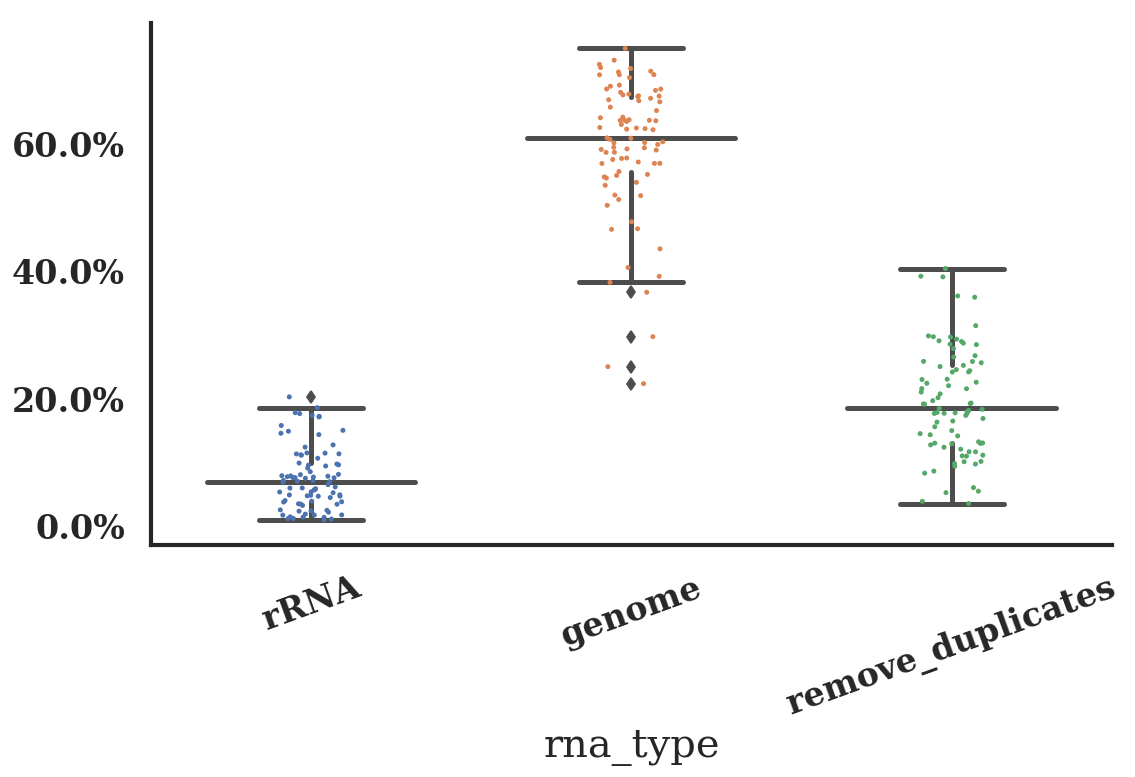

<Figure size 720x480 with 0 Axes>

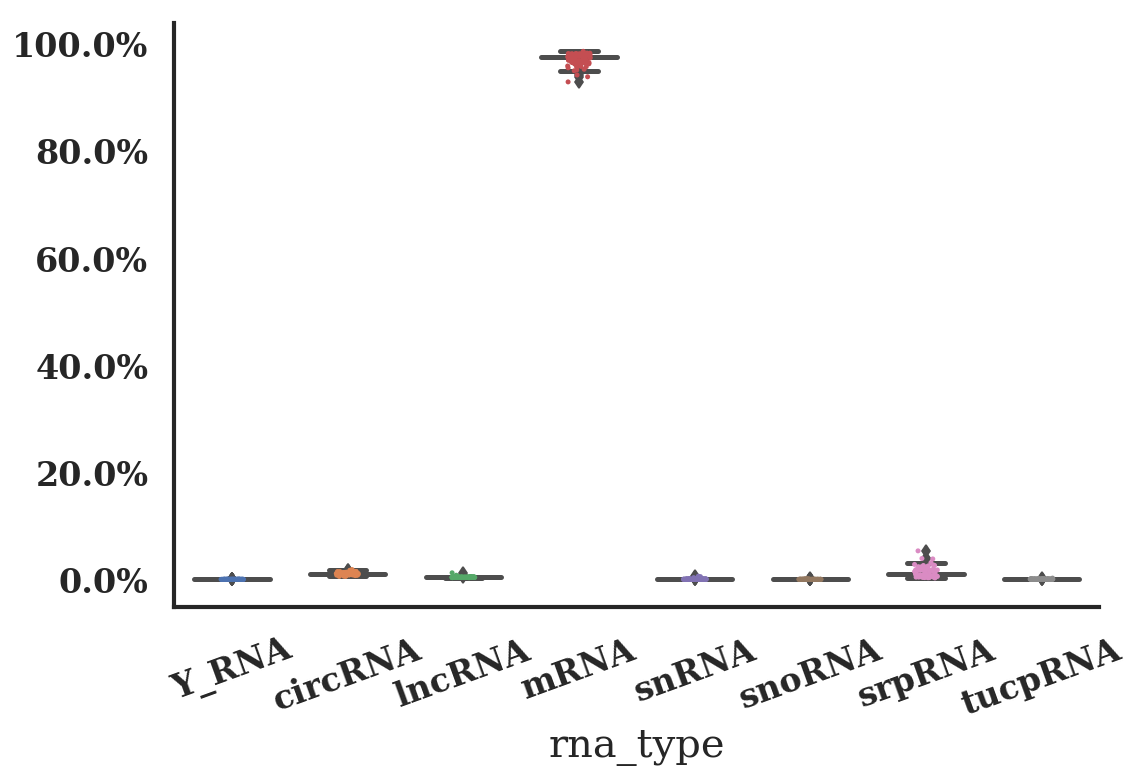

<Figure size 720x480 with 0 Axes>

In [61]:
def plot_ratio_boxplot(data, rnanames, points_show = True, width=20, height=10, savefig=False):
    '''
    data: table_ratio
    rnanames: rna type names
    points_show: plot scatter points too
    '''
    fig, ax = plt.subplots(figsize=(width, height))
    sns.boxplot(data = data,ax=ax,boxprops=dict(alpha=.001),color='gray',width=0.65,saturation=0.01)
    if points_show:
        sns.stripplot(data = data,ax=ax,size=3, edgecolor='black')
    ax.set_xticklabels(rnanames,rotation=20,fontsize=20)
    ax.set_yticklabels(['{:.1f}%'.format((i-1)*20) for i in range(10)],fontsize=20,fontweight='bold')
    fig.tight_layout()
    if savefig:
        fig.savefig(plot_save_path+'rna_ratio_box_plot.png', bbox_inches='tight')
    plt.figure(linewidth=30.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

if sequencing_type == 'short': 
    plot_ratio_boxplot(table_ratio, rnanames, points_show = True, width=16, height=10, savefig=False)
elif sequencing_type == 'long': 
    plot_ratio_boxplot(table_ratio_1, rnanames_1, points_show = True, 
                   width=10, height=7, savefig=False)
    plot_ratio_boxplot(table_ratio_2, rnanames_2, points_show = True, 
                   width=10, height=7, savefig=False)


## line plot of rna length

In [11]:
def plot_length_line(data, rnanames, width=20, height=50, savefig=False):
    '''
    data: length_table
    rnanames: rna type names
    '''
    length = np.array(data.T)
    fig,ax=plt.subplots(length.shape[0],1,figsize=(width, height))
    for i in range(length.shape[0]):
        ax[i].plot(length[i],label=data.columns[i], color=tableau20[i])
        ax[i].legend(loc='upper right')
        ax[i].set_xticks(np.arange(0, data.shape[0],5))
        ax[i].set_xticklabels(np.arange(data.index[0], data.index[-1],5))
    if savefig:
        fig.savefig(plot_save_path+'rna_length_line_plot.png', bbox_inches='tight')

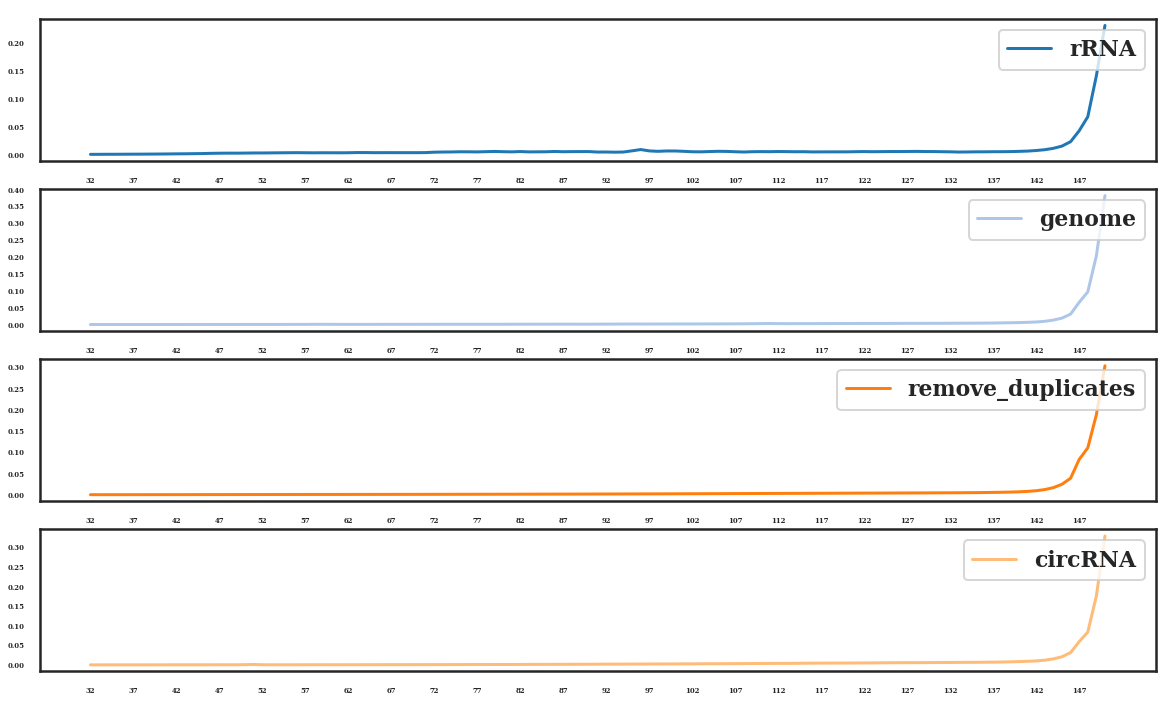

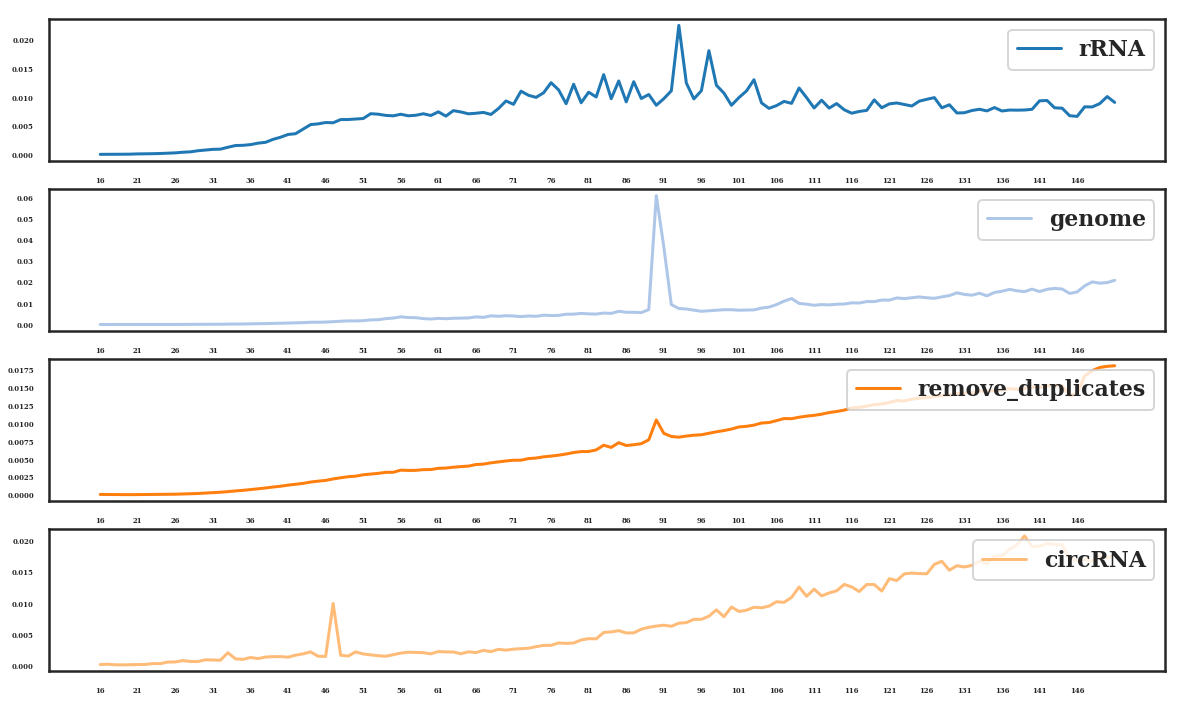

In [12]:
if sequencing_type == 'short': 
    plot_length_line(length_table, rnanames, width=20, height=length_table.shape[1]*3, savefig=False)
elif sequencing_type == 'long': 
    plot_length_line(length_table_1, rnanames_1, width=20, height=length_table_1.shape[1]*3, savefig=False)
    plot_length_line(length_table_2, rnanames_2, width=20, height=length_table_2.shape[1]*3, savefig=False)


## 3D barplot of rna length

In [13]:
def plot_3d(data, width=25, height=16, savefig=False, azim = 45, elev = 32):
    '''
    data: length_table
    '''
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(width,height))
    ax1 = fig.gca(projection="3d")
    num = data.shape[1]
    count_ = data.shape[0]
    xpos = np.repeat(np.arange(1,count_+1),num).reshape(count_,-1).T.ravel()
    ypos = np.repeat(range(num),count_).ravel()
    num_elements = len(xpos)
    zpos = np.zeros(count_*num)
    dx = np.ones(count_*num)/5
    dy = np.ones(count_*num)/5
    dz = np.array(data.T).ravel()
    for i in range(num):
        ax1.bar3d(xpos[count_*i:count_*(i+1)], ypos[count_*i:count_*(i+1)], zpos[count_*i:count_*(i+1)],
                  dx[count_*i:count_*(i+1)], dy[count_*i:count_*(i+1)],dz[count_*i:count_*(i+1)], color=(np.array(tableau20))[:num][i],alpha=0.9)
    plt.xticks(range(count_), [str(i+16) for i in range(count_)], color='red')
    ax1.set_yticks(range(num))
    ax1.set_yticklabels(data.columns, color='blue')
    for color,tick in zip((np.array(tableau20)/float(256))[:num],ax1.yaxis.get_major_ticks()):
        tick.label1.set_color(color)
    ax1.view_init(azim=azim,elev=elev)  
    fig.tight_layout()
    if savefig:
        fig.savefig(plot_save_path+'rna_length_3D_barplot.png', bbox_inches='tight')

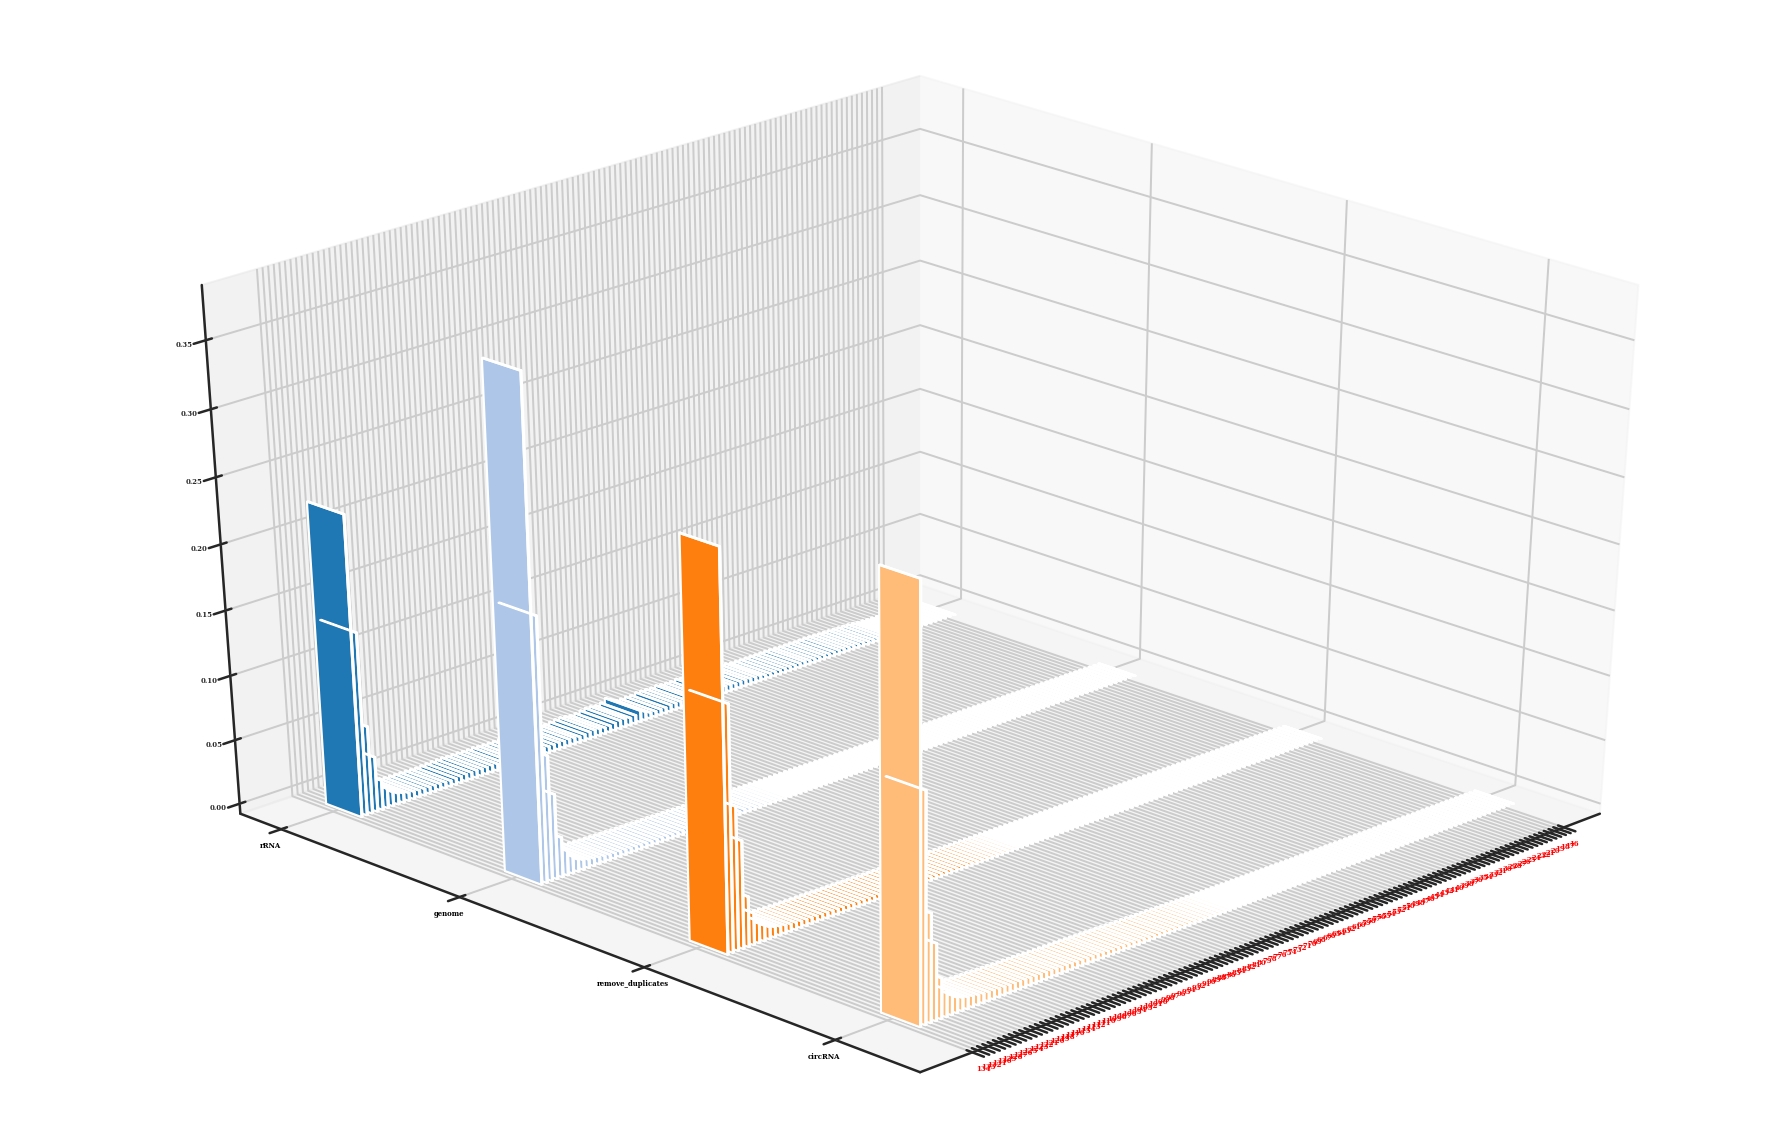

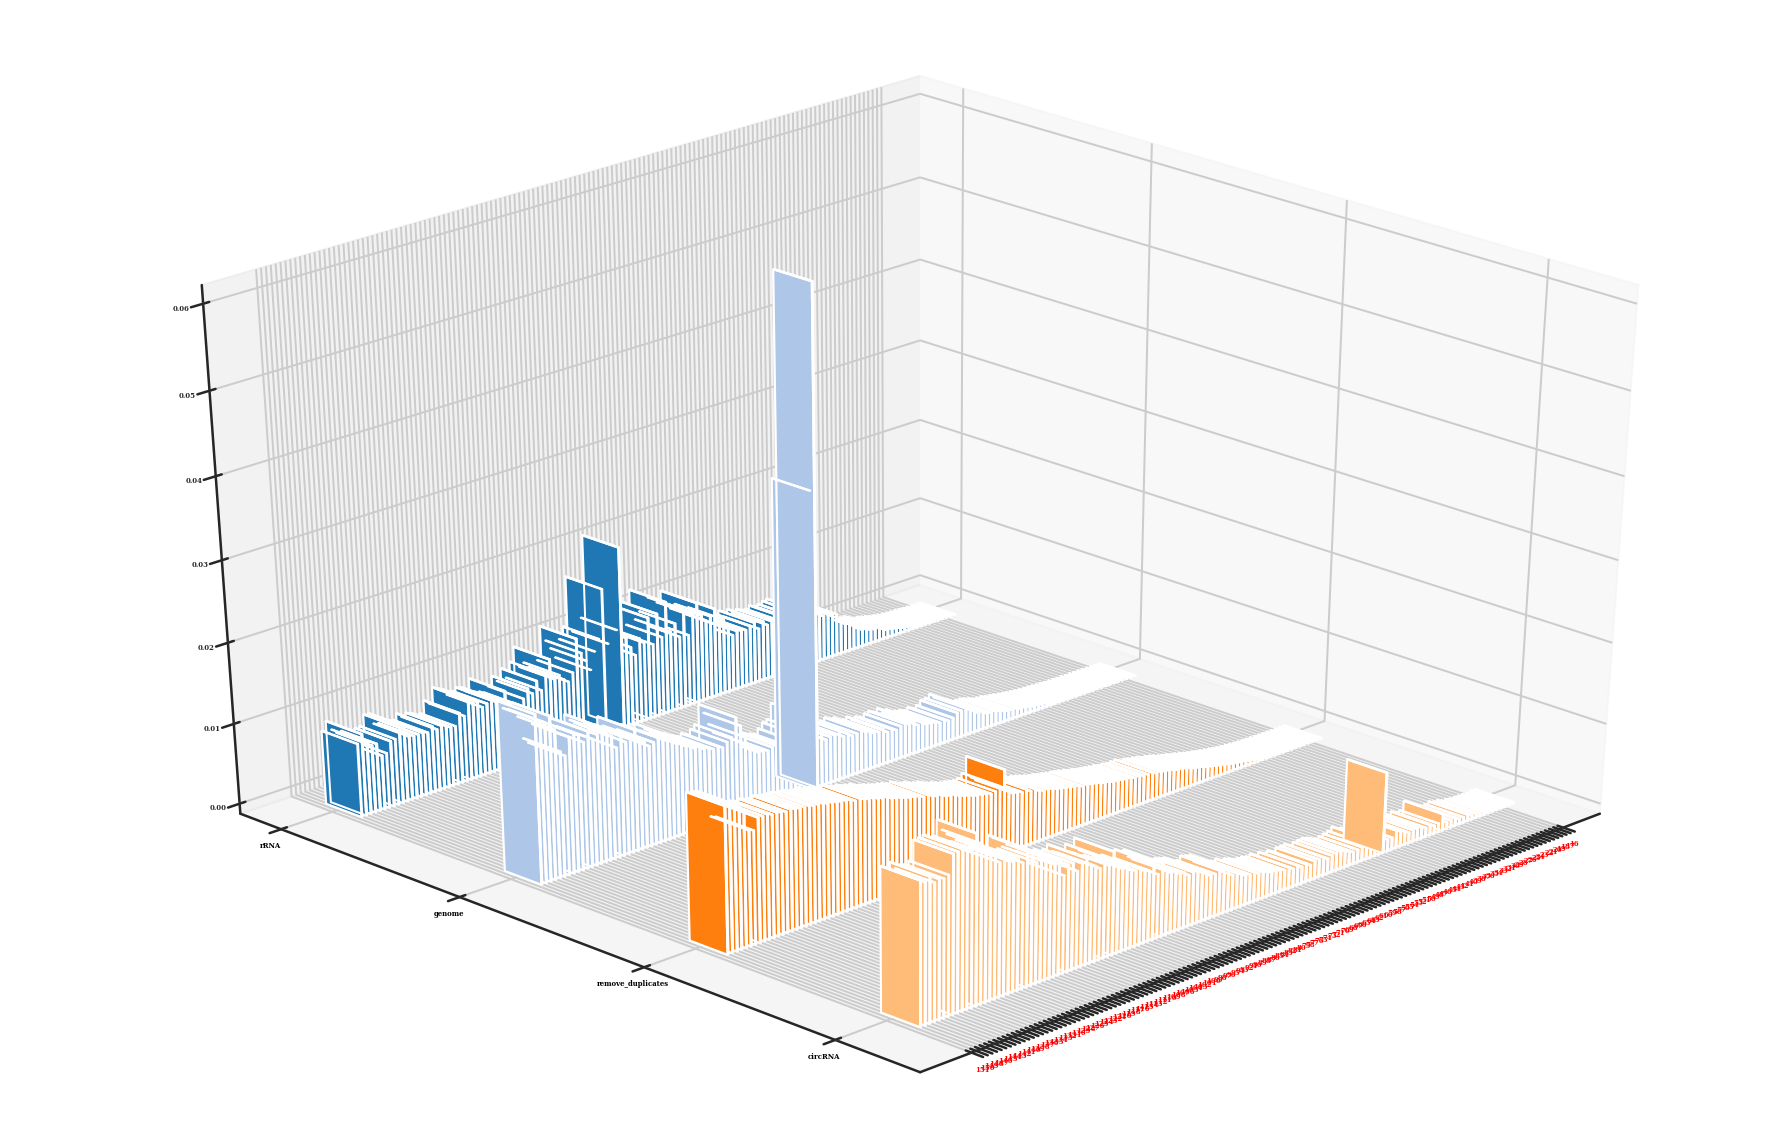

In [19]:
if sequencing_type == 'short': 
    plot_3d(length_table, width=25, height=16, savefig=False, azim = 45, elev = 32)
elif sequencing_type == 'long': 
    plot_3d(length_table_1, width=25, height=16, savefig=False, azim = 45, elev = 32)
    plot_3d(length_table_2, width=25, height=16, savefig=False, azim = 45, elev = 32)

## stack bar plot of rna counts and ratio

In [15]:
def stack_bar_ratio(table, statistics = 'ratio',savefig=False):
    from matplotlib.colors import LinearSegmentedColormap
    fig,ax=plt.subplots(figsize=(50,10))
    table.plot(kind='bar', stacked=True,ax=ax,
                legend=True,colormap=matplotlib.colors.ListedColormap ( tableau20))
    ax.legend(bbox_to_anchor=(1,1),fontsize='large')#, loc="lower right",
    #ax.set_title('Stacked Bar plot',fontsize=40)
    if savefig:
        fig.savefig(plot_save_path+statistics+'_stack_barplot.png', bbox_inches='tight')

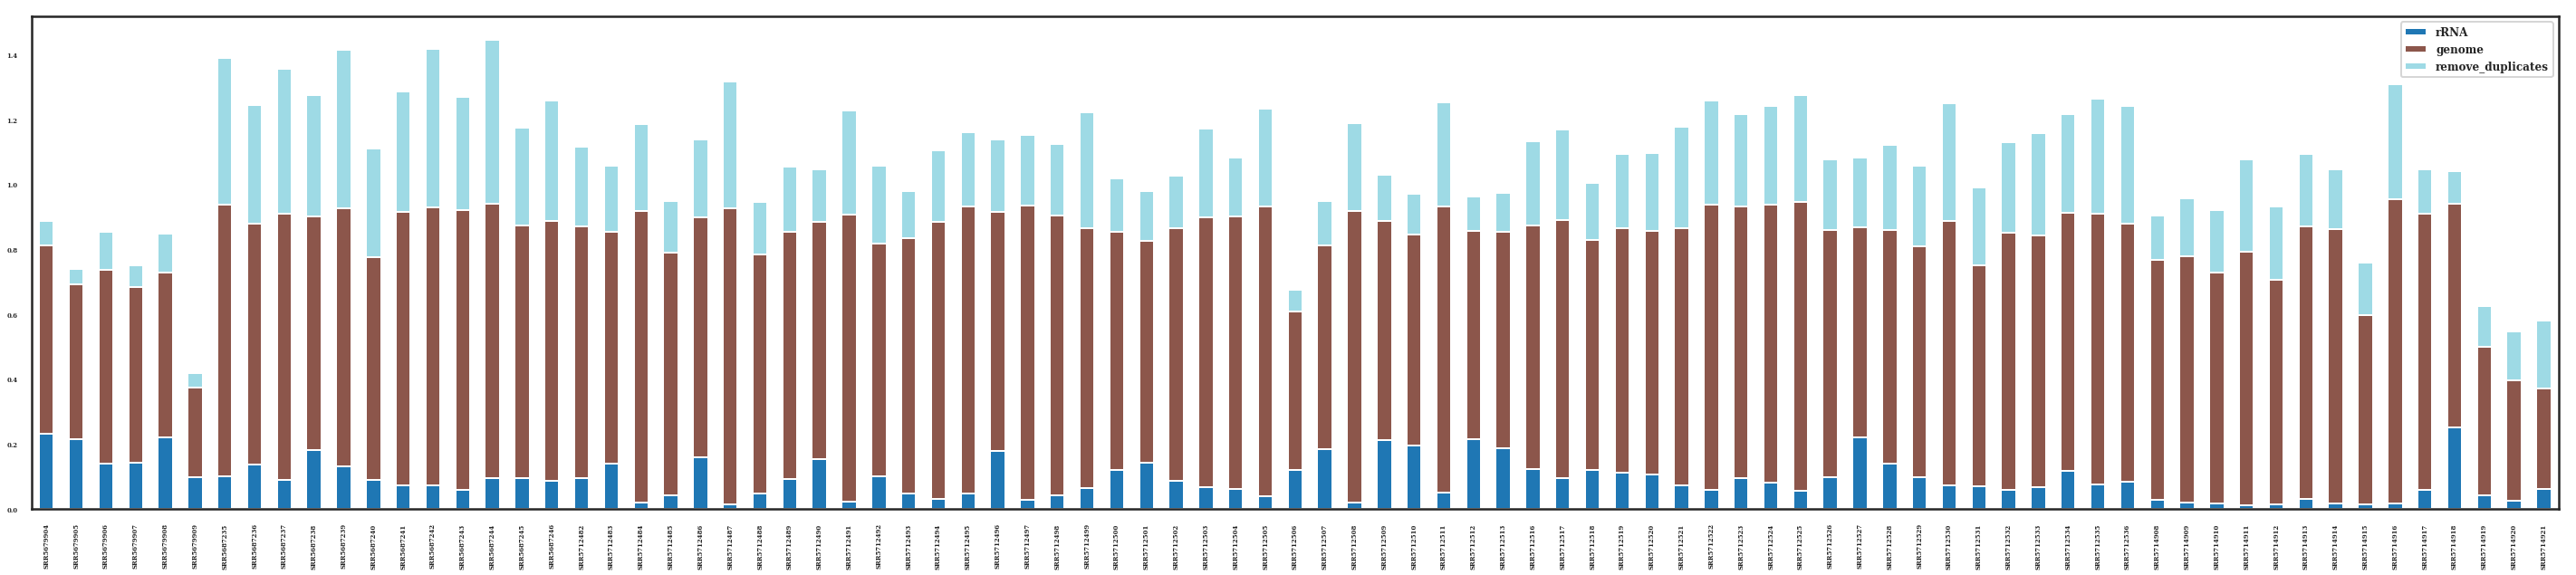

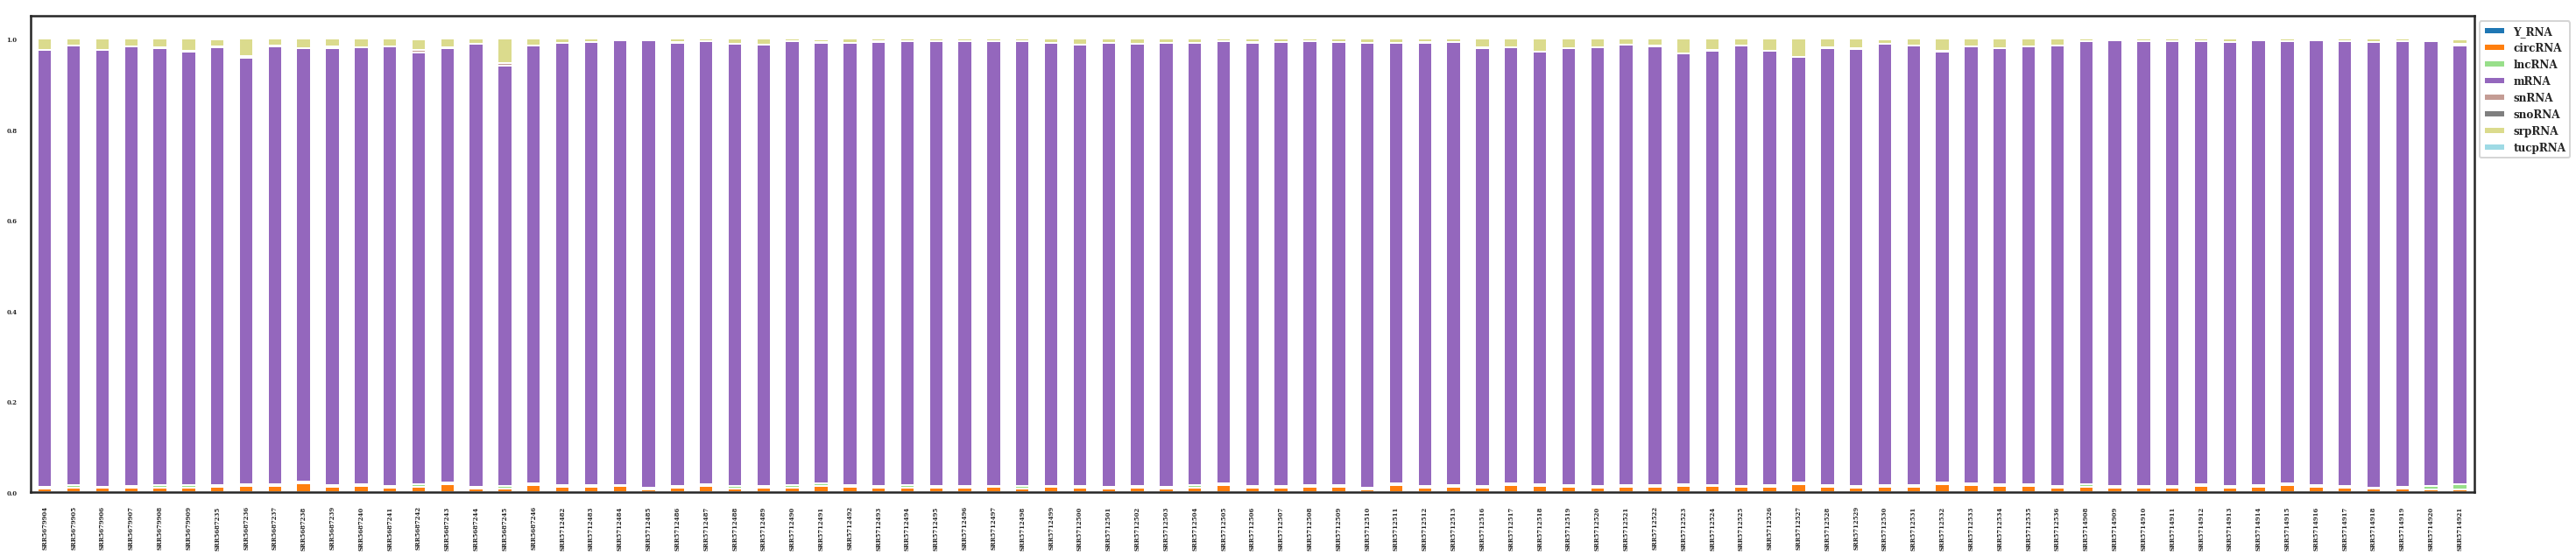

In [16]:
if sequencing_type == 'short': 
    stack_bar_ratio(table_ratio)
elif sequencing_type == 'long': 
    stack_bar_ratio(table_ratio_1)
    stack_bar_ratio(table_ratio_2)

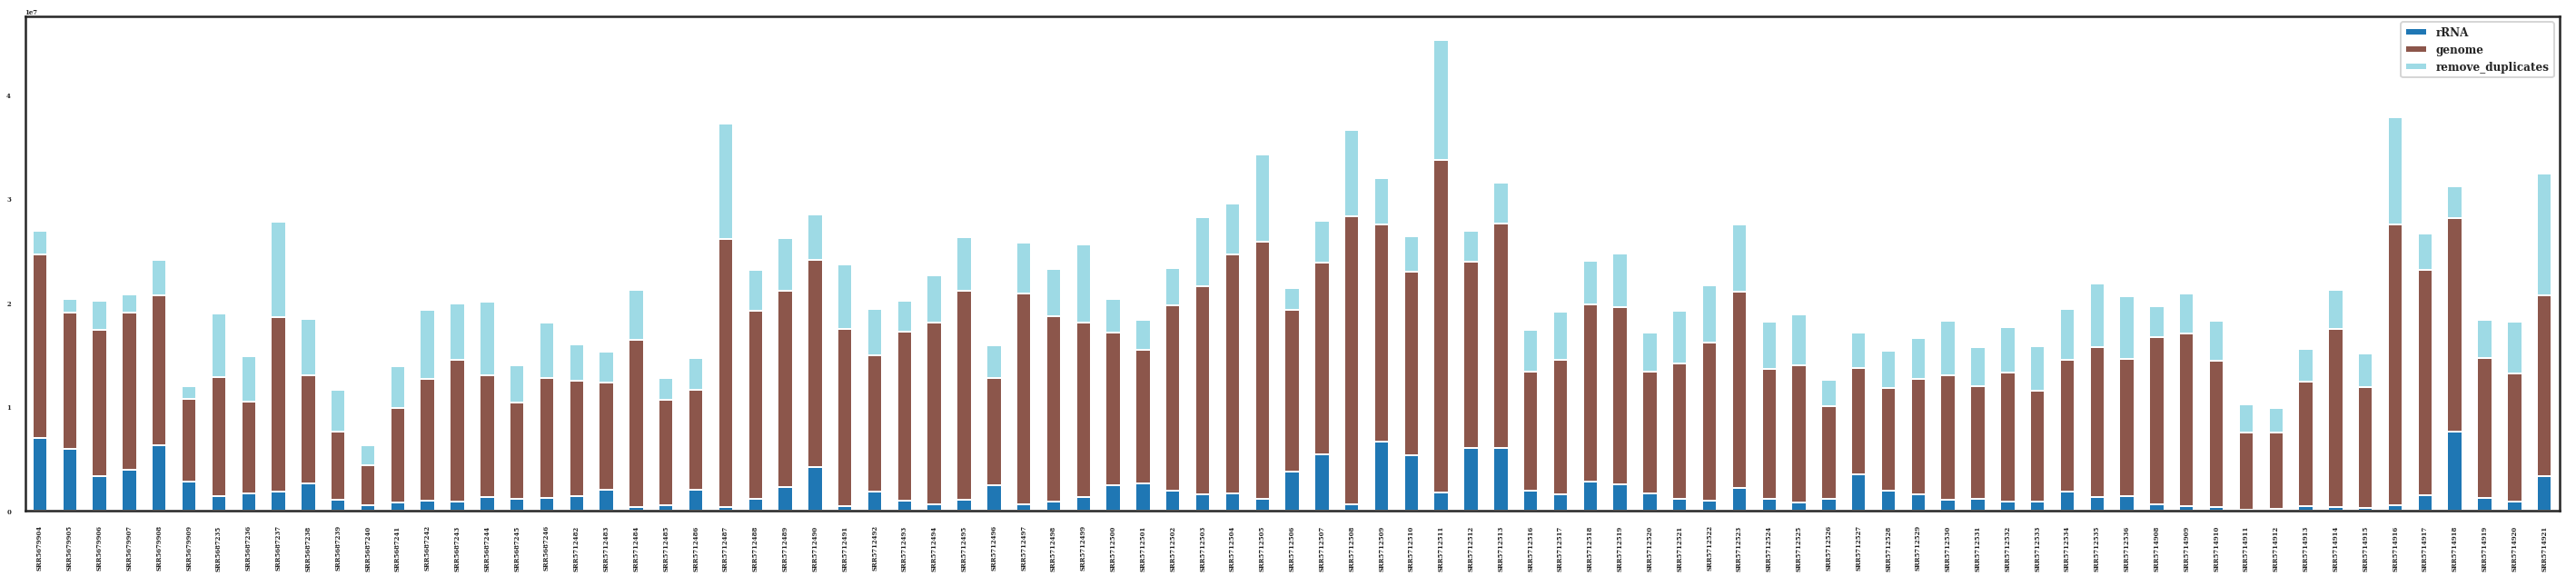

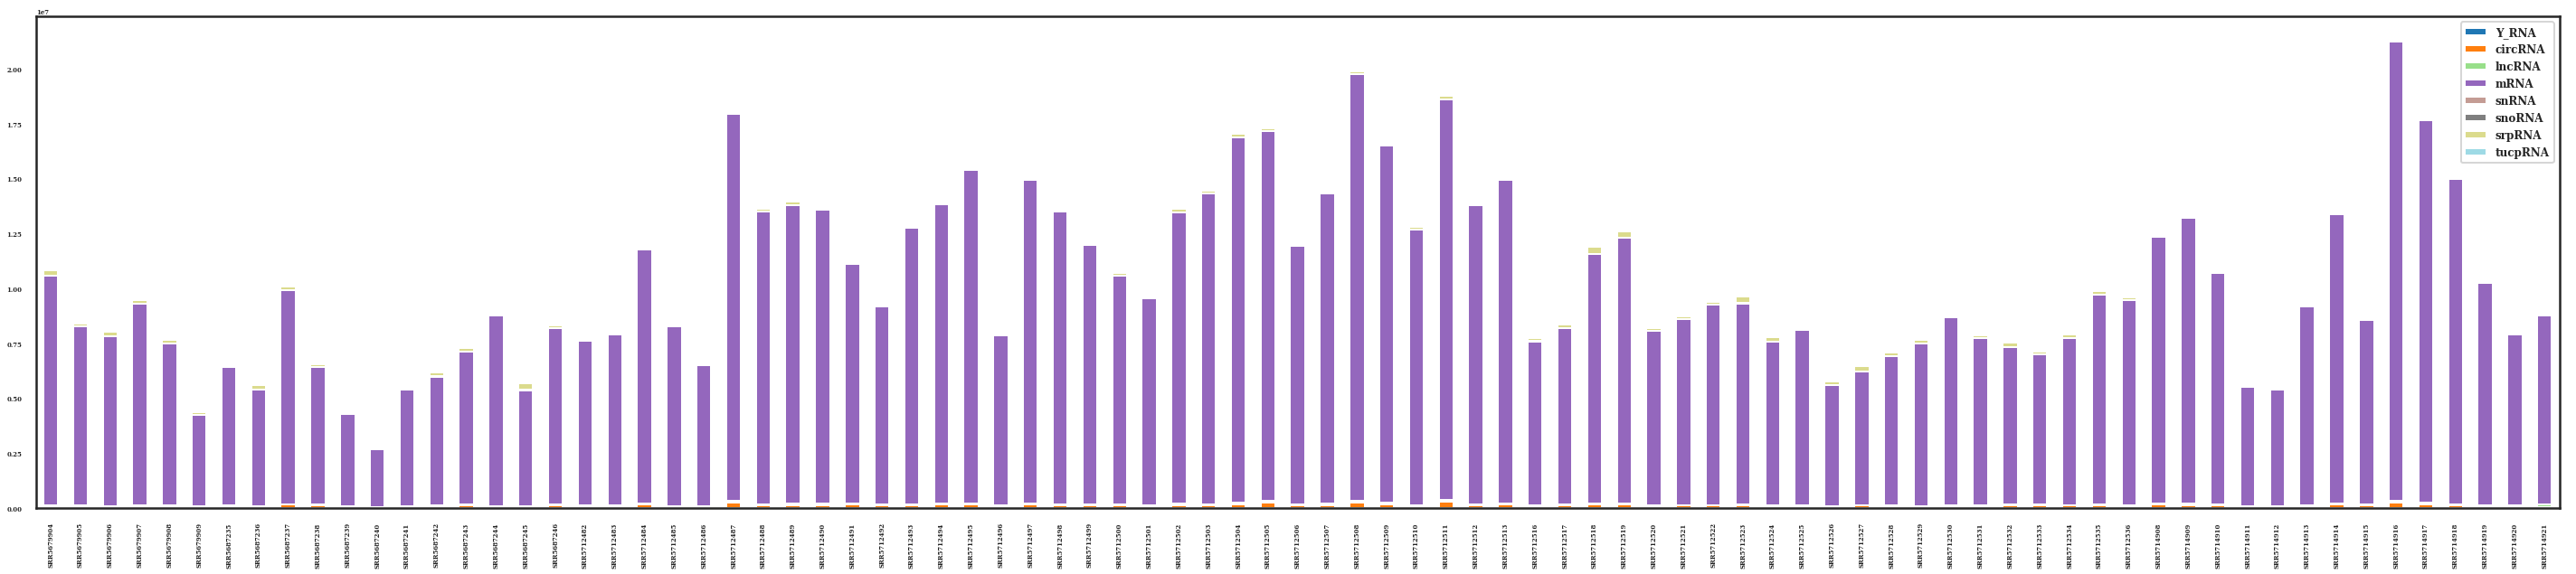

In [17]:
if sequencing_type == 'short': 
    stack_bar_ratio(table_count)
elif sequencing_type == 'long': 
    stack_bar_ratio(table_count_1)
    stack_bar_ratio(table_count_2)

## bar plot of RNA by sample

In [18]:
def plot_bar_by_rna(ax,table,rnaname,savefig=False, statistics = 'ratio',height = 4, width=20):
    '''
    table: ratio or count table, rows are rna type
    statistics: ratio or count
    '''
    table = table.T
    count = np.array(table[table.index ==rnaname]).ravel()
    #fig,ax=plt.subplots(1,figsize=(width,height))
    counttable =  pd.DataFrame(np.concatenate((np.arange(1,table.shape[1]+1).reshape(-1,1),
                count[np.argsort(-count)].reshape(-1,1)),axis=1),columns=['sample',statistics])
    sns.barplot(ax=ax,x='sample',y=statistics,data = counttable,color=tableau20[np.random.randint(0,20)],alpha=1)
    ax.set_xticks(np.arange(0,table.shape[1],5))
    ax.set_xticklabels(np.arange(0,table.shape[1],5))
    ax.set_title(statistics+' of '+rnaname,fontsize=15)
    if savefig:
        fig.savefig(plot_save_path+'sample_'+rnaname+'_'+statistics+'_bar_plot.png', bbox_inches='tight')

In [132]:
def plot_bar_by_rna_total(table,datatype='ratio'):
    fignum= table.columns.shape[0]
    fig,ax=plt.subplots(fignum ,1,figsize=(20 , 4*fignum ))
    for i in range(fignum):
        plot_bar_by_rna(ax[i],table,table.columns[i],statistics = datatype)
    fig.tight_layout() 

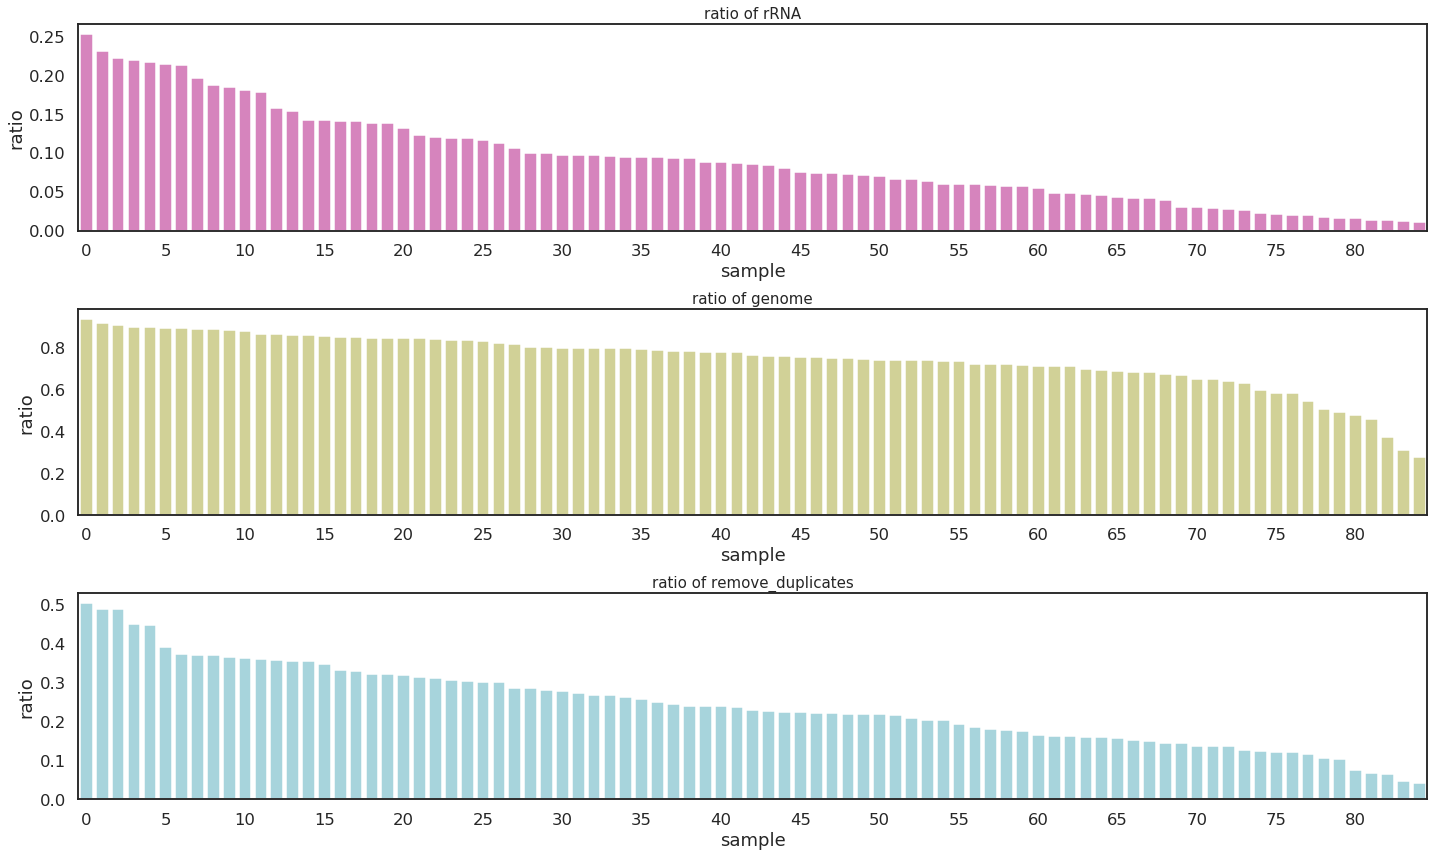

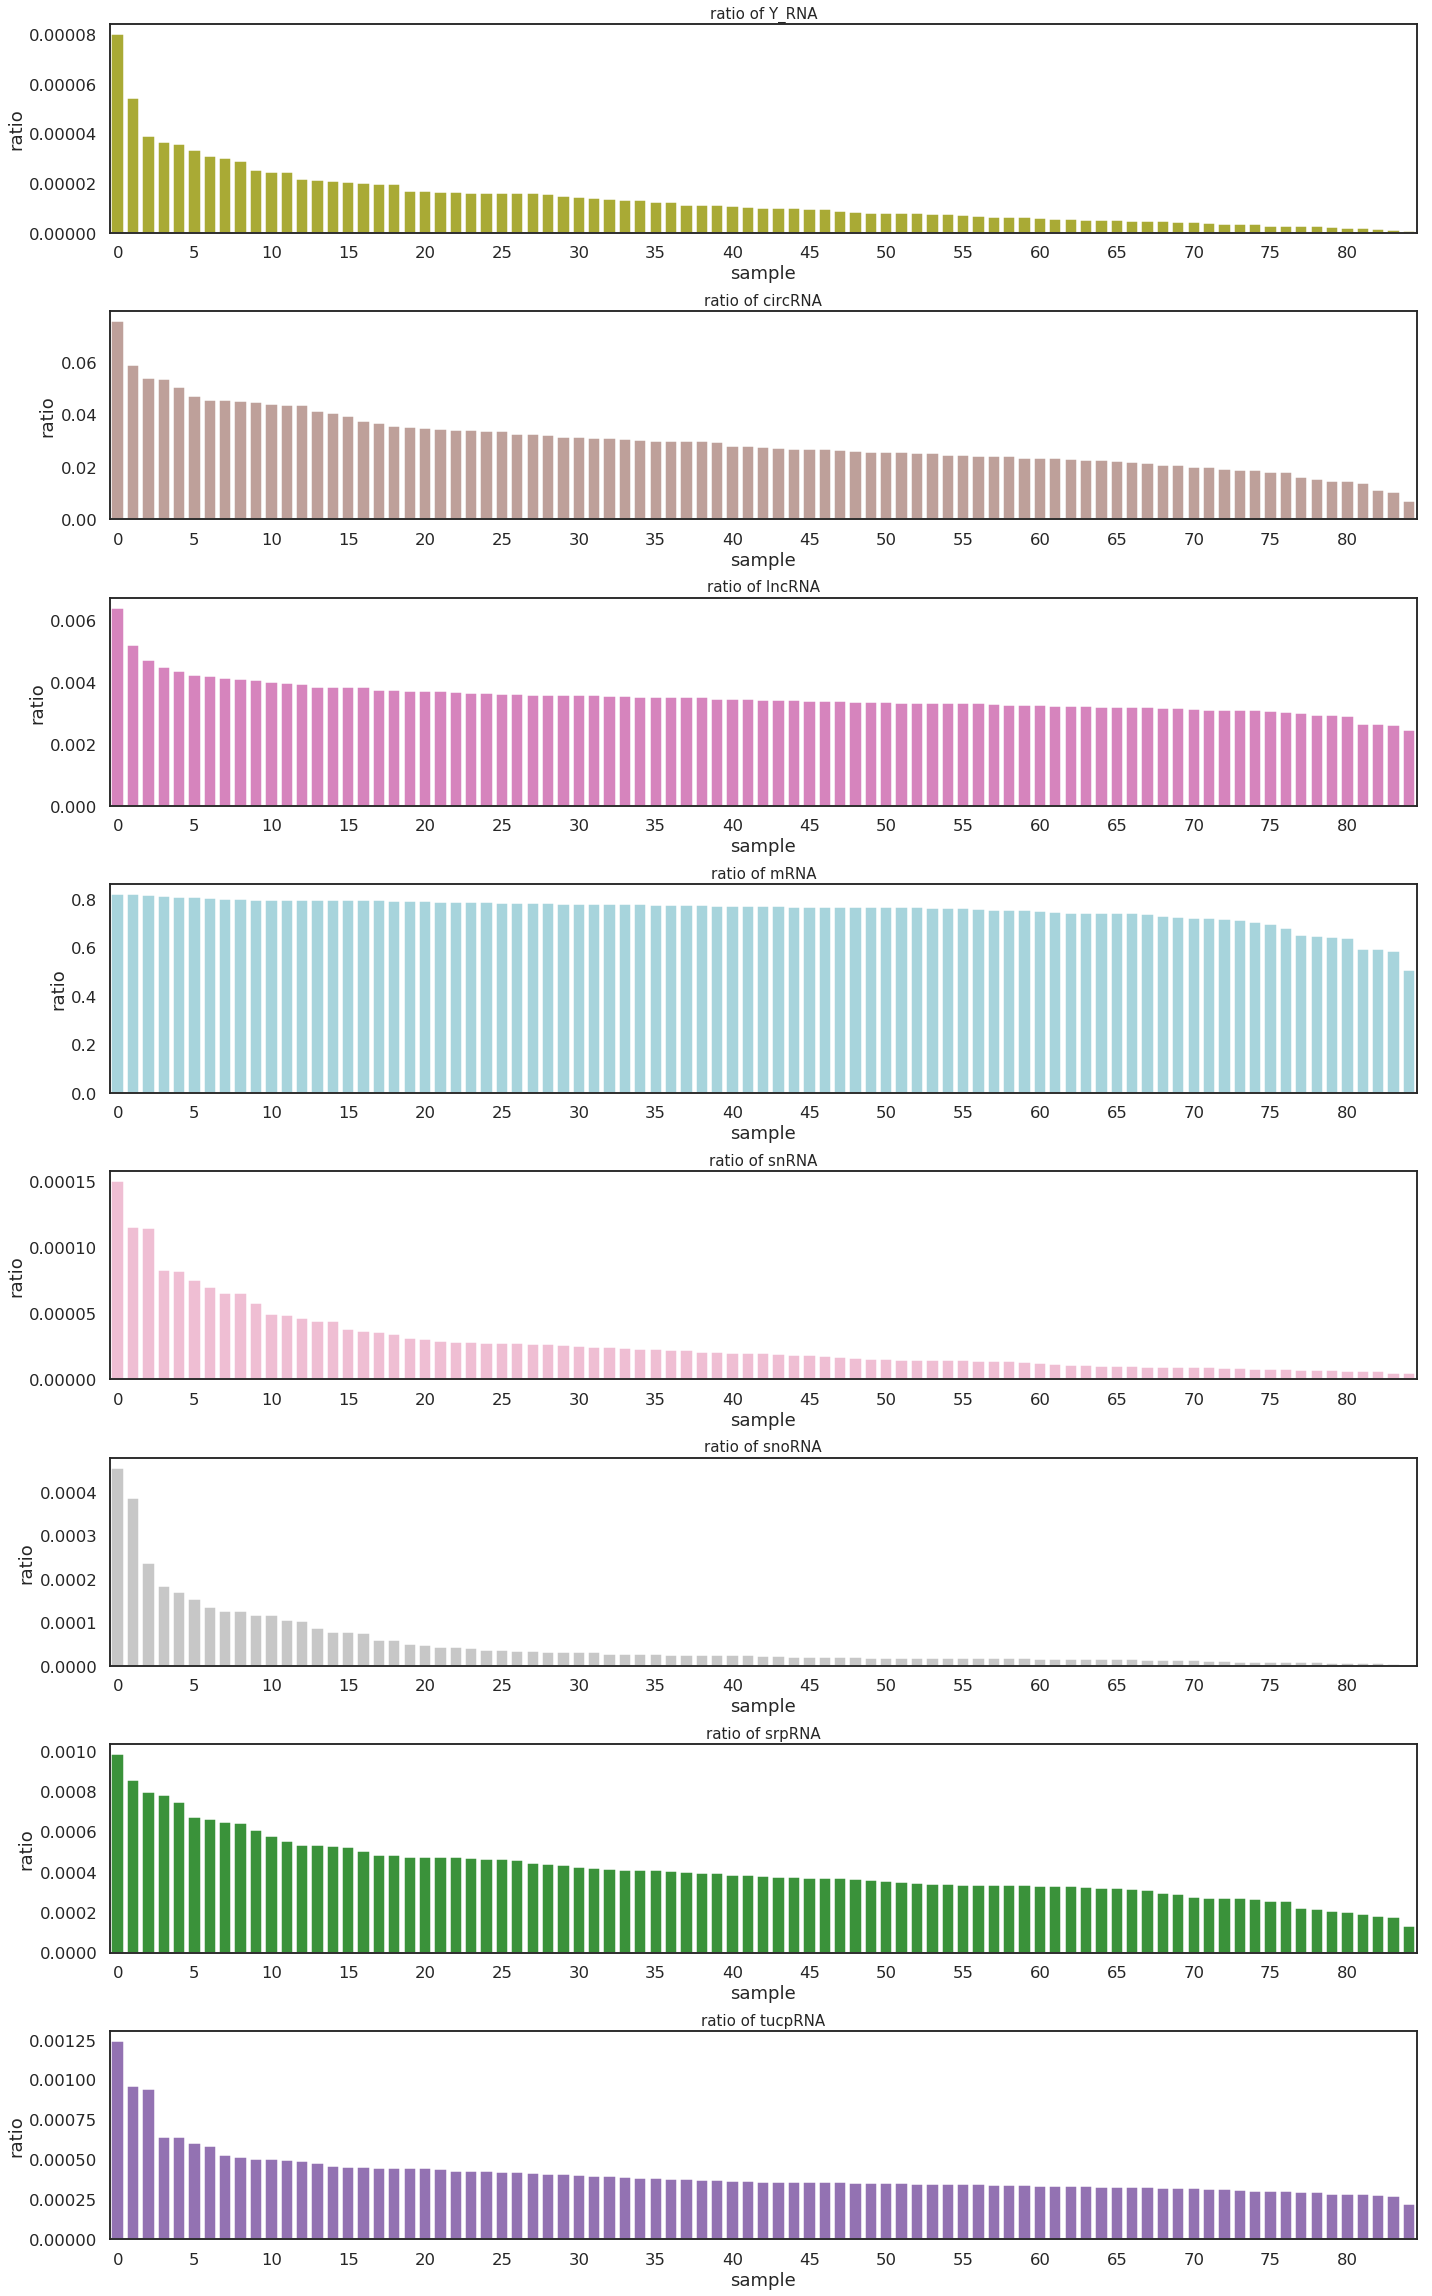

In [133]:
if sequencing_type == 'short': 
    plot_bar_by_rna_total(table_ratio,datatype='ratio')
elif sequencing_type == 'long': 
    plot_bar_by_rna_total(table_ratio_1,datatype='ratio')
    plot_bar_by_rna_total(table_ratio_2,datatype='ratio')

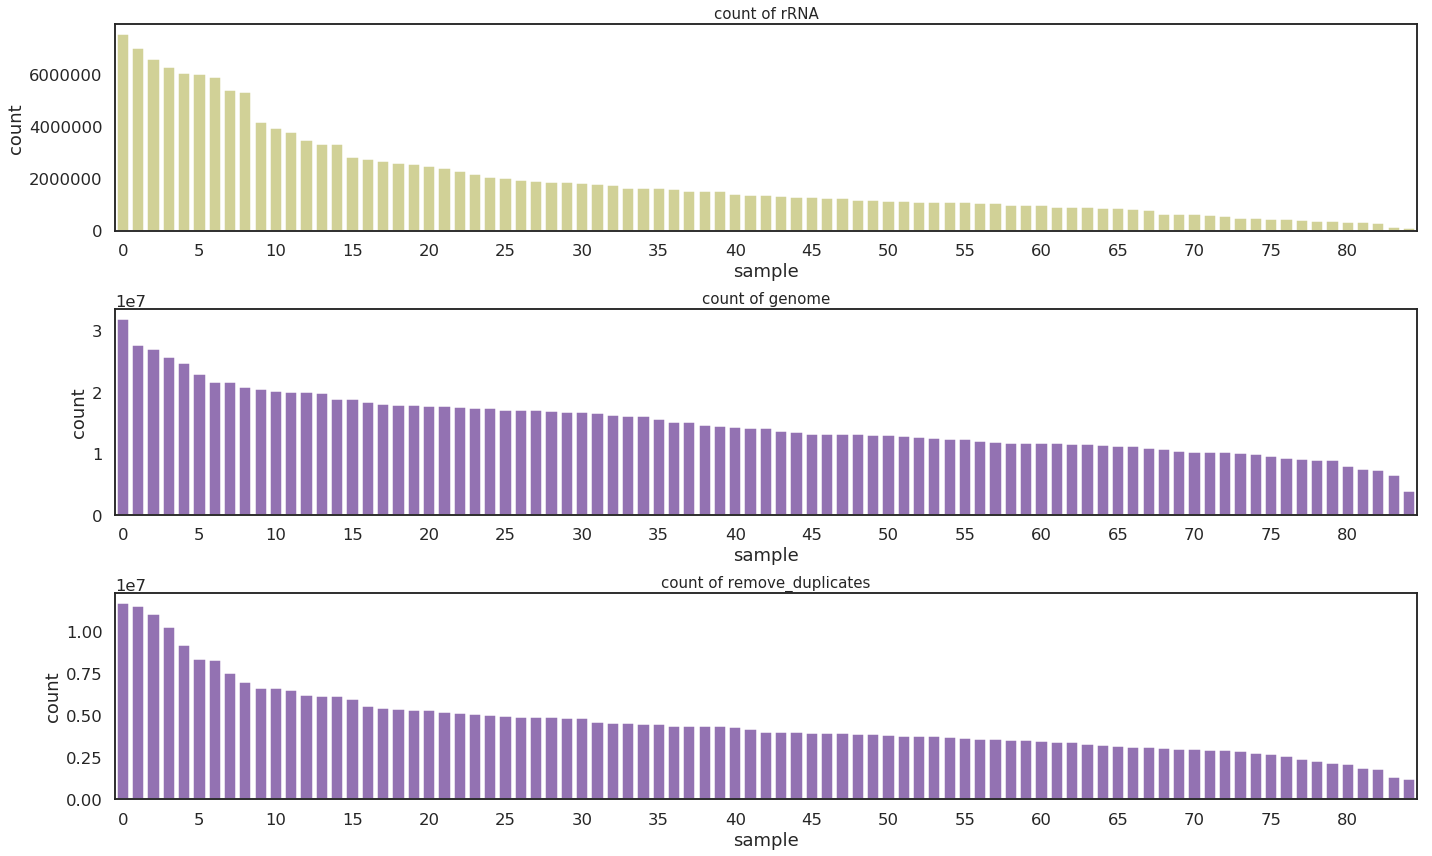

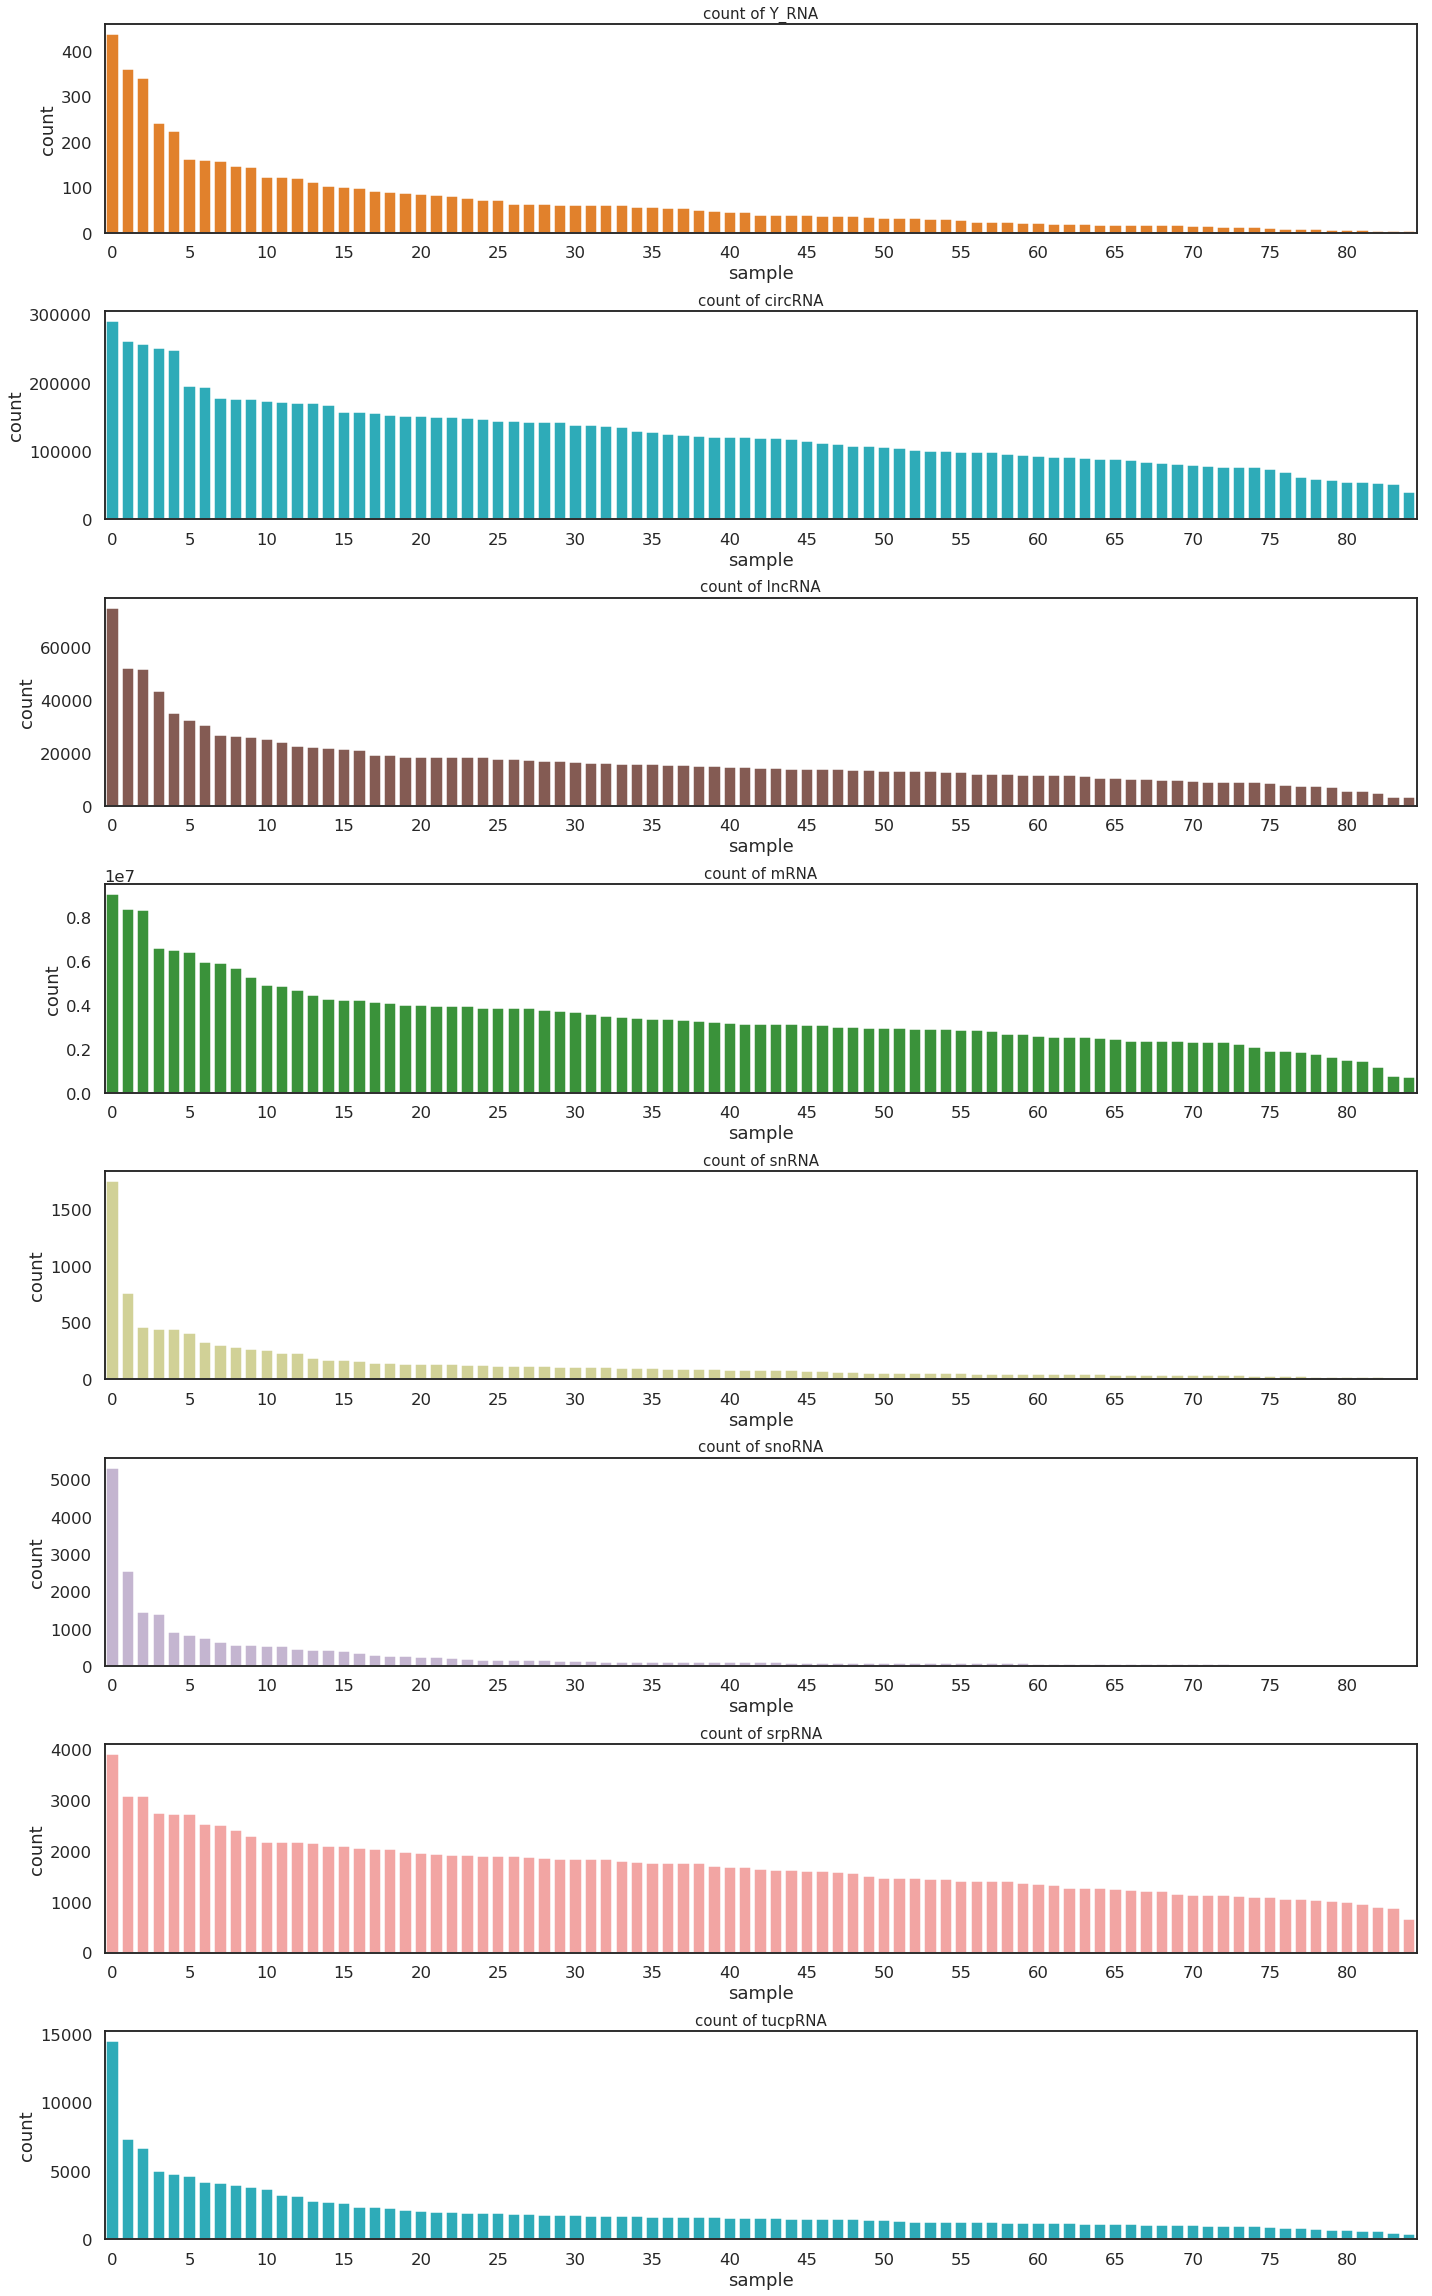

In [134]:
if sequencing_type == 'short': 
    plot_bar_by_rna_total(table_count,datatype='count')
elif sequencing_type == 'long': 
    plot_bar_by_rna_total(table_count_1,datatype='count')
    plot_bar_by_rna_total(table_count_2,datatype='count')

## FastQC

In [135]:
summary = pd.read_table('output/'+dataset+'/summary/fastqc.txt', sep='\t')
qc_status = summary.iloc[:, 9:]
qc_status.fillna('NA')
qc_status = qc_status.astype('str')
sample_ids = summary.sample_id
sections = qc_status.columns.values
def style_func(val):
    status, row, col = val.split('|')
    row, col = int(row), int(col)
    color = {'pass': 'green', 'fail': 'red', 'warn': 'orange'}.get(status, 'gray')
    return '<a href="../output/'+dataset+'/fastqc/{sample_id}_fastqc.html#M{section}" style="color: {color}">{status}</a>'.format(
        sample_id=sample_ids[row], color=color, status=status, section=col + 1)

pd.DataFrame(qc_status.values \
             + '|' + np.arange(qc_status.shape[0]).astype('str')[:, np.newaxis] \
             + '|' + np.arange(qc_status.shape[1]).astype('str')[np.newaxis, :],
             index=qc_status.index, columns=qc_status.columns) \
    .style.format(style_func)

FileNotFoundError: File b'output/exorbase/summary/fastqc.txt' does not exist

## Sample QC
use PCA and tSNE to visualize outliters

In [148]:
if sequencing_type=='short':
    original_mx_file = 'output/'+dataset+'/count_matrix/domains_combined.txt'
elif sequencing_type=='long':
    original_mx_file = 'output/'+dataset+'/count_matrix/'+exp_mx_name+'.txt'
original_mx = pd.read_table(original_mx_file,index_col=0)

In [142]:
def PCA_plot_basic(ax,data,method_PCA = True):
    X = np.log2(data + 0.001).T
    X = StandardScaler().fit_transform(X)
    if method_PCA == True:
        transform = PCA()
    else:
        transform = TSNE()
    X_pca = transform.fit_transform(X)
    ax.scatter(X_pca[:,0], X_pca[:,1], s=200,alpha=0.8 ,edgecolors = 'b',color='r')
def sample_qc_visualize_outlier(original_mx,table_ratio,method='PCA'):
    fig, ax = plt.subplots(1,2,figsize=(16, 8))
    if method=='PCA':
        method_PCA = True
    elif method=='tSNE':
        method_PCA = False
    PCA_plot_basic(ax[0],original_mx, method_PCA)
    PCA_plot_basic(ax[1],table_ratio, method_PCA)

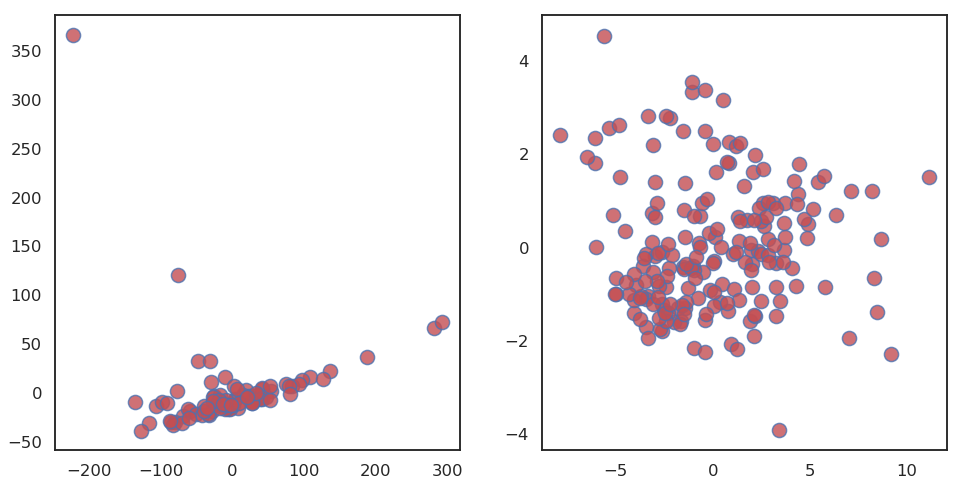

In [143]:
sample_qc_visualize_outlier(original_mx,table_ratio.T,method='PCA')

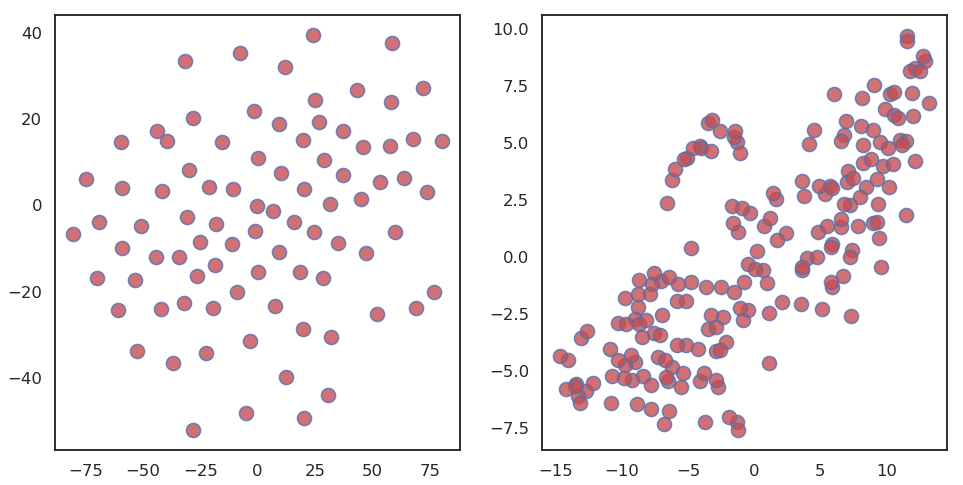

In [144]:
sample_qc_visualize_outlier(original_mx,table_ratio.T,method='tSNE')

# Matrix processing

## filtering effect

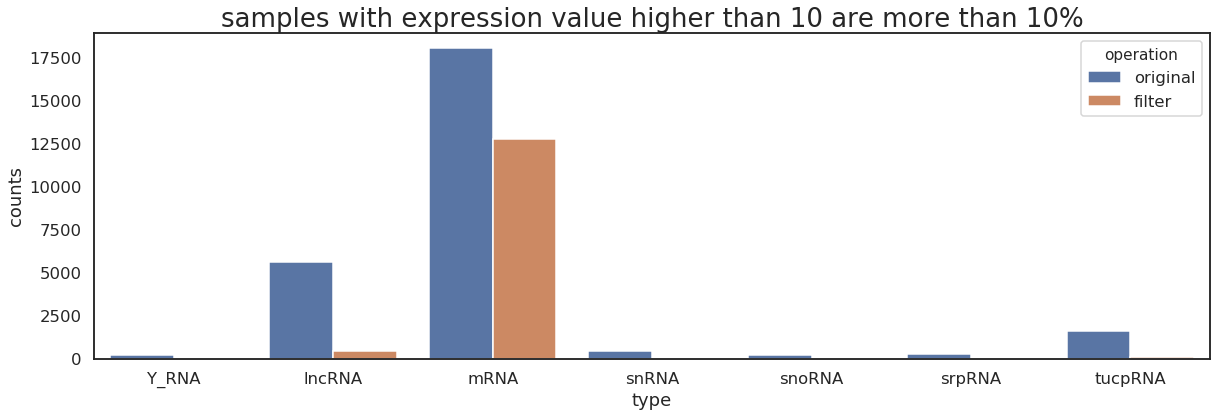

In [145]:
def plot_bar_for_filter(expression_mx,cutoff_ratio = 0.2,counts_threshold = 10 ):
    retain_index = np.where(np.sum(expression_mx > counts_threshold,axis=1) >=round(cutoff_ratio*expression_mx.shape[1]))[0]
    filter_mx = expression_mx.iloc[retain_index,:]
    names = expression_mx.index
    names_ = filter_mx.index
    names_type = np.array([names[i].split('|')[1] for i in range(names.shape[0])])
    type_counts = np.unique(names_type, return_counts = True)
    names_type_ = np.array([names_[i].split('|')[1] for i in range(names_.shape[0])])
    type_counts_ = np.unique(names_type_, return_counts = True)
    typedataframe = pd.DataFrame(np.concatenate((type_counts[0].reshape(-1,1),type_counts[1].reshape(-1,1)),axis=1))
    typedataframe.columns = ['type','counts']
    typedataframe_ = pd.DataFrame(np.concatenate((type_counts_[0].reshape(-1,1),type_counts_[1].reshape(-1,1)),axis=1))
    typedataframe_.columns = ['type','counts']
    typedataframe.counts = pd.to_numeric(typedataframe.counts)
    typedataframe_.counts = pd.to_numeric(typedataframe_.counts)
    dataall = pd.concat((typedataframe,typedataframe_))
    operation = np.concatenate((np.repeat('original',typedataframe.shape[0]),
                                           np.repeat('filter',typedataframe.shape[0])))

    dataall['operation'] = operation
    fig,ax=plt.subplots(1,figsize=(20 , 6))
    sns.barplot(ax=ax,data=dataall,x='type',y='counts',hue='operation')
    ax.set_title('samples with expression value higher than '+str(counts_threshold) +
                    ' are more than '+str(round(cutoff_ratio*100))+'%',fontsize=26)
plot_bar_for_filter(original_mx,cutoff_ratio = 0.1 ,counts_threshold = 10 )

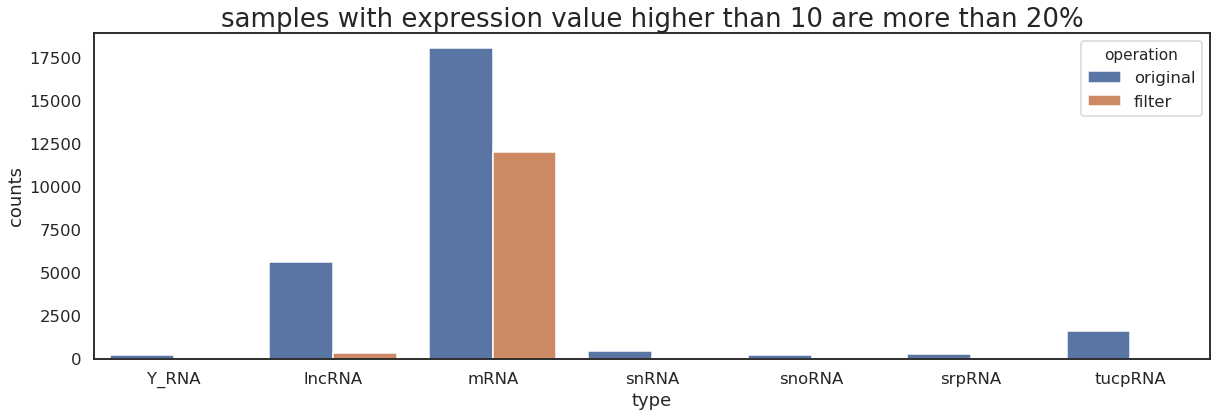

In [146]:
plot_bar_for_filter(original_mx,cutoff_ratio = 0.2 ,counts_threshold = 10 )

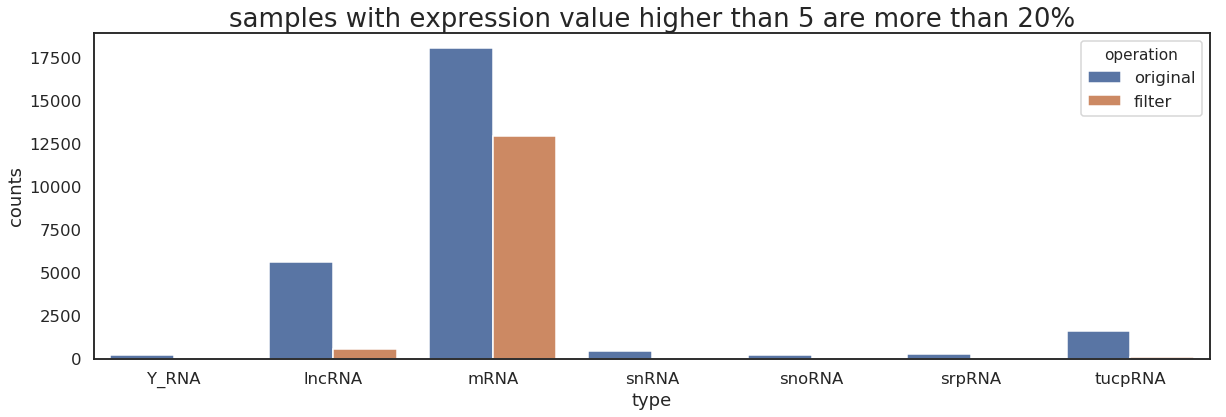

In [147]:
plot_bar_for_filter(original_mx,cutoff_ratio = 0.2 ,counts_threshold = 5 )

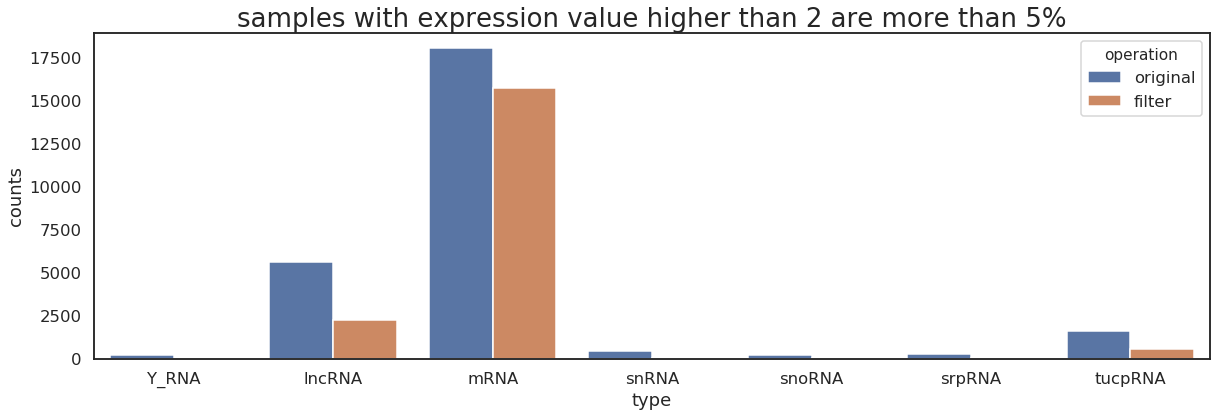

In [148]:
plot_bar_for_filter(original_mx,cutoff_ratio = 0.05 ,counts_threshold = 2 )

In [4]:
matrix_processing_path = 'output/'+dataset+'/matrix_processing/'
imputation_method = 'scimpute_count'
normalization_method = 'Norm_SCnorm'
batch_removal_method = 'Batch_RUV'
batch_index = 'null'
class_info = 'data/'+dataset+'/sample_classes.txt'
batch_info = 'data/'+dataset+'/batch_info.txt'
original_mx_file = 'output/'+dataset+'/count_matrix/'+exp_mx_name+'.txt'

def null_name(string):
    if string =='null':
        return '.null'
    else:
        return '.'+string
    
def generate_processed_filename(original_mx_file,imputation_method,normalization_method,batch_removal_method,batch_index): 
    imputename = null_name(imputation_method)
    normname = null_name(normalization_method)
    batchname = null_name(batch_removal_method)
    if batch_index=='null':
        batchindname = ''
    else:
        batchindname = '_'+batch_index
    return'filter'+imputename+normname+batchname+batchindname+'.'+original_mx_file.split('/')[-1]


In [5]:
original_mx = pd.read_table(original_mx_file,index_col=0)
processed_mx = pd.read_table(matrix_processing_path+generate_processed_filename(\
            original_mx_file,imputation_method,normalization_method,batch_removal_method,batch_index),index_col=0)
sample_class = pd.read_table(class_info,sep='\t',index_col=0)


In [63]:
class_info

'data_old/labels/sample_classes_hcc.txt'

## relative log expression

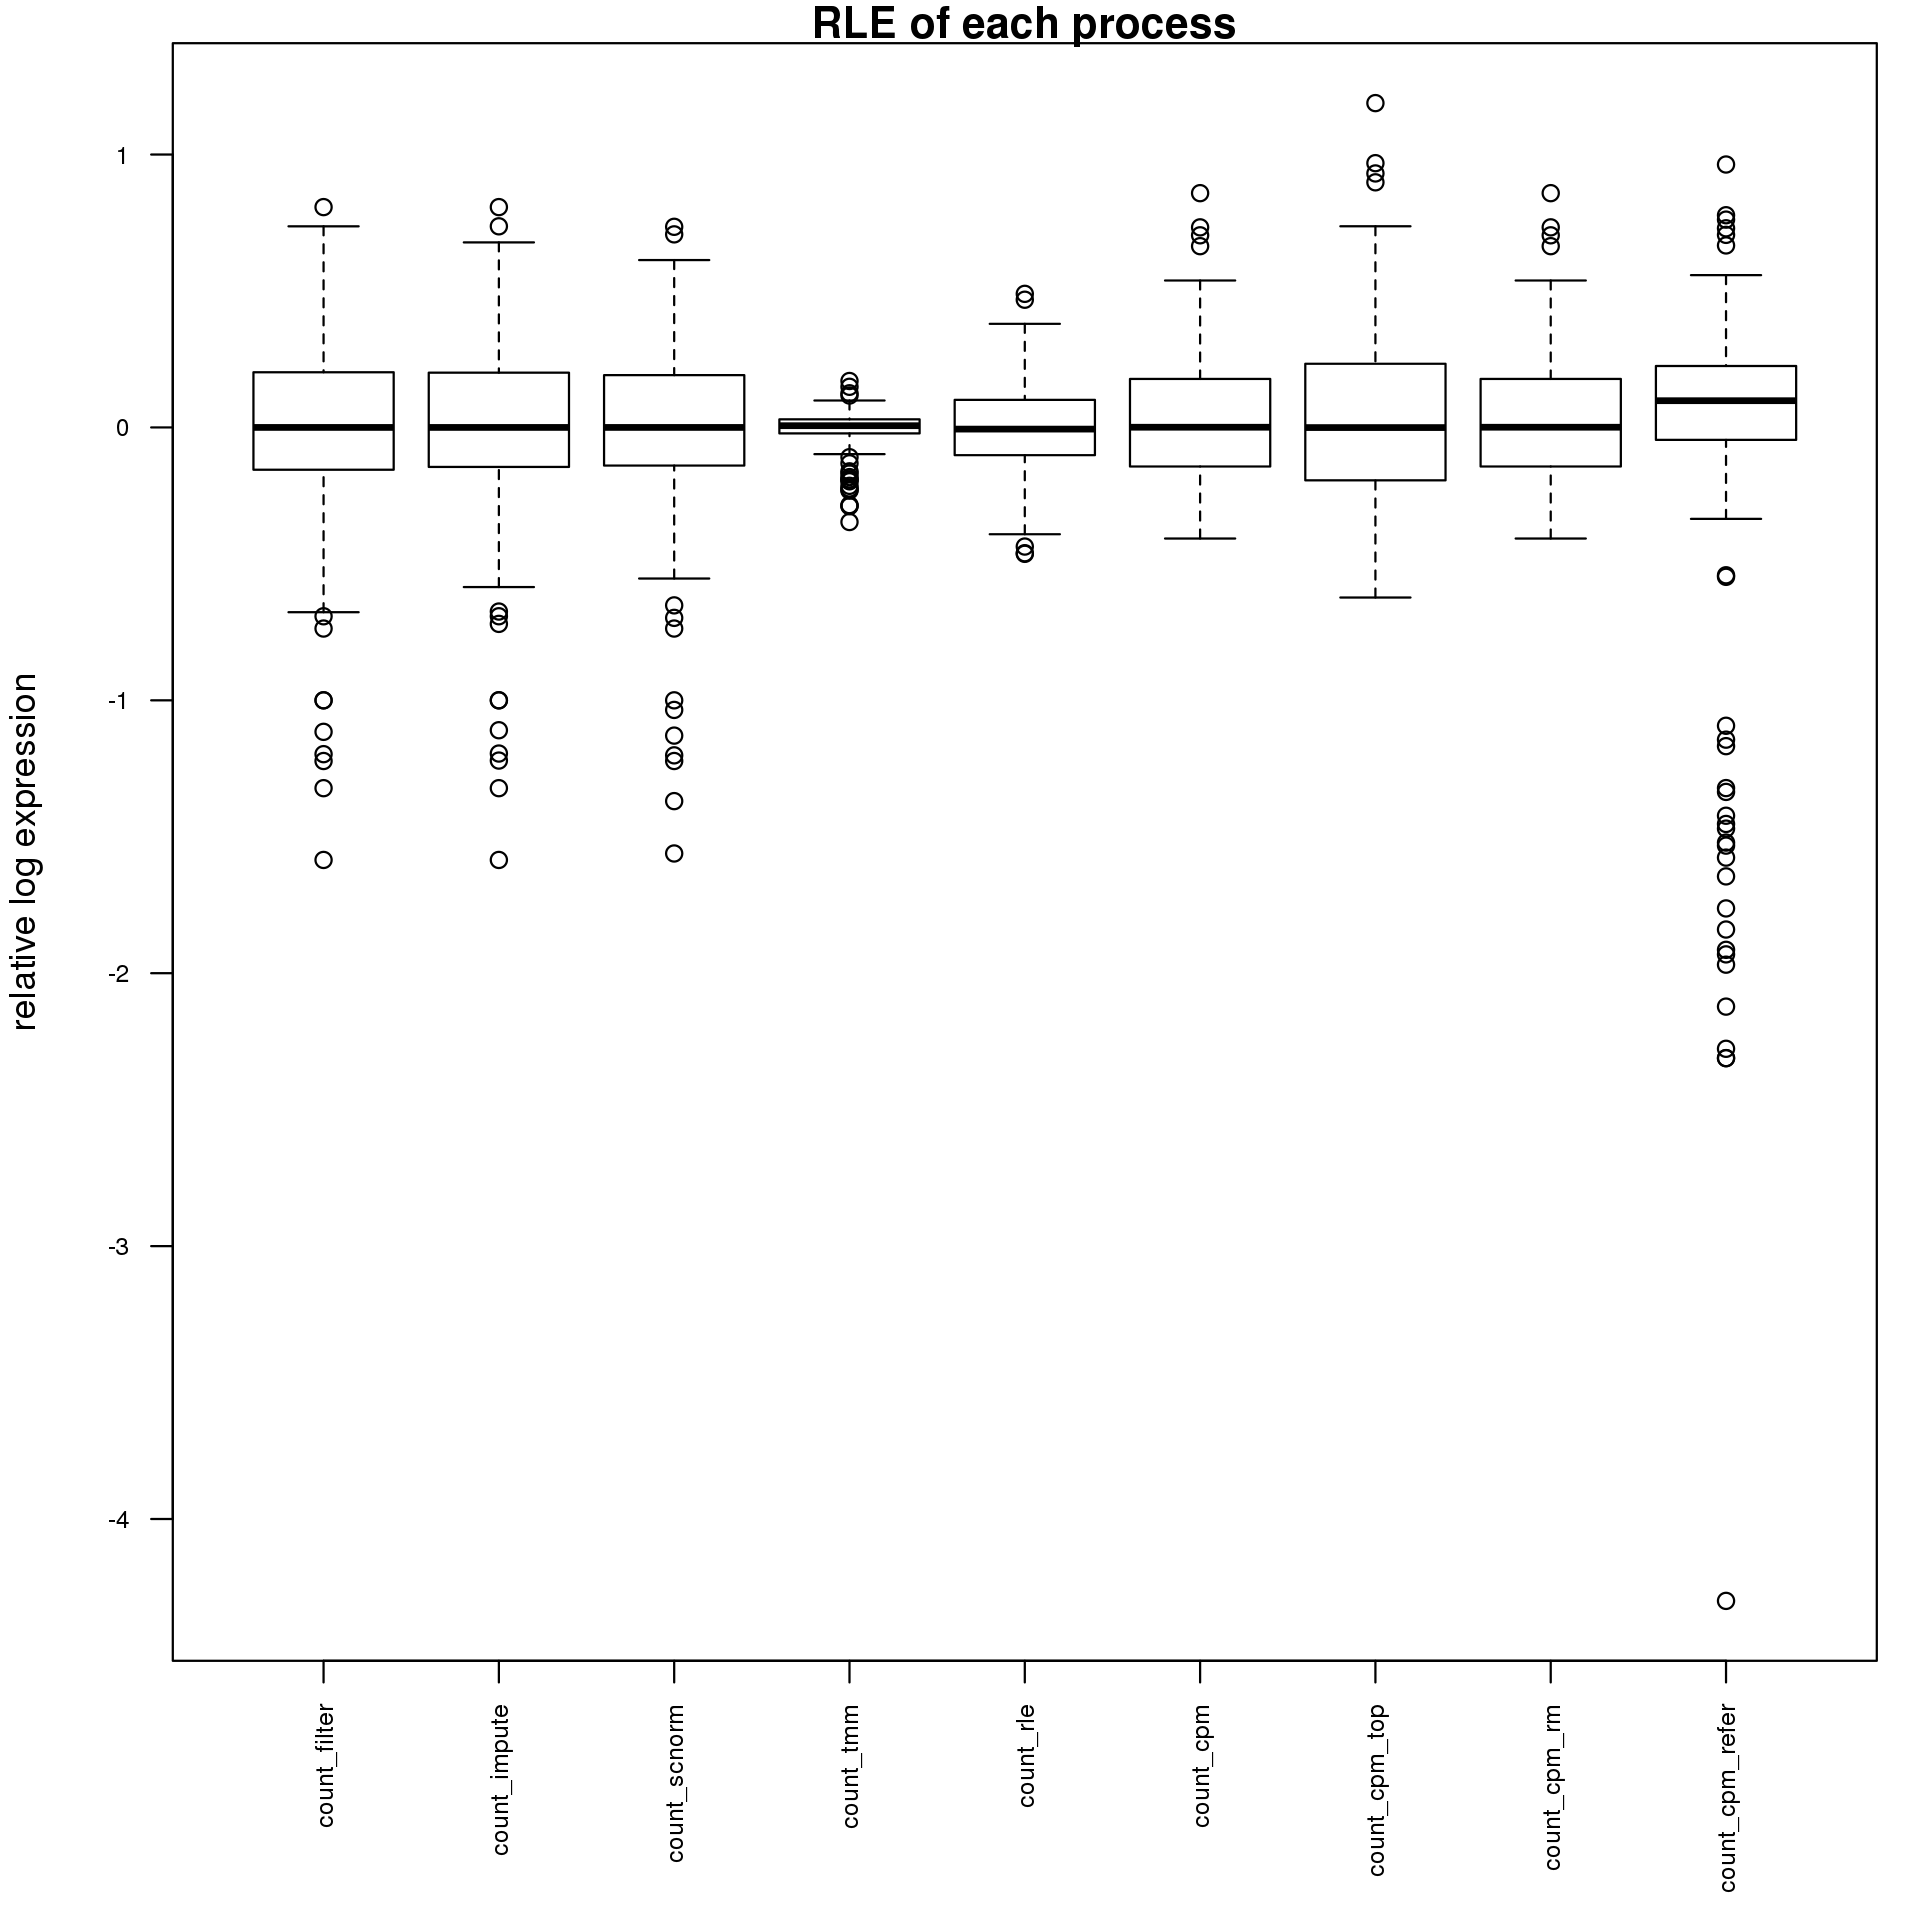

In [32]:
Image(filename='/home/xieyufeng/exSeek/pdf/RLE.png') 

## expression vs read depth

'cpm_top_count_depth'

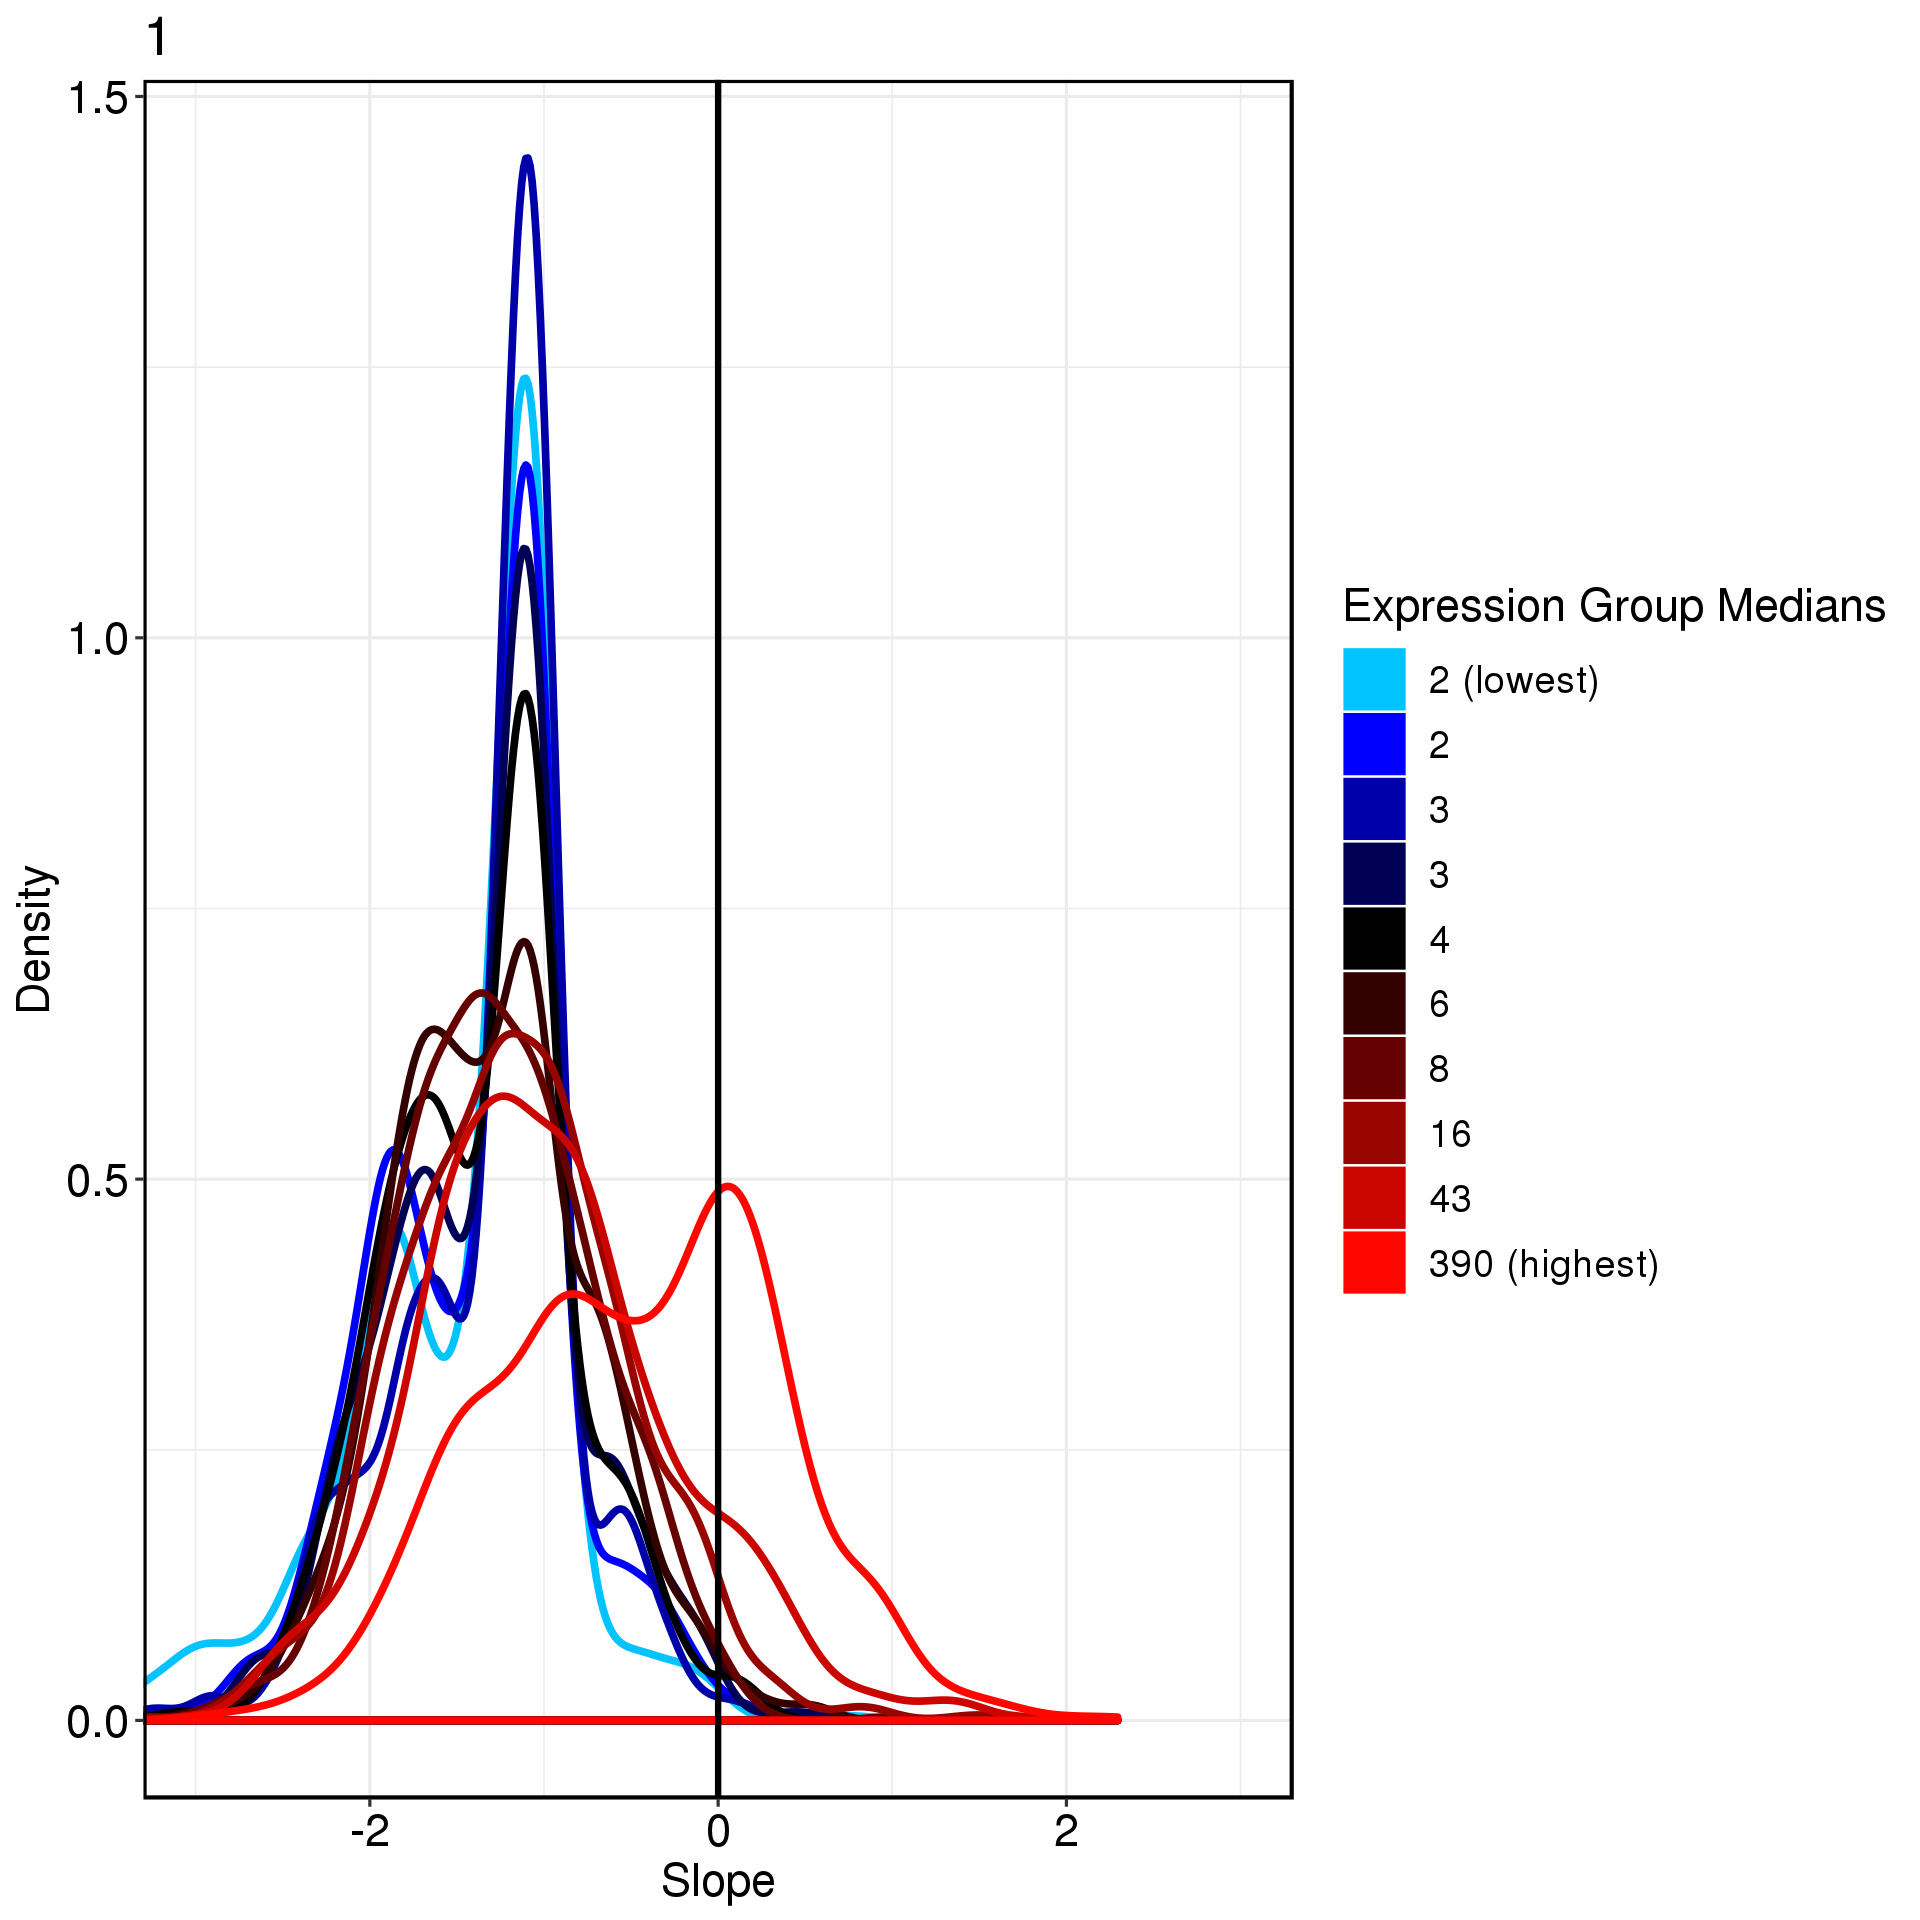

'cpm_refer_count_depth'

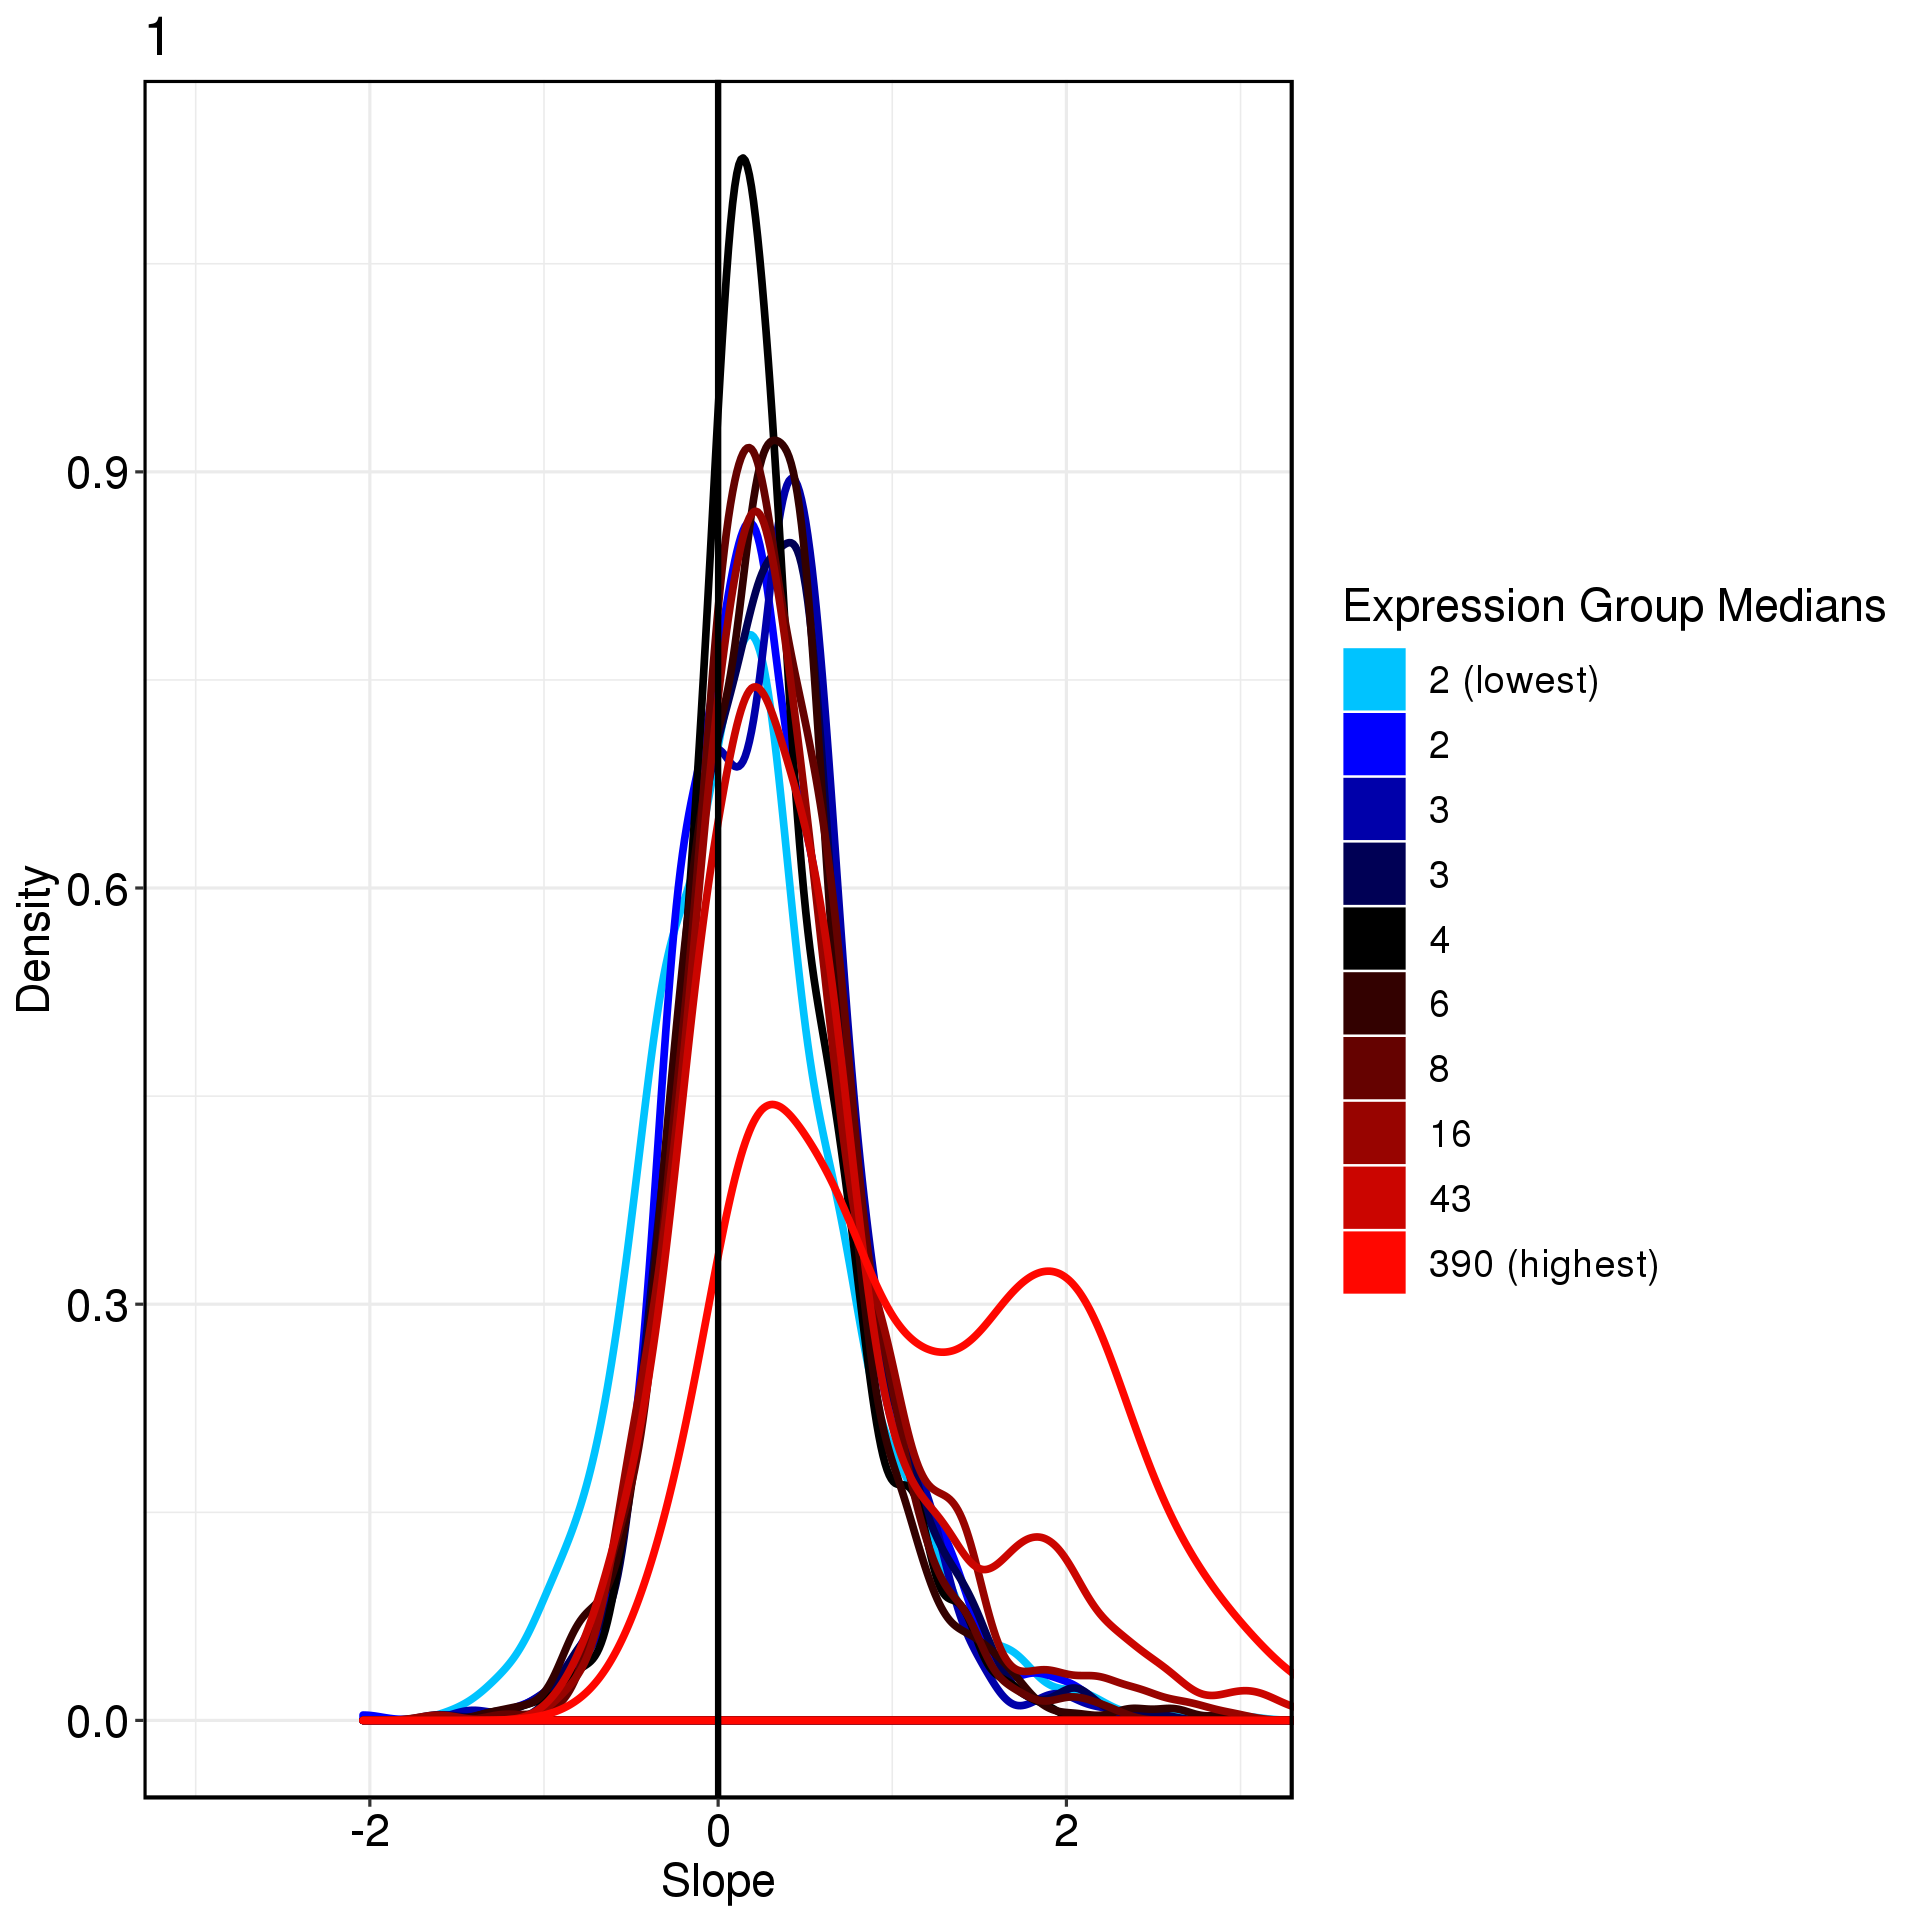

'rle_count_depth'

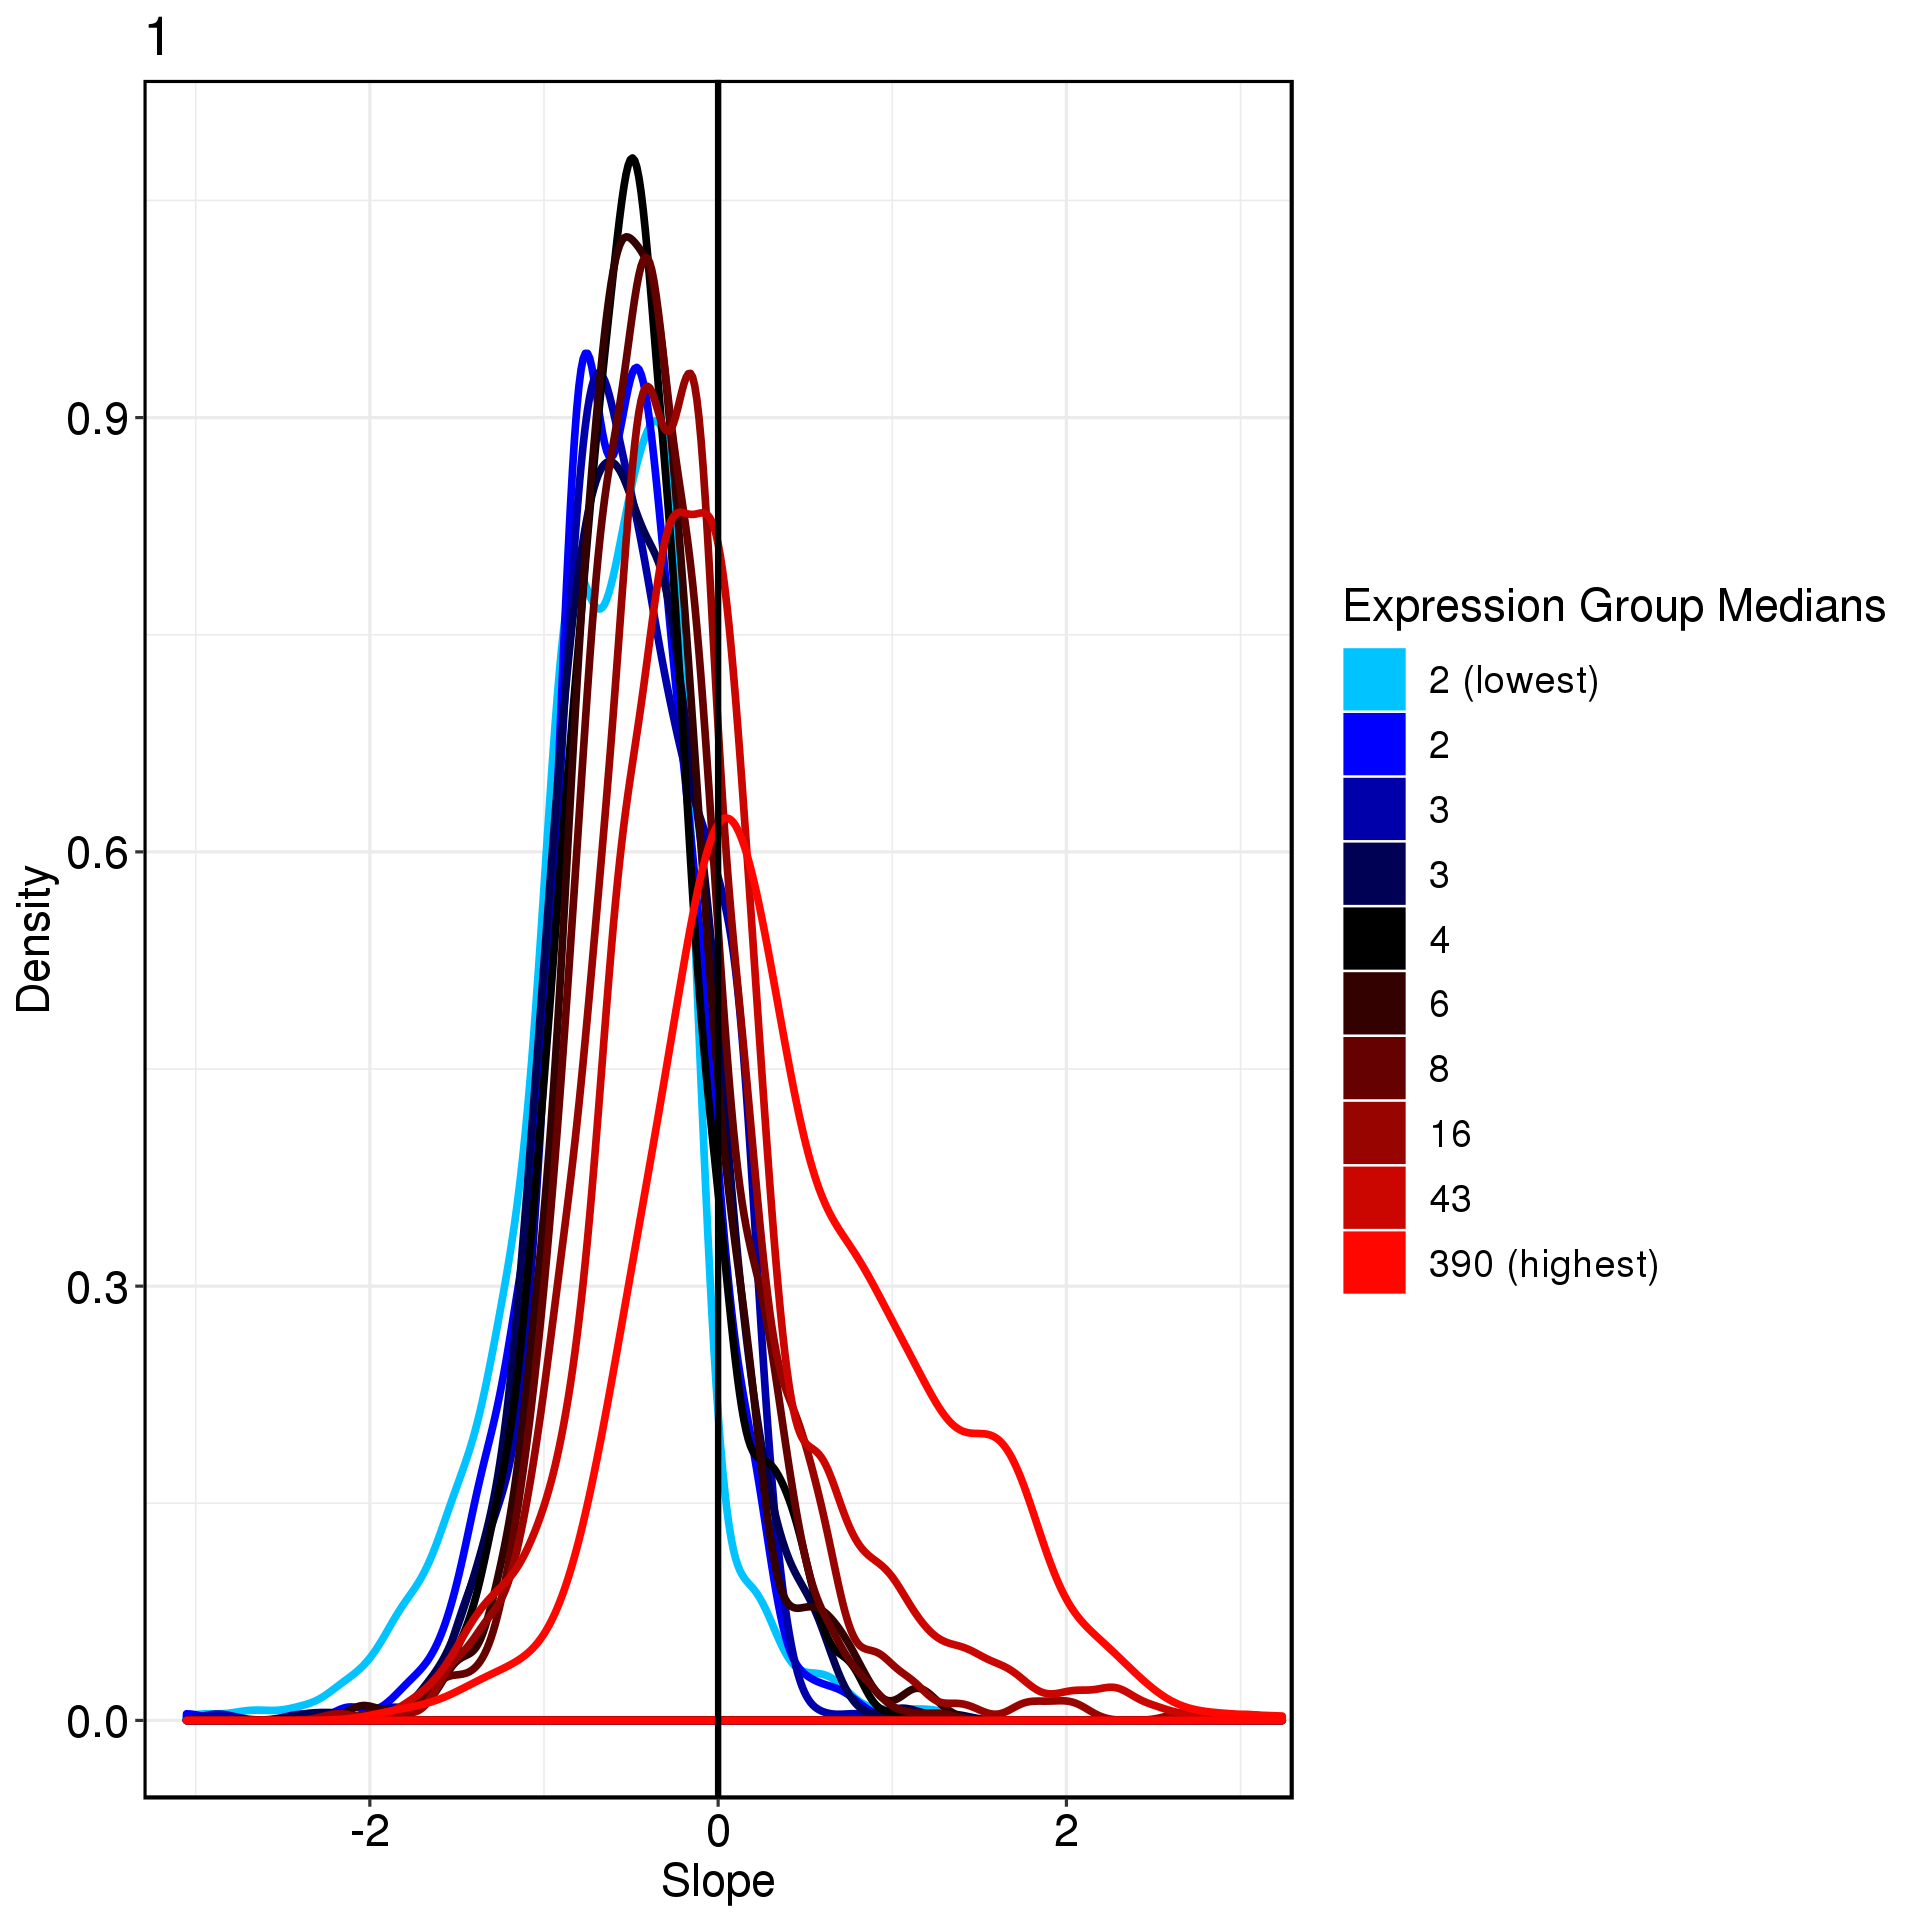

'cpm_count_depth'

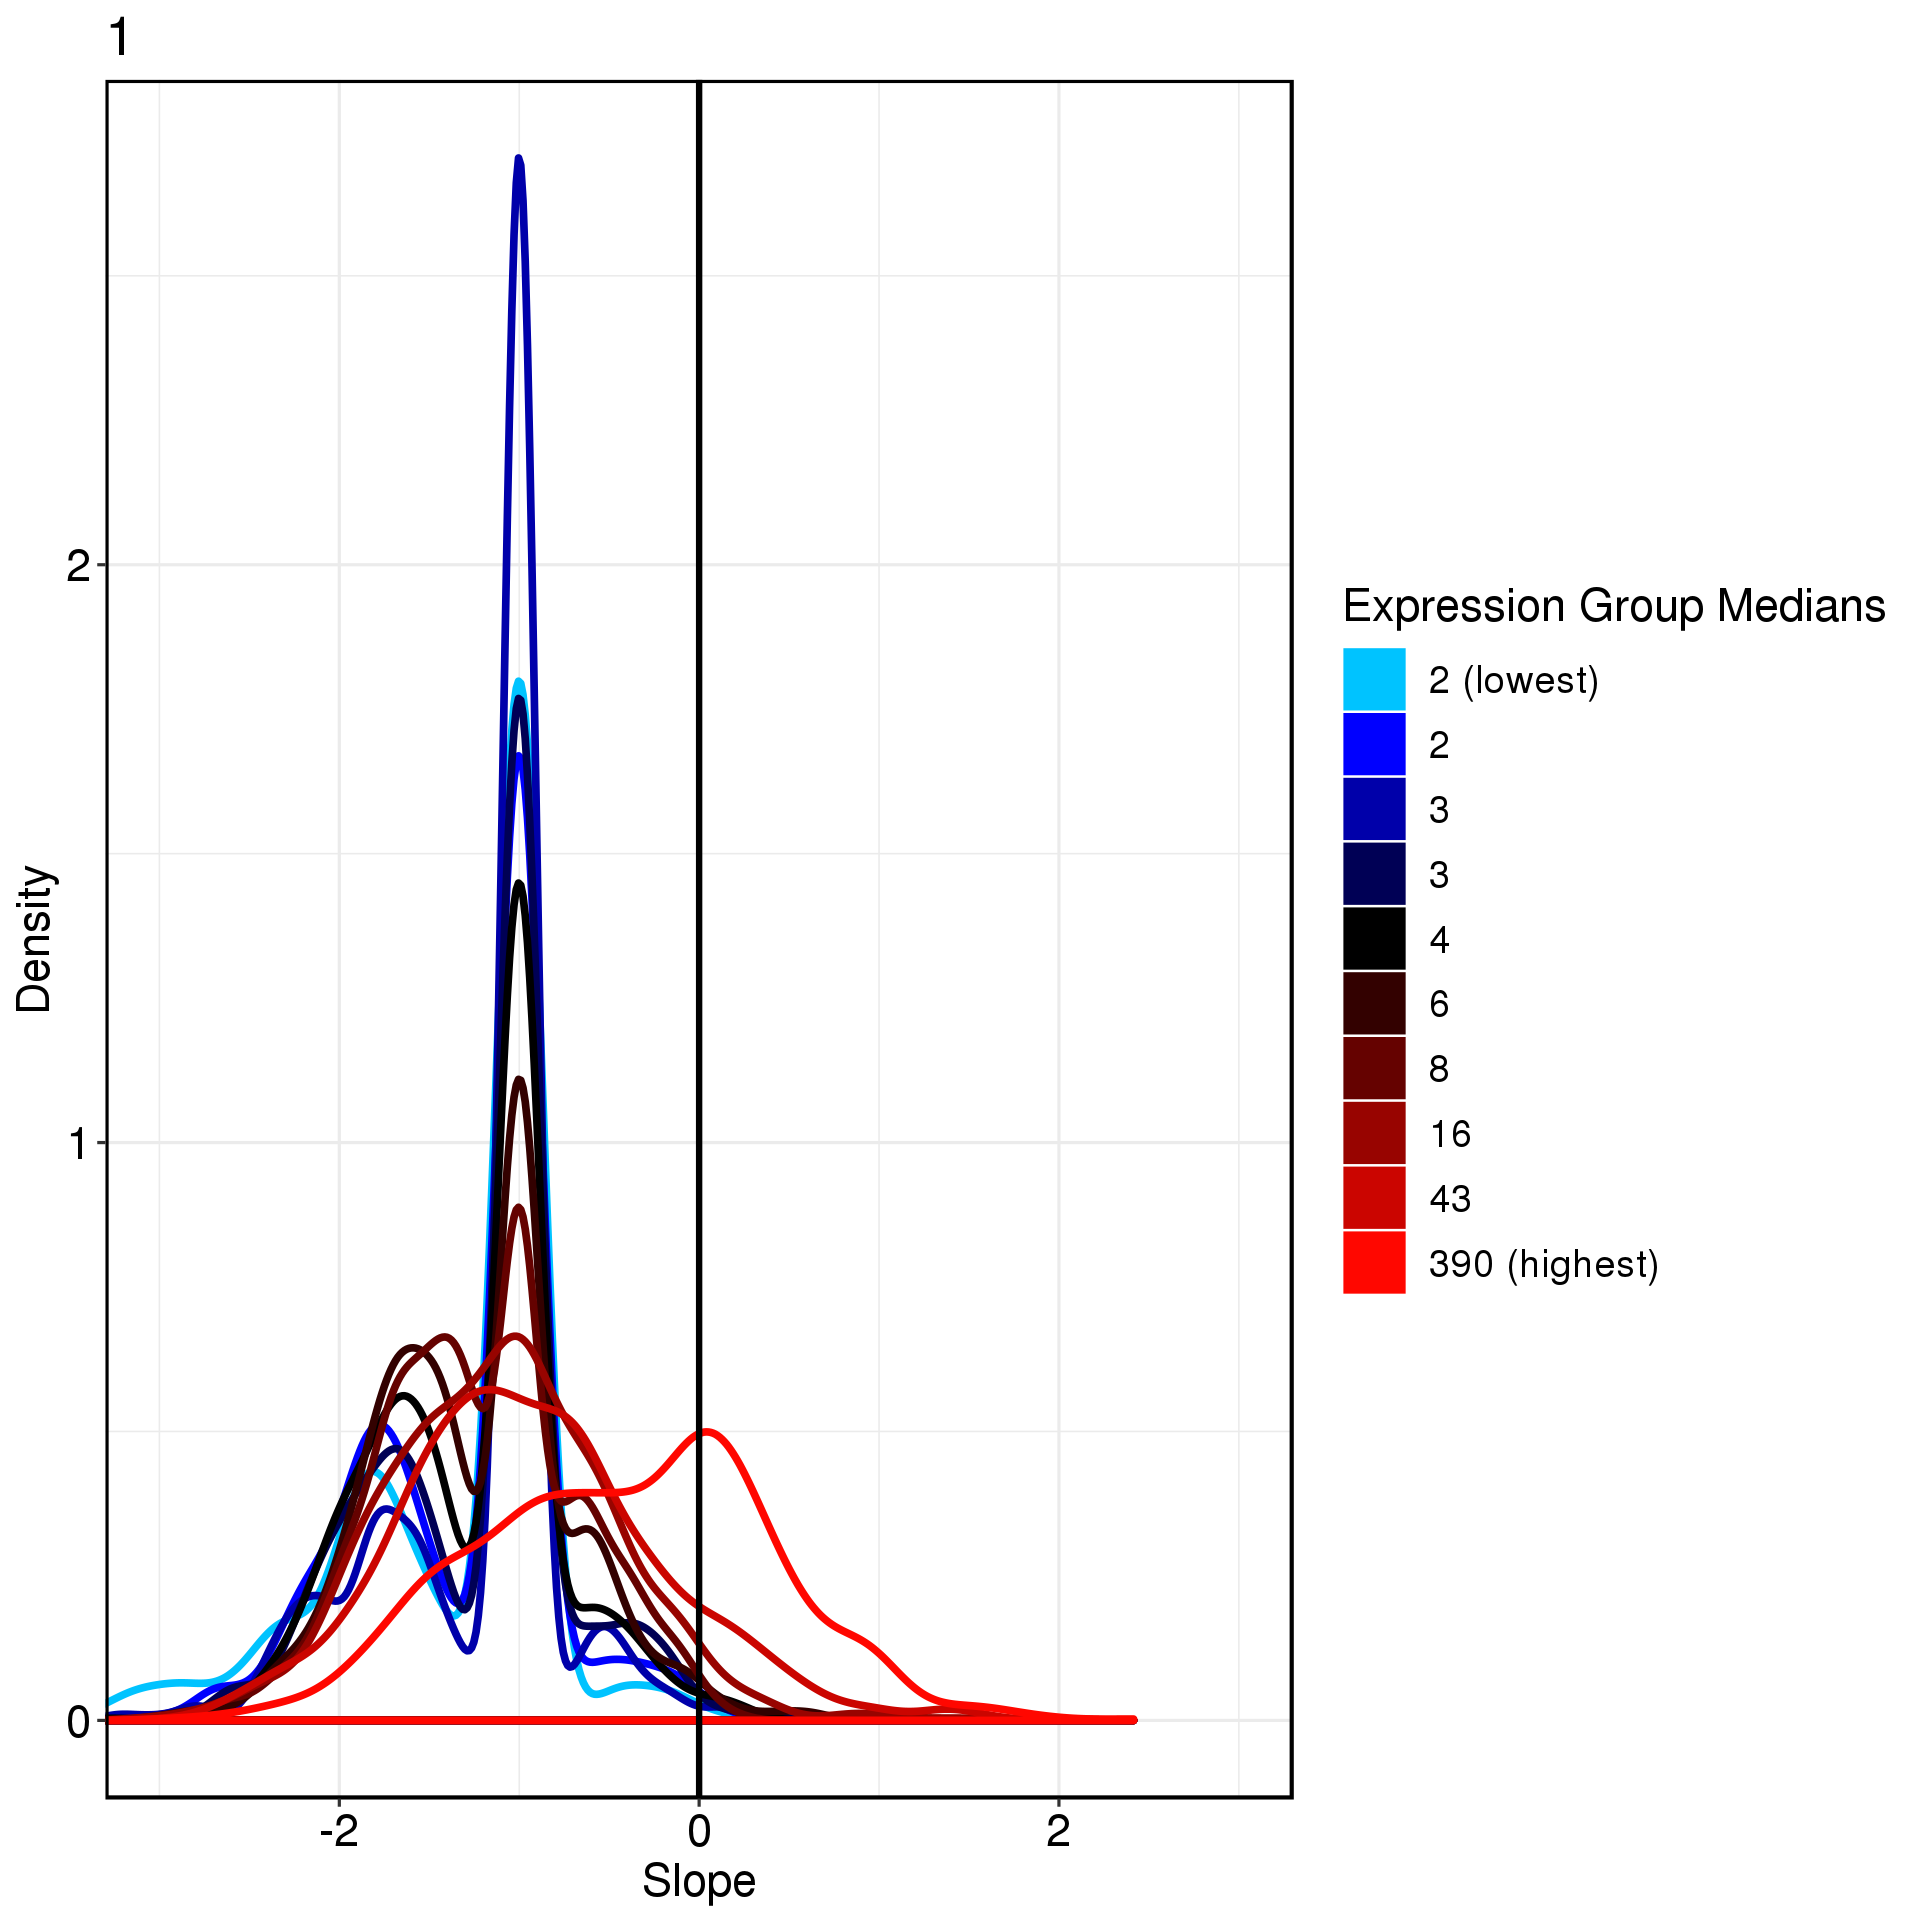

'cpm_rm_count_depth'

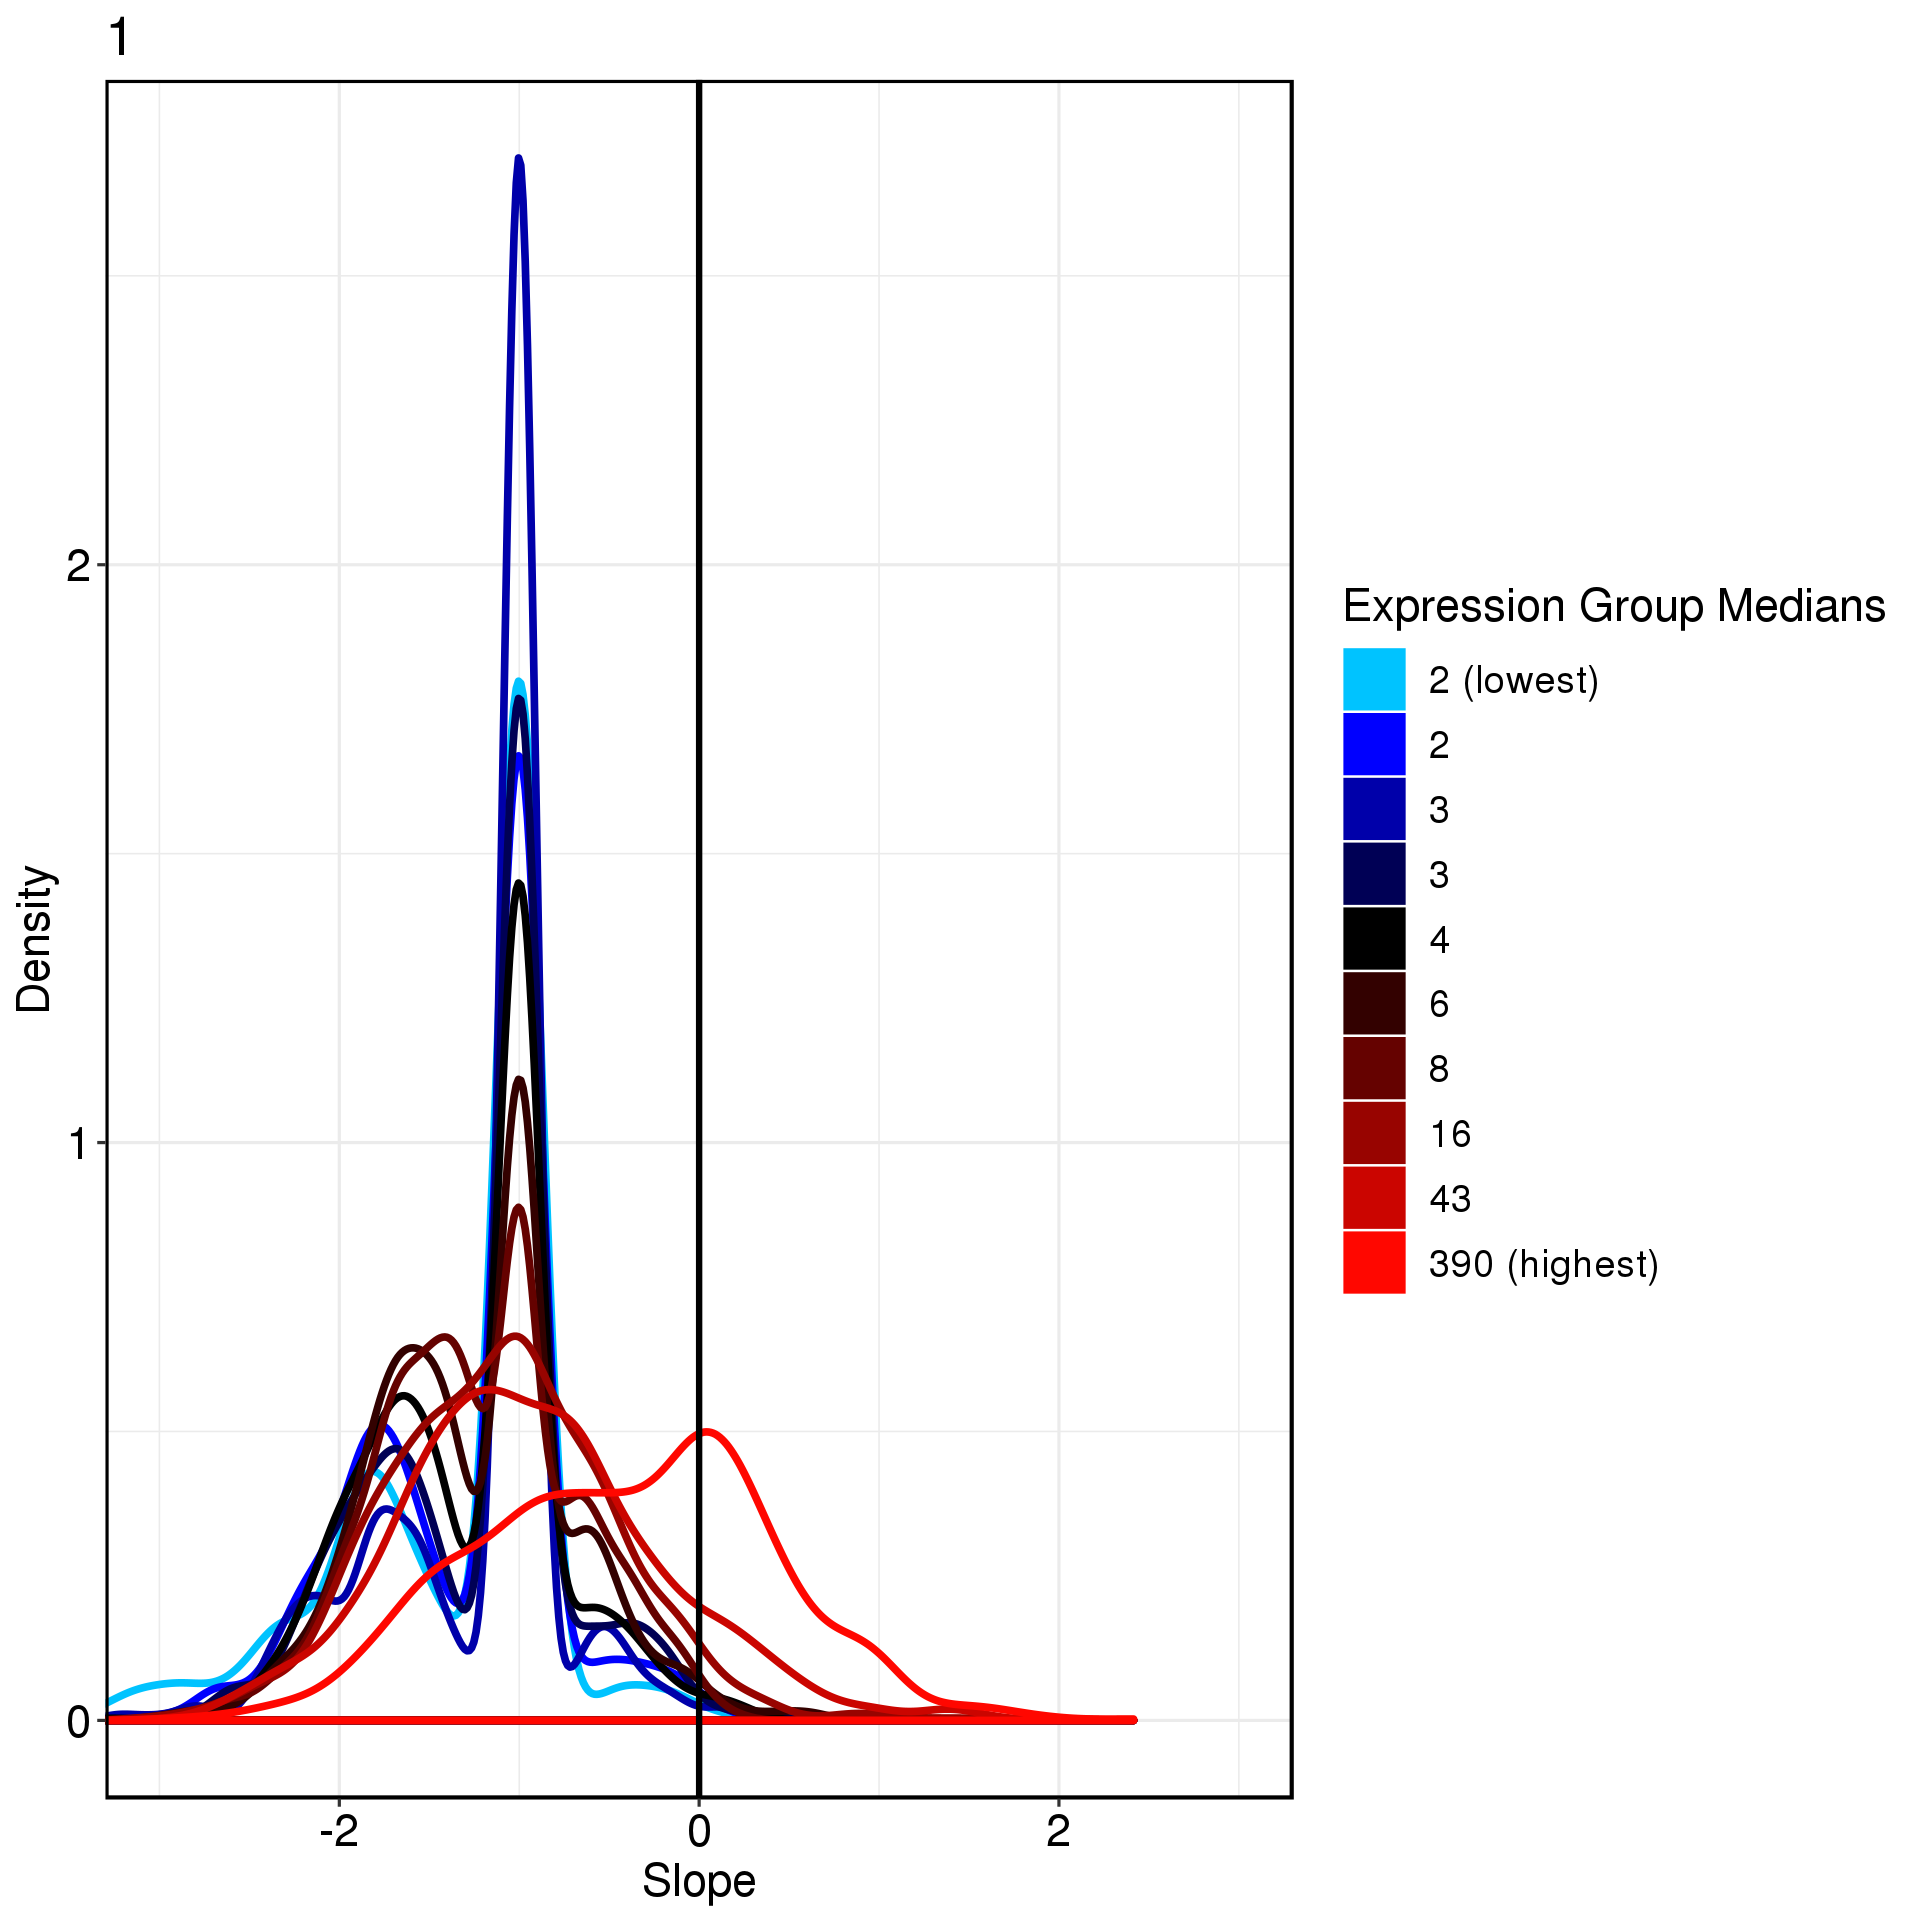

'impute_count_depth'

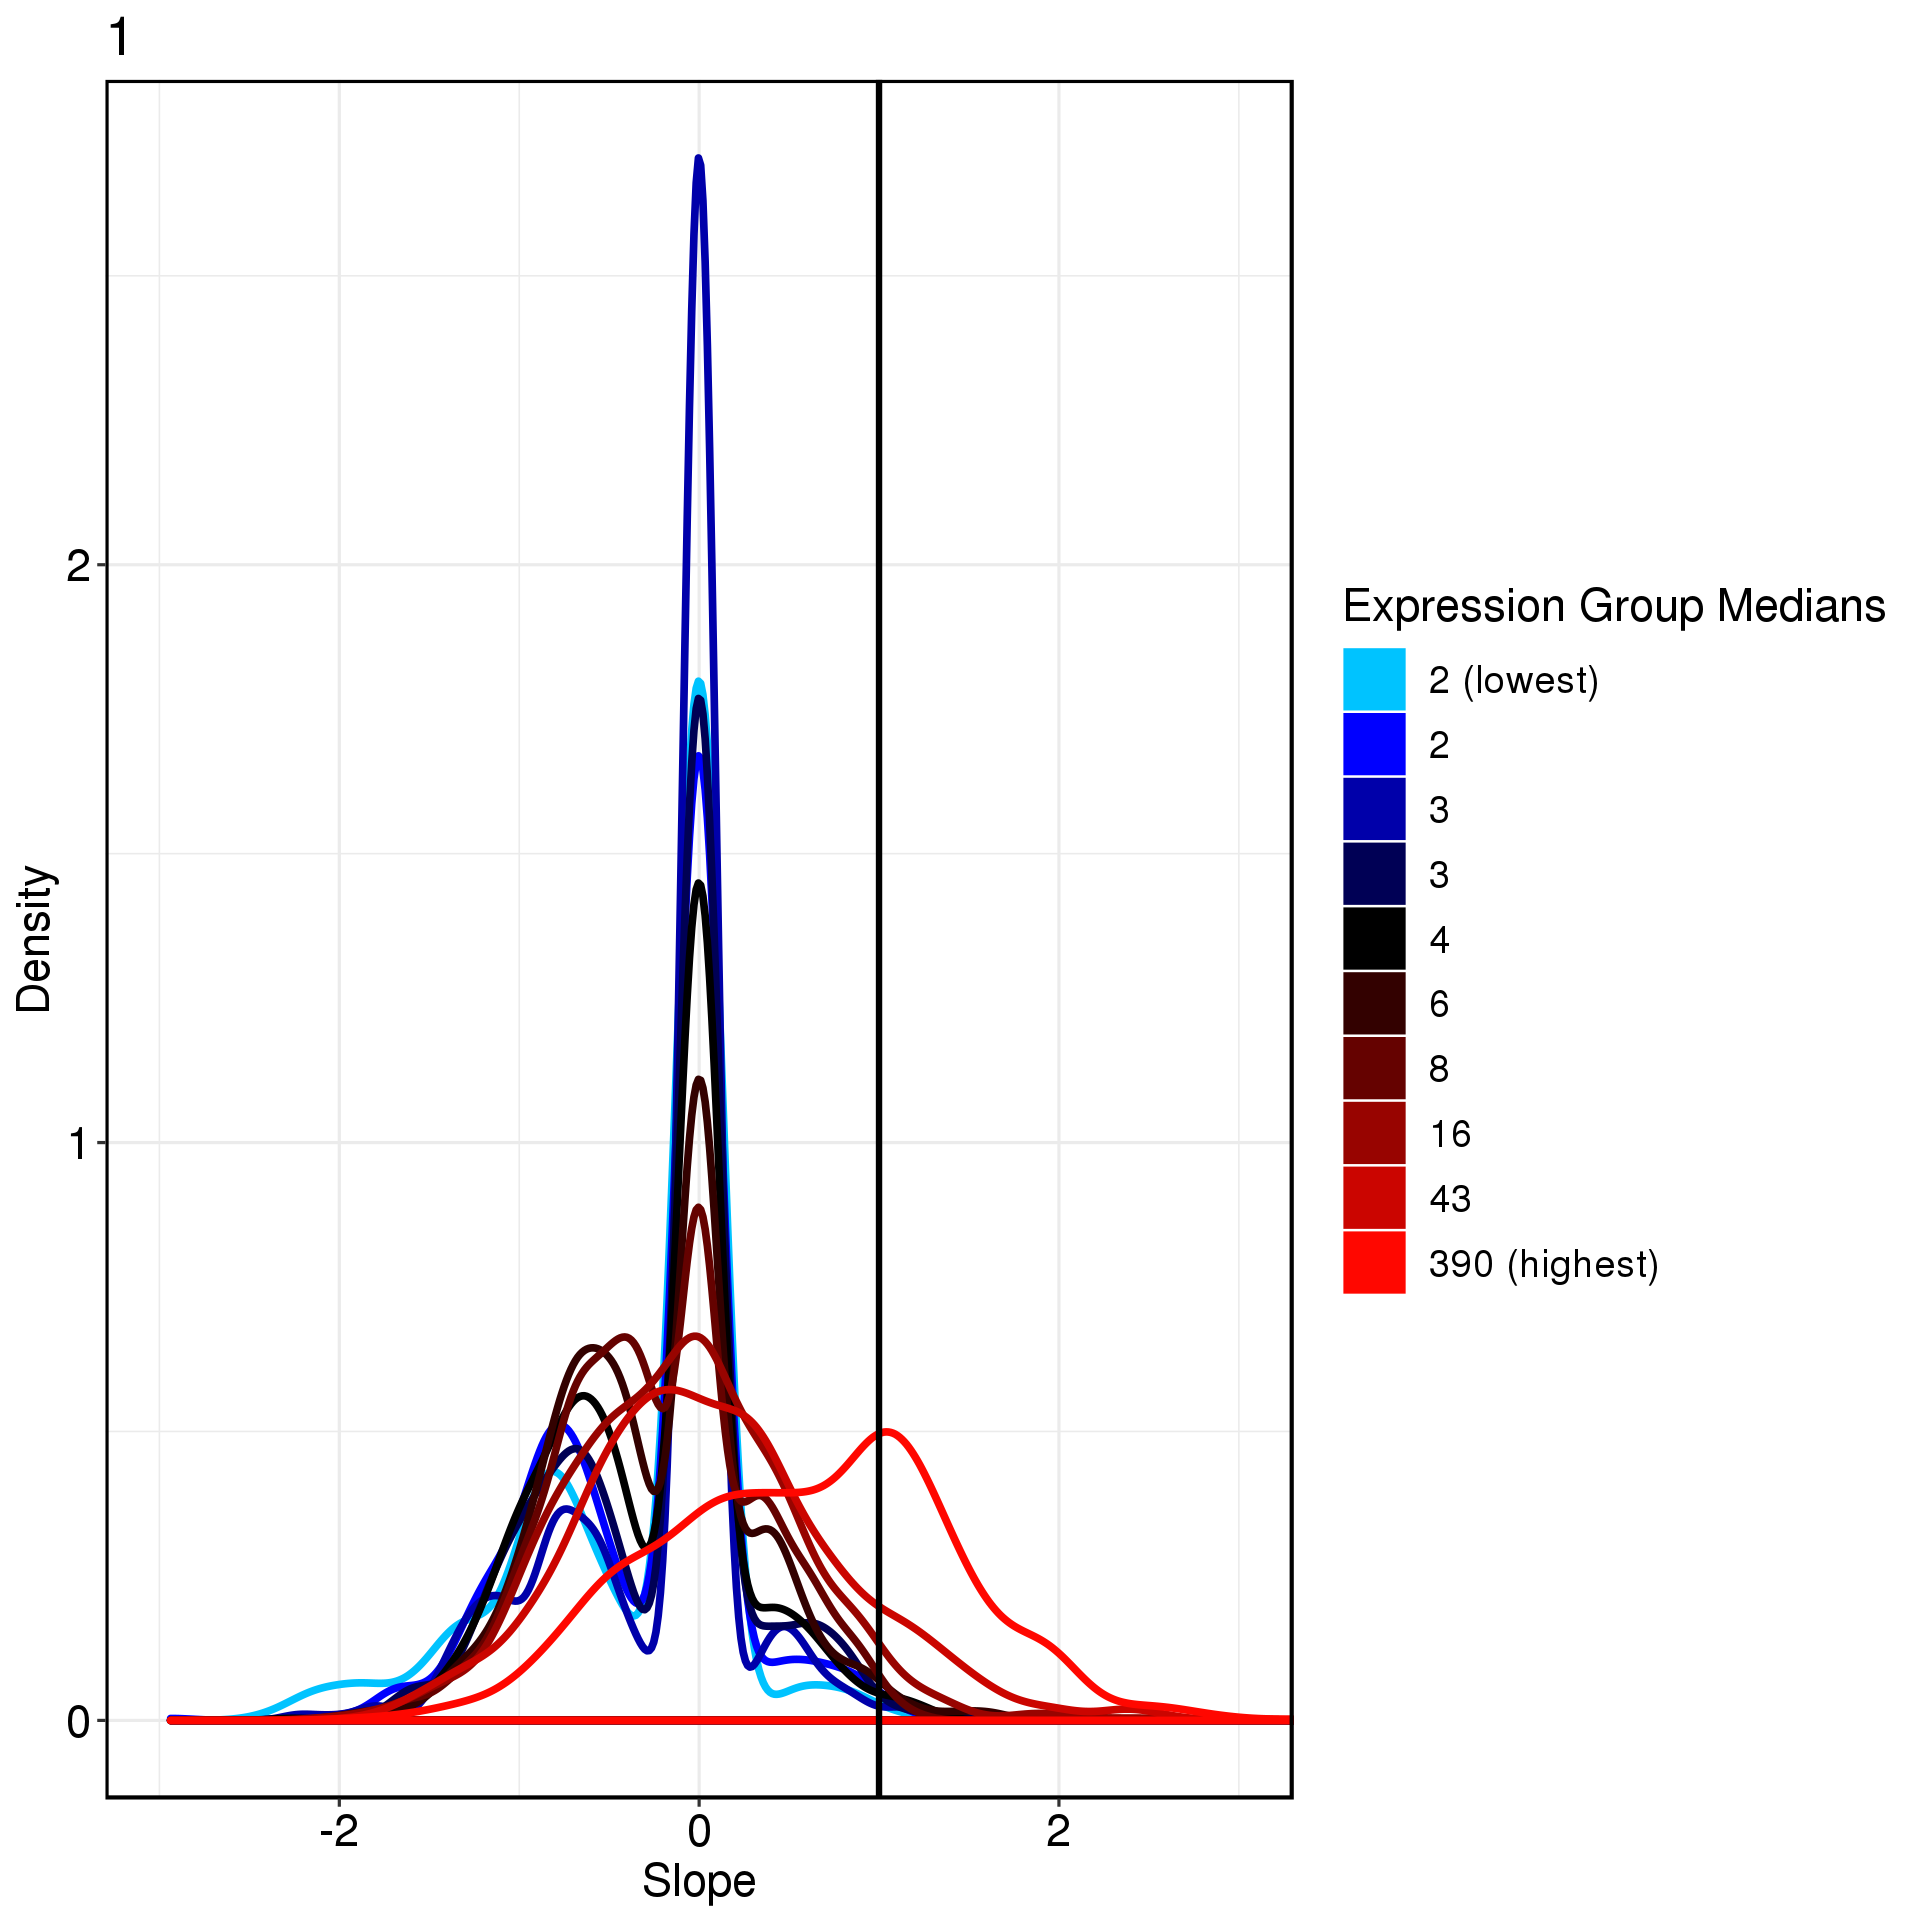

'tmm_count_depth'

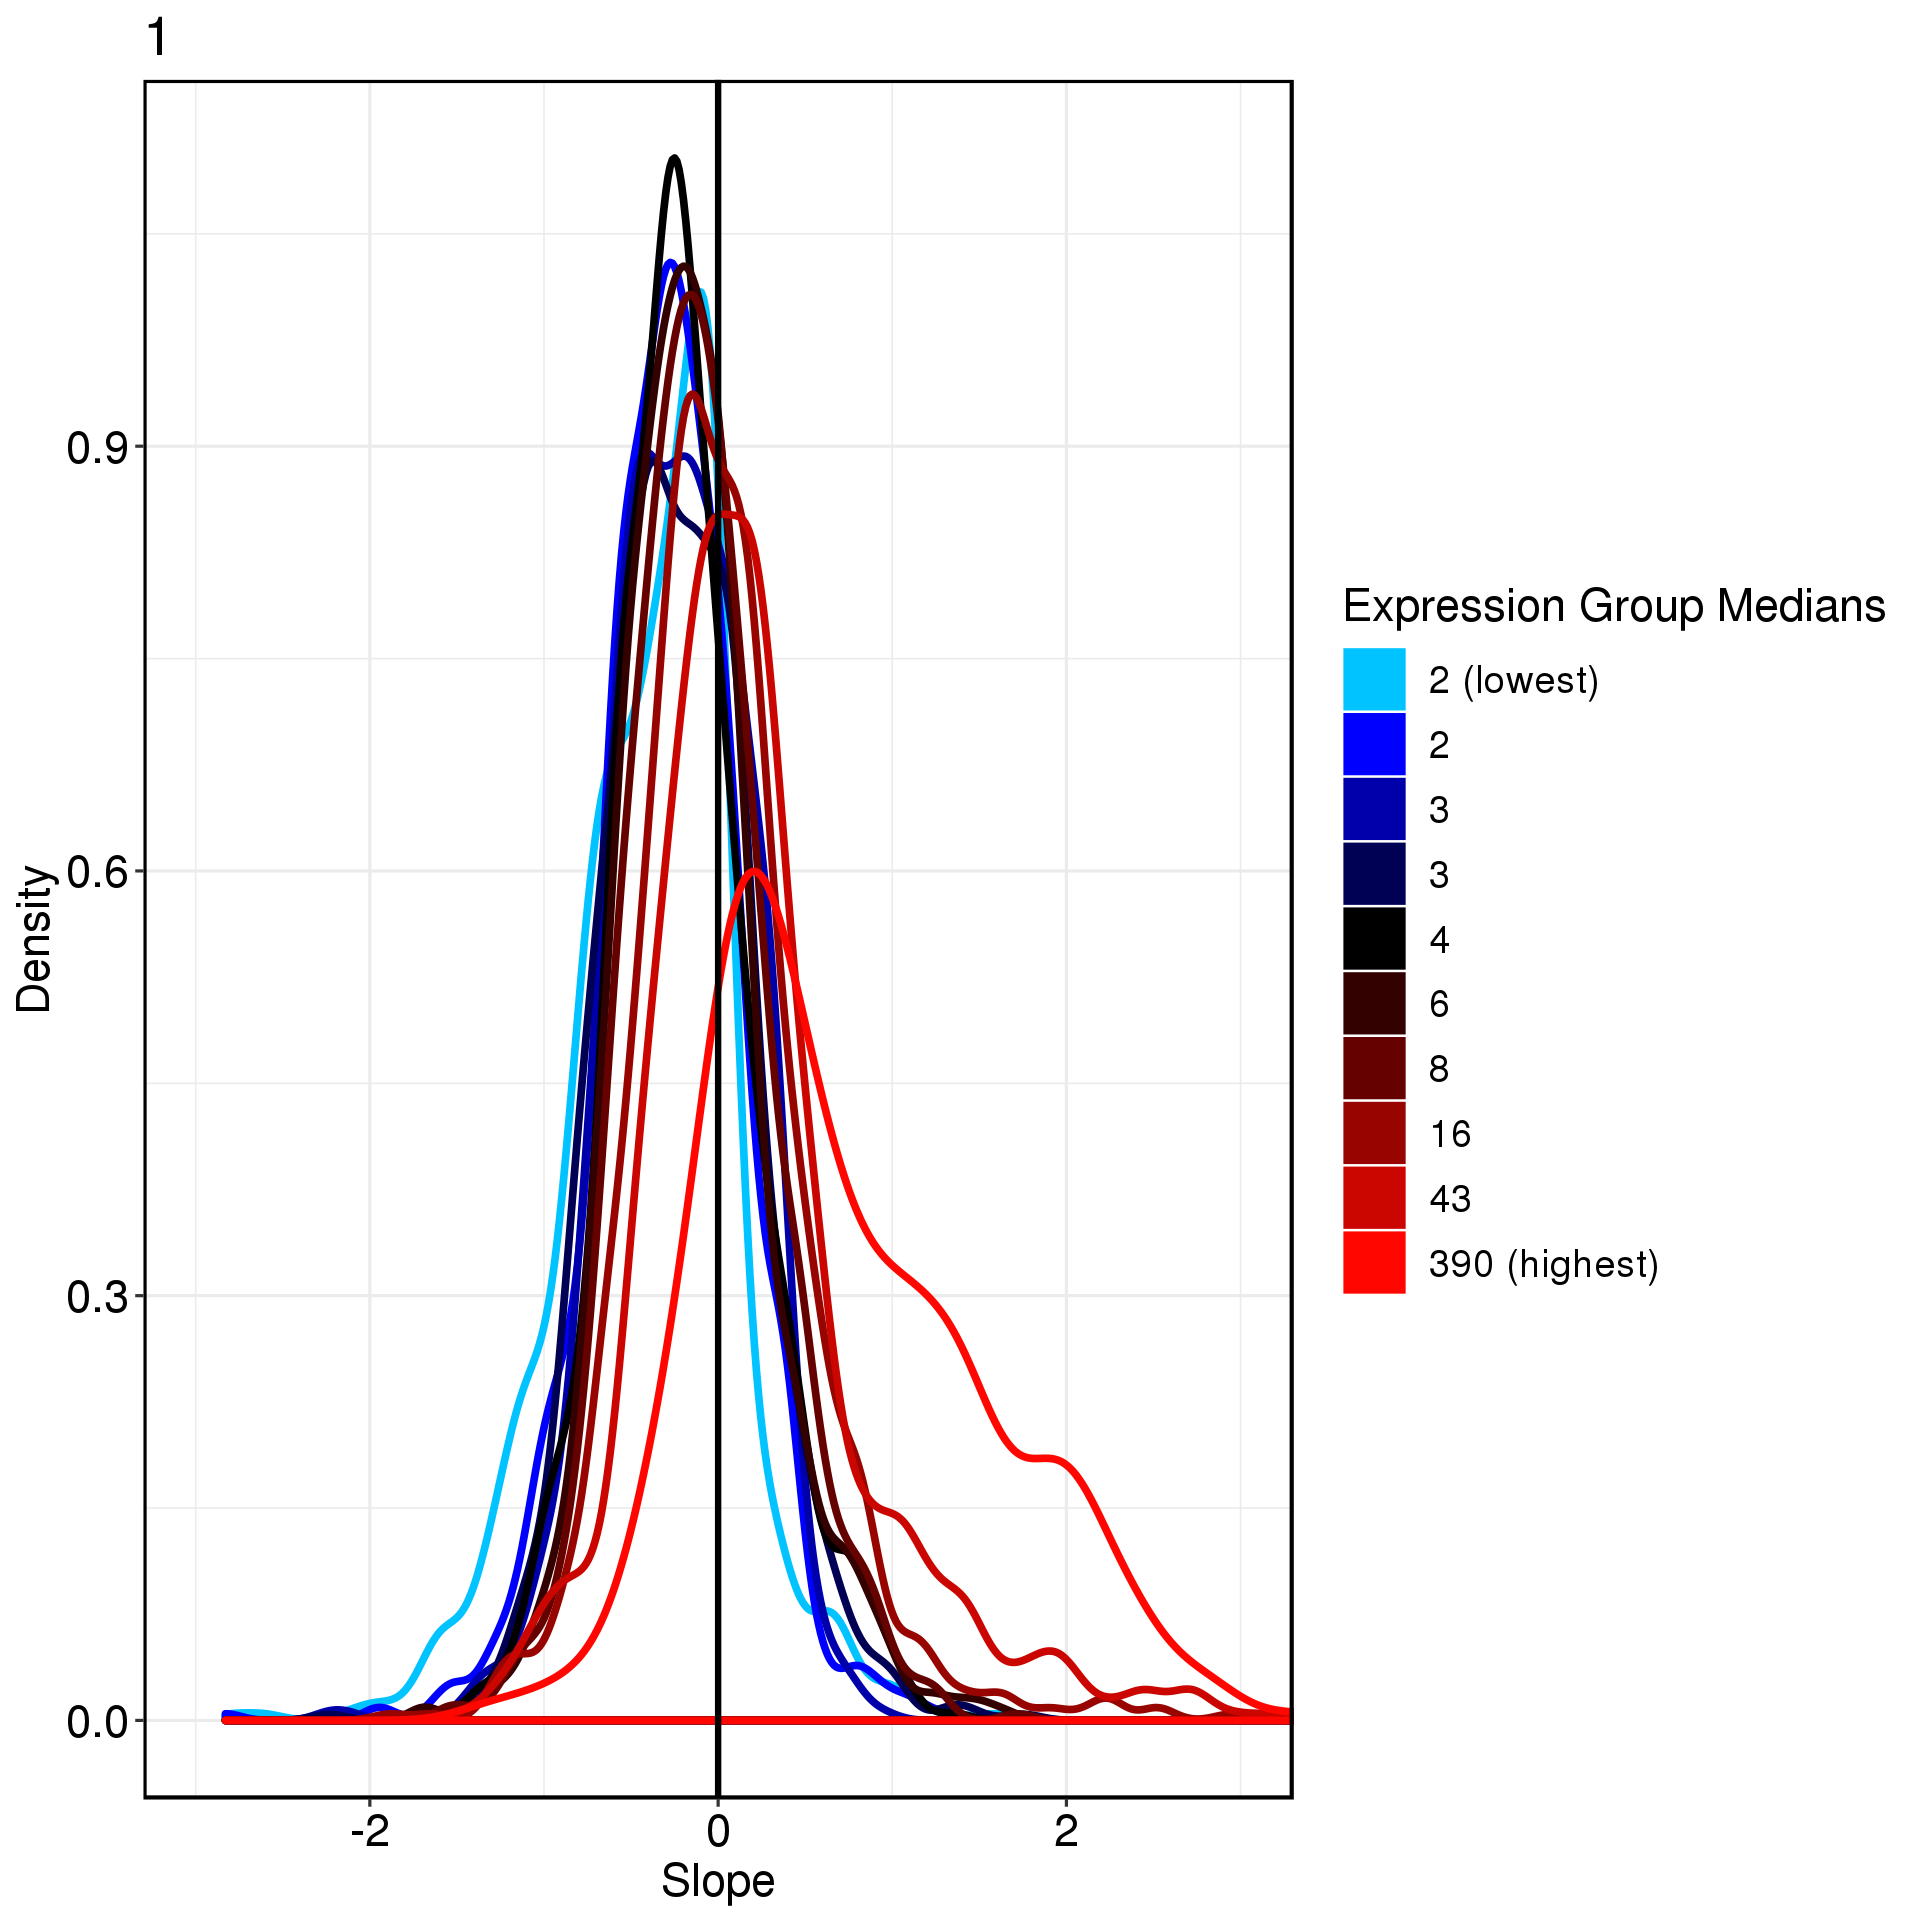

'scnorm_count_depth'

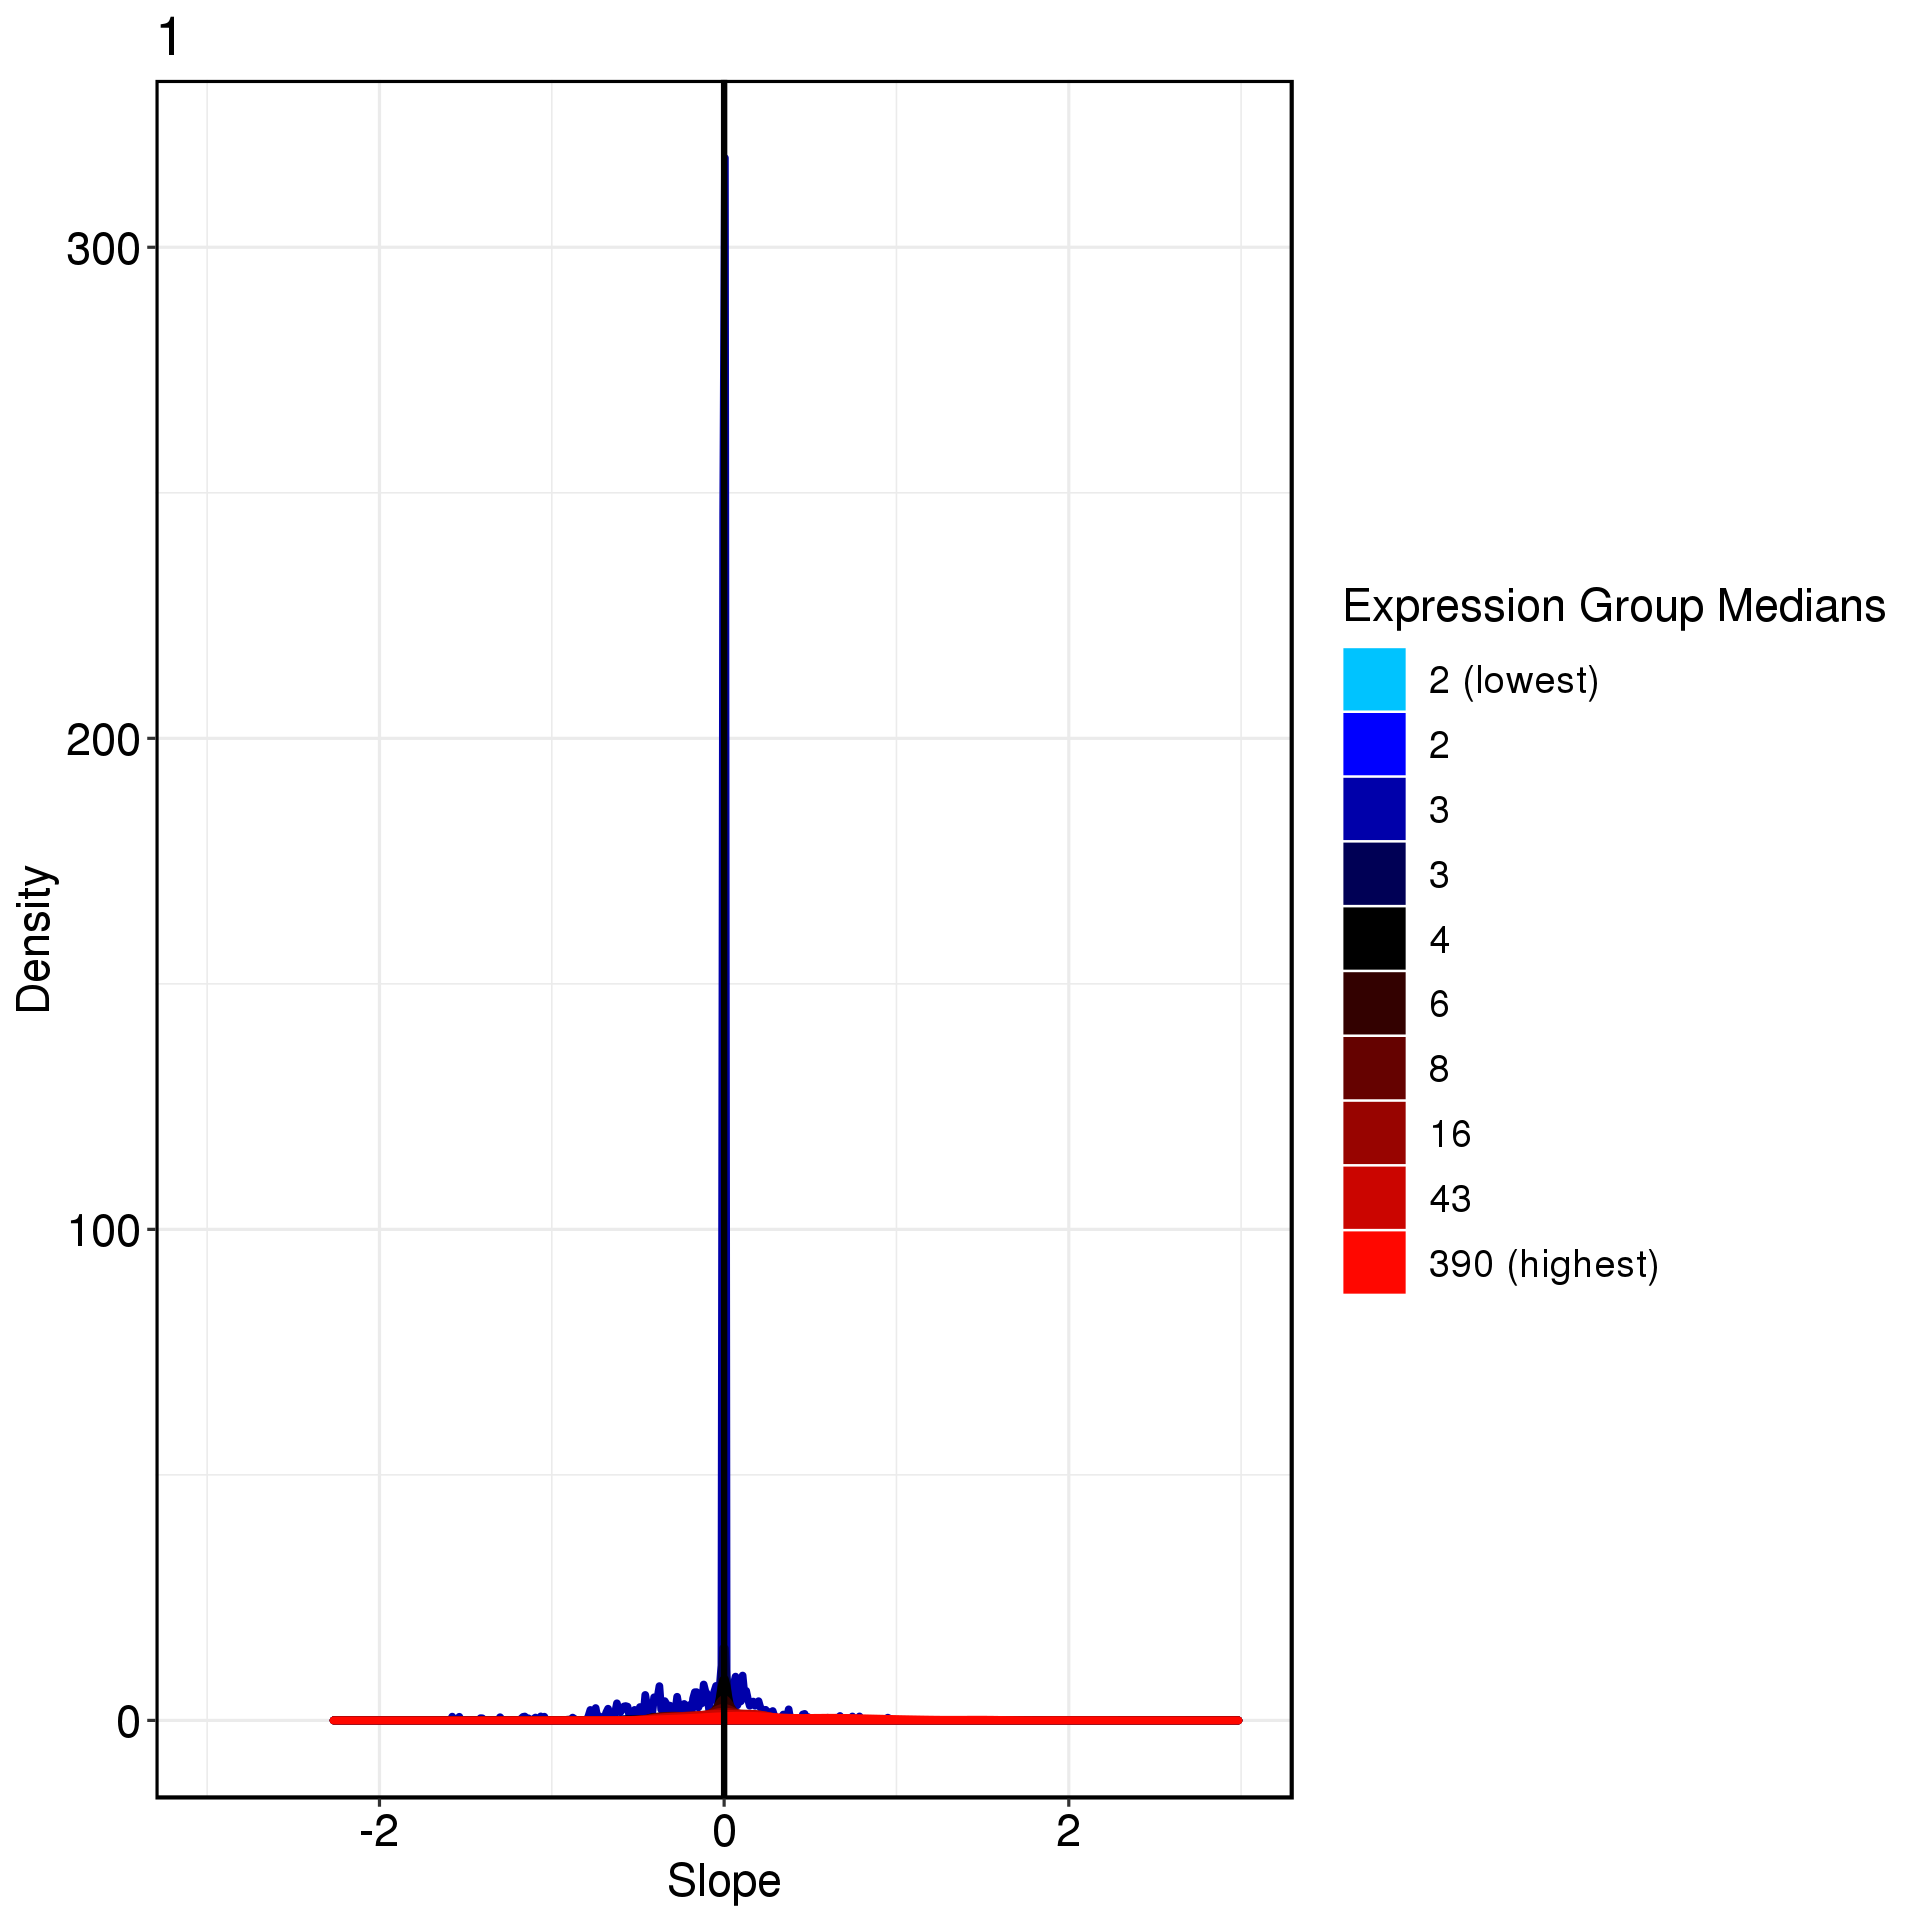

In [33]:
files = os.listdir('/home/xieyufeng/exSeek/pdf/')
selected_files = list(filter(lambda x: x.startswith('mat_'),files))
for i in selected_files:
    display (i.split('.')[0][4:])
    display(Image(filename='/home/xieyufeng/exSeek/pdf/'+i))

## PCA, tSNE and UMAP

In [34]:
def alignment_score(X, y, K=10):
    N = X.shape[0]
    nn = NearestNeighbors(K)
    nn.fit(X)
    distances, indices = nn.kneighbors(X, K + 1)
    neighbor_classes = np.take(y, indices[:, 1:])
    same_class_fractions = np.sum(neighbor_classes == y[:, np.newaxis], axis=1)
    score = 1.0 - (np.mean(same_class_fractions) - K/N)/(K - K/N)
    print (same_class_fractions.shape,np.mean(same_class_fractions),K/N,neighbor_classes)
    return score,


In [35]:
def knn_score(X, y, K=10):
    N = X.shape[0]
    assert K < N
    nn = NearestNeighbors(K)
    nn.fit(X)
    distances, indices = nn.kneighbors(X, K + 1)
    neighbor_classes = np.take(y, indices[:, 1:])
    same_class_fractions = np.sum(neighbor_classes == y[:, np.newaxis], axis=1)
    classes, counts = np.unique(y, return_counts=True)
    classes = np.argmax(y.reshape((-1, 1)) == classes.reshape((1, -1)), axis=1)
    counts = np.take(counts, classes)
    mean_r = K/(N - 1)*counts
    max_r = np.minimum(K, counts)
    #print (same_class_fractions.shape,mean_r.shape,max_r.shape)
    #scores = (np.mean(same_class_fractions) - mean_r)/(max_r - mean_r)
    scores = (same_class_fractions - mean_r)/(max_r - mean_r)
    #print(scores)
    return scores.mean()
def convert_label_to_int(sample_class):
    classes, counts = np.unique(sample_class, return_counts=True)
    classes = np.argmax(sample_class.reshape((-1, 1)) == classes.reshape((1, -1)), axis=1)
    return classes
def unsupervised_clustering_accuracy(y, y_pred):
    """
    Unsupervised Clustering Accuracy
    """
    from sklearn.utils.linear_assignment_ import linear_assignment
    assert len(y_pred) == len(y)
    u = np.unique(np.concatenate((y, y_pred)))
    n_clusters = len(u)
    mapping = dict(zip(u, range(n_clusters)))
    reward_matrix = np.zeros((n_clusters, n_clusters), dtype=np.int64)
    for y_pred_, y_ in zip(y_pred, y):
        if y_ in mapping:
            reward_matrix[mapping[y_pred_], mapping[y_]] += 1
    cost_matrix = reward_matrix.max() - reward_matrix
    ind = linear_assignment(cost_matrix)
    return sum([reward_matrix[i, j] for i, j in ind]) * 1.0 / y_pred.size, ind
def clustering_scores(X,y, prediction_algorithm='knn'):
    from sklearn.metrics import adjusted_rand_score as ARI
    from sklearn.metrics import normalized_mutual_info_score as NMI
    from sklearn.metrics import silhouette_score
    from sklearn.mixture import GaussianMixture as GMM
    from sklearn.cluster import KMeans
    
    cluster_num = np.unique(y).shape[0]
    if prediction_algorithm == 'knn':
        labels_pred = KMeans(cluster_num, n_init=200).fit_predict(X)  
    elif prediction_algorithm == 'gmm':
        gmm = GMM(cluster_num)
        gmm.fit(X)
        labels_pred = gmm.predict(X)
    labels = y
    asw_score = silhouette_score(X, labels)
    nmi_score = NMI(labels, labels_pred)
    ari_score = ARI(labels, labels_pred)
    labels_int = convert_label_to_int(labels)
    uca_score = unsupervised_clustering_accuracy(labels_int, labels_pred)[0]
    return asw_score, nmi_score, ari_score, uca_score

def get_clustering_score(data,sampleclass,method = 'PCA',prediction_algorithm='knn'):
    X = np.log2(data + 0.001).T
    X = StandardScaler().fit_transform(X)
    if method == 'PCA':
        transform = PCA()
    elif method == 'tSNE':
        transform = TSNE()
    elif method == 'UMAP':
        transform = umap.UMAP(n_neighbors=5,min_dist=0.3,metric='correlation')
    
    X_pca = transform.fit_transform(X)
    X_, y_ = X, sampleclass.loc[data.columns.values].values.ravel() 
    knn_score_ = knn_score(X_, y_)
    asw_score, nmi_score, ari_score, uca_score = clustering_scores(X_, y_, prediction_algorithm)
    return knn_score_,asw_score, nmi_score, ari_score, uca_score

## plot UCA score of different methods

In [38]:
def PCA_plot_with_alignment_score(ax,data,sampleclass,method = 'PCA'):
    X = np.log2(data + 0.001).T
    X = StandardScaler().fit_transform(X)
    if method == 'PCA':
        transform = PCA()
    elif method == 'tSNE':
        transform = TSNE()
    elif method == 'UMAP':
        transform = umap.UMAP(n_neighbors=5,min_dist=0.3,metric='correlation')
    X_pca = transform.fit_transform(X)
    class_name = np.unique(sampleclass.label)
    for label, color in zip(class_name, 
                                tableau20[:class_name.shape[0]]):
        indices = np.nonzero(sampleclass.loc[data.columns].label == label)[0]
        ax.scatter(X_pca[indices, 0], X_pca[indices, 1], s=200,alpha=0.8 ,edgecolors = 'b',label=label)
    ax.legend(fontsize=10)
    ax.set_title('Alignment score: {:.6f}'.format(knn_score(X_pca, sampleclass.loc[data.columns.values].values.ravel() )))
    print('Alignment score: {}'.format(knn_score(X_pca, sampleclass.loc[data.columns.values].values.ravel() )))
    return knn_score(X_pca, sampleclass.loc[data.columns.values].values.ravel() )

In [39]:
def visualize_effect(original_mx,processed_mx,sample_class,method='PCA'):
    fig, ax = plt.subplots(1,2,figsize=(16, 8))

    PCA_plot_with_alignment_score(ax[0],original_mx,sample_class,method)
    PCA_plot_with_alignment_score(ax[1],processed_mx,sample_class,method)

Alignment score: -0.060483402012771074
Alignment score: 0.13349345215830885


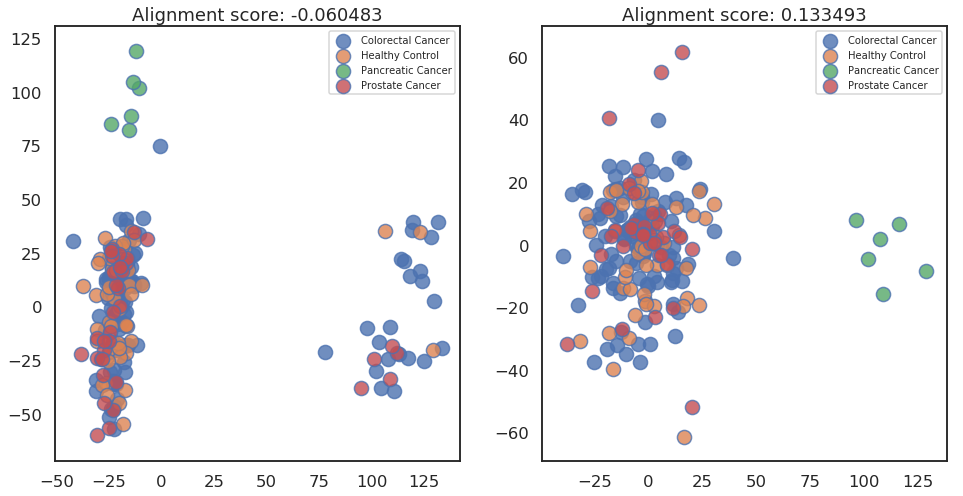

In [40]:
visualize_effect(original_mx,processed_mx,sample_class,method='PCA')

Alignment score: 0.11085427130654356
Alignment score: 0.1508934895125419


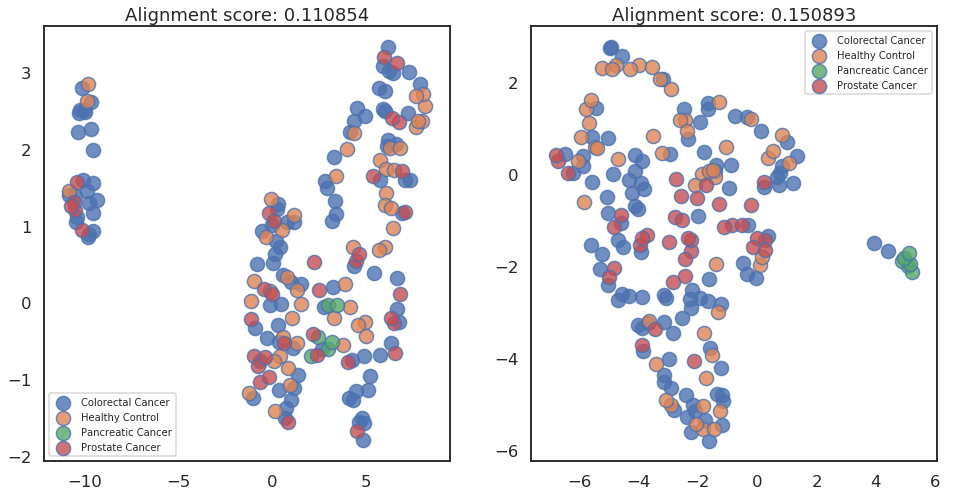

In [41]:
visualize_effect(original_mx,processed_mx,sample_class,method='UMAP')

Alignment score: 0.09680843121120013
Alignment score: 0.15942027522682758


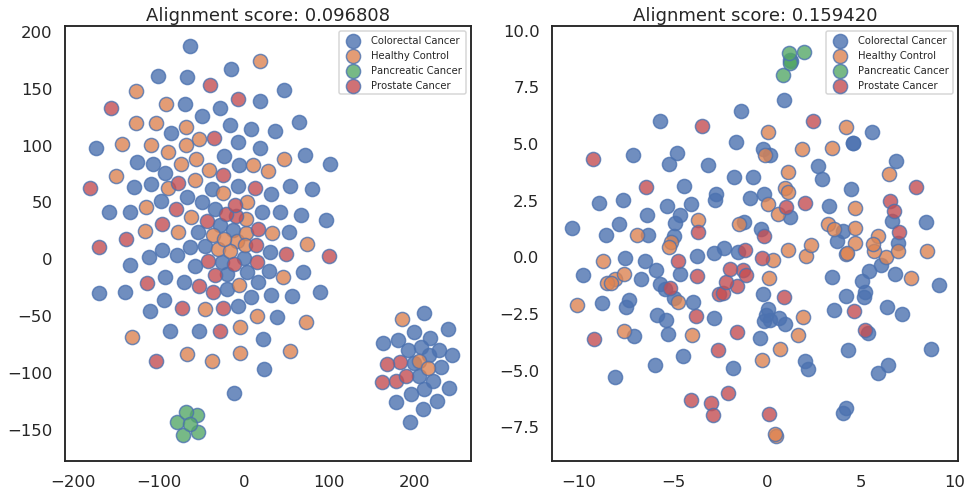

In [42]:
visualize_effect(original_mx,processed_mx,sample_class,method='tSNE')

In [43]:
impute_table = pd.read_table('output/scirep/matrix_processing/filter.scimpute_count.domains_combined.txt')
normalize_table = pd.read_table('output/scirep/matrix_processing/filter.scimpute_count.Norm_RLE.domains_combined.txt',index_col=0)
batch_table = pd.read_table('output/scirep/matrix_processing/filter.scimpute_count.Norm_RLE.Batch_Combat_1.domains_combined.txt',index_col=0)

In [44]:
def visualize_effect_all(original_mx,impute_mx, normalize_mx, batch_mx, sample_class,method='PCA'):
    fig, ax = plt.subplots(2,2,figsize=(16, 16))
    PCA_plot_with_alignment_score(ax[0,0],original_mx,sample_class,method)
    PCA_plot_with_alignment_score(ax[0,1],impute_mx,sample_class,method)
    PCA_plot_with_alignment_score(ax[1,0],normalize_mx,sample_class,method)
    PCA_plot_with_alignment_score(ax[1,1],batch_mx,sample_class,method)

Alignment score: -0.060483402012771074
Alignment score: 0.15565305147311617
Alignment score: 0.1273388925351043
Alignment score: 0.09787221504745051


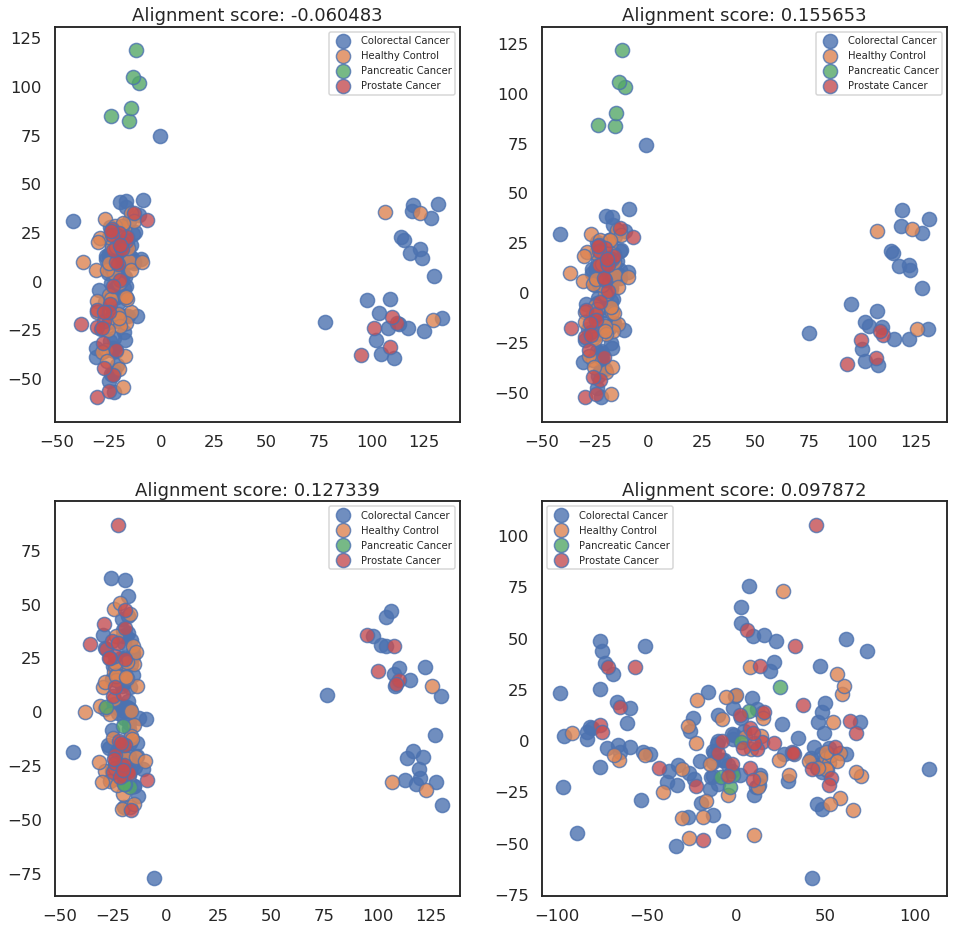

In [45]:
visualize_effect_all(original_mx, impute_table, normalize_table, batch_table, sample_class,method='PCA')

Alignment score: 0.05589037389579379
Alignment score: 0.14936554177298636
Alignment score: 0.08655882566622704
Alignment score: 0.05730304421789876


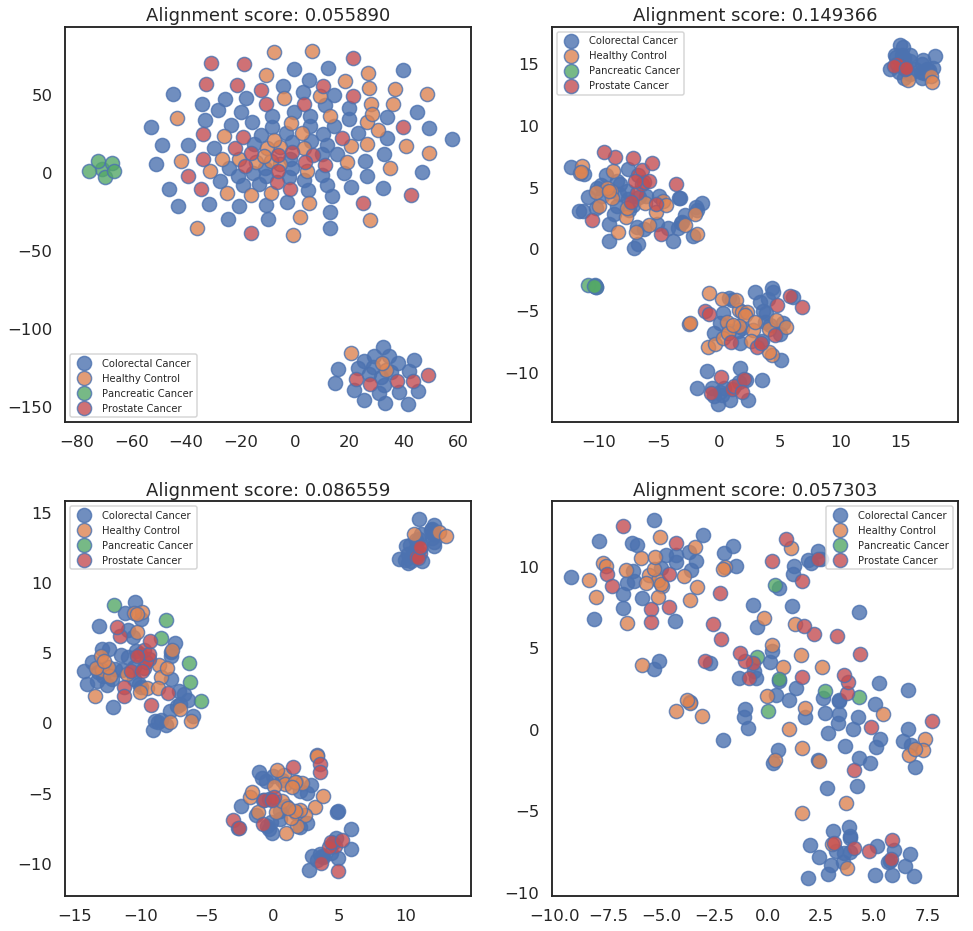

In [46]:
visualize_effect_all(original_mx, impute_table, normalize_table, batch_table, sample_class,method='tSNE')

Alignment score: 0.1076129593690855
Alignment score: 0.1439815355271922
Alignment score: 0.13804671794534273
Alignment score: 0.09006123366821106


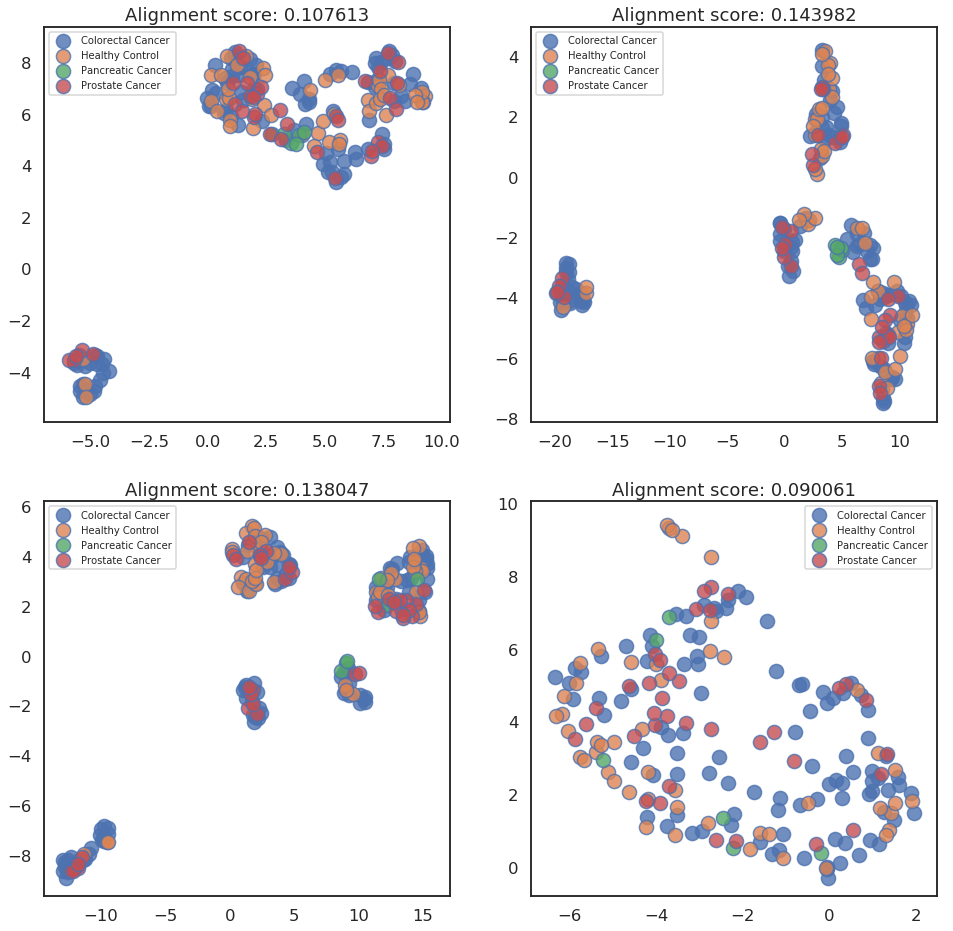

In [47]:
visualize_effect_all(original_mx, impute_table, normalize_table, batch_table, sample_class,method='UMAP')

## top K feature
- cumulative
- top k feature

### cumulative

In [48]:
def topk_cumsum_plot(data, topk=20):
    total_sum = data.sum().sum()
    cumsumvalue = np.cumsum(- np.sort(- np.sum(original_mx,axis=1))/total_sum)
    fig, ax = plt.subplots(figsize=(16, 5))
    ax.bar(np.arange(0,topk),cumsumvalue[:topk],color='r',alpha=0.5)
    ax.set_xticks(np.arange(0,topk))
    ax.set_xticklabels(np.arange(1,1+topk))
    ax.set_title('cumulative bar plot of top '+str(topk)+' feature')

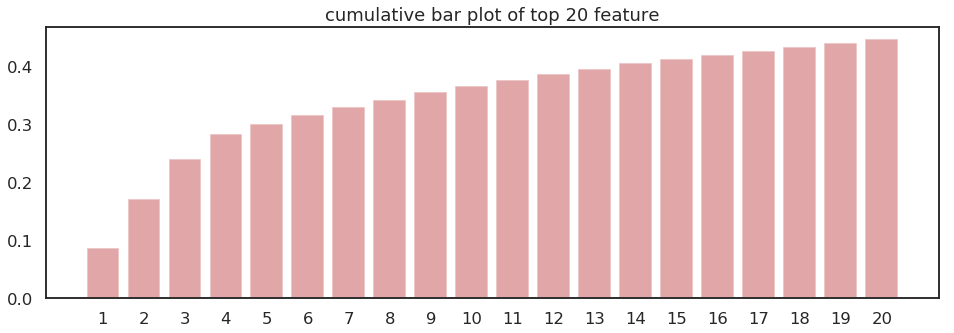

In [49]:
topk_cumsum_plot(processed_mx,topk=20)

### top k feature

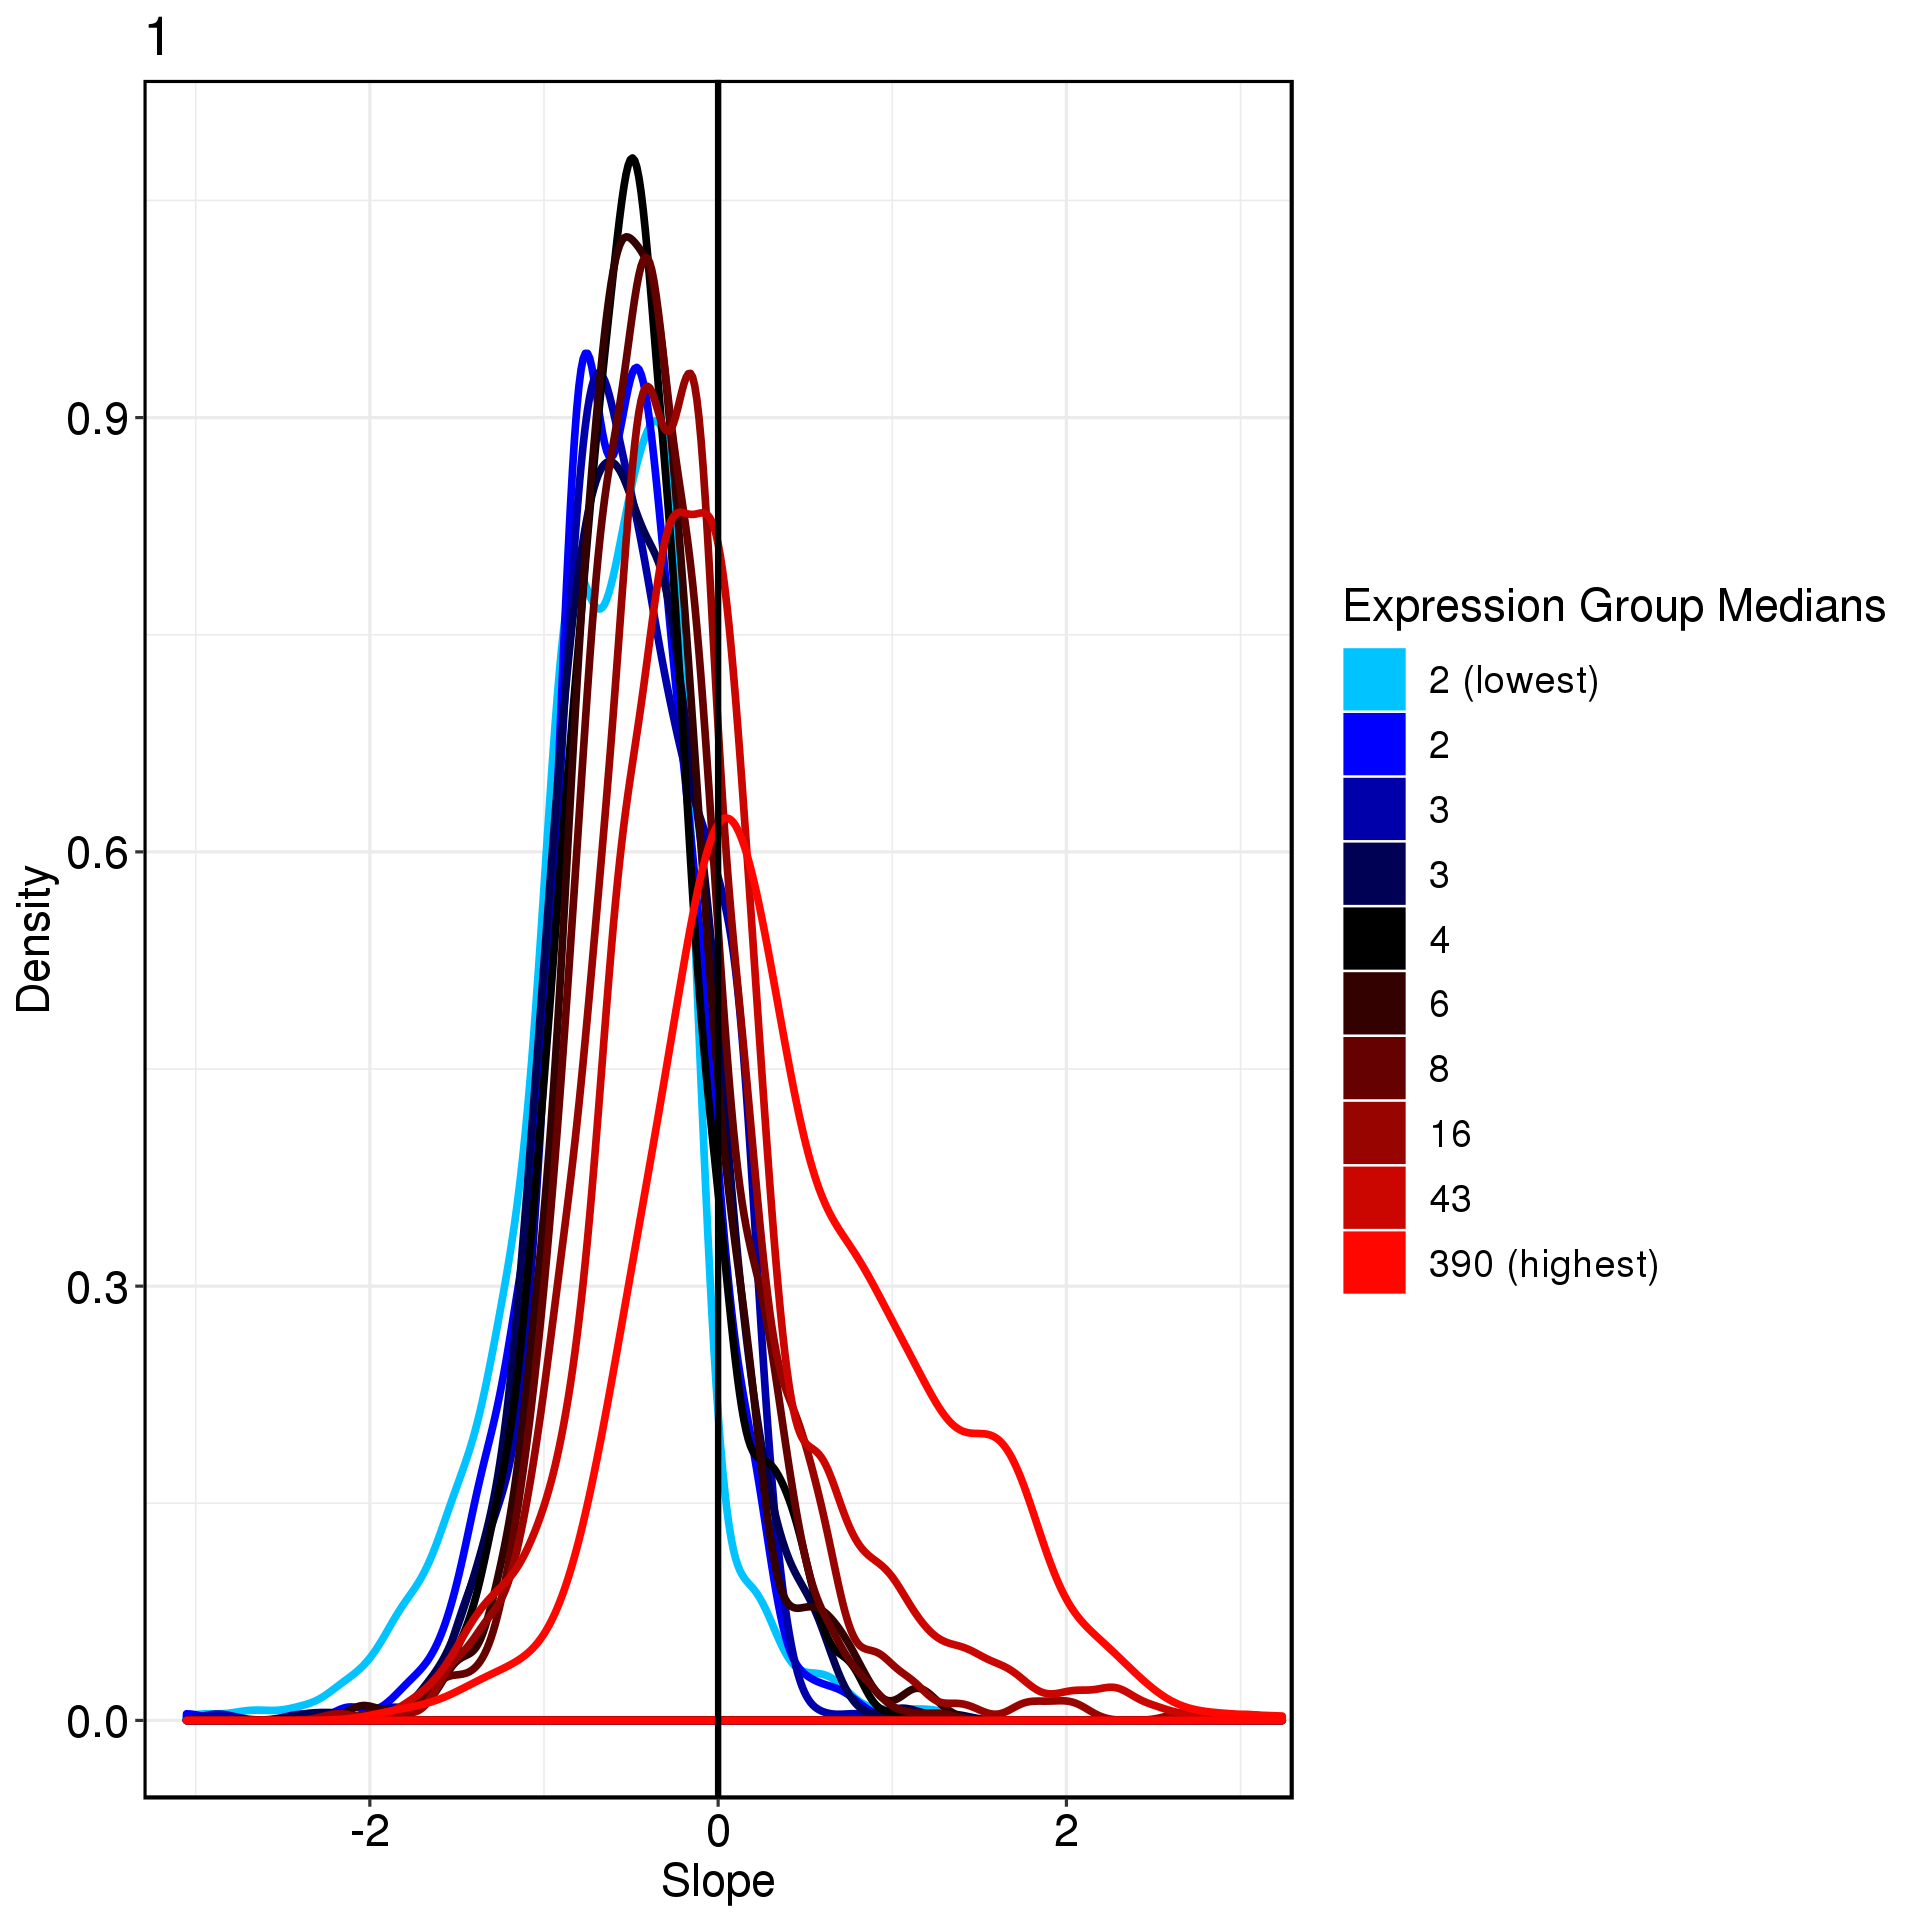

In [50]:
Image(filename='/home/xieyufeng/exSeek/png/plot_highest_exprs.png') 

## show batch
- counts
- by rna

In [51]:
batchtable = pd.read_table(batch_info,sep='\t',index_col=0)

In [52]:
def show_batch_total_counts(ax,batchtable,matrix, batchindex = 1):
    counts = matrix.sum()
    sumtable = pd.DataFrame(counts,columns=['total counts'])
    sumtable_whole = pd.concat((sumtable,batchtable.loc[sumtable.index]),axis=1)
    #fig,ax=plt.subplots(figsize=(8,6))
    batchname = batchtable.columns[batchindex]
    sns.boxplot(data=sumtable_whole,x=batchname,y='total counts',ax=ax)
    ax.set_title('Batch effect: '+batchname)

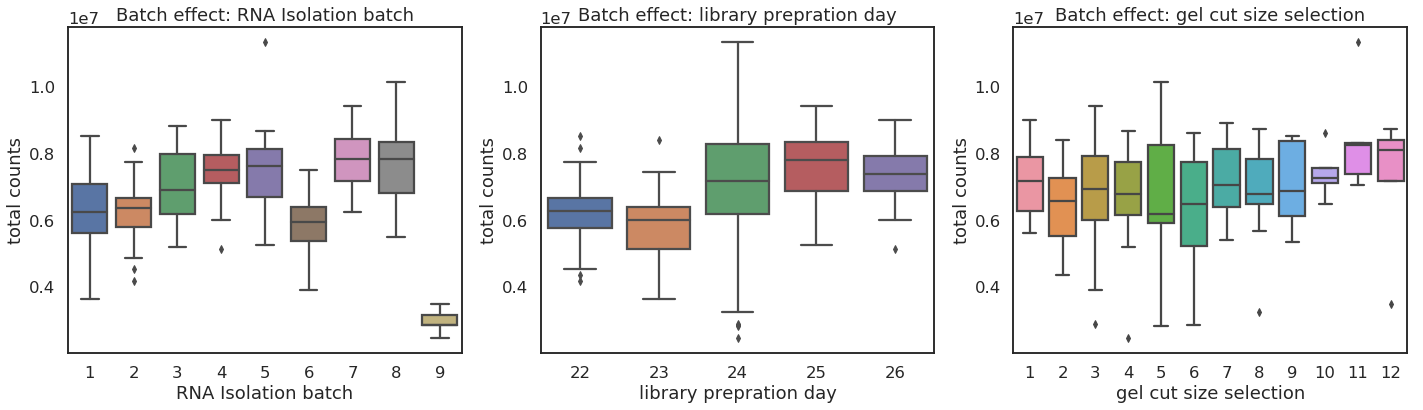

In [53]:
fig, ax = plt.subplots(1,3,figsize=(24, 6))
for  i in range(3):
    show_batch_total_counts(ax[i],batchtable, original_mx, batchindex = i)

In [54]:
def plot_rna_batch(ax,rnaname,typetable,batchtable,batchindex=1):
    '''
    typetable: table_ratio
    rnaname certain type pf rna
    '''
    counts = typetable.T.loc[rnaname].T
    sumtable = pd.DataFrame(counts)
    sumtable_whole = pd.concat((sumtable.loc[batchtable.index],batchtable),axis=1)
    batchname = batchtable.columns[batchindex]
    sns.boxplot(data=sumtable_whole,x=batchname,y=rnaname,ax=ax)
    ax.set_title('batch effect: '+batchname+ ' by '+rnaname,size=16)
    plt.tight_layout()

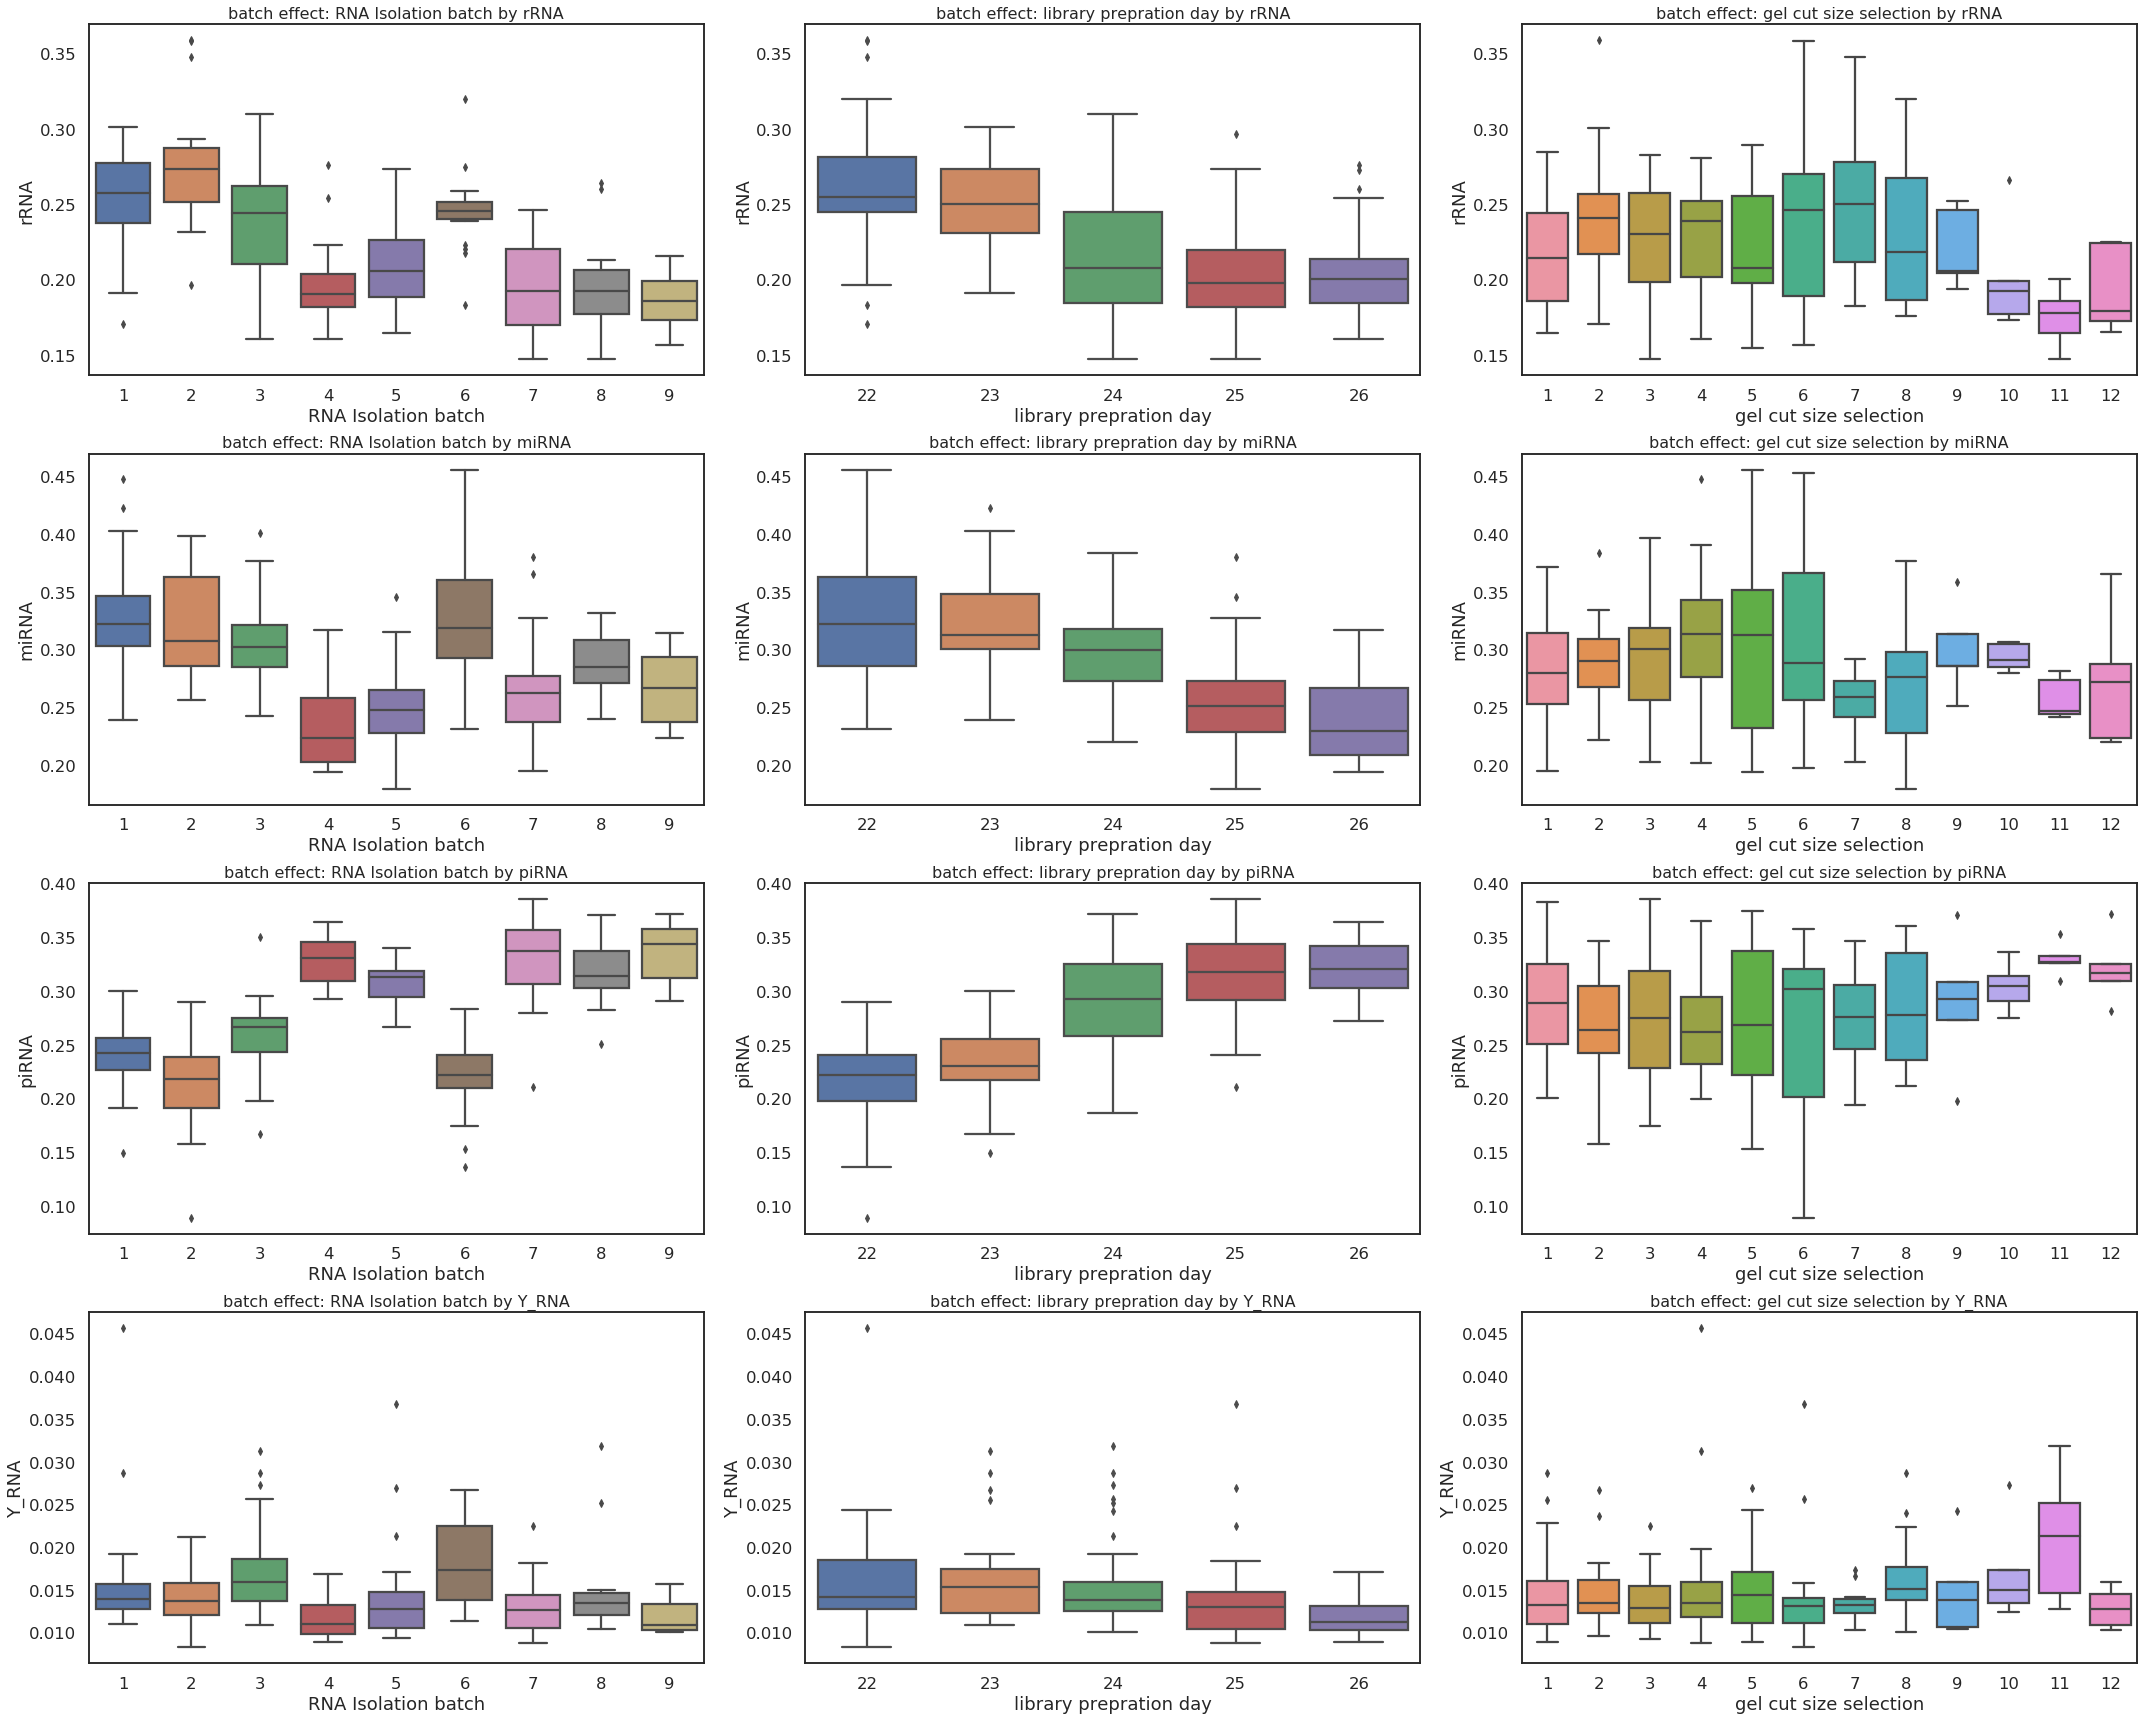

In [55]:
fig, ax = plt.subplots(4,3,figsize=(30, 24))
for i in range(4):
    for j in range(3):
        plot_rna_batch(ax[i,j],rnanames[i],table_ratio,batchtable,batchindex=j)

# Evaluation

In [6]:
dataset = 'exorbase'

In [7]:
import datetime
now = datetime.datetime.now()
timenow = '{}.{}.{}.{}:{}'.format(now.year,now.month,now.day,now.hour,now.minute)
savepath = 'output/candidate/'+dataset+'/'+dataset+'.'+timenow+'/'
if not os.path.exists(savepath):
    os.mkdir(savepath)

In [134]:
fonttitle = {'family':'arial',
                  'weight' : 'bold', 
                  'size' : 30}
fontlabel = {'family':'arial',
                  'weight' : 'bold', 
                  'size' : 25}
fontticklabel = {'family':'arial',
                  'weight' : 'bold', 
                  'size' : 20}
def std_plot(ax,xlabel,ylabel,title=None):
    #plt.yticks([0,0.2,0.4,0.6,0.8,1.0],['0','0.2','0.4','0.6','0.8','1.0'])
    pyplot.draw()
    plt.figure(linewidth=30.5)
    ax.set_xticks(ax.get_xticks())
    ax.set_yticks(ax.get_yticks())
    ax.set_xlabel(xlabel,fontdict = fontlabel)
    ax.set_ylabel(ylabel,fontdict = fontlabel)
    ax.set_xticklabels(ax.get_xticklabels(),fontticklabel)
    ax.set_yticklabels(ax.get_yticklabels(),fontticklabel)


    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if title is not None:
        ax.set_title(title,fontdict = fonttitle)
    ax.legend(prop=fontticklabel)
    return ax

In [8]:
#小二－ 18. 三号－ 16. 小三－ 15. 四号－ 14. 小四－ 12. 五号－ 10.5 (pt)
# 72pt = 1in = 2.54cm
fonttitle = {'family':'Arial',
                  'weight' : 'normal', 
                  'size' : 8}
fontlabel = {'family':'Arial',
                  'weight' : 'normal', 
                  'size' : 6.5}
fontticklabel = {'family':'Arial',
                  'weight' : 'normal', 
                  'size' : 6.5}
fontlegend = {'family':'Arial',
                  'weight' : 'normal', 
              #'linewidth':0.5,
                  'size' : 6.5}
fontcbarlabel = {'family':'Arial',
                 'weight' : 'normal', 
                 #'Rotation' : 270,
                 #'labelpad' : 25,
                 'size' : 6.5}
fontcbarticklabel = {'family':'Arial',#Helvetica
                 'weight' : 'normal', 
                 'size' : 5.5}
def std_plot(ax,xlabel,ylabel,title=None,
             legendtitle=None,bbox_to_anchor=None,
             labelspacing=1.2,borderpad=0,handletextpad=0,legendsort=True,
             xlim=None,ylim=None,
             cbar=None,cbarlabel=None,
             moveyaxis=False):
    #plt.yticks([0,0.2,0.4,0.6,0.8,1.0],['0','0.2','0.4','0.6','0.8','1.0'])
    pyplot.draw()
    #plt.figure(linewidth=30.5)
    ax.set_xticks(ax.get_xticks())
    ax.set_yticks(ax.get_yticks())
    ax.set_xlabel(xlabel,fontdict = fontlabel,labelpad=5.5)
    ax.set_ylabel(ylabel,fontdict = fontlabel,labelpad=5.5)
    ax.set_xticklabels(ax.get_xticklabels(),fontticklabel)
    ax.set_yticklabels(ax.get_yticklabels(),fontticklabel)

    if moveyaxis is True:
        #fontticklabel字体会变
        ax.spines['left'].set_position(('data',0))

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('k')
    ax.spines['left'].set_color('k')
    
    ax.tick_params(direction='out', pad=-10)
    #ax.spines['bottom']._edgecolor="#000000"
    #ax.spines['left']._edgecolor="#000000"
    if title is not None:
        ax.set_title(title,fontdict = fonttitle)
    if legendtitle is not None:
        #if legendloc is None:
        #    legendloc="best"
        legend = ax.legend(title=legendtitle,prop=fontlegend,
                      bbox_to_anchor=bbox_to_anchor,
                      labelspacing=labelspacing,borderpad=borderpad,handletextpad=handletextpad,
                      edgecolor="#000000",fancybox=False)
        ax.legend_.get_frame()._linewidth=0.5
        legend.get_title().set_fontweight('normal')
        legend.get_title().set_fontsize(6.5)
        if legendsort is True:
            # h: handle l:label
            h,l = ax.get_legend_handles_labels()
            l,h = zip(*sorted(zip(l,h), key=lambda t: int(t[0]))) 
            legend = ax.legend(h,l,title=legendtitle,prop=fontlegend,
                      bbox_to_anchor=bbox_to_anchor,
                      labelspacing=labelspacing,borderpad=borderpad,handletextpad=handletextpad,
                      edgecolor="#000000",fancybox=False)
            ax.legend_.get_frame()._linewidth=0.5
            legend.get_title().set_fontweight('normal')
            legend.get_title().set_fontsize(6.5)
    if xlim is not None:  
        ax.set(xlim=xlim)
    if ylim is not None:
        ax.set(ylim=ylim)
    if cbar is not None:
        #locator, formatter = cbar._get_ticker_locator_formatter()
        #ticks, ticklabels, offset_string = cbar._ticker(locator, formatter)
        #cbar.ax.spines['top'].set_visible(False)
        #cbar.ax.spines['right'].set_visible(False)
        #cbar.ax.spines['bottom'].set_visible(False)
        #cbar.ax.spines['left'].set_visible(False)
        cbar.ax.tick_params(direction='out', pad=3,width=0,length=0)
        cbar.set_label(cbarlabel,fontdict = fontcbarlabel,Rotation=270,labelpad=7.5)
        cbar.ax.set_yticks(cbar.ax.get_yticks())
        cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontcbarticklabel)
    return ax
def image_link(filename):
    fig.savefig(filename,dpi=300)
    return HTML('<a href=" ", target="_blank">{0}</a >'.format(filename))

## feature recurrence

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

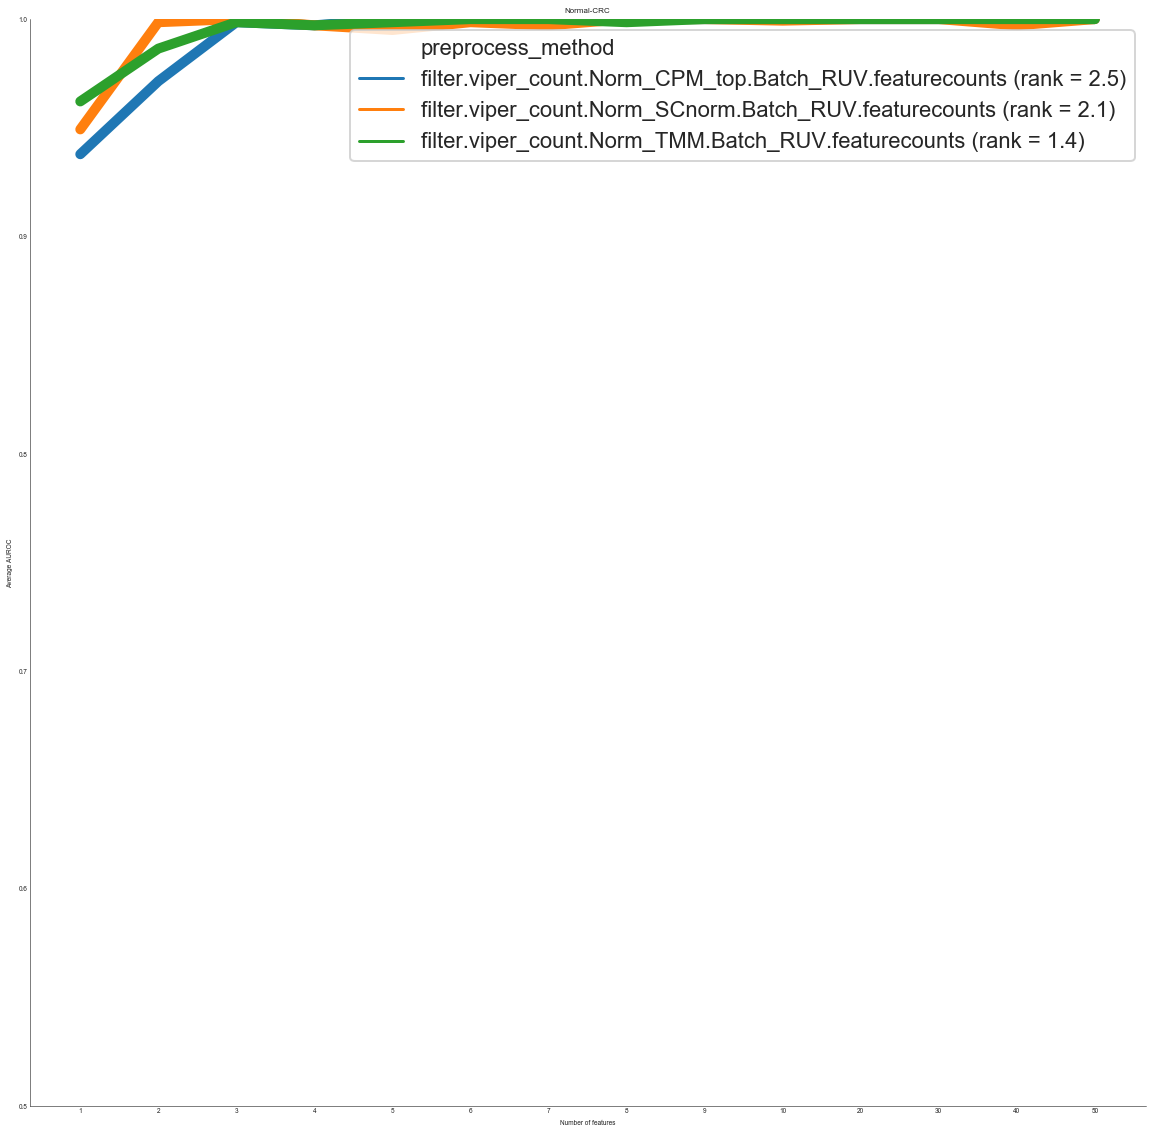

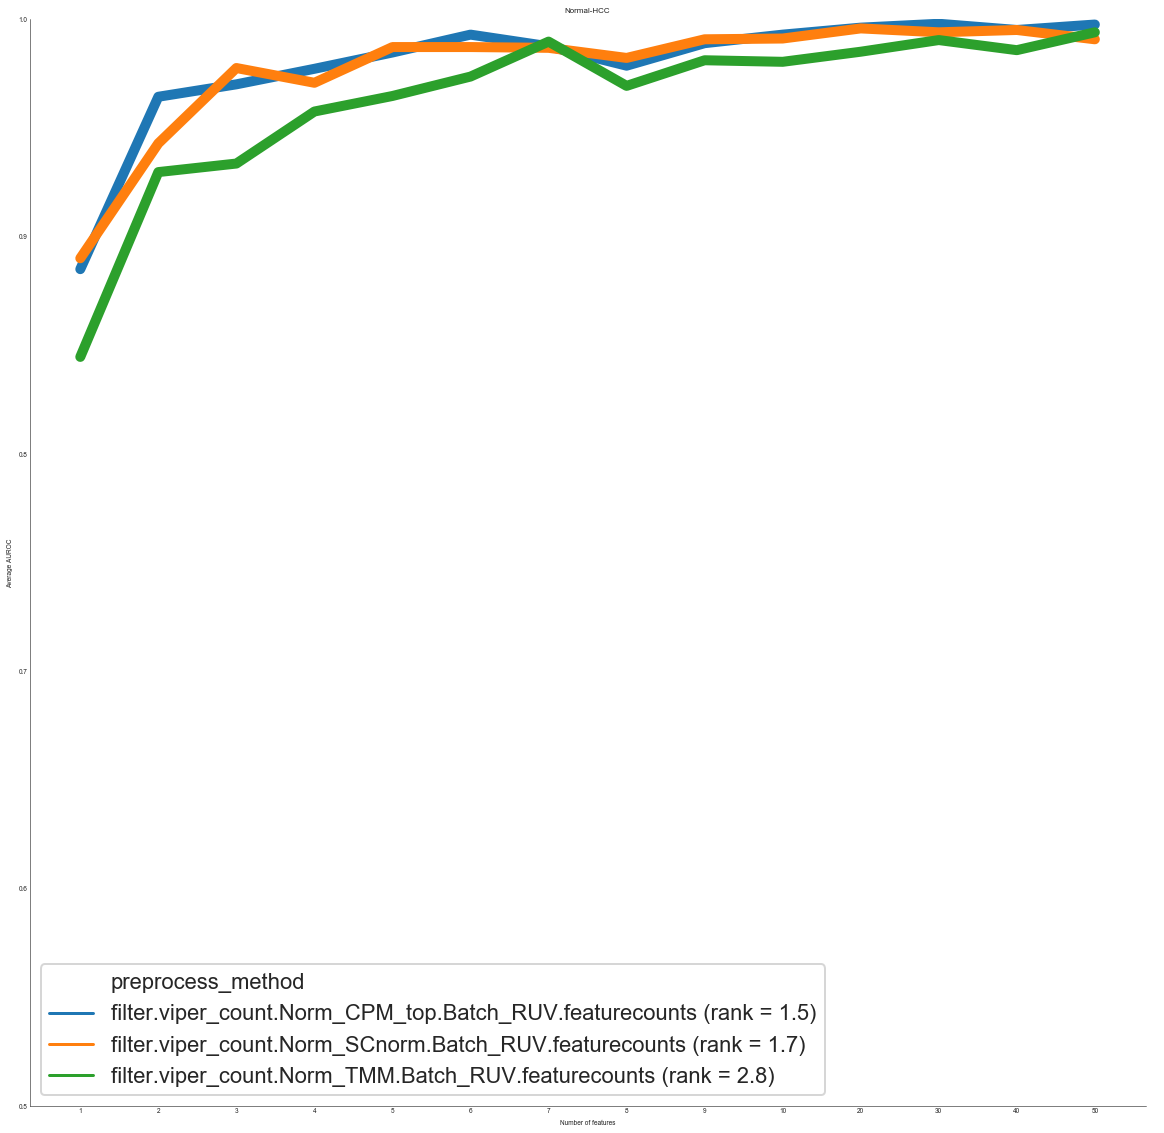

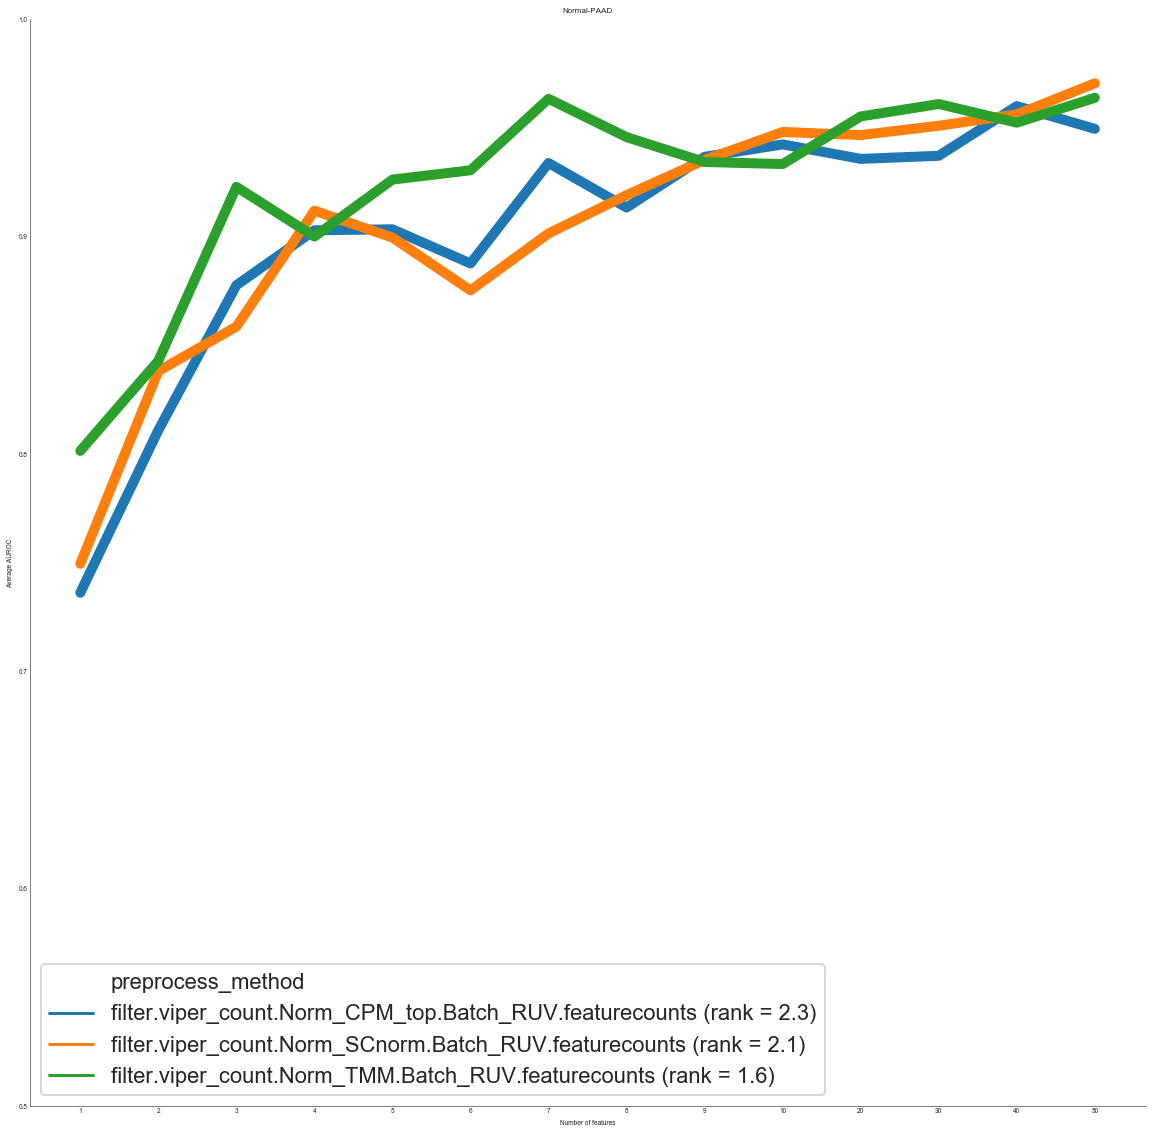

In [10]:
#use uca to presort methods
preselected_methods = np.loadtxt('output/'+dataset+'/select_preprocess_method/uca_score/'+exp_mx_name+'/selected_methods.txt',dtype='str')
preselected_methods_dir = np.array([preselected_methods[i]+'.'+exp_mx_name for i in range(preselected_methods.shape[0])])

def compare_preprocess_methods(output_dir, preselected_methods_dir, savepath=savepath,title=None,savefig=True):
    records = []
    pbar = tqdm(unit='directory')
    for preprocess_method in preselected_methods_dir:#os.listdir(output_dir):#
        for compare_group in os.listdir(os.path.join(output_dir, preprocess_method)):
            for feature_selection_method in os.listdir(os.path.join(output_dir, preprocess_method, compare_group)):
                classifier, n_select, select_method  = feature_selection_method.split('.')
                record = {
                    'compare_group': compare_group,
                    'classifier': classifier,
                    'n_features': n_select,
                    'preprocess_method': preprocess_method
                }
                try:
                    metrics = pd.read_table(os.path.join(output_dir,
                        preprocess_method, compare_group, feature_selection_method,
                        'metrics.txt'))
                except:
                    continue
                record['test_roc_auc_mean'] = metrics['test_roc_auc'].mean()
                pbar.update(1)
                records.append(record)
    pbar.close()
    records = pd.DataFrame.from_records(records)
    records['n_features'] = records.loc[:, 'n_features'].astype(np.int32)
    
    best_preprocess_methods = {}
    for compare_group, sub_df in records.groupby('compare_group'):
        pivot = sub_df.pivot_table(
            index='preprocess_method', columns='n_features', values='test_roc_auc_mean')
        #print(pivot.iloc[:, 0])
        #print(np.argsort(np.argsort(pivot.values, axis=0), axis=0)[:, 0])
        mean_ranks = np.mean(pivot.shape[0] - np.argsort(np.argsort(pivot.values, axis=0), axis=0), axis=1)
        mean_ranks = pd.Series(mean_ranks, index=pivot.index.values)
        mean_ranks = mean_ranks.sort_values()
        rename_index = ['{} (rank = {:.1f})'.format(name, value) for name, value in zip(mean_ranks.index, mean_ranks.values)]
        rename_index = pd.Series(rename_index, index=mean_ranks.index.values)
        sub_df = sub_df.copy()
        sub_df['preprocess_method'] = rename_index[sub_df['preprocess_method'].values].values
        sub_df['n_features'] = sub_df['n_features'].astype('int')
        sub_df = sub_df.sort_values(['preprocess_method', 'n_features'], ascending=True)
        sub_df['n_features'] = sub_df['n_features'].astype('str')
        fig, ax = plt.subplots(figsize=(20, 20))
        
        '''
        for preprocess_method in rename_index.values:
            tmp_df = sub_df[sub_df['preprocess_method'] == preprocess_method]
            ax.plot(np.arange(tmp_df.shape[0]) + 1, tmp_df['test_roc_auc_mean'], label=preprocess_method,linewidth=5)

            ax.set_xticks(np.arange(tmp_df.shape[0]) + 1)
            ax.set_xticklabels(tmp_df['n_features'])
        '''
        #display(sub_df.iloc[np.isin(sub_df['preprocess_method'],rename_index.values)])
        tmpdf = sub_df.iloc[np.isin(sub_df['preprocess_method'],rename_index.values)]
        #tmpdf.n_features = pd.to_numeric(tmpdf.n_features)
        #tmpdf = tmpdf.sort_values(by=['n_features'], ascending=True)
        #tmpdf.n_features = tmpdf.n_features.astype('str')
        
        sns.lineplot(ax=ax,data=tmpdf,sort=False,
                     x='n_features',y = 'test_roc_auc_mean',hue='preprocess_method',linewidth=10,
                     )
        ax.set_ylim(0.5, 1)

        ax.set_yticklabels(np.arange(5,11)/10,fontticklabel)
        ax.set_xticklabels(np.concatenate((np.arange(1,10),np.arange(10,60,10))).astype('str'),fontticklabel)

        ax = std_plot(ax,'Number of features','Average AUROC',compare_group)
        best_preprocess_methods[compare_group] = sub_df.iloc[0]['preprocess_method']
        if savefig:
            fig.savefig(savepath+'AUC_matrix_processing'+compare_group+'.png', bbox_inches='tight')
        #print (best_preprocess_methods)
        best_preprocess_methods[compare_group] = mean_ranks.index[0]
    return best_preprocess_methods

best_preprocess_methods = compare_preprocess_methods('output/'+dataset+'/feature_selection',preselected_methods_dir)

In [11]:
best_preprocess_methods

{'Normal-CRC': 'filter.viper_count.Norm_TMM.Batch_RUV.featurecounts',
 'Normal-HCC': 'filter.viper_count.Norm_CPM_top.Batch_RUV.featurecounts',
 'Normal-PAAD': 'filter.viper_count.Norm_TMM.Batch_RUV.featurecounts'}

## Compare Features: AUC line plot

In [12]:
cpm_table_origin_ = pd.read_table('output/'+dataset+'/matrix_processing/filter.'+exp_mx_name+'.txt')
cpm_table_origin =  cpm_table_origin_/cpm_table_origin_.sum(axis=0)*10e6
length_tmp = np.array([cpm_table_origin.index[i].split('|')[-1] for i in range(cpm_table_origin.index.shape[0])]).astype('int')-\
np.array([cpm_table_origin.index[i].split('|')[-2] for i in range(cpm_table_origin.index.shape[0])]).astype('int')
rpkm_table_origin = (cpm_table_origin_.T/length_tmp*1000).T


def calculate_fc(table,original_index,sample_class, class_compare,cpm_table_origin):
    samples_use = np.array(sample_class.index)[np.isin(sample_class.label,class_compare)]
    sample_class_use = sample_class.iloc[np.isin(sample_class.label,class_compare)]
    sample_class_1_use = sample_class_use.iloc[np.where(sample_class_use.label ==class_compare[0])]
    sample_class_2_use = sample_class_use.iloc[np.where(sample_class_use.label ==class_compare[1])]
    table_selected = table.loc[original_index]
    length = np.array([original_index[i].split('|')[-1] for i in range(original_index.shape[0])]).astype('int')-\
np.array([original_index[i].split('|')[-2] for i in range(original_index.shape[0])]).astype('int')
    #print (length)
    rpkmtable = (table_selected.T/length).T*1000
    #display(rpkmtable)
    #display(table_selected)
    rpkmtable_ = pd.concat((rpkmtable.loc[original_index,sample_class_1_use.index],
               rpkmtable.loc[original_index,sample_class_2_use.index]),axis=1)
    cpmtable_ = pd.concat((cpm_table_origin.loc[original_index,sample_class_1_use.index],
               cpm_table_origin.loc[original_index,sample_class_2_use.index]),axis=1)
    return np.mean(np.log2(rpkmtable.loc[:,sample_class_1_use.index]+0.001),axis=1) -\
np.mean(np.log2(rpkmtable.loc[:,sample_class_2_use.index]+0.001),axis=1),rpkmtable_,cpmtable_
def compare_features(path,sample_class,class_compare,compare_group,savepath=savepath,save_table=True):
    pbar = tqdm(unit='directory')
    feature_lists = {}
    for feature_selection_method in os.listdir(path):
        classifier, n_features, select_method  = feature_selection_method.split('.')
        n_features = int(n_features)
        if n_features > 10:
            continue
        # feature importance
        feature_lists[n_features] = pd.read_table(os.path.join(path,
            feature_selection_method, 'feature_importances.txt'), header=None, index_col=0).iloc[:, 0]
        feature_lists[n_features].index = feature_lists[n_features].index.astype('str')
        pbar.update(1)
    # feature union set
    feature_set = reduce(np.union1d, [a.index.values for a in feature_lists.values()])
    # build feature importance matrix
    feature_matrix = pd.DataFrame(np.zeros((len(feature_set), len(feature_lists))),
                                  index=feature_set, columns=list(feature_lists.keys()))
    for n_features, feature_importance in feature_lists.items():
        feature_matrix.loc[feature_importance.index.values, n_features] = feature_importance.values
    feature_matrix.columns = feature_matrix.columns.astype('int')
    feature_matrix.index = feature_matrix.index.astype('str')
    
    feature_matrix = feature_matrix.loc[:, feature_matrix.columns.sort_values().values]
    original_index = feature_matrix.index
    feature_info = feature_matrix.index.to_series().str.split('|', expand=True)
    feature_info.columns = ['gene_id', 'gene_type', 'gene_name', 'feature_id', 'transcript_id', 'start', 'end']

    feature_matrix.index = feature_info.loc[:, 'gene_name'].values \
        + '|' + feature_info.loc[:, 'gene_type'].values \
        + '|' + feature_info.loc[:, 'gene_id'].values \
    
    # build feature indicator matrix
    feature_indicator_matrix = pd.DataFrame(np.zeros((len(feature_set), len(feature_lists))),
                                  index=feature_set, columns=list(feature_lists.keys()))
    for n_features, feature_importance in feature_lists.items():
        feature_indicator_matrix.loc[feature_importance.index.values, n_features] = 1
    feature_indicator_matrix.columns = feature_indicator_matrix.columns.astype('int')
    feature_indicator_matrix = feature_indicator_matrix.loc[:, feature_indicator_matrix.columns.sort_values().values]
    
    feature_indicator_matrix.index = feature_info.loc[:, 'gene_name'].values \
        + '|' + feature_info.loc[:, 'gene_type'].values \
        + '|' + feature_info.loc[:, 'gene_id'].values
    #fig, ax = plt.subplots(figsize=(6, 8))
    #sns.heatmap(feature_indicator_matrix,
    #            cmap=sns.light_palette('green', as_cmap=True), cbar=False, ax=ax, linewidth=1)
    #ax.set_xlabel('Number of features')
    #ax.set_ylabel('Features')
    foldchange,rpkmtable,cpmtable = calculate_fc(processed_matrix, original_index,sample_class,class_compare,cpm_table_origin)
    foldchange.index = feature_matrix.index
    feature_matrix = pd.concat((feature_matrix,foldchange),axis=1)
    feature_matrix.columns = np.concatenate((np.arange(1,11).astype('str'),np.array(['fold change'])))
    #display (feature_matrix)
    feature_matrix.index = feature_info.loc[:, 'gene_name'].values \
        + '|' + feature_info.loc[:, 'gene_type'].values \
    + '|' + feature_info.loc[:, 'feature_id'].values \
        + '|' + feature_info.loc[:, 'transcript_id'].values
    #display (feature_matrix)
    display(feature_matrix.style\
        .background_gradient(cmap=sns.light_palette('green', as_cmap=True))\
        .set_precision(2)\
        .set_caption(path))
    pbar.close()
    if save_table:
        feature_matrix.to_csv(savepath+compare_group+'_feature_table.txt',sep='\t')
    return feature_matrix,feature_indicator_matrix,original_index,foldchange,rpkmtable,cpmtable


In [13]:
def scale(axis,table):
    '''
    axis: 0(by sample)/1(by feature)/2(both 0 and 1)
    '''
    scaler = StandardScaler()
    arr = np.array(table)
    if axis==0:
        return scaler.fit_transform(arr)
    elif axis==1:
        return scaler.fit_transform(arr.T).T
    elif axis==2:
        return scaler.fit_transform(scaler.fit_transform(arr).T).T
def clustermap(processed_matrix,featurename,sample_class, class_compare,compare_group,savepath=savepath,savefig=True):
    samples_use = np.array(sample_class.index)[np.isin(sample_class.label,class_compare)]
    sample_class_use = sample_class.iloc[np.isin(sample_class.label,class_compare)]
    cpm_table = processed_matrix
    cpm_table_use = cpm_table.loc[featurename,samples_use]
    #display(cpm_table_use)
    cpm_matrix= np.log2(np.array(cpm_table_use)+0.001)
    cpm_table_use.iloc[:,:] = RobustScaler().fit_transform(cpm_matrix.T).T
    rgblabel = np.repeat('r',samples_use.shape[0])
    rgblabel[np.where(sample_class_use.label==class_compare[-1])] = 'b'
    cpm_table_use.index = np.array([cpm_table_use.index[i].split('|')[2]+'|'+cpm_table_use.index[i].split('|')[1] for i in range(cpm_table_use.index.shape[0]) ])
    sns_plot = sns.clustermap(cpm_table_use,cmap='vlag',figsize=(70,20),col_colors=rgblabel)
    if savefig:
        sns_plot.savefig(savepath+compare_group+'_clustermap.png', bbox_inches='tight')
    
   
    return cpm_table_use,sample_class_use

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

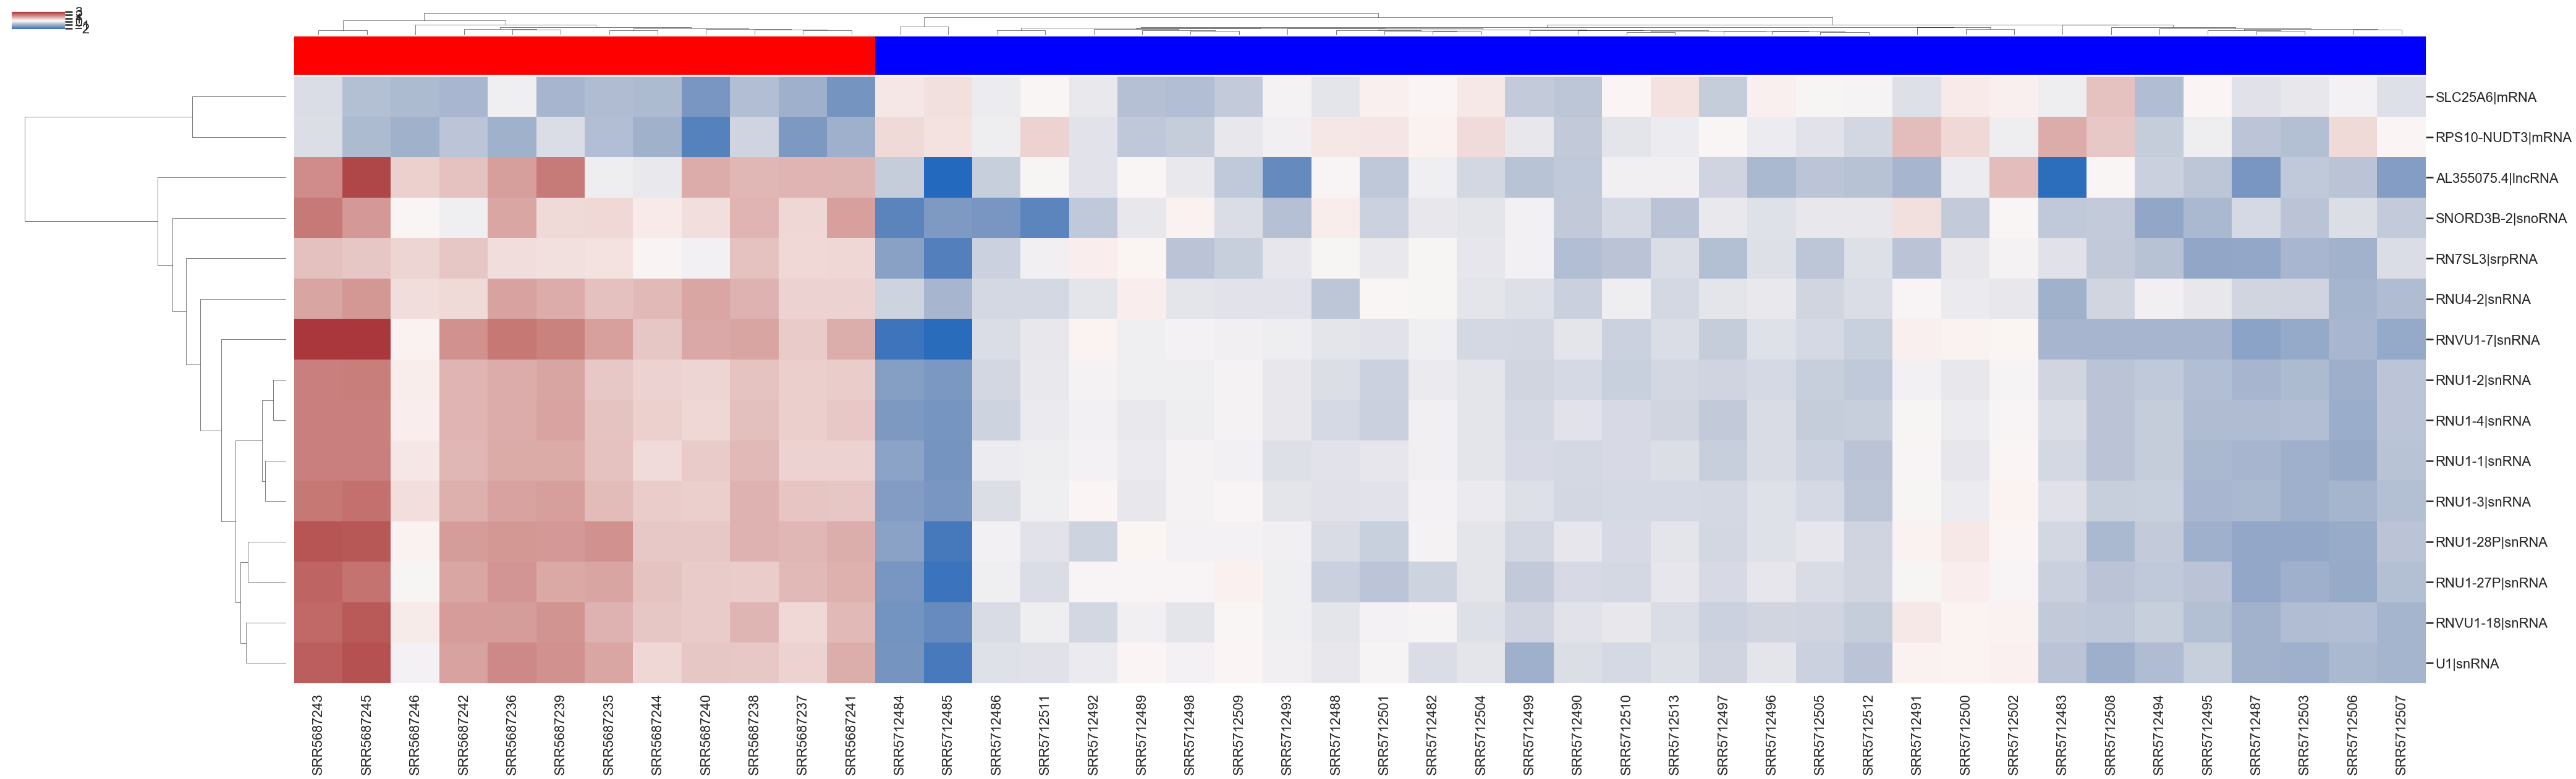

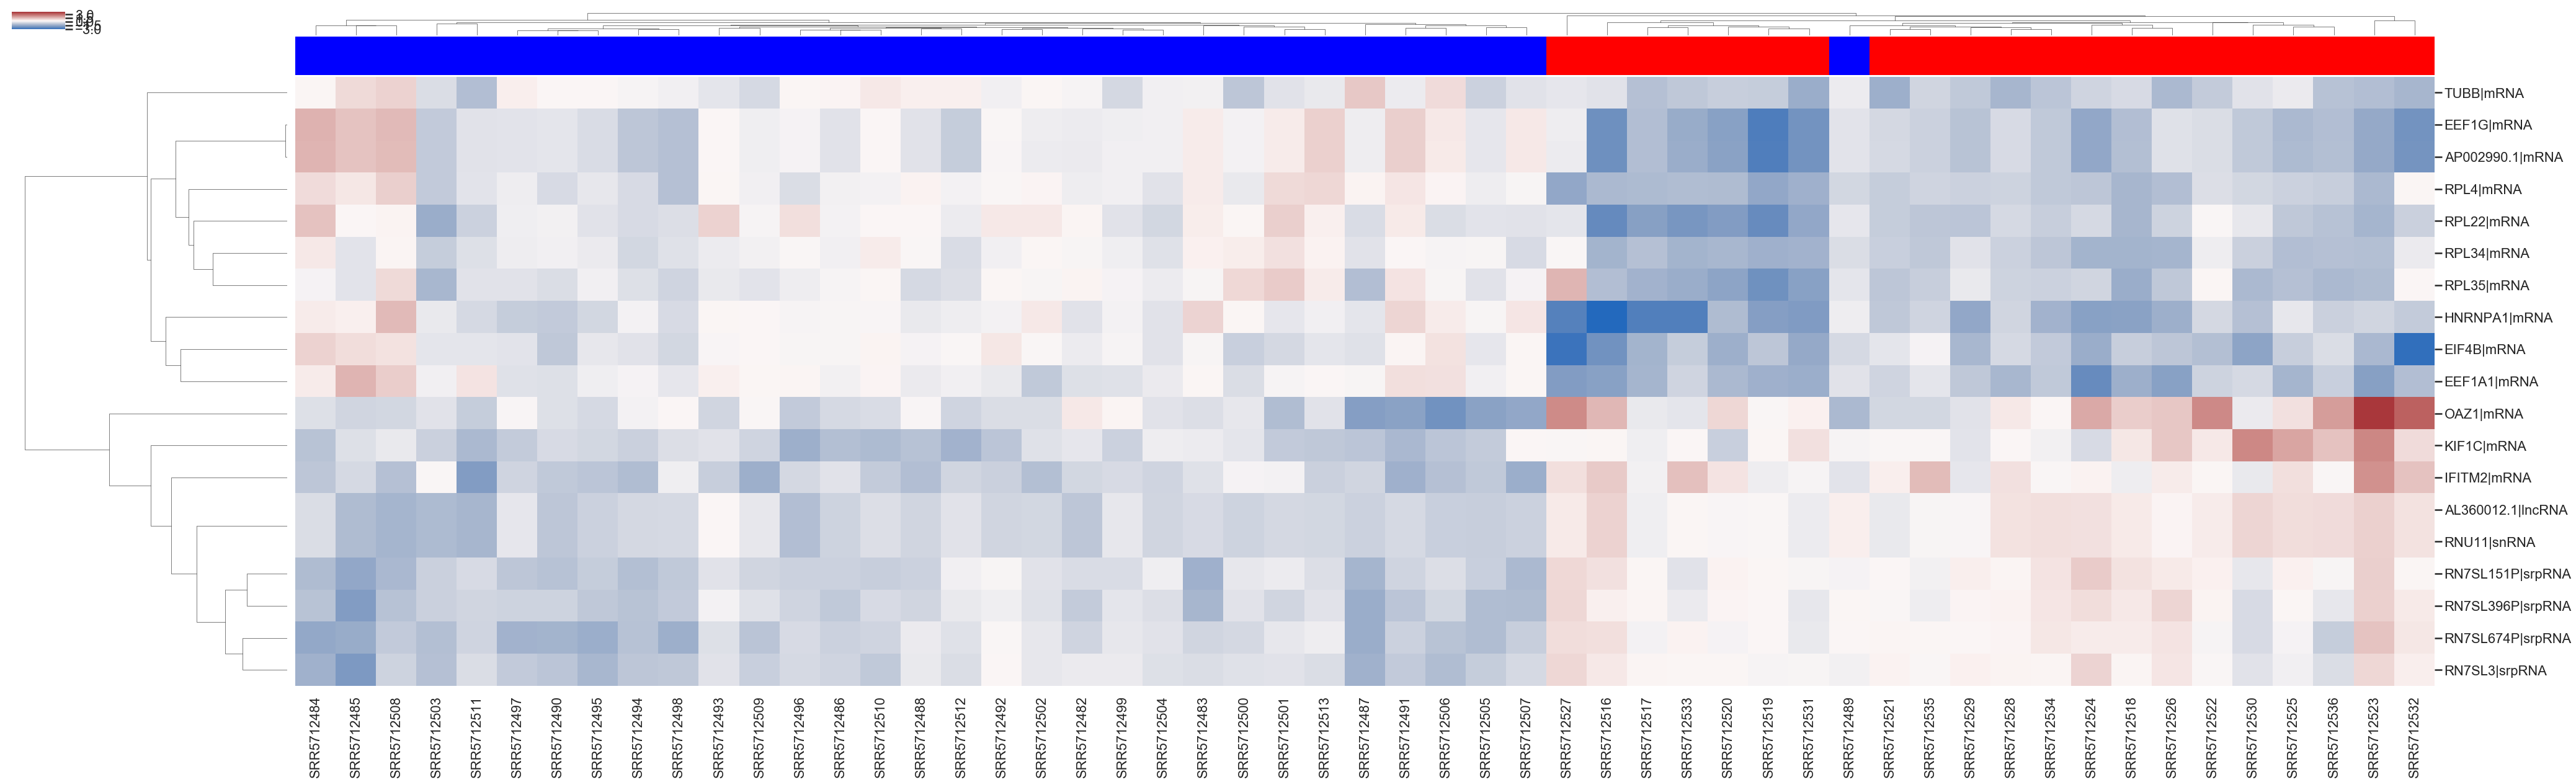

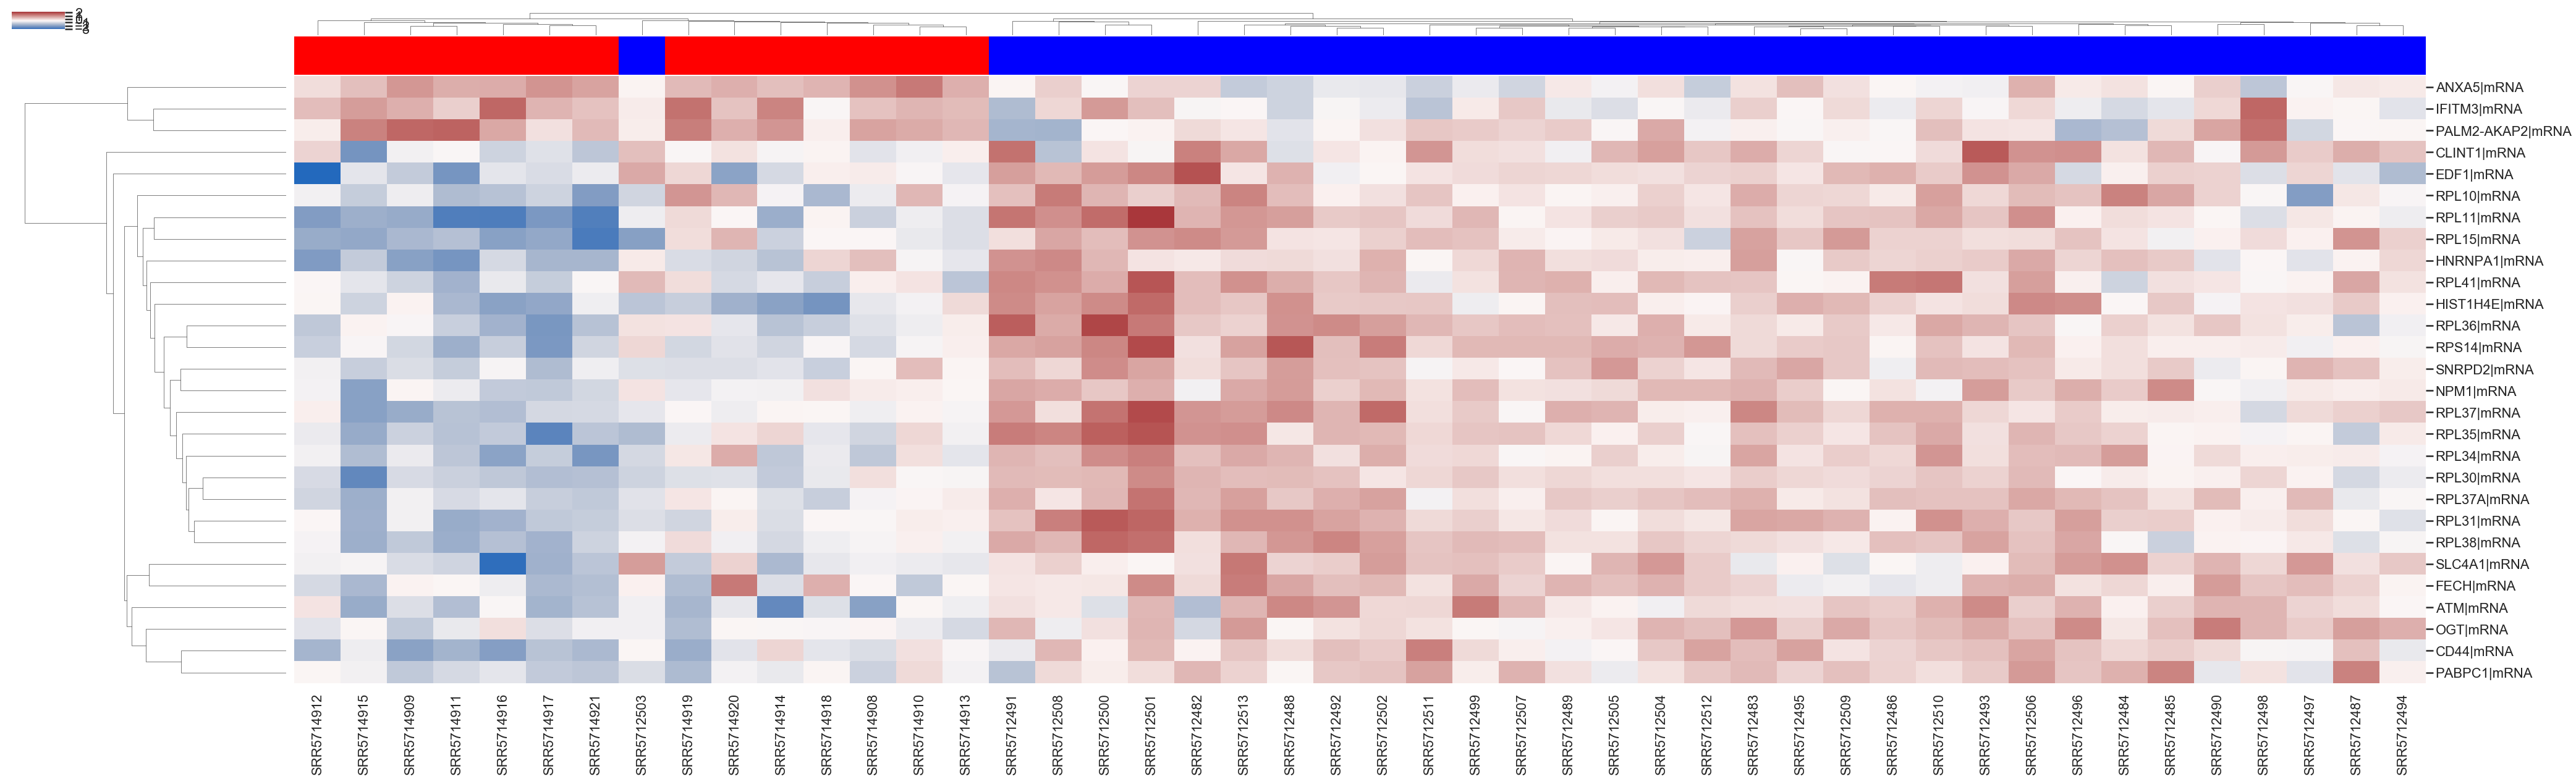

In [14]:
output_feature_selection_path = 'output/'+dataset+'/feature_selection/'
feature_matrix,feature_indicator_matrix,original_index,foldchange,rpkmtable,cpm_table_use,sample_class_use,cpmtable = {},{},{},{},{},{},{},{}
for compare_group, preprocess_method in tqdm(best_preprocess_methods.items()):
    class_info = 'data/'+dataset+'/sample_classes.txt'
    if dataset =='scirep':
        if compare_group=='Normal-CRC':
            class_compare = np.array(['Colorectal Cancer', 'Healthy Control']) 
        elif compare_group=='Normal-PAAD':
            class_compare = np.array(['Prostate Cancer', 'Healthy Control']) 
        elif compare_group=='Normal-PRAD':
            class_compare = np.array(['Pancreatic Cancer', 'Healthy Control']) 
    elif dataset =='lulab_hcc':
        if compare_group=='Normal-HCC':
            class_info = 'data_old/labels/sample_classes_hcc.txt'
        if compare_group=='Normal-HCC':
            class_compare = np.array(['HCC', 'Normal']) 
        elif compare_group=='Normal-stage_A':
            class_compare = np.array(['stage_A', 'Normal']) 
    elif dataset =='exorbase':
        if compare_group=='Normal-HCC':
            class_compare = np.array(['HCC', 'Healthy']) 
        elif compare_group=='Normal-CRC':
            class_compare = np.array(['CRC', 'Healthy']) 
        elif compare_group=='Normal-PAAD':
            class_compare = np.array(['PAAD', 'Healthy']) 
    sample_class = pd.read_table(class_info,sep='\t',index_col=0)
    processed_matrix = pd.read_table('output/'+dataset+'/matrix_processing/'+preprocess_method+'.txt',sep='\t',index_col=0)
    feature_matrix[compare_group],feature_indicator_matrix[compare_group],\
    original_index[compare_group],foldchange[compare_group],rpkmtable[compare_group],cpmtable[compare_group] = compare_features(output_feature_selection_path+'{}/{}'.format(preprocess_method,compare_group),sample_class,class_compare,compare_group)
    features =  feature_matrix[compare_group].index
    cpm_table_use[compare_group],sample_class_use[compare_group] =  clustermap(processed_matrix,original_index[compare_group],sample_class,class_compare,compare_group)
    

In [188]:
feature_matrix['Normal-CRC']

1         2  \
SLC25A6|mRNA|ENSG00000169100.13_PAR_Y|ENSG00000169100.13_PAR_Y  0.0  0.000000   
RNU4-2|snRNA|ENSG00000202538.1|ENSG00000202538.1                0.0  0.000000   
RNVU1-7|snRNA|ENSG00000206585.1|ENSG00000206585.1               0.0  0.474176   
RNU1-28P|snRNA|ENSG00000206588.1|ENSG00000206588.1              1.0  0.000000   
RNU1-27P|snRNA|ENSG00000206596.1|ENSG00000206596.1              0.0  0.000000   
RNU1-1|snRNA|ENSG00000206652.1|ENSG00000206652.1                0.0  0.000000   
RNVU1-18|snRNA|ENSG00000206737.1|ENSG00000206737.1              0.0  0.000000   
RNU1-2|snRNA|ENSG00000207005.1|ENSG00000207005.1                0.0  0.525824   
RNU1-4|snRNA|ENSG00000207389.1|ENSG00000207389.1                0.0  0.000000   
RNU1-3|snRNA|ENSG00000207513.1|ENSG00000207513.1                0.0  0.000000   
AL355075.4|lncRNA|ENSG00000259001.3|ENSG00000259001.3           0.0  0.000000   
SNORD3B-2|snoRNA|ENSG00000262074.6|ENSG00000262074.6            0.0  0.000000   
RPS10-NUDT3|mRNA|ENSG00000270800.2|ENSG00000270800.2            0.0  0.000000   
U1|snRNA|ENSG00000273768.1|ENSG00000273768.1                    0.0  0.000000   
RN7SL3|srpRNA|ENSG00000278771.1|ENSG00000278771.1               0.0  0.000000   

                                                                       3  \
SLC25A6|mRNA|ENSG00000169100.13_PAR_Y|ENSG00000169100.13_PAR_Y  0.283146   
RNU4-2|snRNA|ENSG00000202538.1|ENSG00000202538.1                0.000000   
RNVU1-7|snRNA|ENSG00000206585.1|ENSG00000206585.1               0.000000   
RNU1-28P|snRNA|ENSG00000206588.1|ENSG00000206588.1              0.000000   
RNU1-27P|snRNA|ENSG00000206596.1|ENSG00000206596.1              0.293144   
RNU1-1|snRNA|ENSG00000206652.1|ENSG00000206652.1                0.000000   
RNVU1-18|snRNA|ENSG00000206737.1|ENSG00000206737.1              0.000000   
RNU1-2|snRNA|ENSG00000207005.1|ENSG00000207005.1                0.000000   
RNU1-4|snRNA|ENSG00000207389.1|ENSG00000207389.1                0.423710   
RNU1-3|snRNA|ENSG00000207513.1|ENSG00000207513.1                0.000000   
AL355075.4|lncRNA|ENSG00000259001.3|ENSG00000259001.3           0.000000   
SNORD3B-2|snoRNA|ENSG00000262074.6|ENSG00000262074.6            0.000000   
RPS10-NUDT3|mRNA|ENSG00000270800.2|ENSG00000270800.2            0.000000   
U1|snRNA|ENSG00000273768.1|ENSG00000273768.1                    0.000000   
RN7SL3|srpRNA|ENSG00000278771.1|ENSG00000278771.1               0.000000   

                                                                       4  \
SLC25A6|mRNA|ENSG00000169100.13_PAR_Y|ENSG00000169100.13_PAR_Y  0.000000   
RNU4-2|snRNA|ENSG00000202538.1|ENSG00000202538.1                0.000000   
RNVU1-7|snRNA|ENSG00000206585.1|ENSG00000206585.1               0.000000   
RNU1-28P|snRNA|ENSG00000206588.1|ENSG00000206588.1              0.118446   
RNU1-27P|snRNA|ENSG00000206596.1|ENSG00000206596.1              0.000000   
RNU1-1|snRNA|ENSG00000206652.1|ENSG00000206652.1                0.441554   
RNVU1-18|snRNA|ENSG00000206737.1|ENSG00000206737.1              0.104346   
RNU1-2|snRNA|ENSG00000207005.1|ENSG00000207005.1                0.000000   
RNU1-4|snRNA|ENSG00000207389.1|ENSG00000207389.1                0.335654   
RNU1-3|snRNA|ENSG00000207513.1|ENSG00000207513.1                0.000000   
AL355075.4|lncRNA|ENSG00000259001.3|ENSG00000259001.3           0.000000   
SNORD3B-2|snoRNA|ENSG00000262074.6|ENSG00000262074.6            0.000000   
RPS10-NUDT3|mRNA|ENSG00000270800.2|ENSG00000270800.2            0.000000   
U1|snRNA|ENSG00000273768.1|ENSG00000273768.1                    0.000000   
RN7SL3|srpRNA|ENSG00000278771.1|ENSG00000278771.1               0.000000   

                                                                       5  \
SLC25A6|mRNA|ENSG00000169100.13_PAR_Y|ENSG00000169100.13_PAR_Y  0.000000   
RNU4-2|snRNA|ENSG00000202538.1|ENSG00000202538.1                0.369789   
RNVU1-7|snRNA|ENSG00000206585.1|ENSG00000206585.1               0.000000   
RNU1-28P|snRNA|ENSG00000206588.

## bar plot of feature importance

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

[5 5 4 6 6 6 4 7 2 1]
[7 4 5 7 3 3 2 1 3 2]
[4 4 5 1 2 8 1 2 1 2]



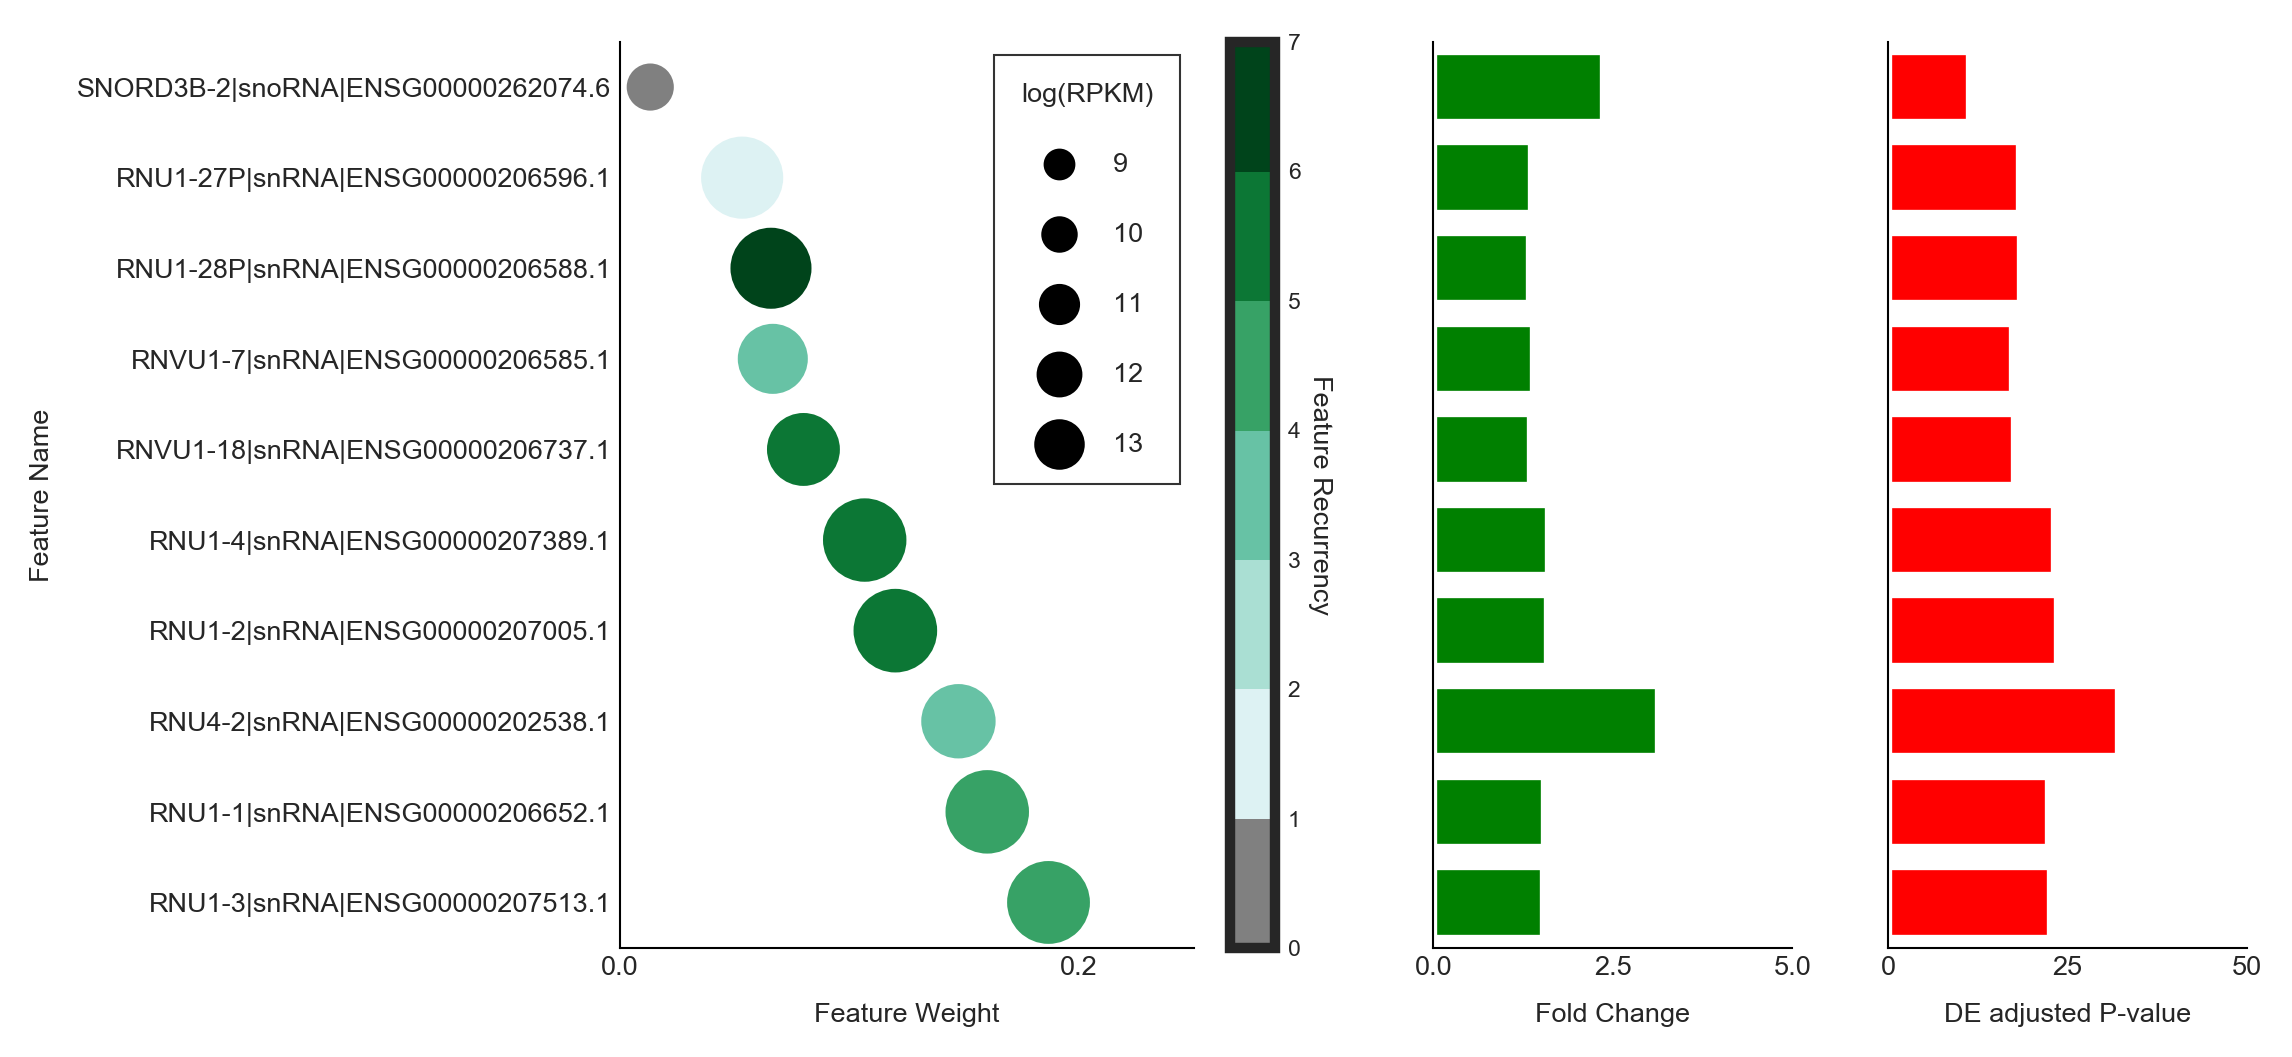

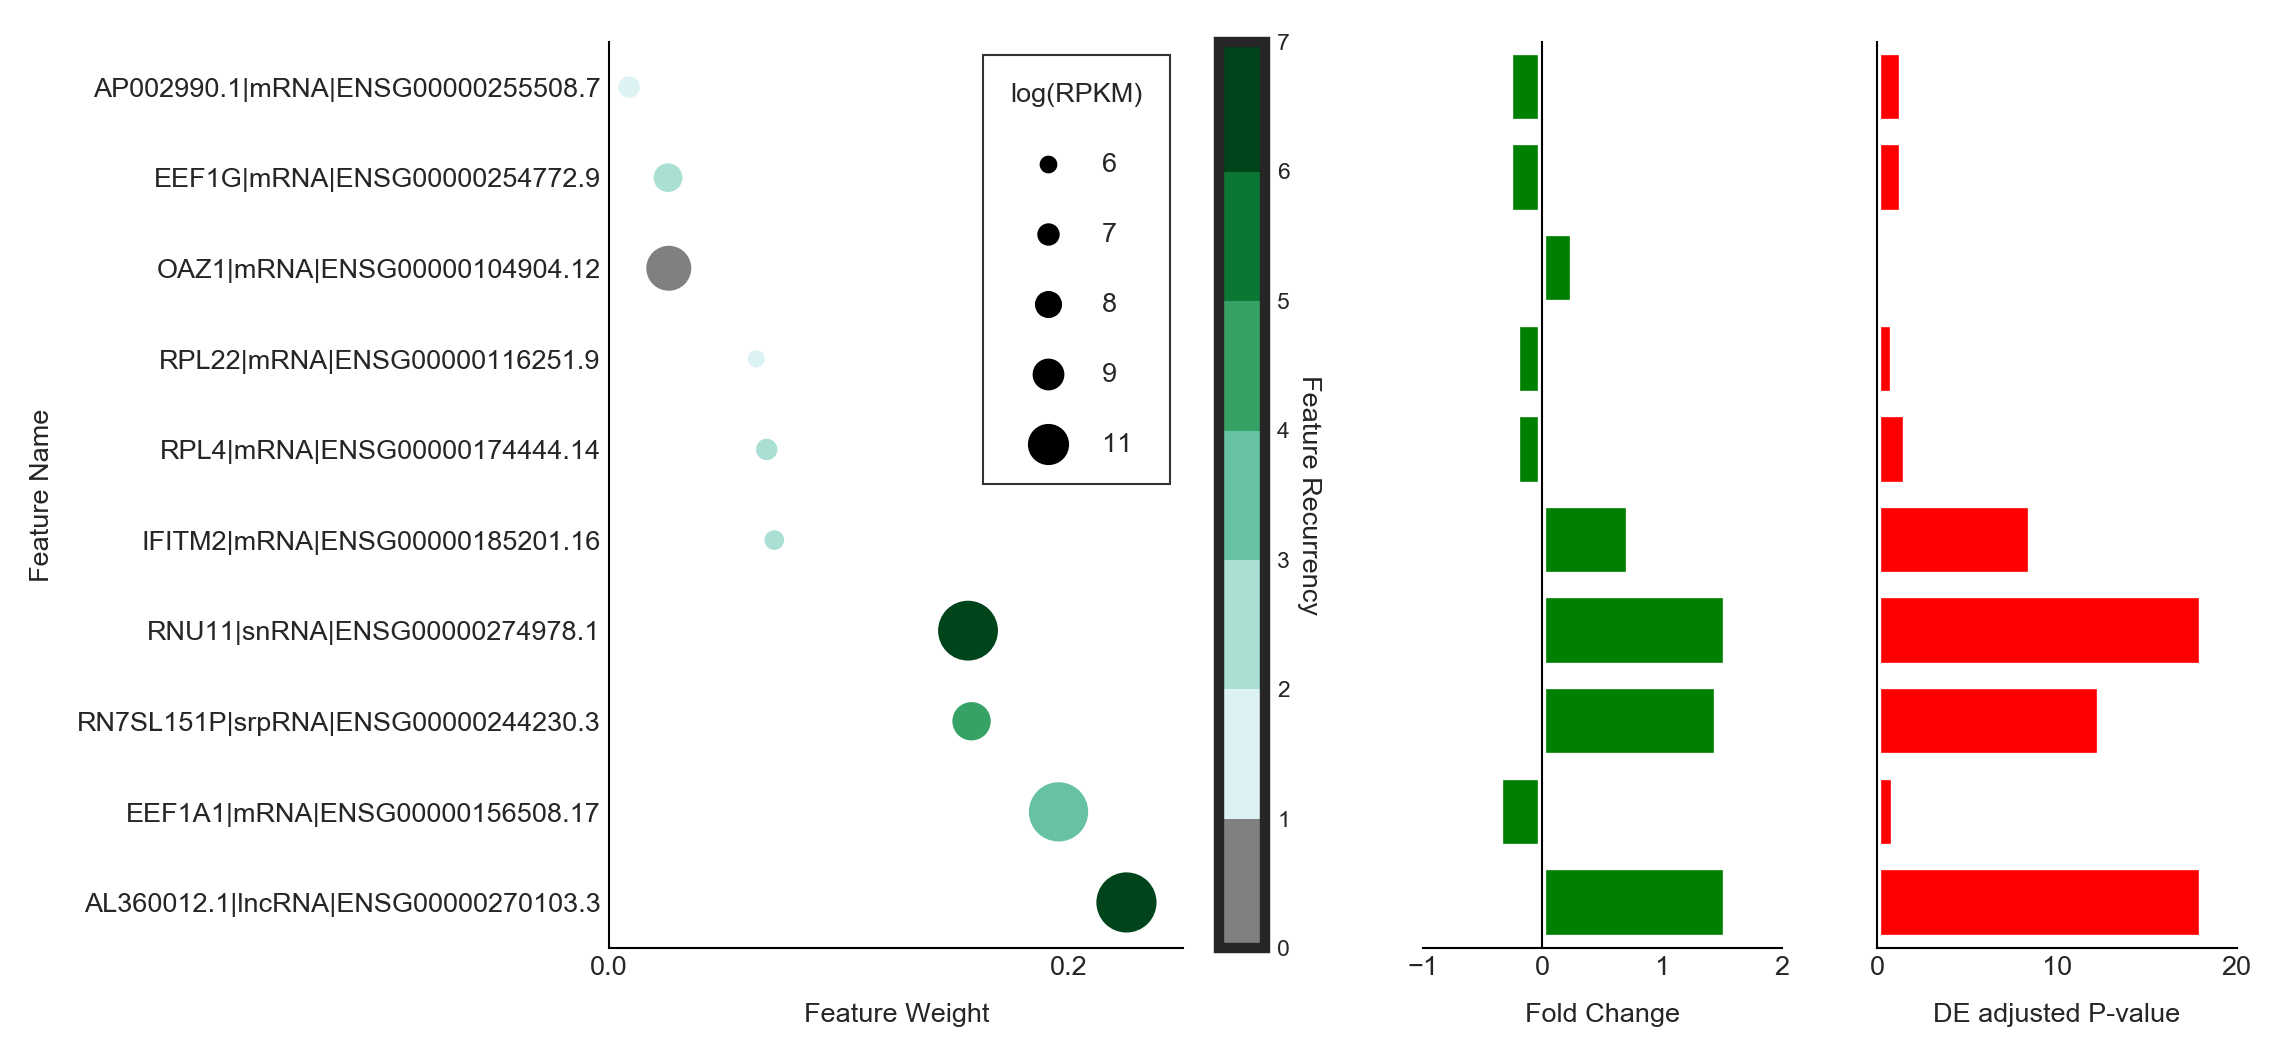

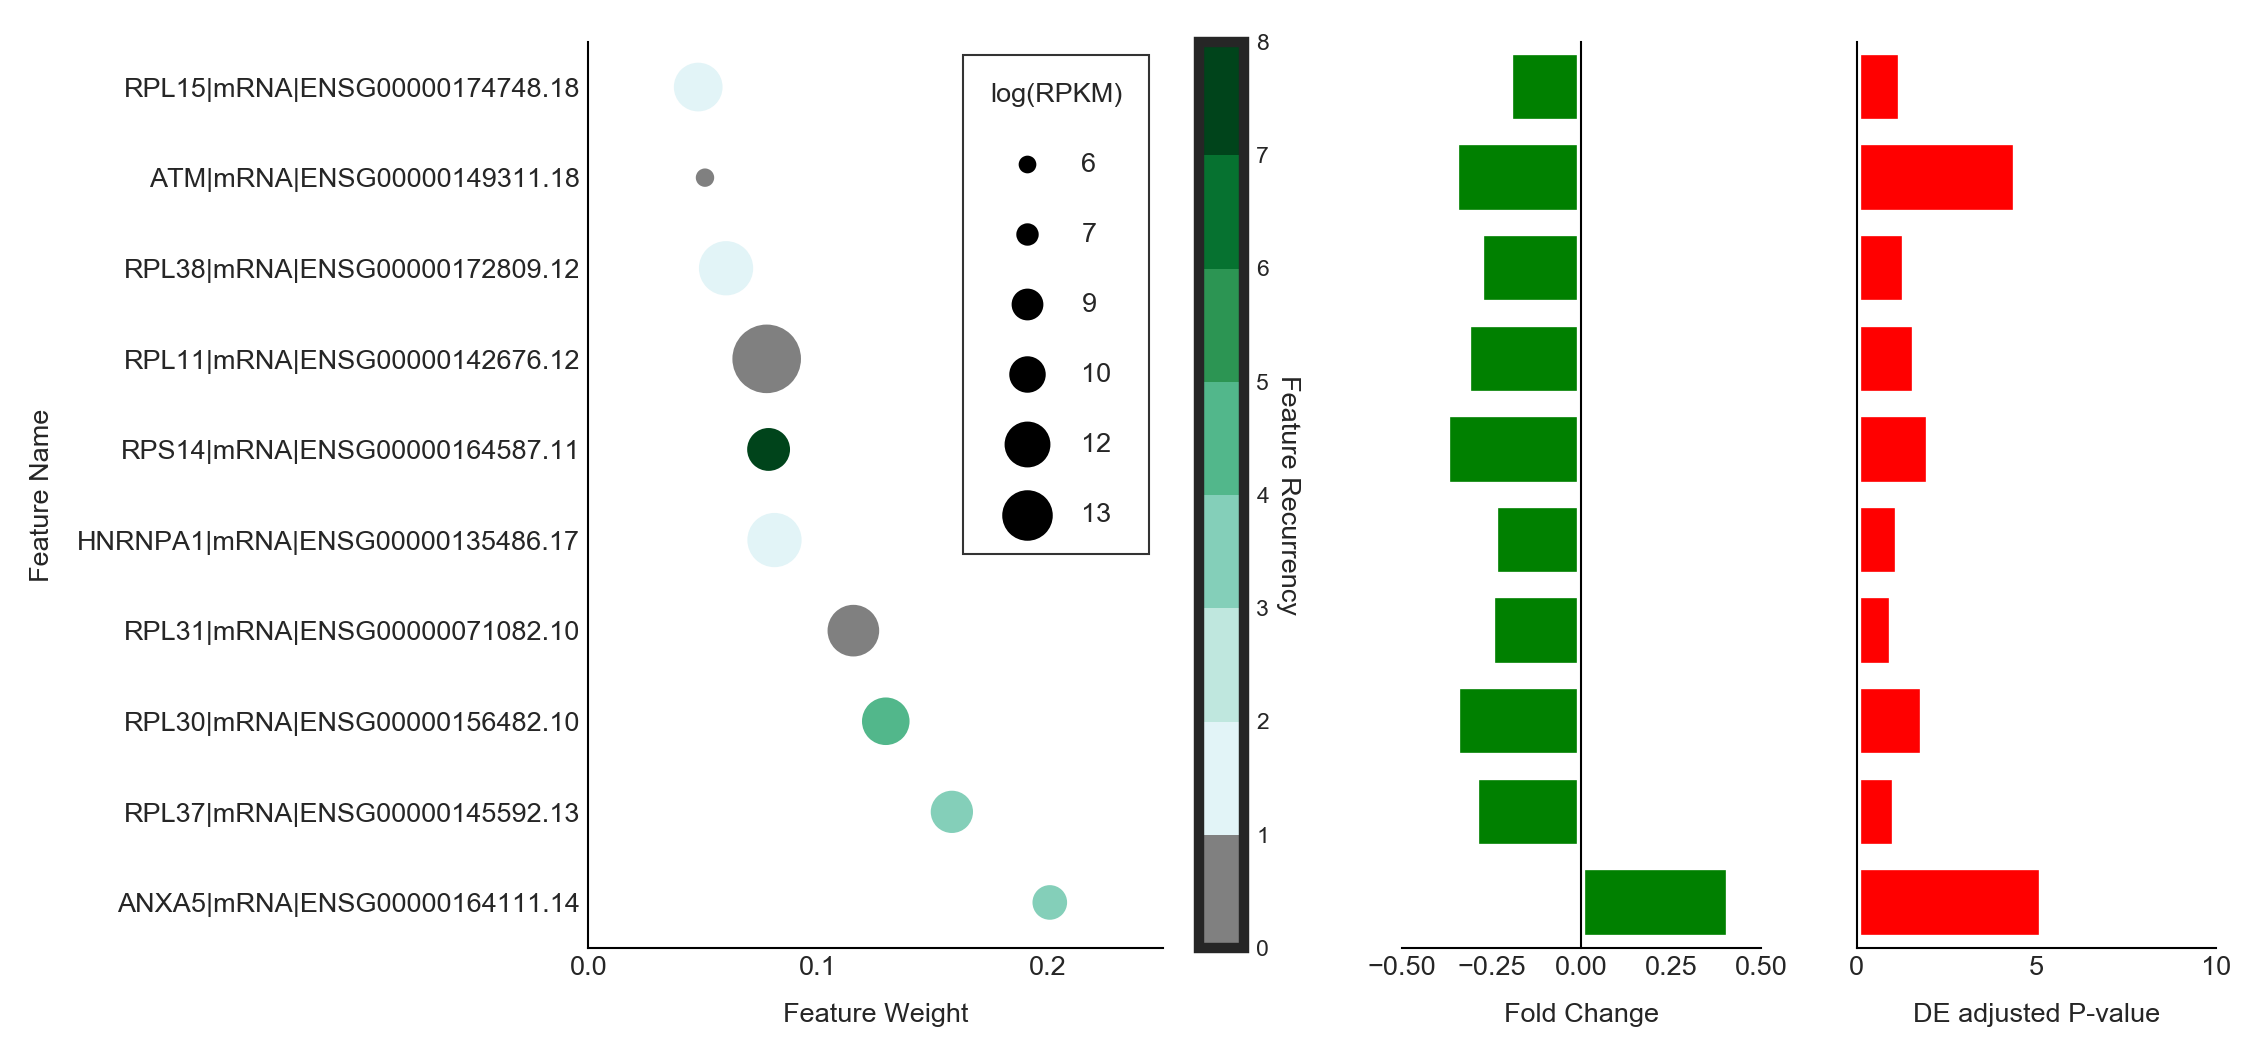

In [15]:
def feature_weight_bar(feature_weight_table,detable,nums_retain=10,rpkmtable=rpkmtable,original_index=original_index, savepath=savepath,savefig=True,compare_group=compare_group):
    
    selected_table = feature_weight_table.iloc[:,nums_retain-1:]
    rpkm = np.array(rpkmtable.iloc[np.where(selected_table.iloc[:,0]!=0)].mean(axis=1))
    selected_feature = original_index[np.where(selected_table.iloc[:,0]!=0)]
    nums_retain = min(selected_feature.shape[0],nums_retain)
    selected_table = selected_table.iloc[np.where(selected_table.iloc[:,0]!=0)]
    featurename = np.array(selected_table.index)#np.array([selected_table.index[i].split('|')[0] for  i in range(selected_table.shape[0])])
    #feature_weight = np.array(feature_weight_table.sum(axis=1))
    feature_weight = np.array(selected_table.iloc[:,0])
    fc = np.array(selected_table.iloc[:,1])
    fc = fc[np.argsort(-feature_weight)]
    #rpkm = np.array(rpkmtable.mean(axis=1))
    
    rpkm = rpkm[np.argsort(-feature_weight)]
    featurename = featurename[np.argsort(-feature_weight)]
    selected_feature = selected_feature[np.argsort(-feature_weight)]
    feature_weight = -np.sort(-feature_weight)
    featurename = np.array([featurename[i].split('|')[0]+'|'+featurename[i].split('|')[1] for i in range(len(featurename))])
    dataframe= pd.DataFrame(np.concatenate((featurename.reshape(-1,1),feature_weight.reshape(-1,1)),axis=1),columns=['name','weight'])
    dataframe.weight  =  pd.to_numeric(dataframe.weight)
    dataframe_= pd.DataFrame(np.concatenate((featurename.reshape(-1,1),fc.reshape(-1,1)),axis=1),columns=['name','fc'])
    dataframe_.fc  =  pd.to_numeric(dataframe_.fc)
    dataframe_rpkm= pd.DataFrame(np.concatenate((featurename.reshape(-1,1),rpkm.reshape(-1,1)),axis=1),columns=['name','rpkm'])
    dataframe_rpkm.rpkm  =  pd.to_numeric(dataframe_rpkm.rpkm)
    fig,ax=plt.subplots(1,3,figsize=(nums_retain*4,12))
    sns.barplot(ax=ax[0],data=dataframe_.iloc[:nums_retain],y='name',x='fc',color='r',saturation=1)
    ax[0].set_xlabel('fold change')
    
    
    sns.barplot(ax=ax[1],data=dataframe.iloc[:nums_retain],y='name',x='weight',color='b',saturation=1)
    sns.barplot(ax=ax[2],data=dataframe_rpkm.iloc[:nums_retain],y='name',x='rpkm',color='g',saturation=1)
    ax[2].set_xlabel('cpm')
    plt.figure(linewidth=30.5)
    for i in range(3):
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['top'].set_visible(False)
    fig.tight_layout()
    if savefig:
        fig.savefig(savepath+compare_group+'_bar_plot.png', bbox_inches='tight')
    ax[1].get_yaxis().set_ticks([])
    ax[1].set_ylabel('')
    ax[2].get_yaxis().set_ticks([])
    ax[2].set_ylabel('')
    fig.tight_layout()
    return  selected_feature

def feature_weight_bar_(feature_weight_table,detable,nums_retain=10,rpkmtable=rpkmtable,
                        original_index=original_index, savepath=savepath,savefig=True,
                        compare_group=compare_group,scalefactor=0.1,area_=(8.0,9.0),namelength=2):
    feature_weight_table = pd.concat(( feature_weight_table,(feature_weight_table.iloc[:,:-1] !=0).sum(axis=1)),axis=1)
    #display(feature_weight_table)
    selected_table = feature_weight_table.iloc[:,nums_retain-1:]
    #display(selected_table,rpkmtable)
    rpkm = np.array(rpkmtable.iloc[np.where(selected_table.iloc[:,0]!=0)].mean(axis=1))
    selected_feature = original_index[np.where(selected_table.iloc[:,0]!=0)]
    #print (selected_feature)
    #display(rpkmtable.iloc[np.where(selected_table.iloc[:,0]!=0)].mean(axis=1))
    
    #print (selected_feature.shape[0])
    nums_retain = min(selected_feature.shape[0],nums_retain)
    
    selected_table = selected_table.iloc[np.where(selected_table.iloc[:,0]!=0)]
    #display(selected_table)
    featurename = np.array(selected_table.index)#np.array([selected_table.index[i].split('|')[0] for  i in range(selected_table.shape[0])])
    #display(selected_table)
    #print (featurename)
    #feature_weight = np.array(feature_weight_table.sum(axis=1))
    feature_weight = np.array(selected_table.iloc[:,0])
    fc = np.array(selected_table.iloc[:,1])
    fc = fc[np.argsort(feature_weight)]
    recurrence = np.array(selected_table.iloc[:,2])
    recurrence = recurrence[np.argsort(-feature_weight)]
    #rpkm = np.array(rpkmtable.mean(axis=1))
    rpkm = rpkm[np.argsort(feature_weight)]
    deselected = -np.log10(detable.loc[selected_feature].iloc[np.argsort(feature_weight)].padj)
    #print (deselected)
    featurename = featurename[np.argsort(feature_weight)]
    #display(selected_table,featurename,rpkm)
    selected_feature = selected_feature[np.argsort(feature_weight)]
    feature_weight = np.sort(feature_weight)
    if namelength == 2:
        featurename = np.array([featurename[i].split('|')[0]+'|'+featurename[i].split('|')[1] for i in range(len(featurename))])
    if namelength == 3:
        featurename = np.array([featurename[i].split('|')[0]+'|'+featurename[i].split('|')[1]+'|'+featurename[i].split('|')[2] for i in range(len(featurename))])

    dataframe= pd.DataFrame(np.concatenate((featurename.reshape(-1,1),feature_weight.reshape(-1,1)),axis=1),columns=['name','weight'])
    #display(dataframe)
    dataframe.weight  =  pd.to_numeric(dataframe.weight)
    dataframe_= pd.DataFrame(np.concatenate((featurename.reshape(-1,1),fc.reshape(-1,1)),axis=1),columns=['name','fc'])
    dataframe_.fc  =  pd.to_numeric(dataframe_.fc)
    #dataframe__= pd.DataFrame(np.concatenate((featurename.reshape(-1,1),recurrence.reshape(-1,1)),axis=1),columns=['name','recurrence'])
    #dataframe__.recurrence  =  pd.to_numeric(dataframe__.recurrence)
    dataframe_rpkm= pd.DataFrame(np.concatenate((featurename.reshape(-1,1),np.log2(rpkm).reshape(-1,1)),axis=1),columns=['name','rpkm'])
    dataframe_rpkm.rpkm  =  pd.to_numeric(dataframe_rpkm.rpkm)
    dataframe_de= pd.DataFrame(np.concatenate((featurename.reshape(-1,1),deselected.reshape(-1,1)),axis=1),columns=['name','DE_padj'])
    dataframe_de.DE_padj  =  pd.to_numeric(dataframe_de.DE_padj)
    #display(dataframe_rpkm)
    
    #display(dataframe_)
    dataframe = dataframe.iloc[::-1]
    dataframe_rpkm = dataframe_rpkm.iloc[::-1]
    #dataframe_de =  dataframe_de.iloc[::-1]
    #display(dataframe_de)
    fig, (ax, ax1,ax2) = plt.subplots(1,3, figsize=(7,4),gridspec_kw = {'width_ratios':[2, 1,1]})
    #scalefactor=0.1
    #print (dataframe_rpkm.shape)
    print (recurrence)
    #cmaps = sns.cubehelix_palette(10, start=0.1,rot=-0.2)
    #ax.scatter(dataframe.weight, np.arange(nums_retain),
     #           c = np.array(sns.cubehelix_palette(10, start=0.1,rot=-0.2))[recurrence-1], s=(dataframe_rpkm.rpkm)*scalefactor)
    #cmap = plt.get_cmap("viridis")
    cmap = plt.cm.BuGn#"viridis"
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # force the first color entry to be grey
    cmaplist[0] = (.5,.5,.5,1.0)
    # create the new map
    cmaps = cmap.from_list('Custom cmap', cmaplist, cmap.N)
    # define the bins and normalize
    bounds = np.linspace(0,recurrence.max(),recurrence.max()+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    #display(dataframe,dataframe_rpkm,np.log2(rpkmtable.iloc[np.where(selected_table.iloc[:,0]!=0)].mean(axis=1)))
    im = ax.scatter(dataframe.weight, np.arange(nums_retain),cmap=cmaps,norm=norm,
            c = recurrence-1, s=(((dataframe_rpkm.rpkm)/area_[0]-0.5)*area_[1])**2.5)
    #display(dataframe.weight,np.arange(nums_retain),dataframe_rpkm.rpkm)
    cbar =fig.colorbar(im, ax=ax)
    cbar.set_label('Feature Recurrency',weight='bold')
    #ax.set_xlabel("weight",fontsize=30,fontdict=dict(weight='bold'))
    #ax.set_ylabel("name",fontsize=30,fontdict=dict(weight='bold'))
    ax.set_yticks(np.arange(10))
    ax.set_yticklabels(featurename[::-1])
    if sequencing_type =='short':
        mattype = 'Log CPM'
    elif sequencing_type =='long':
        mattype = 'Log RPKM'
    #make a legend:
   # pws = np.round(np.array([np.min(dataframe_rpkm.rpkm),np.percentile(dataframe_rpkm.rpkm,0.2),
   #                np.percentile(dataframe_rpkm.rpkm,0.4),np.percentile(dataframe_rpkm.rpkm,0.6),
   #                np.percentile(dataframe_rpkm.rpkm,0.8),np.max(dataframe_rpkm.rpkm)]),2)
    interval = np.max(dataframe_rpkm.rpkm) - np.min(dataframe_rpkm.rpkm)
    ratiointer = interval/4
    #pws = np.round(np.arange(np.min(dataframe_rpkm.rpkm),np.max(dataframe_rpkm.rpkm)+ratiointer,ratiointer),0).astype(int)
    pws = set(np.round(np.arange(np.min(dataframe_rpkm.rpkm),np.max(dataframe_rpkm.rpkm)+ratiointer,ratiointer),0).astype(int))
    for pw in pws:
        ax.scatter([], [], s=((pw/area_[0]-0.5)*area_[1])**2, c="k",label=str(pw))
        
    #h,l = ax.get_legend_handles_labels()
    
    #ax.set_yticklabels(np.arange(5,11)/10,fontticklabel)
    #ax.set_xticklabels(np.concatenate((np.arange(1,10),np.arange(10,60,10))).astype('str'),fontticklabel)
    
    #mpl.rcParams['title_fontsize']=6
    #ax.legend(h[1:], l[1:], labelspacing=2, title=mattype, borderpad=1,  fontsize=20,
    #            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w",prop={'size':25,'weight':'bold'})
    sns.barplot(ax=ax1,data=dataframe_,y='name',x='fc',color='g',saturation=1)
    sns.barplot(ax=ax2,data=dataframe_de,y='name',x='DE_padj',color='r',saturation=1)

    #ax = std_plot(ax,'Feature Weight','Feature Name',None,'log CPM',borderpad=2)
    ax = std_plot(ax,'Feature Weight','Feature Name',None,'log(RPKM)',
                  borderpad=1,labelspacing=1.7,handletextpad=1,cbar=cbar,cbarlabel='Feature Recurrency',
                  xlim=[0,0.25],ylim=[-0.5,nums_retain-0.5])
    ax1 = std_plot(ax1,'Fold Change','',None,moveyaxis=True)
    #print(ax1.get_xticklabels())
    ax2 = std_plot(ax2,'DE adjusted P-value','',None,None)
    ax1.set_yticks([])
    ax2.set_yticks([])
    #ax1.get_yaxis().set_ticks([])
    #ax2.get_yaxis().set_ticks([])
    #fig.tight_layout()
    if savefig:
        fig.savefig(savepath+'weight_fc_barplot_'+compare_group+'.pdf')#, bbox_inches='tight')
    return  selected_feature


plt.rcParams['figure.dpi'] = 300    
selected_features = {}
count = 0
scalefactor=np.array([0.6,0.6,0.5])*300
for compare_group, preprocess_method in tqdm(best_preprocess_methods.items()):  
    if sequencing_type =='short':
        tmptable = cpmtable[compare_group]
    elif sequencing_type =='long':
        tmptable = rpkmtable[compare_group]
    detable = pd.read_table('output/'+dataset+'/differential_expression/'+exp_mx_name+'/'+compare_group+'/deseq2.txt'
                       ,index_col=0) 
    #display(detable)
    selected_features[compare_group] = feature_weight_bar_(feature_matrix[compare_group],detable,
                    10,original_index=original_index[compare_group],rpkmtable=tmptable,
                                    compare_group=compare_group,scalefactor=scalefactor[count],area_=(8.0,9.0),namelength=3)
    count+=1

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

[5 5 4 6 6 6 4 7 2 1]
[7 4 5 7 3 3 2 1 3 2]
[4 4 5 1 2 8 1 2 1 2]



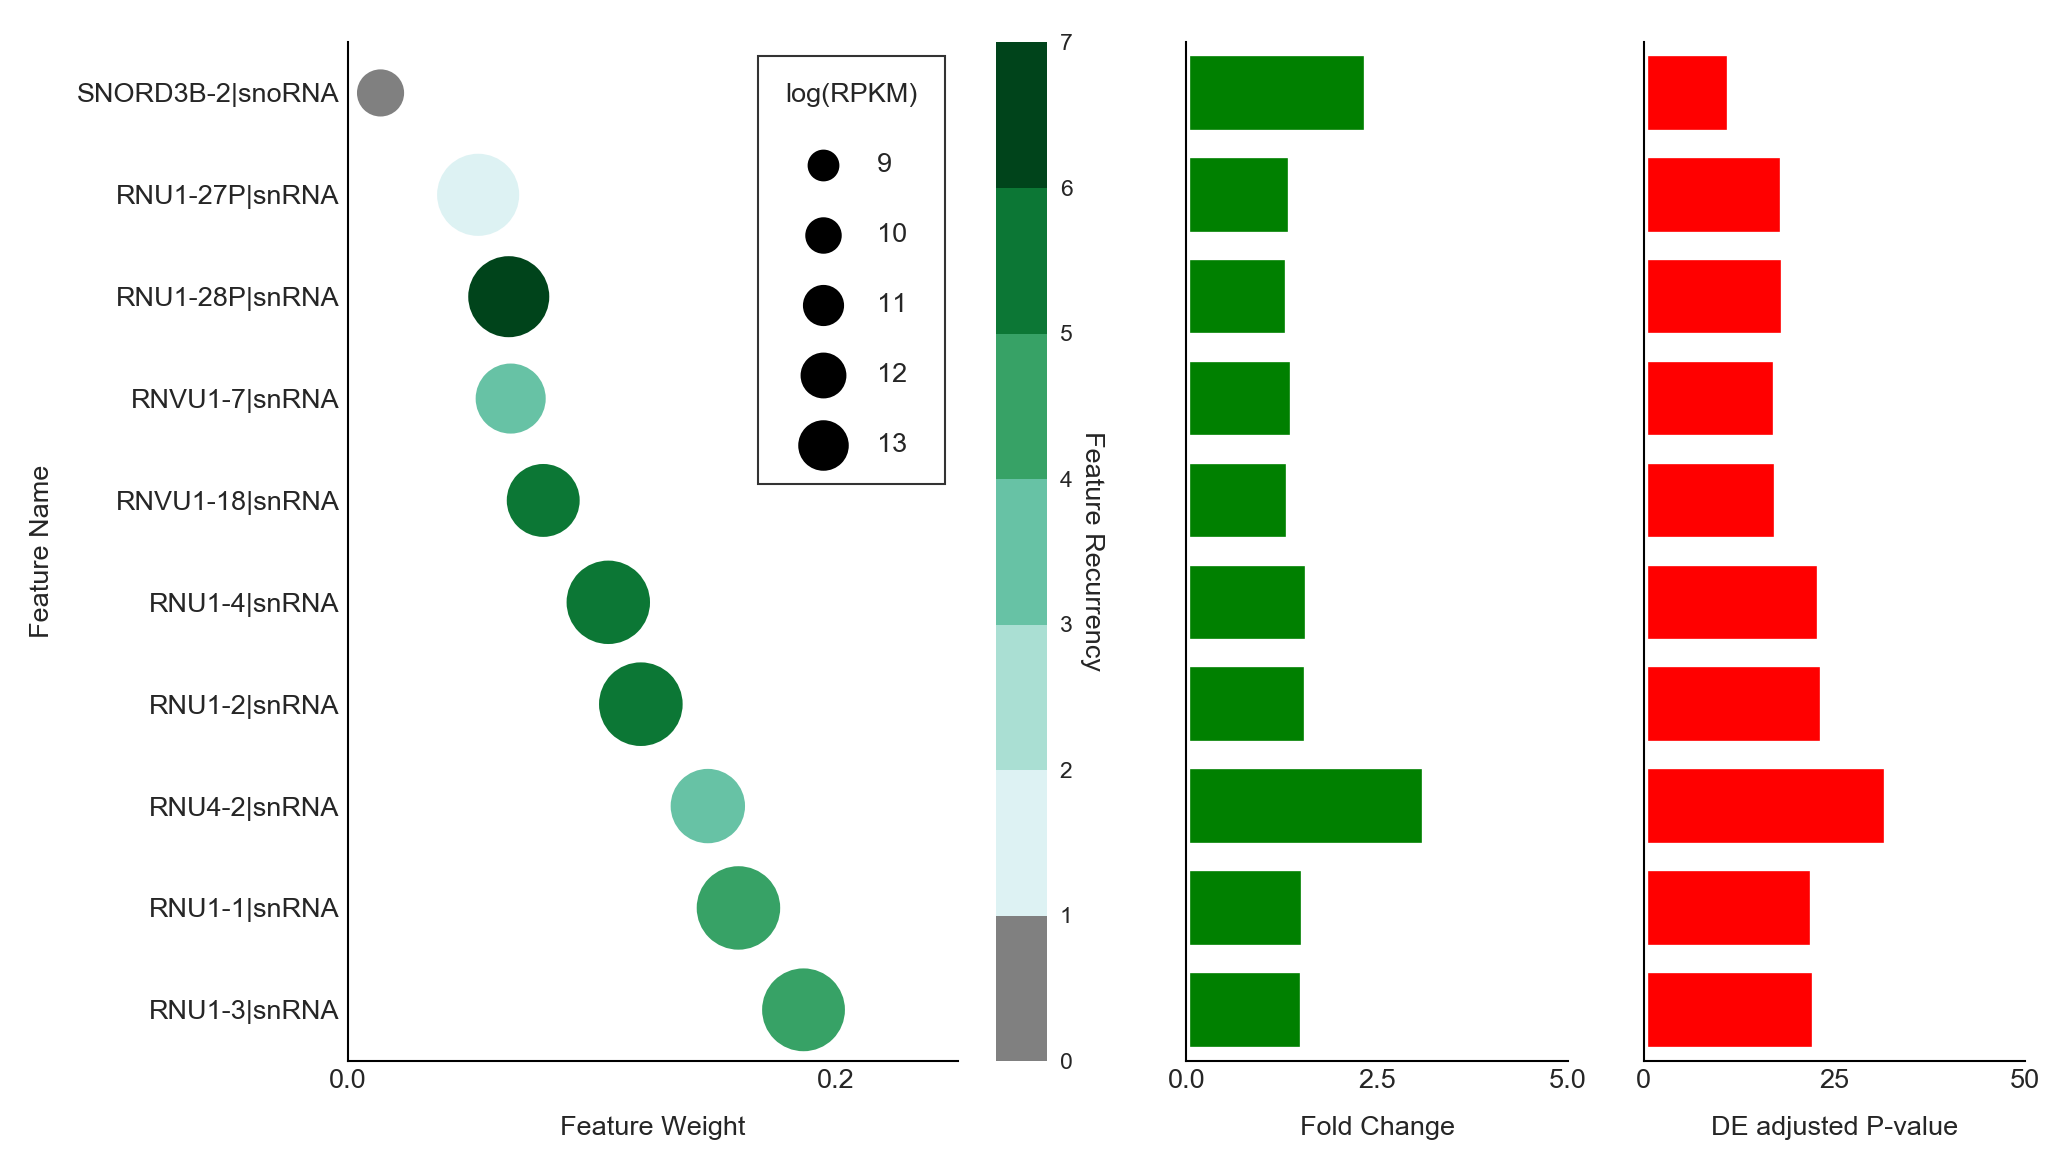

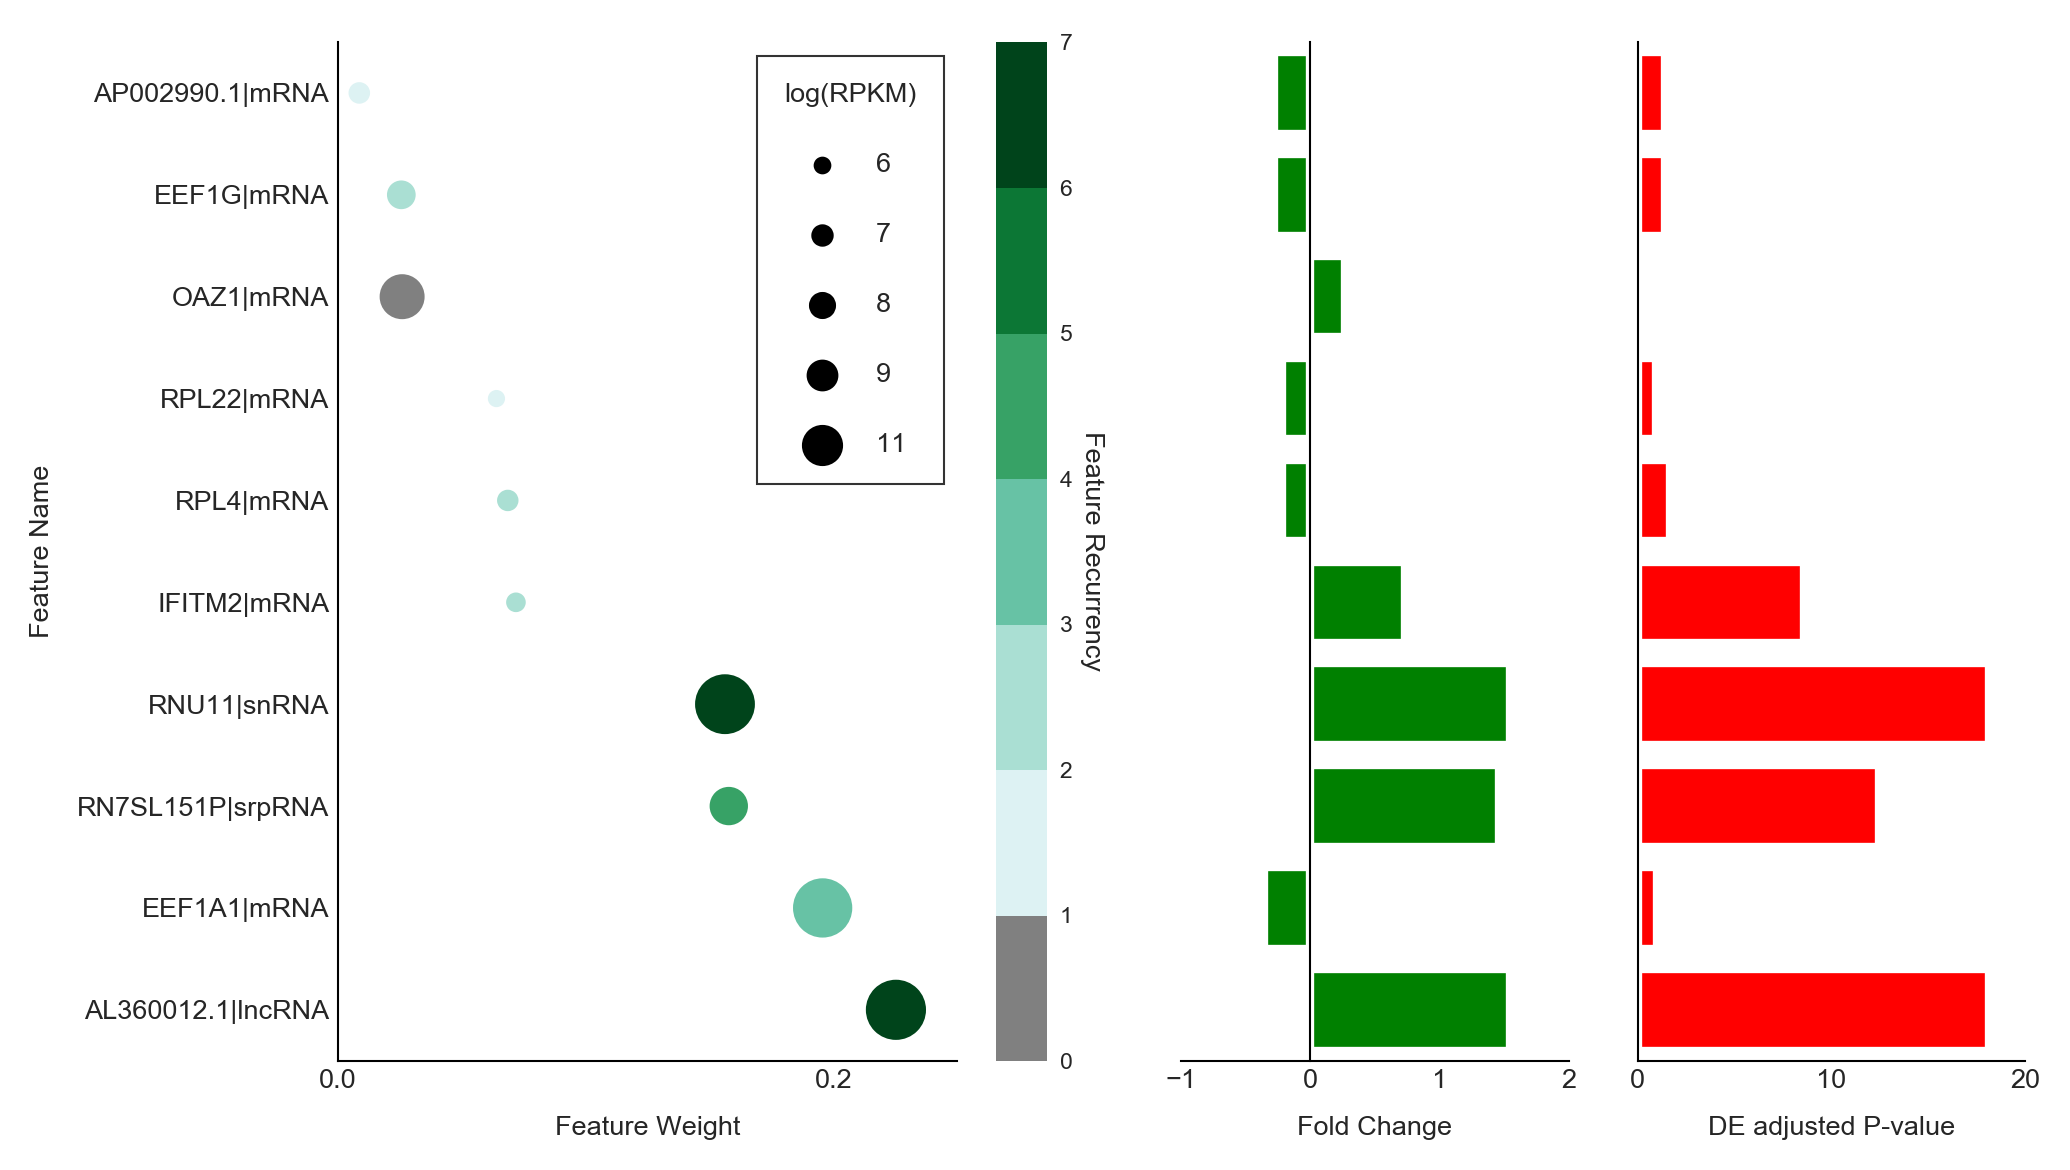

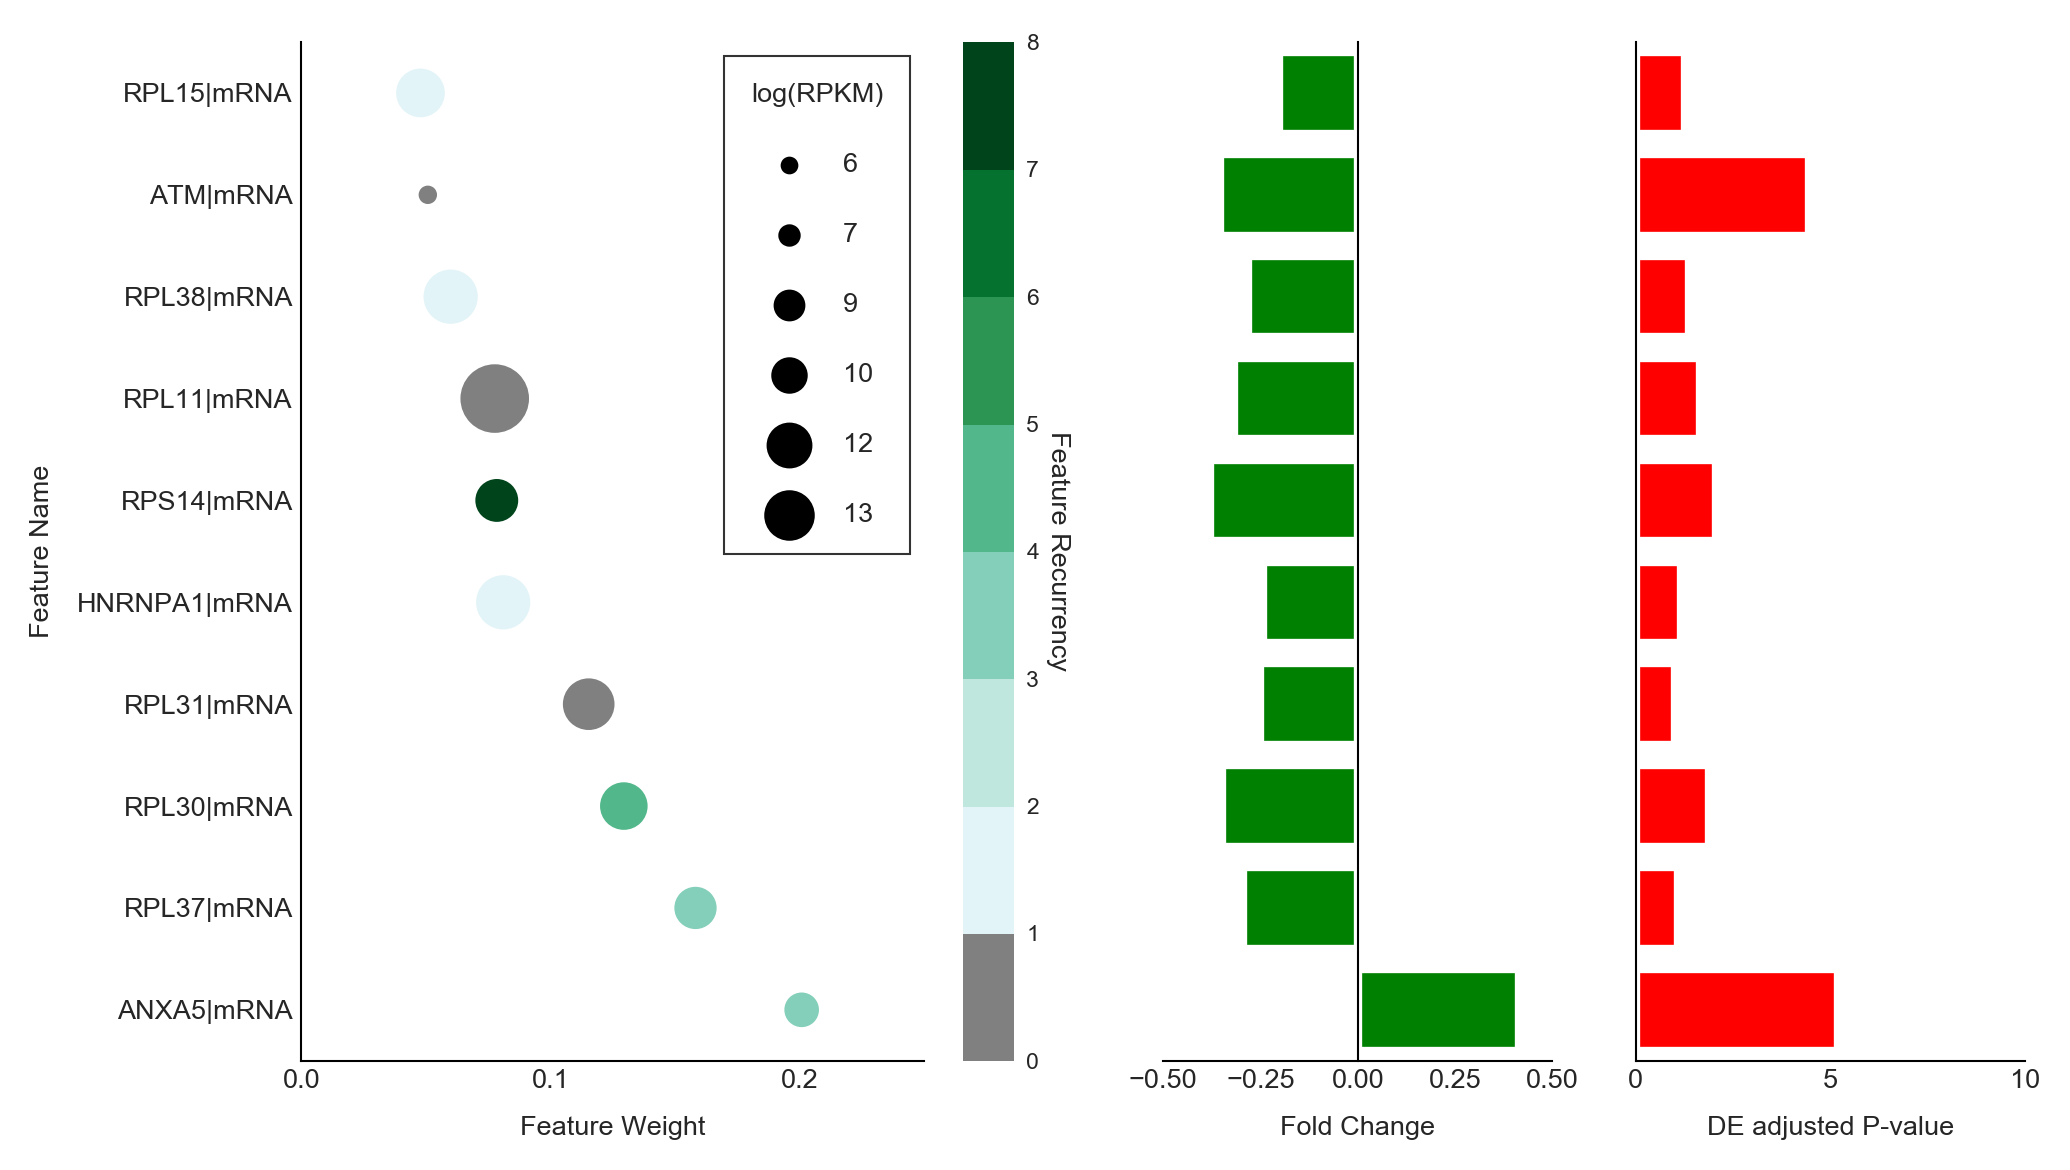

In [19]:
def feature_weight_bar_(feature_weight_table,detable,nums_retain=10,rpkmtable=rpkmtable,
                        original_index=original_index, savepath=savepath,savefig=True,
                        compare_group=compare_group,scalefactor=0.1,area_=(8.0,9.0),namelength=2):
    feature_weight_table = pd.concat(( feature_weight_table,(feature_weight_table.iloc[:,:-1] !=0).sum(axis=1)),axis=1)
    #display(feature_weight_table)
    selected_table = feature_weight_table.iloc[:,nums_retain-1:]
    #display(selected_table,rpkmtable)
    rpkm = np.array(rpkmtable.iloc[np.where(selected_table.iloc[:,0]!=0)].mean(axis=1))
    selected_feature = original_index[np.where(selected_table.iloc[:,0]!=0)]
    #print (selected_feature)
    #display(rpkmtable.iloc[np.where(selected_table.iloc[:,0]!=0)].mean(axis=1))
    
    #print (selected_feature.shape[0])
    nums_retain = min(selected_feature.shape[0],nums_retain)
    
    selected_table = selected_table.iloc[np.where(selected_table.iloc[:,0]!=0)]
    #display(selected_table)
    featurename = np.array(selected_table.index)#np.array([selected_table.index[i].split('|')[0] for  i in range(selected_table.shape[0])])
    #display(selected_table)
    #print (featurename)
    #feature_weight = np.array(feature_weight_table.sum(axis=1))
    feature_weight = np.array(selected_table.iloc[:,0])
    fc = np.array(selected_table.iloc[:,1])
    fc = fc[np.argsort(feature_weight)]
    recurrence = np.array(selected_table.iloc[:,2])
    recurrence = recurrence[np.argsort(-feature_weight)]
    #rpkm = np.array(rpkmtable.mean(axis=1))
    rpkm = rpkm[np.argsort(feature_weight)]
    deselected = -np.log10(detable.loc[selected_feature].iloc[np.argsort(feature_weight)].padj)
    #print (deselected)
    featurename = featurename[np.argsort(feature_weight)]
    #display(selected_table,featurename,rpkm)
    selected_feature = selected_feature[np.argsort(feature_weight)]
    feature_weight = np.sort(feature_weight)
    if namelength == 2:
        featurename = np.array([featurename[i].split('|')[0]+'|'+featurename[i].split('|')[1] for i in range(len(featurename))])
    if namelength == 3:
        featurename = np.array([featurename[i].split('|')[0]+'|'+featurename[i].split('|')[1]+'|'+featurename[i].split('|')[2] for i in range(len(featurename))])

    dataframe= pd.DataFrame(np.concatenate((featurename.reshape(-1,1),feature_weight.reshape(-1,1)),axis=1),columns=['name','weight'])
    #display(dataframe)
    dataframe.weight  =  pd.to_numeric(dataframe.weight)
    dataframe_= pd.DataFrame(np.concatenate((featurename.reshape(-1,1),fc.reshape(-1,1)),axis=1),columns=['name','fc'])
    dataframe_.fc  =  pd.to_numeric(dataframe_.fc)
    #dataframe__= pd.DataFrame(np.concatenate((featurename.reshape(-1,1),recurrence.reshape(-1,1)),axis=1),columns=['name','recurrence'])
    #dataframe__.recurrence  =  pd.to_numeric(dataframe__.recurrence)
    dataframe_rpkm= pd.DataFrame(np.concatenate((featurename.reshape(-1,1),np.log2(rpkm).reshape(-1,1)),axis=1),columns=['name','rpkm'])
    dataframe_rpkm.rpkm  =  pd.to_numeric(dataframe_rpkm.rpkm)
    dataframe_de= pd.DataFrame(np.concatenate((featurename.reshape(-1,1),deselected.reshape(-1,1)),axis=1),columns=['name','DE_padj'])
    dataframe_de.DE_padj  =  pd.to_numeric(dataframe_de.DE_padj)
    #display(dataframe_rpkm)
    
    #display(dataframe_)
    dataframe = dataframe.iloc[::-1]
    dataframe_rpkm = dataframe_rpkm.iloc[::-1]
    #dataframe_de =  dataframe_de.iloc[::-1]
    #display(dataframe_de)
    fig, (ax, ax1,ax2) = plt.subplots(1,3, figsize=(7,4),gridspec_kw = {'width_ratios':[2, 1,1]})
    #scalefactor=0.1
    #print (dataframe_rpkm.shape)
    print (recurrence)
    #cmaps = sns.cubehelix_palette(10, start=0.1,rot=-0.2)
    #ax.scatter(dataframe.weight, np.arange(nums_retain),
     #           c = np.array(sns.cubehelix_palette(10, start=0.1,rot=-0.2))[recurrence-1], s=(dataframe_rpkm.rpkm)*scalefactor)
    #cmap = plt.get_cmap("viridis")
    cmap = plt.cm.BuGn#"viridis"
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # force the first color entry to be grey
    cmaplist[0] = (.5,.5,.5,1.0)
    # create the new map
    cmaps = cmap.from_list('Custom cmap', cmaplist, cmap.N)
    # define the bins and normalize
    bounds = np.linspace(0,recurrence.max(),recurrence.max()+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    #display(dataframe,dataframe_rpkm,np.log2(rpkmtable.iloc[np.where(selected_table.iloc[:,0]!=0)].mean(axis=1)))
    im = ax.scatter(dataframe.weight, np.arange(nums_retain),cmap=cmaps,norm=norm,
            c = recurrence-1, s=(((dataframe_rpkm.rpkm)/area_[0]-0.5)*area_[1])**2.5)
    #display(dataframe.weight,np.arange(nums_retain),dataframe_rpkm.rpkm)
    cbar =fig.colorbar(im, ax=ax)#,drawedges=True
    cbar.outline.set_visible(False)
    #cbar.set_label('Feature Recurrency',weight='bold')
    #ax.set_xlabel("weight",fontsize=30,fontdict=dict(weight='bold'))
    #ax.set_ylabel("name",fontsize=30,fontdict=dict(weight='bold'))
    ax.set_yticks(np.arange(10))
    ax.set_yticklabels(featurename[::-1])
    if sequencing_type =='short':
        mattype = 'Log CPM'
    elif sequencing_type =='long':
        mattype = 'Log RPKM'
    #make a legend:
   # pws = np.round(np.array([np.min(dataframe_rpkm.rpkm),np.percentile(dataframe_rpkm.rpkm,0.2),
   #                np.percentile(dataframe_rpkm.rpkm,0.4),np.percentile(dataframe_rpkm.rpkm,0.6),
   #                np.percentile(dataframe_rpkm.rpkm,0.8),np.max(dataframe_rpkm.rpkm)]),2)
    interval = np.max(dataframe_rpkm.rpkm) - np.min(dataframe_rpkm.rpkm)
    ratiointer = interval/4
    #pws = np.round(np.arange(np.min(dataframe_rpkm.rpkm),np.max(dataframe_rpkm.rpkm)+ratiointer,ratiointer),0).astype(int)
    pws = set(np.round(np.arange(np.min(dataframe_rpkm.rpkm),np.max(dataframe_rpkm.rpkm)+ratiointer,ratiointer),0).astype(int))
    for pw in pws:
        ax.scatter([], [], s=((pw/area_[0]-0.5)*area_[1])**2, c="k",label=str(pw))
        
    #h,l = ax.get_legend_handles_labels()
    
    #ax.set_yticklabels(np.arange(5,11)/10,fontticklabel)
    #ax.set_xticklabels(np.concatenate((np.arange(1,10),np.arange(10,60,10))).astype('str'),fontticklabel)
    
    #mpl.rcParams['title_fontsize']=6
    #ax.legend(h[1:], l[1:], labelspacing=2, title=mattype, borderpad=1,  fontsize=20,
    #            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w",prop={'size':25,'weight':'bold'})
    sns.barplot(ax=ax1,data=dataframe_,y='name',x='fc',color='g',saturation=1)
    sns.barplot(ax=ax2,data=dataframe_de,y='name',x='DE_padj',color='r',saturation=1)

    #ax = std_plot(ax,'Feature Weight','Feature Name',None,'log CPM',borderpad=2)
    ax = std_plot(ax,'Feature Weight','Feature Name',None,'log(RPKM)',
                  borderpad=1,labelspacing=1.7,handletextpad=1,cbar=cbar,cbarlabel='Feature Recurrency',
                  xlim=[0,0.25],ylim=[-0.5,nums_retain-0.5])
    #cbar.set_linewiths(5)
    
    
    ax1 = std_plot(ax1,'Fold Change','',None,moveyaxis=True)
    #print(ax1.get_xticklabels())
    ax2 = std_plot(ax2,'DE adjusted P-value','',None,None)
    ax1.set_yticks([])
    ax2.set_yticks([])
    #ax1.get_yaxis().set_ticks([])
    #ax2.get_yaxis().set_ticks([])
    fig.tight_layout()
    if savefig:
        fig.savefig(savepath+'weight_fc_barplot_'+compare_group+'.pdf')#, bbox_inches='tight')
    return  selected_feature


plt.rcParams['figure.dpi'] = 300    
selected_features = {}
count = 0
scalefactor=np.array([0.6,0.6,0.5])*300
for compare_group, preprocess_method in tqdm(best_preprocess_methods.items()):  
    if sequencing_type =='short':
        tmptable = cpmtable[compare_group]
    elif sequencing_type =='long':
        tmptable = rpkmtable[compare_group]
    detable = pd.read_table('output/'+dataset+'/differential_expression/'+exp_mx_name+'/'+compare_group+'/deseq2.txt'
                       ,index_col=0) 
    #display(detable)
    selected_features[compare_group] = feature_weight_bar_(feature_matrix[compare_group],detable,
                    10,original_index=original_index[compare_group],rpkmtable=tmptable,
                                    compare_group=compare_group,scalefactor=scalefactor[count],area_=(8.0,9.0),namelength=2)
    count+=1

In [17]:
savepath

'output/candidate/exorbase/exorbase.2019.1.9.17:18/'

## ROC: selected feature classification result

In [190]:
def find_metrics_best_for_shuffle(fpr,tpr):
    '''
    used for shuffle roc plot
    '''
    a = 1 - fpr 
    b = tpr
    Sensitivity = b
    Specificity = a
    arith_mean = (Sensitivity+Specificity)*0.5
    geo_mean = (Sensitivity*Specificity)**0.5
    harmo_mean = 2/(1/Sensitivity+1/Specificity)
    eucilid_mean = ((1-Sensitivity)**2+(1-Specificity)**2)**0.5
    auc = sklearn.metrics.auc(a,b)
    thres = 1
    uni,counts= np.unique(np.concatenate((np.argsort(-arith_mean)[:thres],np.argsort(-geo_mean)[:thres],np.argsort(-harmo_mean)[:thres],
                np.argsort(-eucilid_mean)[:thres])),return_counts=True)
    #print (np.max(counts))
    if np.where(counts ==np.max(counts))[0].shape[0] >1:
        ind =1
    else:
        ind =0
    return auc,Sensitivity[uni[np.where(counts ==np.max(counts))][ind]],Specificity[uni[np.where(counts ==np.max(counts))][ind]]
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

def get_probs_split(filename,interpolatednum=10000,confidence=0.95):
    '''
    get probs from split
    use interpolation to calculate CI
    '''
    xvals = np.linspace(0, 1, interpolatednum)
    with h5py.File(filename,'r') as f:
        predictions =  f['predictions'][:]
        train_index =  f['train_index'][:]
        label = f['labels'][:]
    probs,labels,interpolatedvalue = {},{},{}
    for i in range(predictions.shape[0]):
        probs[i] = predictions[i][~train_index[i]]
        labels[i] = label[~train_index[i]]
        interpolatedvalue[i] = np.interp(xvals,plot_roc( probs[i],labels[i])[1],plot_roc( probs[i],labels[i])[2] )
    interarray = np.array([interpolatedvalue[i]  for i in range(predictions.shape[0])])
    mean,minimum,maximum = np.ndarray([interpolatednum]),np.ndarray([interpolatednum]),np.ndarray([interpolatednum])
    for i in range(interpolatednum):
        mean[i],minimum[i],maximum[i] = mean_confidence_interval(interarray[:,i],confidence)
    return np.concatenate((np.zeros(1),mean,np.ones(1))),np.concatenate((np.zeros(1),minimum,np.ones(1))),\
np.concatenate((np.zeros(1),maximum,np.ones(1))),interpolatednum+2
def plot_roc(prob,label):
    fpr, tpr, _ = roc_curve(label, prob)
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    return roc_auc,fpr, tpr
def find_metrics_best(label,expressionlevel):
    posinum = np.sum(label)
    neganum = label.shape[0] - np.sum(label)
    a,b,c= roc_curve(label,expressionlevel) #fpr tpr threshold
    fp = a*neganum
    tp = b*posinum
    tn = (1-a)*neganum
    fn = (1-b)*posinum
    #Sensitivity = tp/(tp+fn) 
    #Specificity = tn/(tn+fp) 
    Sensitivity = b
    Specificity = 1 - a
    PPV = tp/(tp+fp) 
    NPV = tn/(tn+fn) 
    arith_mean = (Sensitivity+Specificity)*0.5
    geo_mean = (Sensitivity*Specificity)**0.5
    harmo_mean = 2/(1/Sensitivity+1/Specificity)
    eucilid_mean = ((1-Sensitivity)**2+(1-Specificity)**2)**0.5
    mcc_mean = (tp*tn-fp*fn)/(((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5)
    F1_score = 2*tp/(2*tp+fn+fp)
    auc = sklearn.metrics.auc(a,b)
    acc = (tp+tn)/(tp+tn+fn+fp)
    distoleftup = (a**2+(1-b)**2)**0.5# to the left up
    #print ("AUC:" +str(auc)) 
    thres = int(label.shape[0]/10.) if int(label.shape[0]/10.)>0 else 1
    uni,counts= np.unique(np.concatenate((np.argsort(-arith_mean)[:thres],np.argsort(-geo_mean)[:thres],np.argsort(-harmo_mean)[:thres],
                np.argsort(-eucilid_mean)[:thres],np.argsort(-mcc_mean)[:thres],np.argsort(-F1_score)[:thres])),return_counts=True)
    #print (np.max(counts))
    if np.where(counts ==np.max(counts))[0].shape[0] >1:
        ind =1
    else:
        ind =0
    return auc,Sensitivity[uni[np.where(counts ==np.max(counts))][ind]],Specificity[uni[np.where(counts ==np.max(counts))][ind]]
def get_auc_stats(root_path,sample_path):
    '''
    sample_path:hccpath,stagepath
    '''
    auc_metrics_jack = {}
    auc_metrics_split = {}
    for i in os.listdir(root_path+sample_path):
        #print (i)
        try:
            print (i, ' file found')
            if i.split('.')[-1] == 'shuffle_split':
                auc_metrics_split[i] = h5py.File(root_path+sample_path+i+'/evaluation.shuffle_split.h5')
            else:
                with h5py.File(root_path+sample_path+i+'/evaluation.leave_one_out.h5','r') as f:
                    predictions =  f['predictions'][:]
                    train_index =  f['train_index'][:]
                    auc_metrics_jack[i]  = predictions[~train_index]
        except:
            print (i, ' file not found')
            print ('files in the directory: ',os.listdir(root_path+sample_path+i))
    return auc_metrics_jack,auc_metrics_split
def get_speci_sensi(filename,spe_criteria=0.99):
    mean,minimum,maximum,interpolatednum = get_probs_split(filename)
    total_nums = mean.shape[0]
    index = round(total_nums *(1-spe_criteria))
    return mean[index],minimum[index],maximum[index]



In [191]:
def plot_shuffle(ax,filename,show_metrics=False,savefigure=False,title=None,
                 spe_criter=0.99,savepath=savepath,savefig=True,
                 compare_group=compare_group,markers_file=None,marker_roc_ind = np.array([0]),markername=None):
    '''
    samplepath: hccpath
    filename: 'logistic_regression.100.robust.stratified_shuffle_split/evaluation.stratified_shuffle_split.h5'
    '''  
    if markers_file is not None:
        markers_auc = {}
        for i in range(markers_file.shape[0]):
            mean,_,_,interpolatednum = get_probs_split(markers_file[i])
            xvals = np.linspace(0, 1, interpolatednum)  
            auc,sen,spe = find_metrics_best_for_shuffle(xvals,mean) #tpr,1-fpr
            if np.isin(i,marker_roc_ind):
                ax.plot(xvals,mean,linewidth=2.5,color='gray',label=markername[i]+' AUC: '+str(np.round(auc,3)))
            markers_auc[i],_,_ = find_metrics_best_for_shuffle(xvals,mean)
    mean,minimum,maximum,interpolatednum = get_probs_split(filename)
    xvals = np.linspace(0, 1, interpolatednum)
    ax.fill_between(xvals,minimum,maximum,where=(minimum<=maximum),color='b',alpha=0.1)   
    auc,sen,spe = find_metrics_best_for_shuffle(xvals,mean) #tpr,1-fpr
    candidatevalue = auc
    numind = np.ceil((1-spe)/(1./(interpolatednum-2))).astype('int')
    ax.plot(xvals,mean,linewidth=4,color=Category20c[20][0],label='candidate AUC: '+str(np.round(auc,3)))
    ax.plot(xvals,minimum,linewidth=1,color='b')
    ax.plot(xvals,maximum,linewidth=1,color='b')
    sen_criter = get_speci_sensi(filename,spe_criteria=spe_criter)[0]
    if show_metrics:
        if sen+0.2<=0.95:
            ax.annotate('Specificity '+str('%0.4s'%(spe)), xy=( 1-spe,sen), xytext=(1-spe, sen+0.2),
            arrowprops=dict(facecolor='black', shrink=0.05,width=1.5,headwidth=6.5),
            )
        else:
            ax.annotate('Specificity '+str('%0.4s'%(spe)), xy=( 1-spe,sen), xytext=(1-spe+0.05, sen-0.2),
            arrowprops=dict(facecolor='black', shrink=0.05,width=1.5,headwidth=6.5),
            )
        ax.annotate('Sensitivity '+str('%0.4s'%sen), xy=( 1-spe,sen), xytext=(1-spe+0.1, sen-0.1),
            arrowprops=dict(facecolor='black', shrink=0.1,width=1.5,headwidth=6.5),
            )
    ax.annotate('Sensitivity '+str('%0.4s'%sen_criter), xy=( 1-spe_criter,sen_criter), xytext=(1-spe_criter+0.1, sen_criter),
        arrowprops=dict(facecolor='black', shrink=0.8,width=1.5,headwidth=6.5),
        )
    ax = std_plot(ax,'False Positive Rate','True Positive Rate',title)
    ax.plot([0,1],[0,1], linewidth=2,alpha=0.6,color='gray',linestyle='--')
    ax.set_yticklabels(np.arange(0,12,2)/10,fontticklabel)
    ax.set_xticklabels(np.arange(0,12,2)/10,fontticklabel)
    if savefig:
        fig.savefig(savepath+compare_group+'_ROC.png', bbox_inches='tight')
    #return mean,minimum,maximum,interpolatednum
    
    return markers_auc,candidatevalue

In [192]:
def return_marker_file(dataset,compare_group,num,de=True):
    marker_file = np.array(['output/'+dataset+'/evaluate_features/result/'+compare_group+'/control_markers_'+str(i)+
                            '/random_forest/evaluation.stratified_shuffle_split.h5' for i in range(num) ])
    if de==True:
        marker_file = np.concatenate((marker_file,np.array(['output/'+dataset+'/evaluate_features/result/'+dataset+'.de_selected_mx/'+compare_group+
                                                            '/random_forest/evaluation.stratified_shuffle_split.h5'])))
    return marker_file

marker_roc_ind = {}
marker_roc_ind['Normal-HCC'] = np.array([6,1])
marker_roc_ind['Normal-CRC'] = np.array([-1])
marker_roc_ind['Normal-PAAD'] = np.array([-1])

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

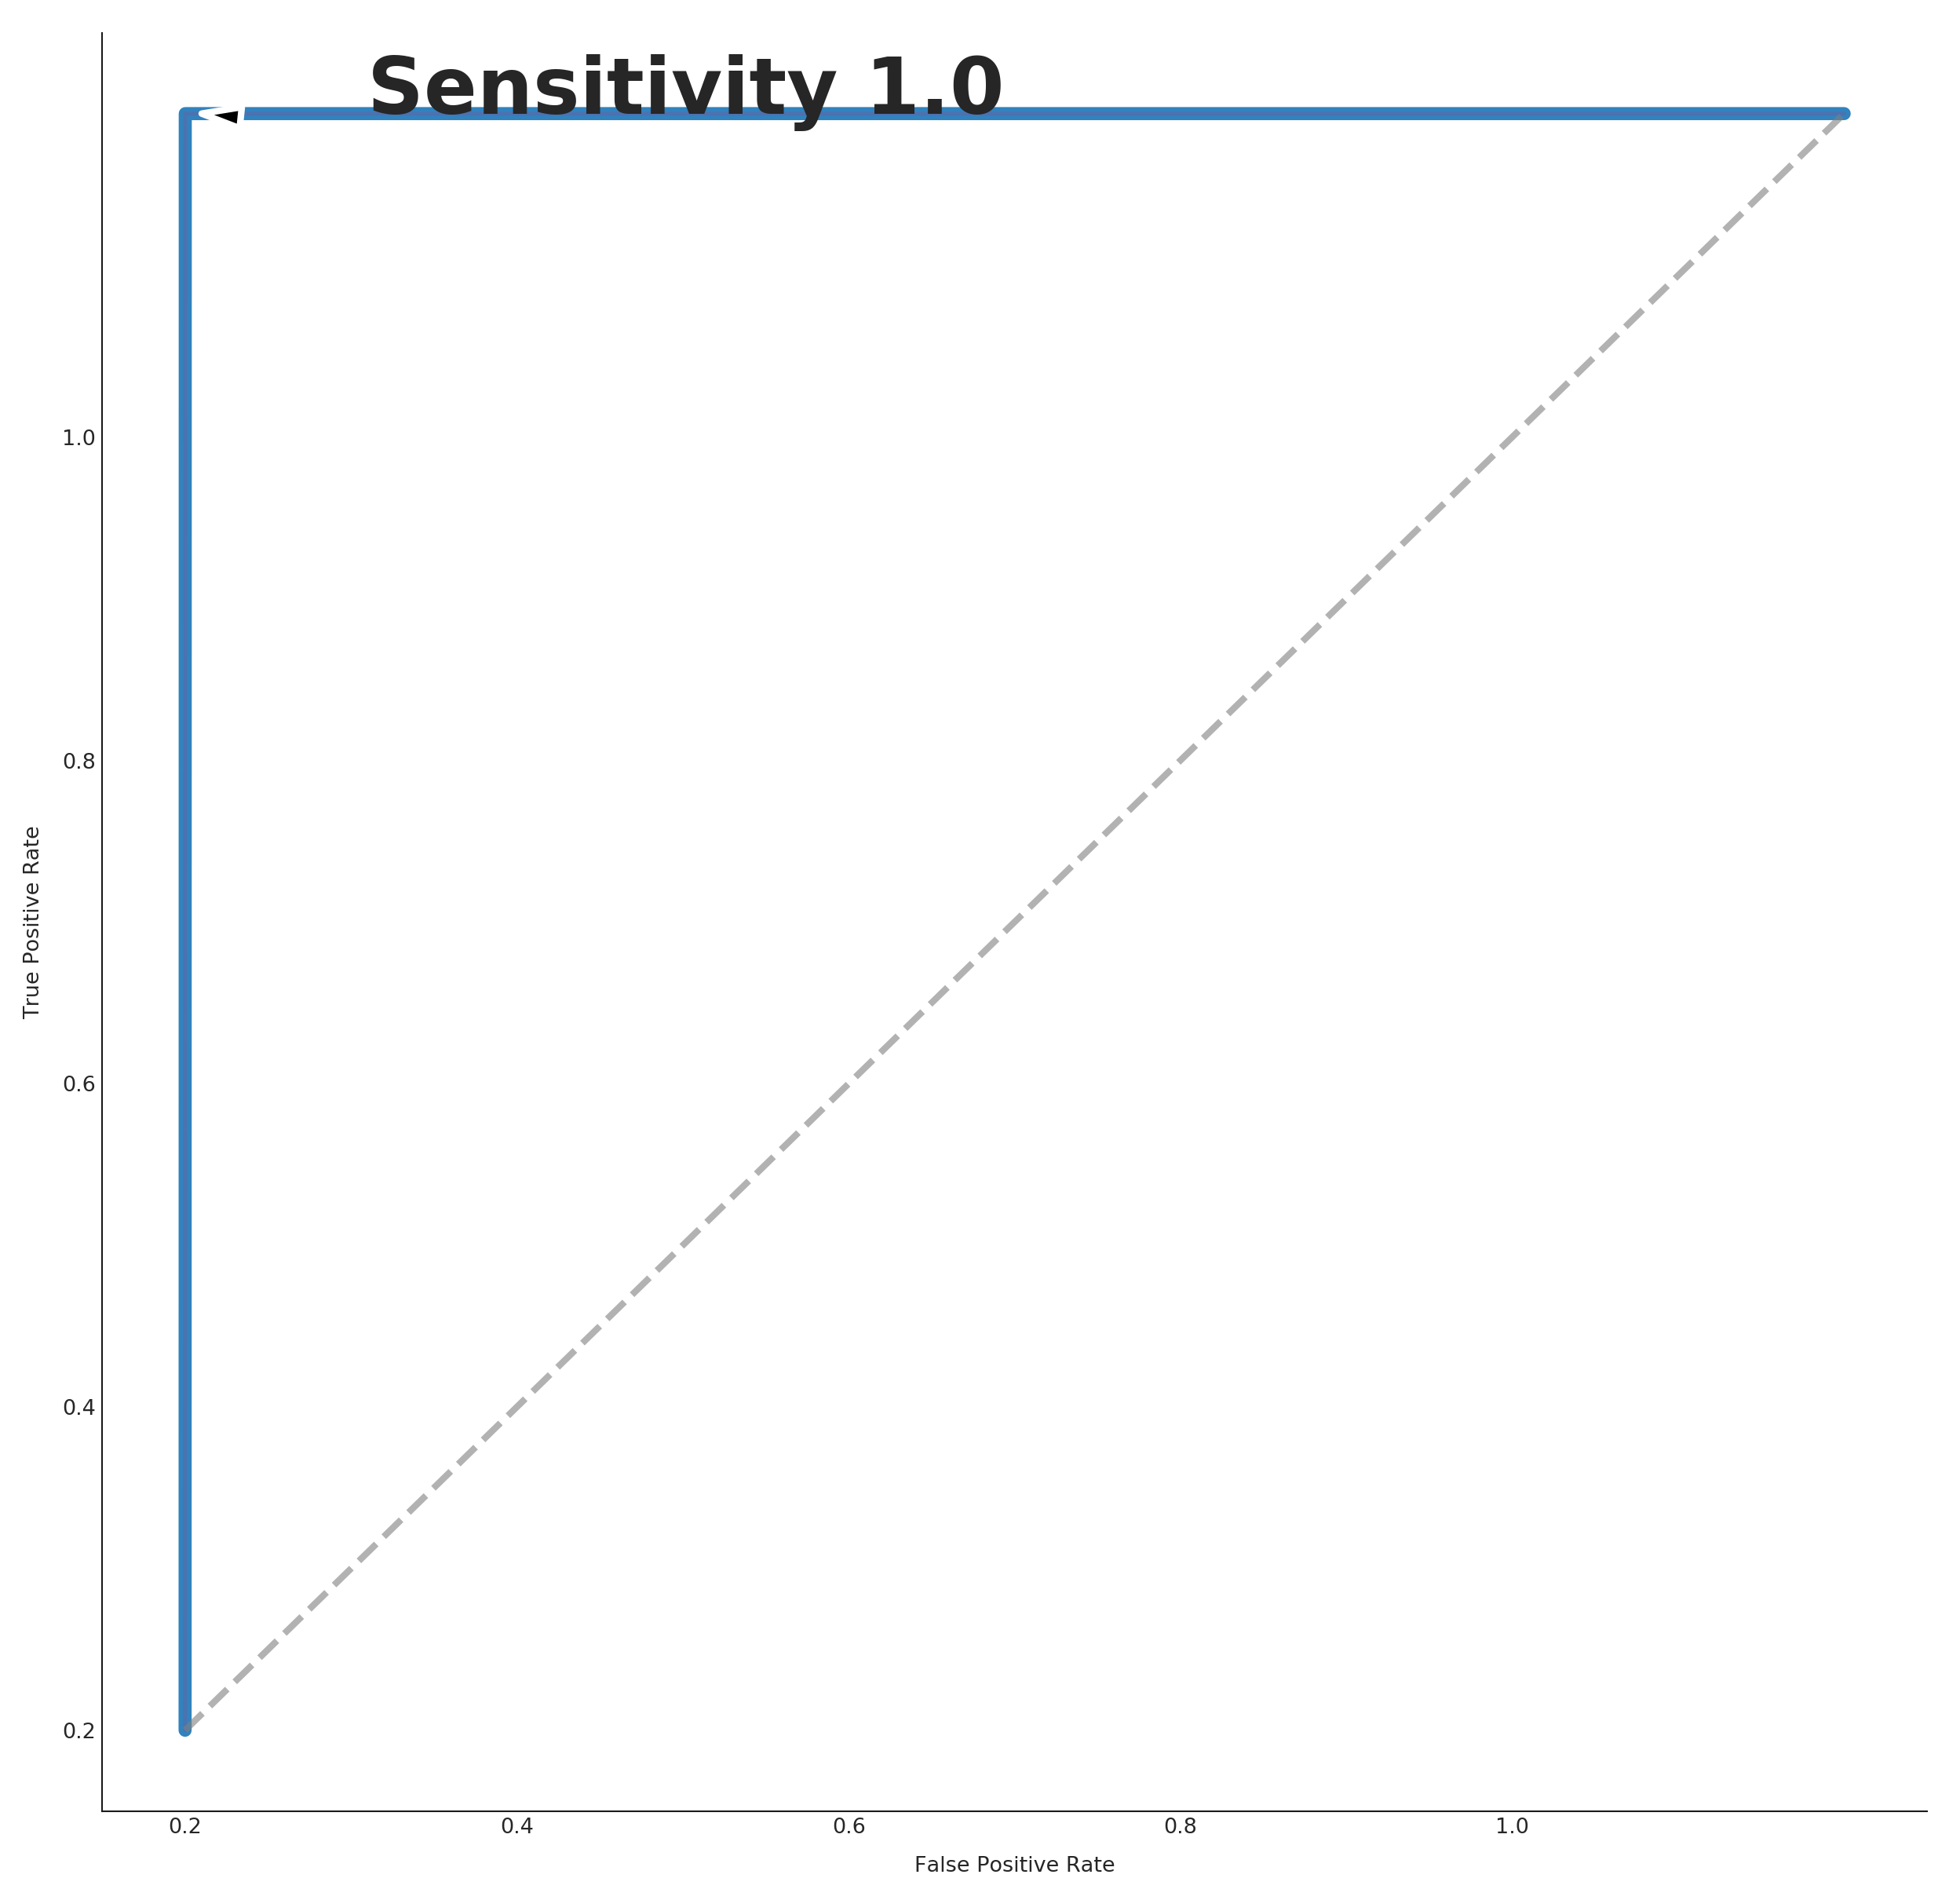

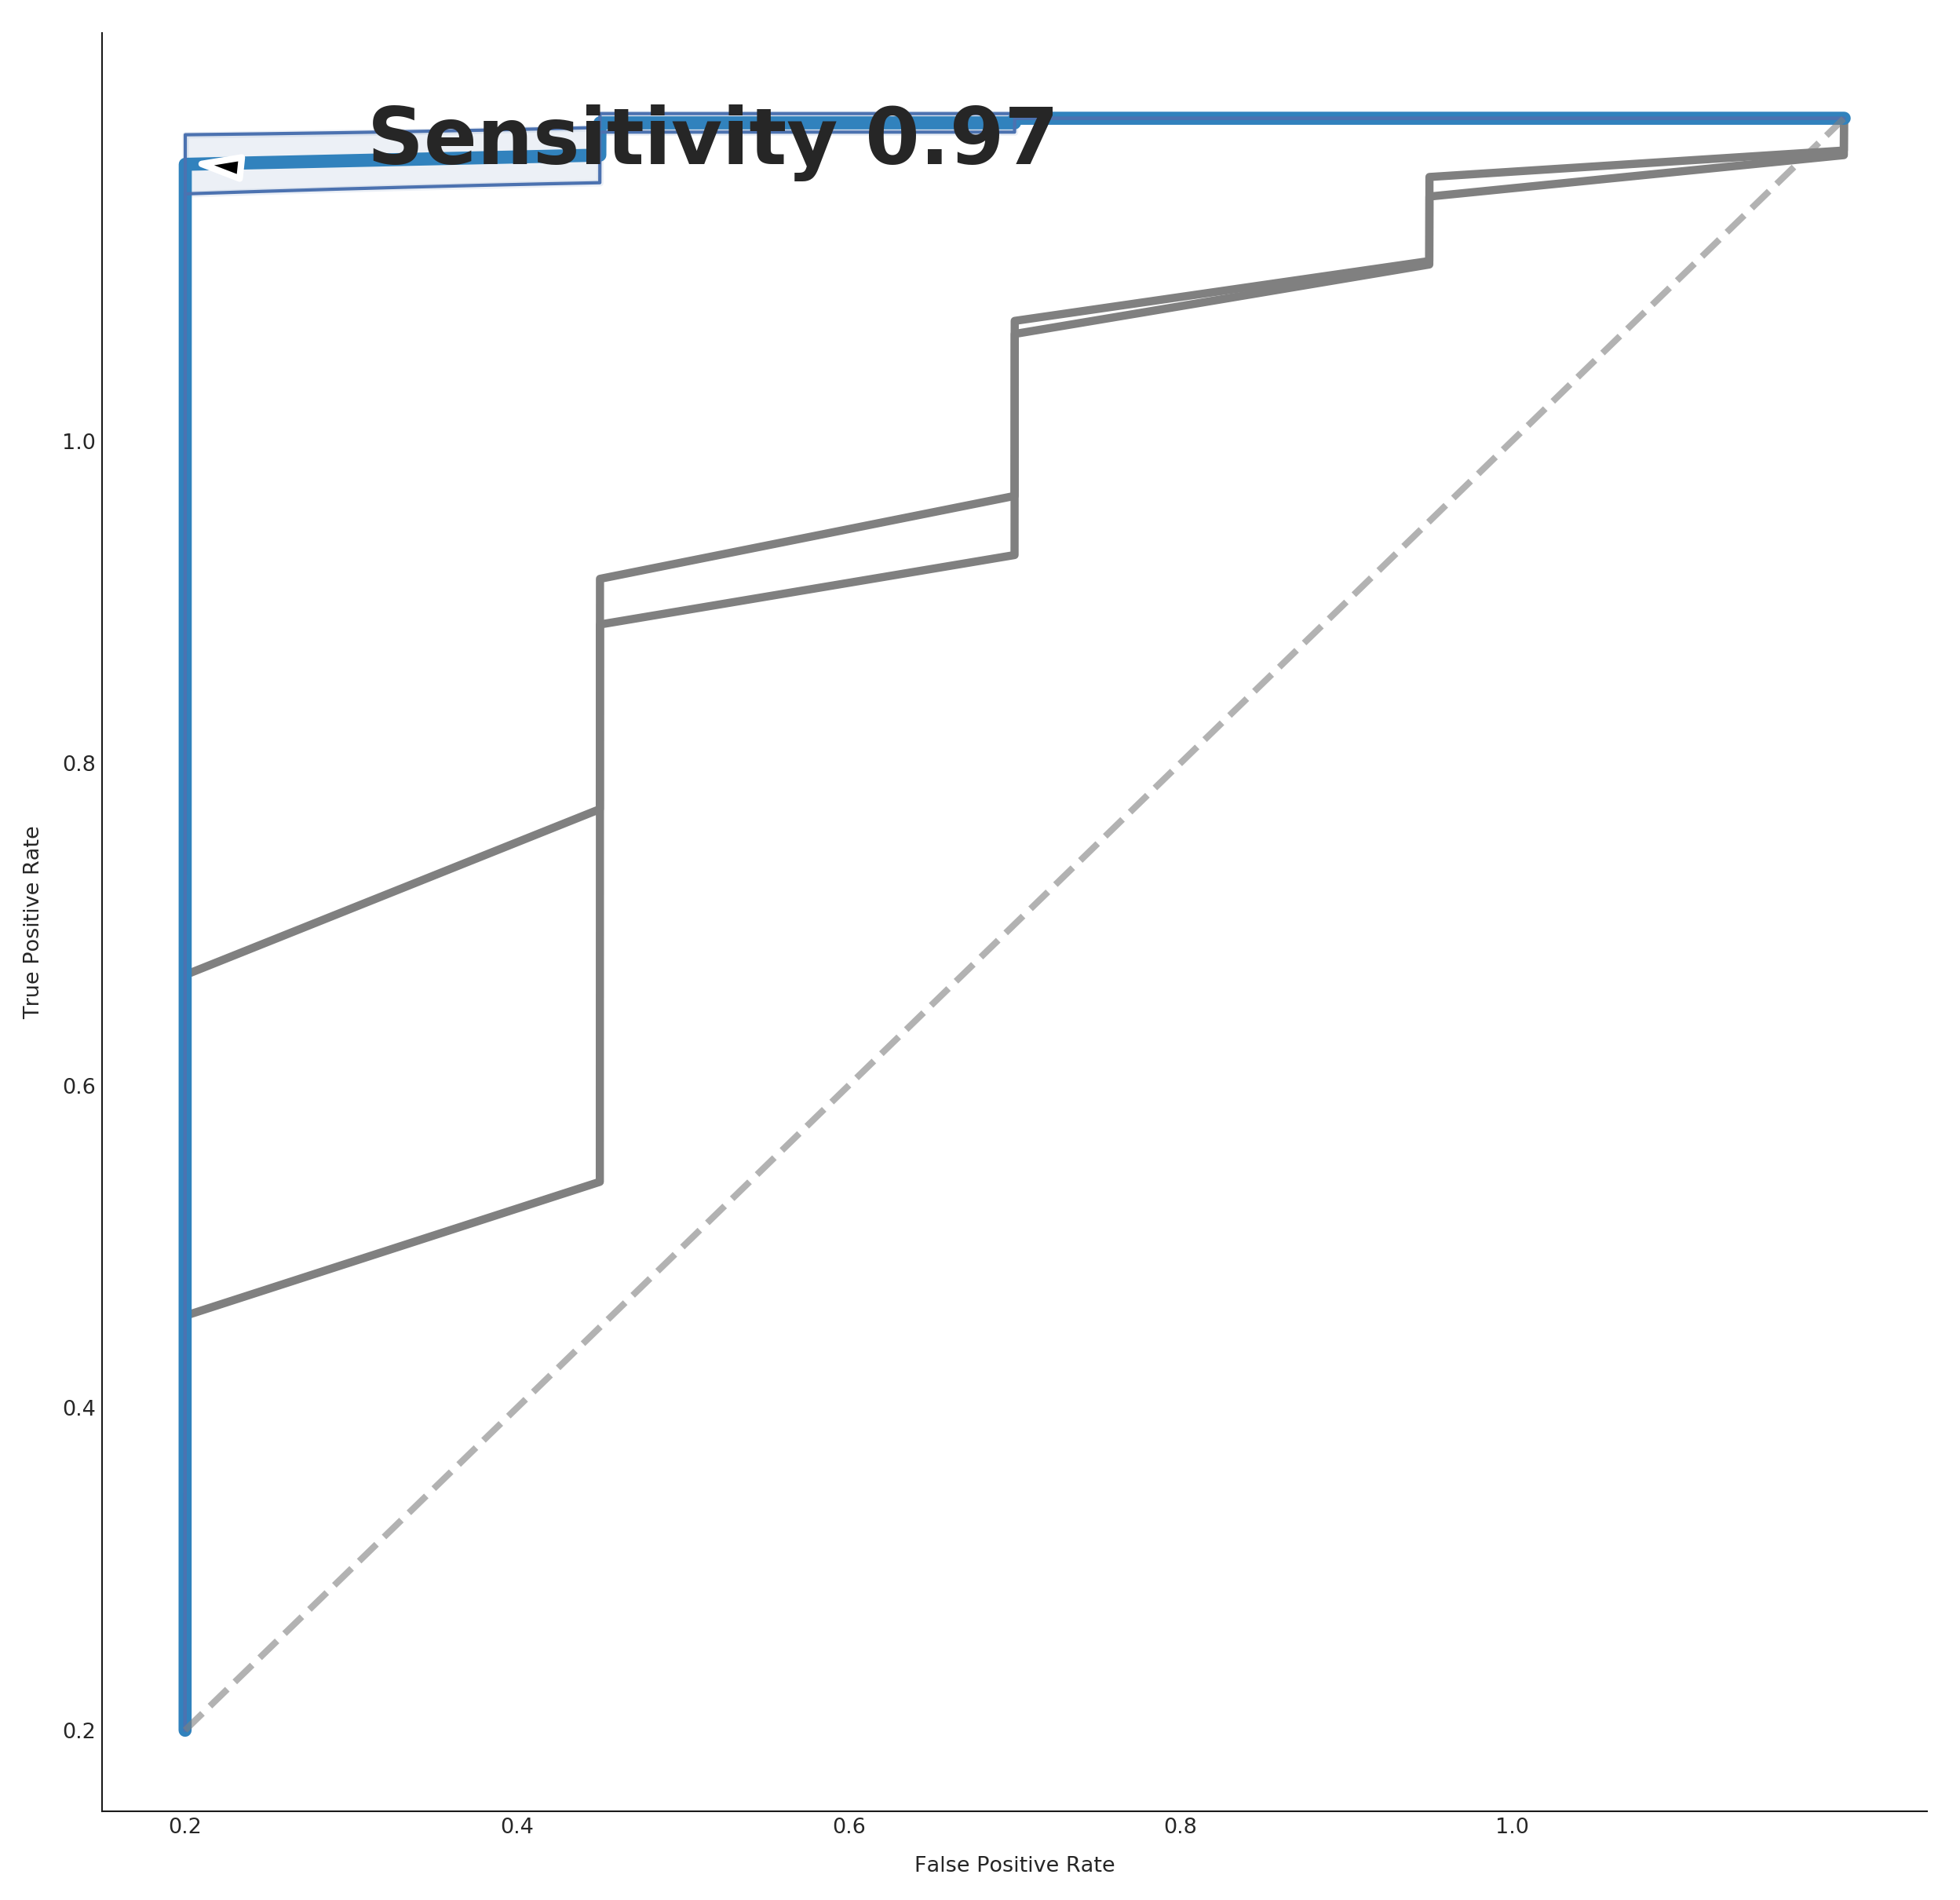

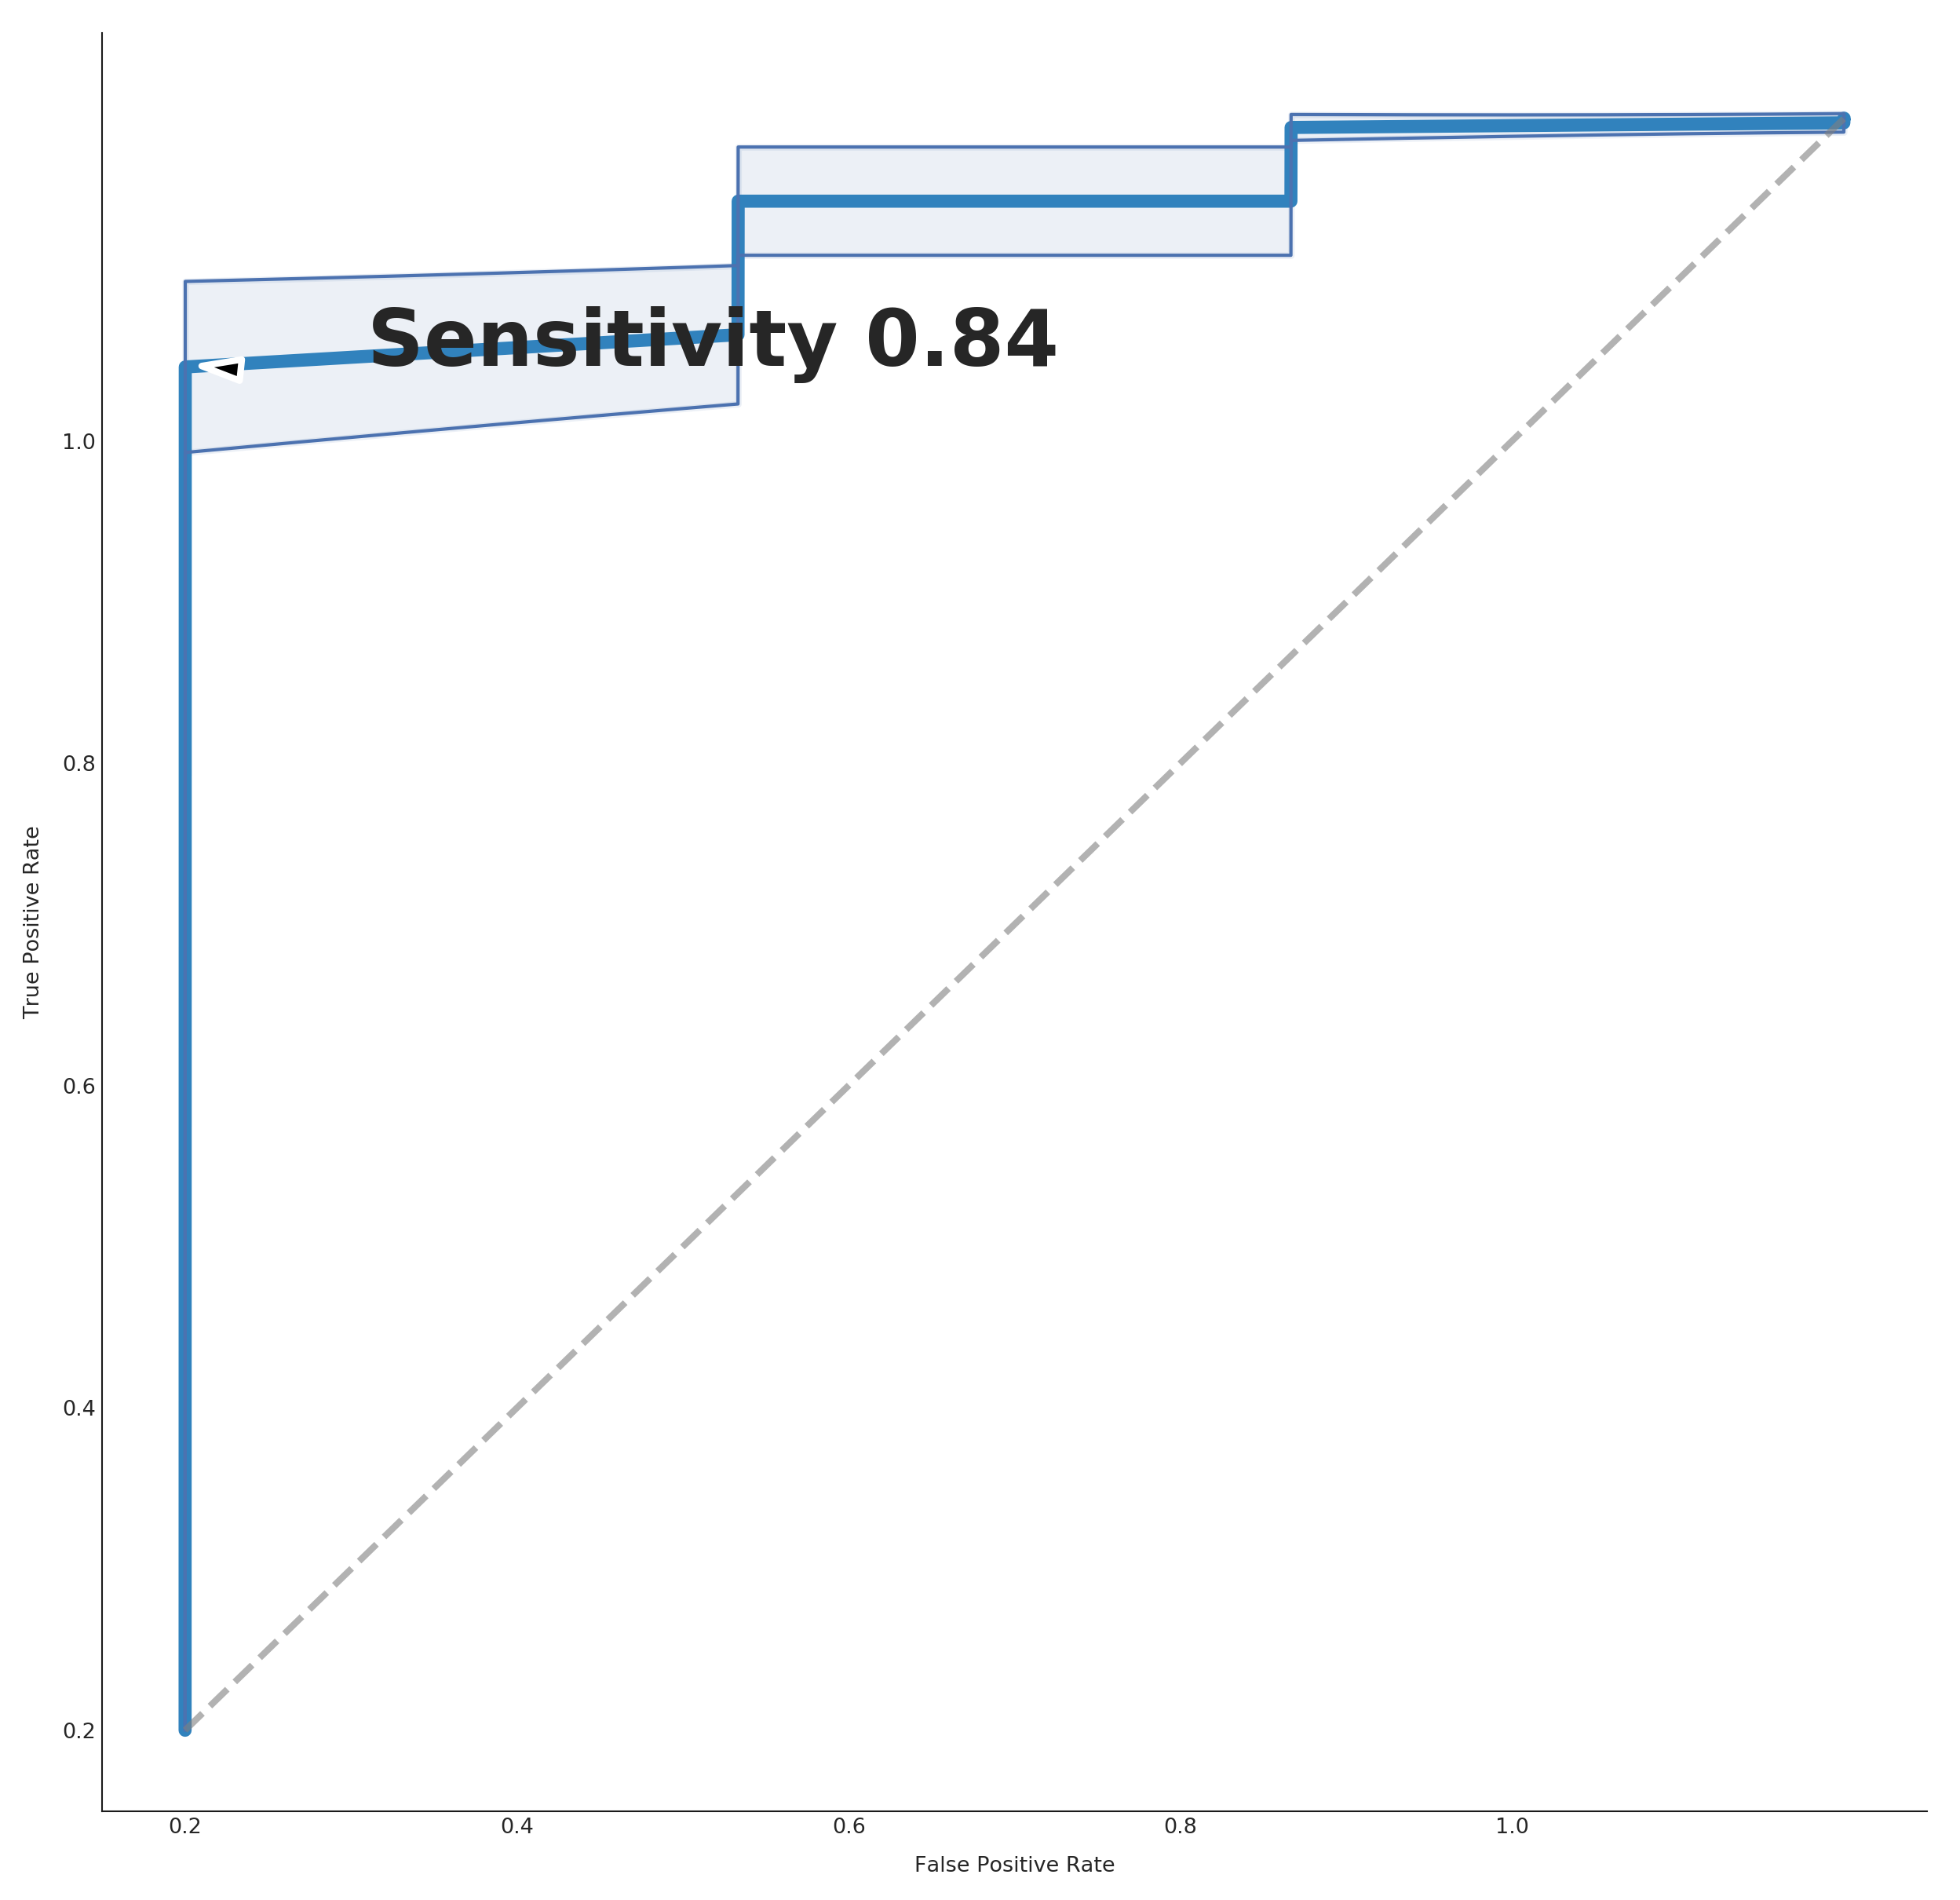

In [193]:
markers_auc = {}
candidatevalue={}
for compare_group, preprocess_method in tqdm(best_preprocess_methods.items()):
    
    shuffle_split_roc_file = 'output/'+dataset+'/feature_selection/'+preprocess_method+'/'+compare_group+'/random_forest.10.robust/'
    fig,ax=plt.subplots(1,figsize=(10,10))
    markername  = np.array([control_markers[compare_group][i][0] for i in control_markers[compare_group].keys()])
    
    if compare_group=='Normal-CRC':
        markers_auc[compare_group],candidatevalue[compare_group] =  plot_shuffle(ax,shuffle_split_roc_file+'evaluation.stratified_shuffle_split.h5',
                     spe_criter=0.99,compare_group=compare_group,
                    markers_file=return_marker_file(dataset,compare_group,len(control_markers[compare_group].keys()),de=False)
                #markers_file=return_marker_file(dataset,compare_group,1,de=False)                        
                           ,title= None,marker_roc_ind =marker_roc_ind[compare_group],markername=markername)
    else:
        markers_auc[compare_group],candidatevalue[compare_group] = plot_shuffle(ax,shuffle_split_roc_file+'evaluation.stratified_shuffle_split.h5',
                     spe_criter=0.99,compare_group=compare_group,
                   markers_file=return_marker_file(dataset,compare_group,len(control_markers[compare_group].keys()),de=False)
                #markers_file=return_marker_file(dataset,compare_group,0,de=False)  
                         ,title= None,marker_roc_ind =marker_roc_ind[compare_group],markername=markername)
        

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

7 Normal-HCC
[0 1 2 3 4 5 6]



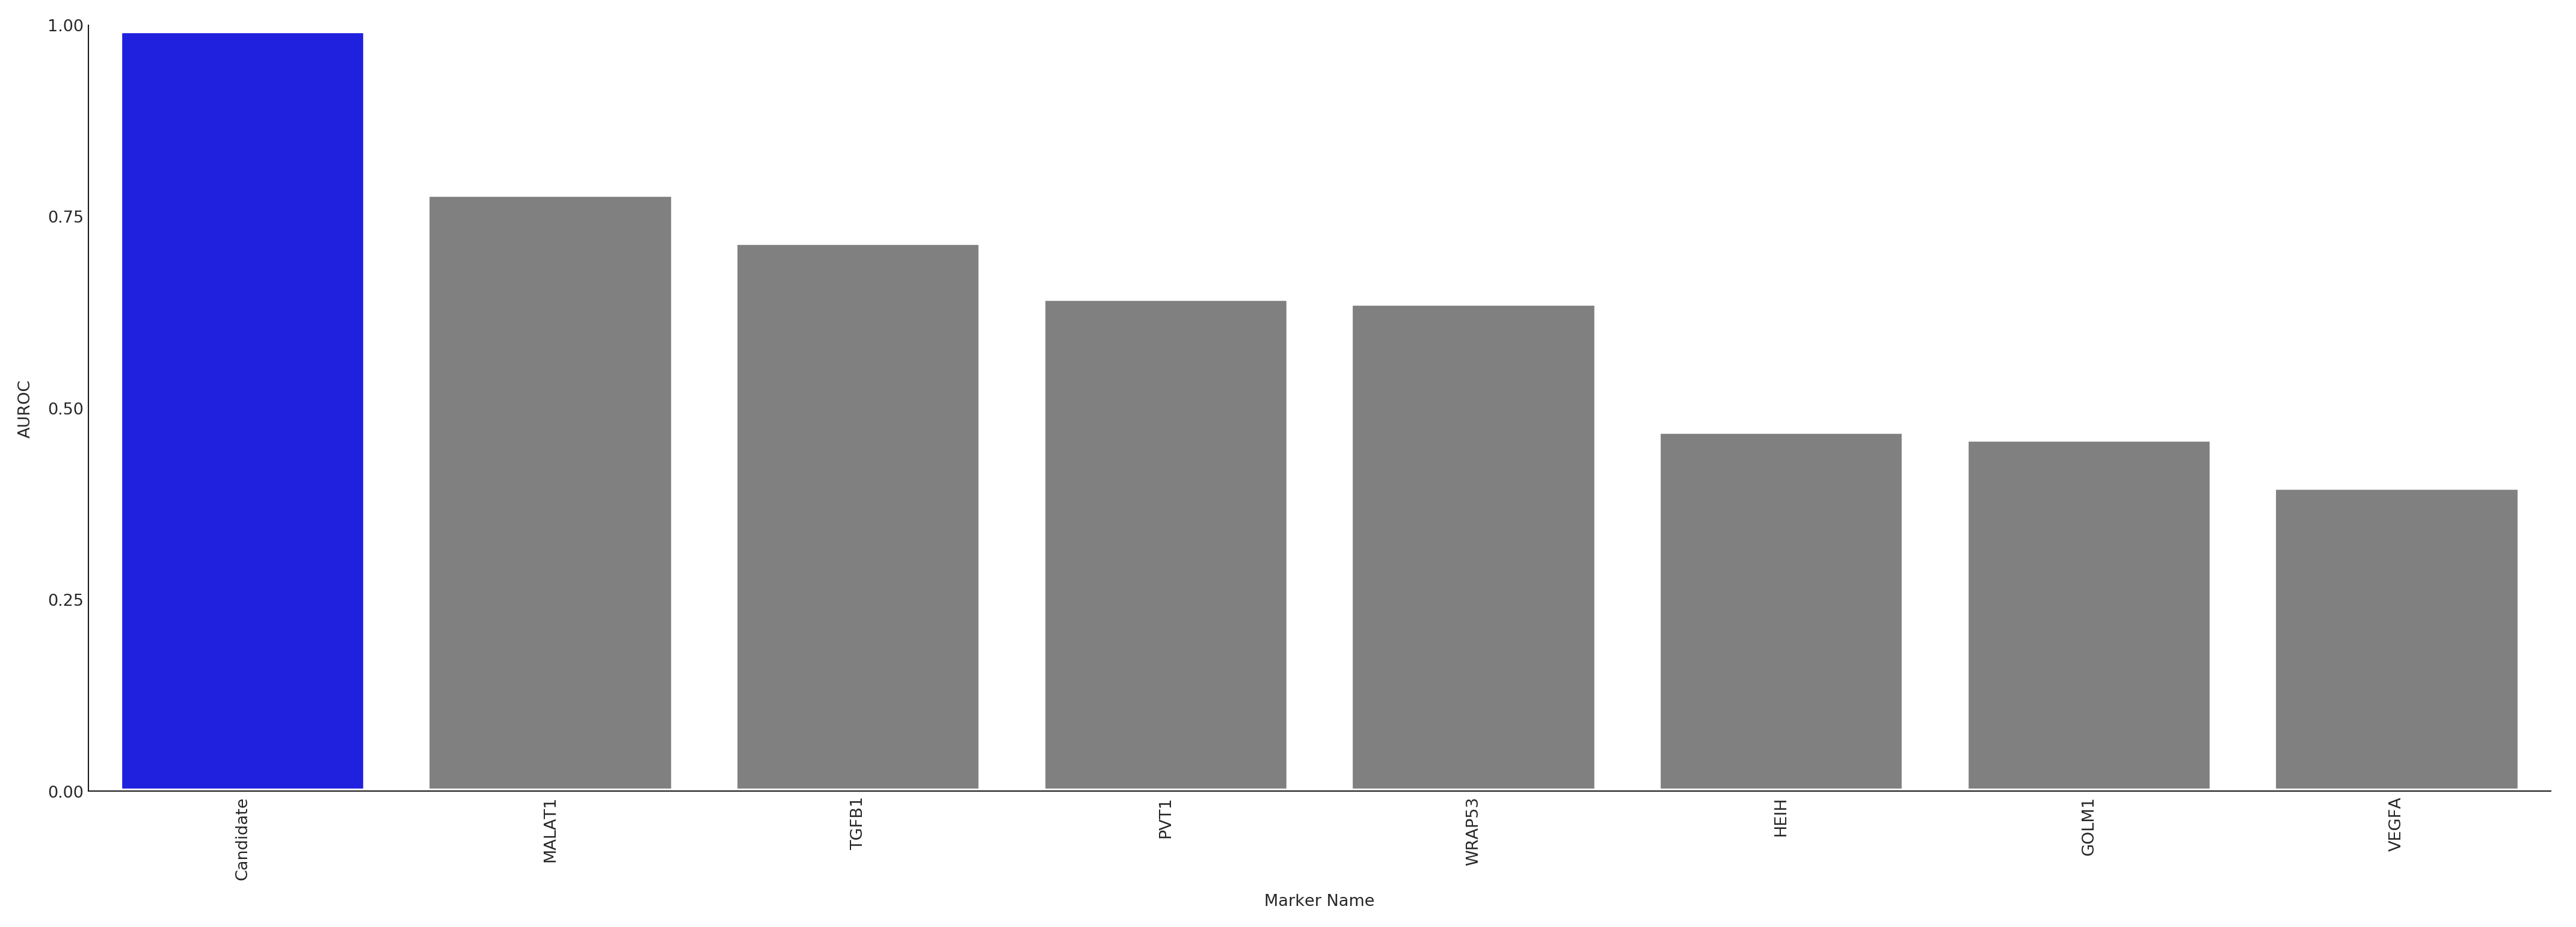

In [194]:
pd.set_option('display.max_colwidth', -1)
for compare_group, preprocess_method in tqdm(best_preprocess_methods.items()):
    if len(control_markers[compare_group].keys())>0:
        print (len(control_markers[compare_group].keys()),compare_group)
        #markernames  = np.concatenate((np.array(['Candidate']),np.array([control_markers[compare_group][i][0] for i in range(len(control_markers[compare_group].keys()))])))
        markernames = np.ndarray([len(control_markers[compare_group].keys())+1]).astype('str')
        markernames[0] = 'Candidate'
        count = 0
        count_=1
        panel_marker = []
        for i in control_markers[compare_group].keys(): 
            if control_markers[compare_group][i].shape[0] >1:
                markernames[count_] = 'Panel '+str(count)
                panel_marker.append(np.array2string(control_markers[compare_group][i],separator=',')[2:-2].replace("'", ""))
                count+=1
            else:
                markernames[count_] = control_markers[compare_group][i][0]
            count_+=1
        #print (markernames)
        if len(panel_marker) >0:
            panel_table = pd.DataFrame(panel_marker)
            panel_table.index = np.array(['panel '+str(i) for i in range(panel_table.shape[0])])
            panel_table.columns = ['markers']
            display(panel_table)
        selectedind = np.array([i for i in control_markers[compare_group].keys()])
        print (selectedind)
        
        aucall = np.concatenate((np.array([candidatevalue[compare_group]]),np.array([markers_auc[compare_group][i] for i in markers_auc[compare_group].keys()])))
        auctable =pd.DataFrame(np.concatenate((markernames.reshape(-1,1),aucall.reshape(-1,1)),axis=1))
        auctable.columns = ['Marker Name','AUROC']
        auctable.AUROC = pd.to_numeric(auctable.AUROC )
        auctable = auctable.sort_values('AUROC',ascending=0)
        #display(auctable)
        fig, ax = plt.subplots(1,figsize=(16, 6))
        #auctable.plot(kind='bar')
        
        clrs = ['grey' if (x < max(np.array(auctable.AUROC))) else 'blue' for x in np.array(auctable.AUROC)]
        sns.barplot(data=auctable,x='Marker Name',y='AUROC',palette=clrs)
        fig.tight_layout()
        ax.set_xticklabels(auctable.iloc[:,0],rotation=90,fontsize=20,weight='bold')
        ax = std_plot(ax,'Marker Name','AUROC',None)
        ax.set_ylim(0,1)
        #if savefig:
        fig.savefig(savepath+compare_group+'_marker_barplot.png', bbox_inches='tight')

## Cluster map

In [117]:
cpm_table_use['genetype'] = np.array([feature_matrix.index[i].split('|')[1] for i in range(feature_matrix.shape[0])])
pd.concat((sample_class_use.T,cpm_table_use)).to_csv('tmp.txt',sep='\t')
from clustergrammer_widget import Network, clustergrammer_widget
net = Network(clustergrammer_widget)
net.load_file('tmp.txt')

# cluster using default parameters
net.cluster(enrichrgram=True)

# make interactive widget
net.widget()

In [136]:
for compare_group, preprocess_method in tqdm(best_preprocess_methods.items()):
    print (compare_group,'output/'+dataset+'/matrix_processing/'+preprocess_method+'.txt')

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

Normal-CRC output/exorbase/matrix_processing/filter.viper_count.Norm_SCnorm.Batch_RUV.featurecounts.txt
Normal-HCC output/exorbase/matrix_processing/filter.viper_count.Norm_SCnorm.Batch_RUV.featurecounts.txt
Normal-PAAD output/exorbase/matrix_processing/filter.viper_count.Norm_SCnorm.Batch_RUV.featurecounts.txt


In [138]:
genename_remain = {}
best_processed_mx = {}

for compare_group, preprocess_method in tqdm(best_preprocess_methods.items()):
    best_processed_mx[compare_group] =pd.read_table('output/'+dataset+'/matrix_processing/'+preprocess_method+'.txt')
    genename_remain[compare_group] = np.array([best_processed_mx[compare_group].index[i].split('|')[2] for i
                            in range(best_processed_mx[compare_group].index.shape[0])])
    

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

In [195]:
control_markers = {}
control_markers['Normal-CRC'] = {}

control_markers['Normal-HCC'] = {}
control_markers['Normal-HCC'][0] = np.array(['GOLM1'])
control_markers['Normal-HCC'][1] = np.array(['TGFB1'])
control_markers['Normal-HCC'][2] = np.array(['VEGFA'])
control_markers['Normal-HCC'][3] = np.array(['HEIH'])
control_markers['Normal-HCC'][4] = np.array(['PVT1'])
control_markers['Normal-HCC'][5] = np.array(['WRAP53'])
control_markers['Normal-HCC'][6] = np.array(['MALAT1'])

control_markers['Normal-PAAD'] = {}


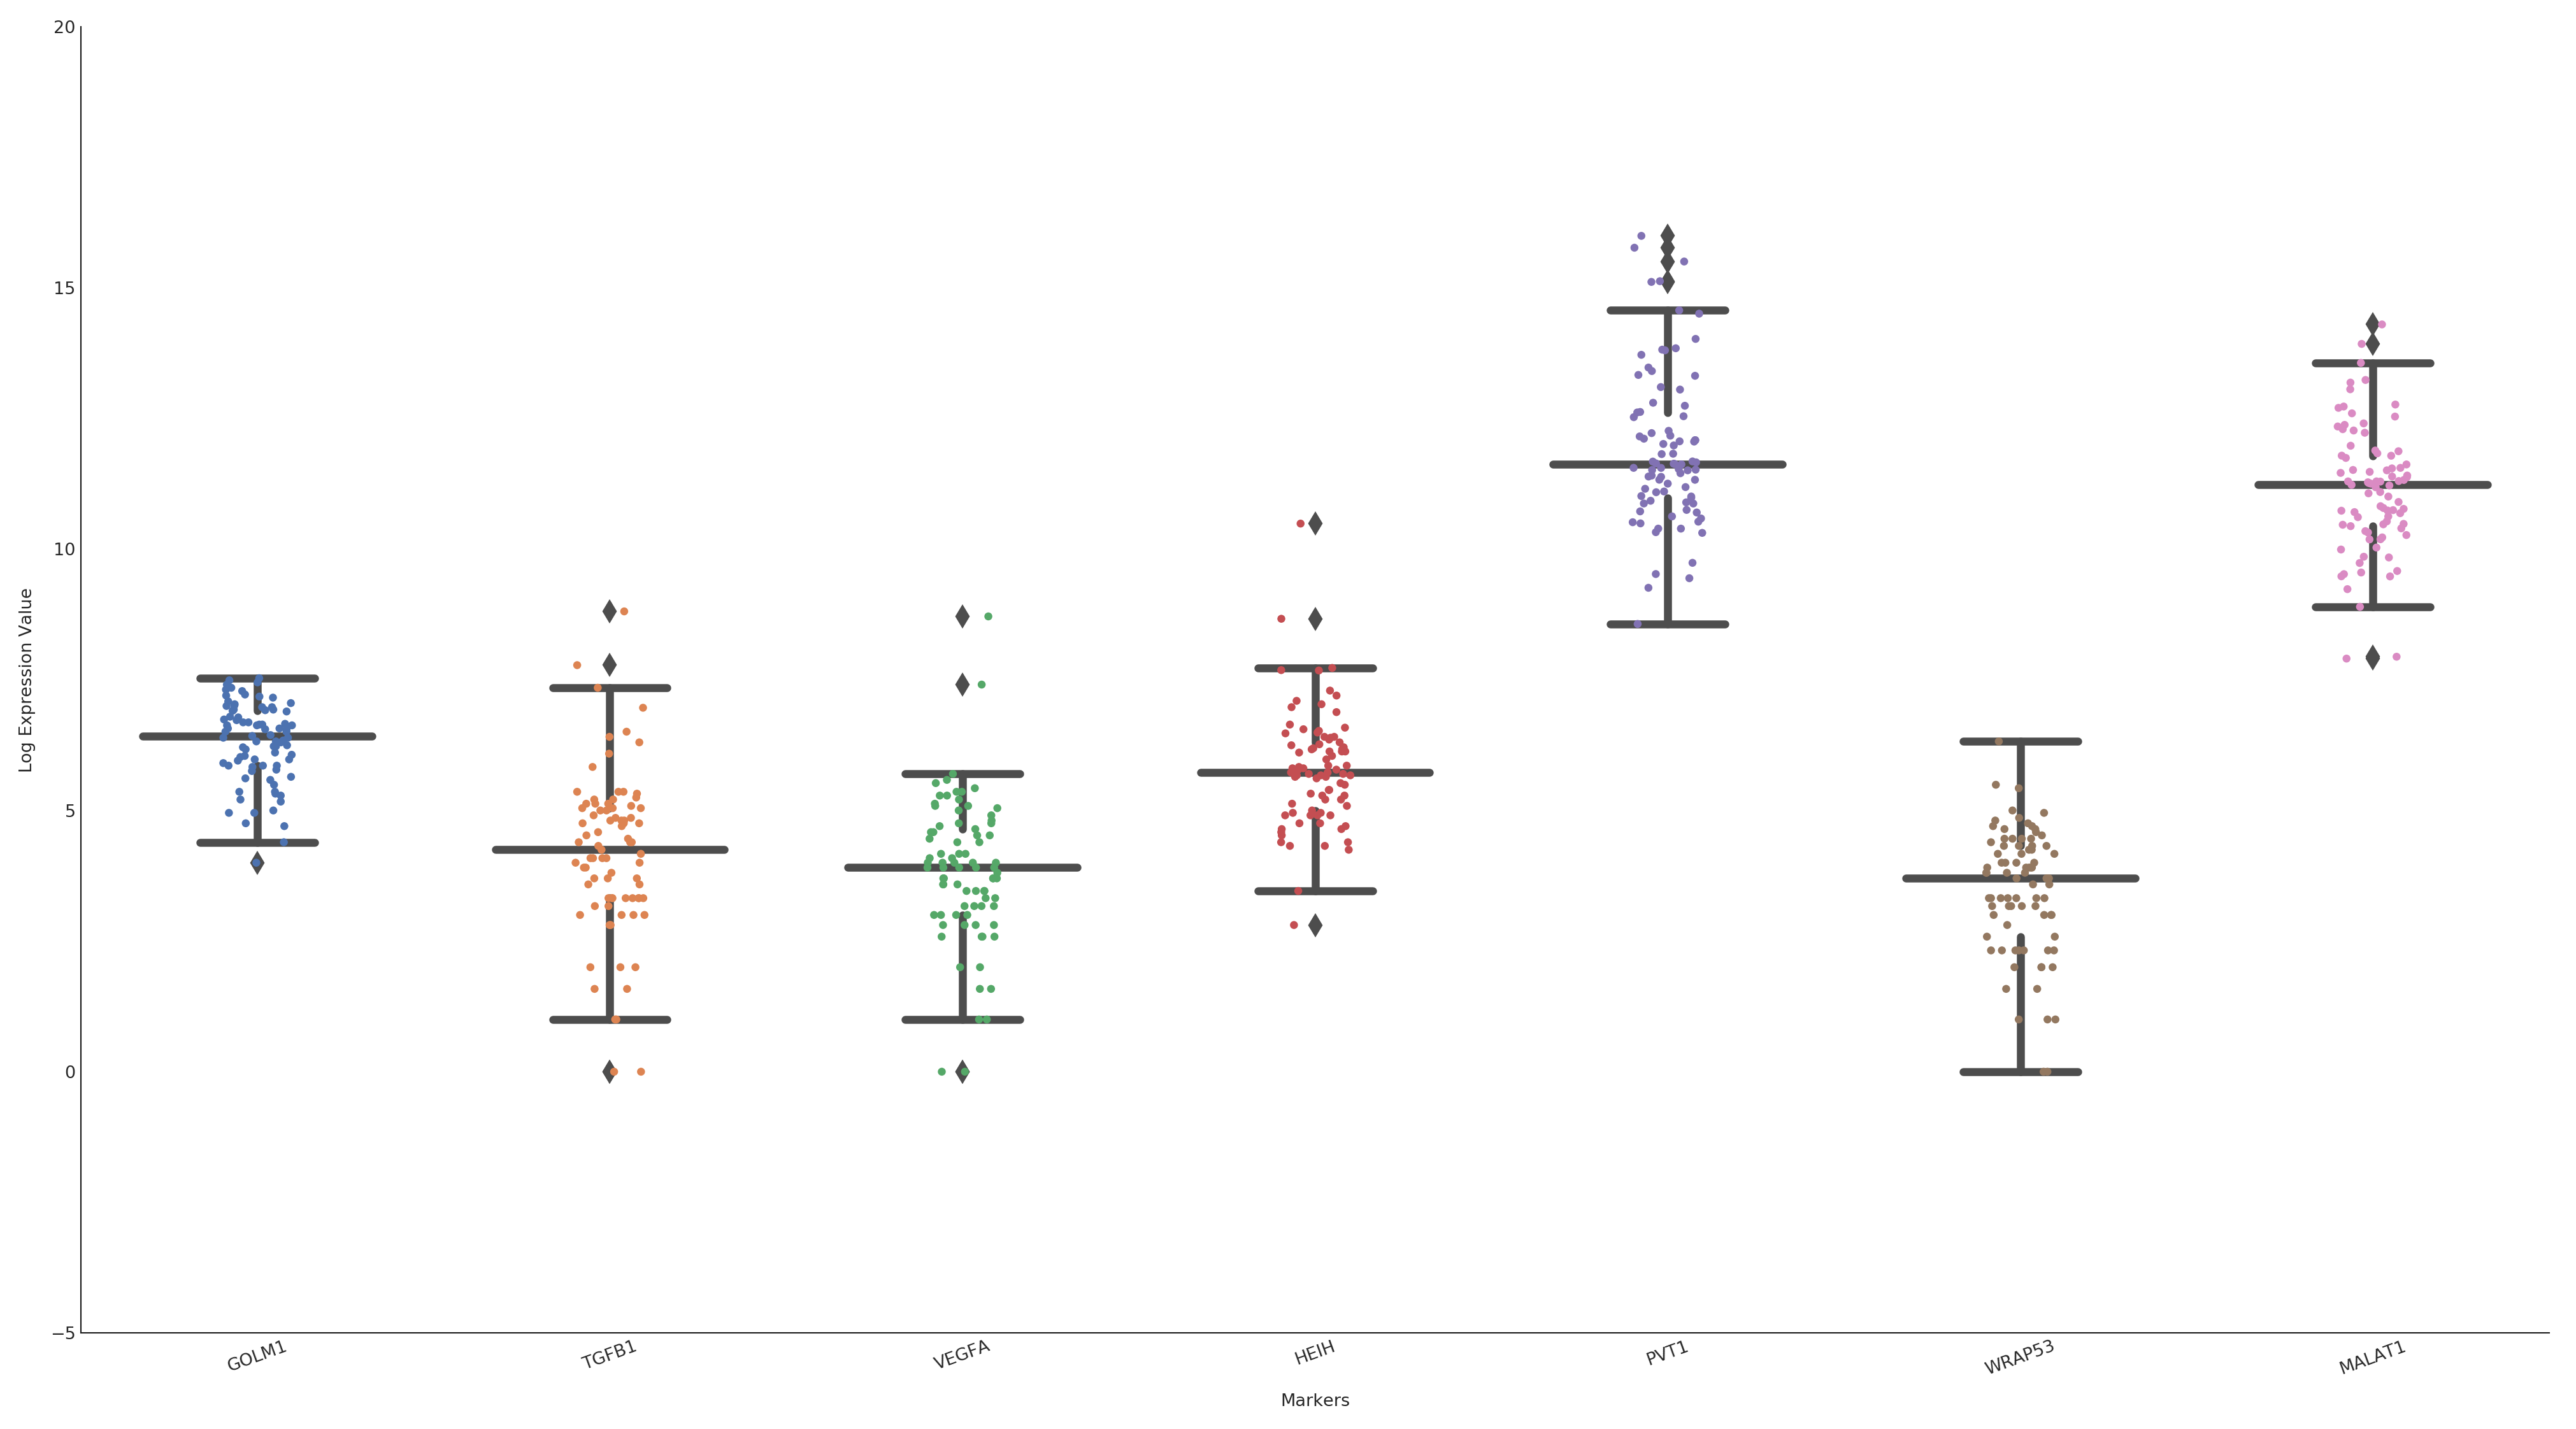

In [196]:
original_mx_name=  np.array([original_mx.index[i].split('|')[2] for i in  range(original_mx.index.shape[0]) ])
markername  = np.array([control_markers['Normal-HCC'][i][0] for i in range(len(control_markers['Normal-HCC'].keys()))])
marker_mx = original_mx.iloc[np.isin(original_mx_name,markername)]
        
fig, ax = plt.subplots(figsize=(14,8))
sns.boxplot(data = np.log2(marker_mx.T),ax=ax,boxprops=dict(alpha=.001),color='gray',width=0.65,saturation=0.01)
sns.stripplot(data =np.log2(marker_mx.T),ax=ax,size=3, edgecolor='black')
ax.set_xticklabels(markername,rotation=20,fontsize=20)
#ax.set_yticklabels(['{:.1f}%'.format((i-1)*20) for i in range(10)],fontsize=20,fontweight='bold')
ax = std_plot(ax,'Markers','Log Expression Value',title=None)
fig.tight_layout()

In [197]:
sys.path.append('bin')
from statannot import *

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+09
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

GOLM1_Healthy v.s. GOLM1_Cancer: MWW RankSum two-sided P_val=1.466e-01 U_stat=6.875e+02
TGFB1_Healthy v.s. TGFB1_Cancer: MWW RankSum two-sided P_val=7.475e-01 U_stat=8.120e+02
VEGFA_Healthy v.s. VEGFA_Cancer: MWW RankSum two-sided P_val=8.989e-01 U_stat=8.625e+02
HEIH_Healthy v.s. HEIH_Cancer: MWW RankSum two-sided P_val=2.564e-02 U_stat=6.015e+02
PVT1_Healthy v.s. PVT1_Cancer: MWW RankSum two-sided P_val=8.595e-01 U_stat=8.280e+02
WRAP53_Healthy v.s. WRAP53_Cancer: MWW RankSum two-sided P_val=5.307e-03 U_stat=5.405e+02
MALAT1_Healthy v.s. MALAT1_Cancer: MWW RankSum two-sided P_val=4.708e-01 U_stat=9.280e+02


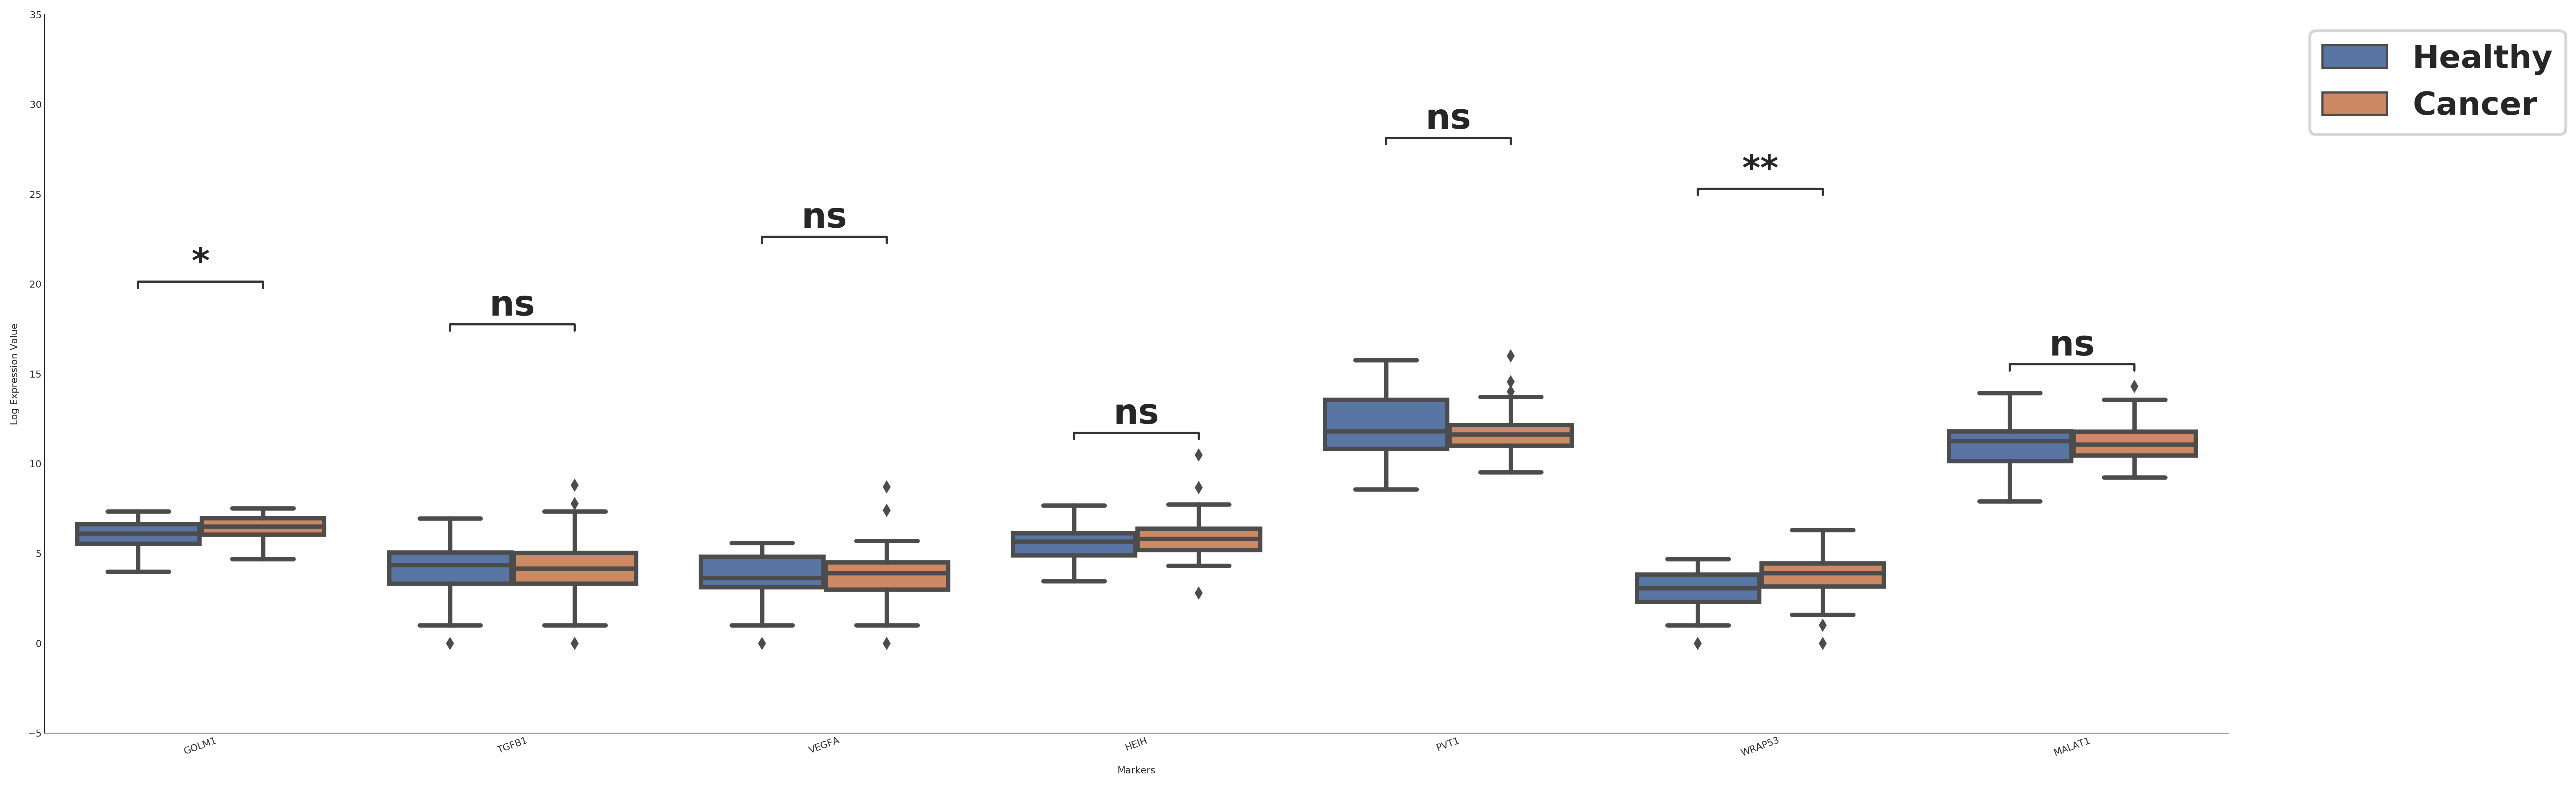

In [198]:
original_mx_name=  np.array([original_mx.index[i].split('|')[2] for i in  range(original_mx.index.shape[0]) ])
markername  = np.array([control_markers['Normal-HCC'][i][0] for i in range(len(control_markers['Normal-HCC'].keys()))])
marker_mx = original_mx.iloc[np.isin(original_mx_name,markername)]
sampleindex = marker_mx.columns

featureindex = np.array([marker_mx.index[i].split('|')[2]  for i in range(marker_mx.index.shape[0])])
testtable = pd.DataFrame(np.concatenate((np.array(marker_mx).reshape(-1,1),
        np.repeat(np.array(sample_class.index),featureindex.shape[0]).reshape(-1,featureindex.shape[0]).T.reshape(-1,1),
   np.repeat(np.array(sample_class.label),featureindex.shape[0]).reshape(-1,featureindex.shape[0]).T.reshape(-1,1),
        np.repeat(np.array(featureindex),sampleindex.shape[0]).reshape(-1,1)),axis=1))
testtable.columns=['Expression value','Sample','Class','Feature']
testtable['Class'].iloc[np.where(testtable.Class !='Healthy')] ='Cancer'
testtable.iloc[:,0] = np.log2(np.array(testtable.iloc[:,0]).astype('float'))
x = 'Feature'
y = 'Expression value'
hue = 'Class'
        
fig, ax = plt.subplots(figsize=(25,8))
sns.boxplot(data = testtable,ax=ax,x=x,y=y,hue=hue)
#sns.stripplot(data =testtable,ax=ax,x=x,y=y,hue=hue,size=3, edgecolor='black')
ax.set_xticklabels(markername,rotation=20,fontsize=20)
#ax.set_yticklabels(['{:.1f}%'.format((i-1)*20) for i in range(10)],fontsize=20,fontweight='bold')

add_stat_annotation(ax=ax, data=testtable, x=x, y=y, hue=hue,
                    boxPairList=np.array([((markername[i],'Healthy'),(markername[i],'Cancer')) for i in range(markername.shape[0])]),
                    test='Mann-Whitney',  loc='inside', verbose=2,#textFormat='full'
                   )
ax.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
ax = std_plot(ax,'Markers','Log Expression Value',title=None)
fig.tight_layout()

In [199]:
for compare_group, preprocess_method in tqdm(best_preprocess_methods.items()):
    for i in range(len(control_markers[compare_group].keys())):
        tmptab = best_processed_mx[compare_group].iloc[np.isin(genename_remain[compare_group],control_markers[compare_group][i])]
        tmptab.to_csv('control_markers/'+dataset+'/data/'+compare_group+'/control_markers_'+str(i)+'.txt',sep='\t')


HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

NameError: name 'best_processed_mx' is not defined

#HCC
AFP mRNA
AFP mRNA
AFP mRNA
GOLM(GP73)
GOLM1(GP73)
GPC2
GPC2
TGF-β1
TGF-β1
VEGFA(isoform121)
VEGFA(isoform165)
HULC
MALAT1
HEIH
PVT1
UCA1
WRAP53
CYTOR(C2orf59/LINC00152)
LINC01225(LOC149086)
RP11-160H22.5
XLOC014172
GPC3-AS1(AF085935)
AX800134
MIR7-3HG(uc002mbe.2)
uc001ncr
uc003wbd

#CRC
miR-92-3p,miR-21,miR-139-3p,miR-431
miR-20a
miR-26a
miR-124-5p
miR-141
miR-183
miR-221
miR-200c
miR-25-3p
miR-331-3p
miR-103a-3p
miR-127-3p
miR-151a-5p
miR-17-5p
miR-181a-5p
miR-18a-5p
miR-18b-5p
miR18a
miR19a
miR19b
miR15b
miR29a
miR335
miR-92
miR-17-3p

#Pancreat
miR-106b
miR-10b
miR-21
miR-30c
miR-20a
miR-181a
miR-483
miR-let7a
miR-122
miR-22
miR-642
miR-885
miR-223
miR-744
miR-10b
miR-30c
miR-106b
hsa-miR-155-5p
miR-212
Panel(miR-10b, miR-106b)
miR-182
miR-16
miR-885
miR-22
miR-642
Panel (miR-885, miR-22, miR-642)
miR-221
Panel (miR-16, miR-196a)
miR-21
miR-210
miR-155
miR-196a
Panel (miR-21,miR-210, miR-155, miR-196a)

In [198]:
def extract_featurefile(best_preprocess_methods):
    filename = []
    for compare_group, preprocess_method in tqdm(best_preprocess_methods.items()):
        tmp='output/'+dataset+'/feature_selection/'+preprocess_method+'/'+compare_group+'/random_forest.10.robust/features.txt'
        filename.append(tmp)
    return np.array(filename)
np.savetxt('output/selected_feature/'+dataset+'/selected_features.txt',
           extract_featurefile(best_preprocess_methods),fmt='%s')

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))